## 5.0 Capstone Project Two: All State Purchase Prediction - Modelling the Product Vectors<a id='2_Exploratory_Data_Analysis'></a>
**Submitted By:** Amit Kukreja

## Objectives
1) Create models for predicting the 7 product vector's final value based on shopping quotes 1 and 2

2) Test and evaluate the performance of different models on validation set. 

3) Tune hyperparameters to optimize model performance. 

4) Finally, apply the models to the test set to predict the vectors.


### Nomenclature and metrics
Before diving into modeling/predictions and performance testing, a quick word on some nomenclature and metrics

### Some Nomenclature
* **‘baseline_model’** : This refers to predicting the final vector choice based on the customer’s selection of the vector at most recent shopping pt, say 2.

* **‘A’**: Customer’s final choice for vector A i.e. the target we are predicting for vector A.

* **‘A_2’**: Customer’s choice for vector A at shopping pt 2.

* **‘A_2_2’**: One-hot encoded feature for vector A,  at shopping pt 2, for class 2.

### Metrics for model evaluation:
The no. of classes for vectors range from 2 to 4. The key objective we have is to predict each customer’s correct class for each of the 7 vectors. As such, the key metrics for model evaluation would be **‘micro accuracy’ / recall** i.e. the overall correct class predictions across all customers.



## How this notebook is organized

This is a long notebook and the work in divided into 2 phases. Each phase is divided into steps. The best way is to following along from phase 1 to phase 2. Links are given below if you want to jump to a specific Phase / step.

* [Phase 1: Training the models based on transformed dataset with history of quotes 1 and 2](#Phase_1)

    * [Step 1: Load the transformed training dataset and split it into training and validation set](#Phase1_step1)
    * [Step 2: Run the functions to perform predictions and hyperparameter tuning](#Phase1_step2)
    * [Step 3: Train and tune models](#Phase1_step3)
        * [Vector B](#Phase1_step3.1)
        * [Vector G](#Phase1_step3.2)
        * [Vector A](#Phase1_step3.3)
        * [Vector E](#Phase1_step3.4)
        * [Vector C](#Phase1_step3.5)
        * [Vector D](#Phase1_step3.6)
        * [Vector F](#Phase1_step3.7)
    * [Step 4: Summary: Model Training](#Phase1_step4)

* [Phase 2: Making Predictions on the test set](#Phase_2)

    * [Step 1: Load the transformed test dataset and create dataframes to compare model performance](#Phase2_step1)
    * [Step 2: Run the functions to perform predictions and hyperparameter tuning](#Phase2
        * [Vector A](#Phase2_step2.1)
        * [Vector B](#Phase2_step2.2)
        * [Vector C](#Phase2_step2.3)
        * [Vector D](#Phase2_step2.4)
        * [Vector E](#Phase2_step2.5)
        * [Vector F](#Phase2_step2.6)
        * [Vector G](#Phase2_step2.7)
    * [Step 3: Summary: Making Predictions](#Phase2_step3)



## Phase 1: Training the models based on transformed dataset with history of quotes 1 & 2 <a id='Phase_1'></a>

In [4]:
# Let's load all the libraries required

from pathlib import Path

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from pandas_profiling.utils.cache import cache_file
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sb_utils import save_file
from collections import defaultdict
from collections import Counter
from sklearn.model_selection import train_test_split

from sklearn import preprocessing
import numpy as np

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve, f1_score, auc

from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score, log_loss


## Step 1: Load the transformed training dataset and split it into training and validation set<a id='Phase1_step1'></a>

In [5]:
# Let's import the preprocessed and transformed feature matrix and target vectors

X = pd.read_csv('Transformed_data/pre_processed_training_data_with_quotes_1_2.csv')
y = pd.read_csv('Transformed_data/training_data_target_columns.csv')


X.shape, y.shape        

((77607, 94), (77607, 7))

In [6]:
X.head()

shopping_pt  car_age_2  age_oldest_2  age_youngest_2  duration_previous_2  \
0     1.072089  -0.901461     -0.003780        0.129103            -0.636138   
1     0.571683   0.824464     -1.209101       -1.073002             0.862673   
2     0.571683   2.032611     -0.061176       -1.359217            -0.636138   
3     0.571683  -0.211091     -0.692535       -0.615057            -0.636138   
4     1.572496   0.134094     -1.036912       -0.901272            -0.422023   

     cost_1    cost_2  changes_step_2  cost_diff_step_2  state_AR  ...  F_1_3  \
0  0.464913  0.467906       -0.871664         -0.043014         0  ...      0   
1 -0.677346 -1.614463        0.903450         -1.338349         0  ...      0   
2 -0.303158 -0.352421       -0.871664         -0.043014         0  ...      1   
3  0.287666  0.867553       -0.279959          0.841605         0  ...      0   
4  0.090725 -0.352421        0.311745         -0.674885         0  ...      0   

   F_2_1  F_2_2  F_2_3  G_1_1  G_1_2  G_1_3  G_2_1  G_2_2  G_2_3  
0      0      1      0      0      0      0      0      0      0  
1      0      0      0      0      1      0      0      1      0  
2      0      0      1      0      1      0      0      1      0  
3      0      1      0      0      0      1      0      1      0  
4      1      0      0      0      0      1      0      1      0  

[5 rows x 94 columns]

In [7]:
y.head()

A  B  C  D  E  F  G
0  1  1  2  2  0  2  0
1  0  0  0  2  0  0  2
2  1  1  1  2  0  2  2
3  1  1  1  1  1  2  2
4  1  1  0  2  1  1  2

In [8]:
# Split the features and target into training and validation sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123, stratify = X['shopping_pt'])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((62085, 94), (15522, 94), (62085, 7), (15522, 7))

## Step 2: Load functions and create dataframes for comparing the performance of models<a id='Phase1_step2'></a>

In [9]:
# Create functions based on different classifiers to predict the vectors and plot feature importances

plt.style.use("fivethirtyeight")

def rf_predict_plot(vector, n_estimators=300, min_samples_leaf = 1, min_samples_split = 2, plot = False):
    
    global rf_clf 
    
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf = min_samples_leaf, \
                             min_samples_split = min_samples_split, random_state = 1,n_jobs=-1)

    model_res = rf_clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = model_res.predict(X_test.to_numpy())
    y_pred_prob = model_res.predict_proba(X_test.to_numpy())
    rf_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'), 4)
    cm1= confusion_matrix(y_test[vector].astype('int'), y_pred)

    print(f"Random Forest Classifier results for Vector {vector}")
    print(f"Parameters: No. of Estimators = {n_estimators},  min_samples_leaf = {min_samples_leaf}, \
    min_samples_split = {min_samples_split}")
    print(f'Accuracy={ac:4.4}, f1-score={f1:4.4}')
    
    if plot == True:
        print("Confusion Matrix - normalized\n", cm)
        print("Confusion Matrix\n", cm1)
    
        cr = classification_report(y_test[vector].astype('int'), y_pred)
        print("\nClassification Report \n", cr)
    
        feature_importance = rf_clf.feature_importances_
        # make importances relative to max importance
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        sorted_idx = np.argsort(feature_importance)[X_train.shape[1] - 10:]
        pos = np.arange(sorted_idx.shape[0]) + .5
        print(pos.size)
        sorted_idx.size
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(5,5))
        plt.barh(pos, feature_importance[sorted_idx], align='center')
        plt.yticks(pos, X_train.columns[sorted_idx])
        plt.xlabel('Relative Importance')
        plt.title('Random Forest Model\nFeature Importances for Vector '+vector)
        plt.show()
    
    return ac, f1, rf_probs, y_pred

def xg_predict_plot(vector, n_estimators=200, max_depth = 1, learning_rate = 0.3, colsample_bytree = 1, plot = False):
    
    global xg_clf  
    xg_clf = xgb.XGBClassifier(max_depth=max_depth, objective='binary:logistic', n_estimators=n_estimators, \
                       learning_rate = learning_rate, colsample_bytree = colsample_bytree, n_jobs=-1, random_state=1)

    model_res = xg_clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = model_res.predict(X_test.to_numpy())
    y_pred_prob = model_res.predict_proba(X_test.to_numpy())
    xg_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),4)
    cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

    print(f"XGBoost Classifier results for Vector {vector}")
    print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}, \
    learning_rate = {learning_rate}, colsample_bytree = {colsample_bytree}")
    print(f'Accuracy={ac:4.4}, f1-score={f1:4.4}')
    
    if plot == True:
        print("Confusion Matrix - normalized\n", cm)
        print("Confusion Matrix\n", cm1)

        cr = classification_report(y_test[vector].astype('int'), y_pred)
        print("\nClassification Report \n", cr)

        feature_importance = xg_clf.feature_importances_
        # make importances relative to max importance
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        sorted_idx = np.argsort(feature_importance)[X_train.shape[1] - 10:]

        pos = np.arange(sorted_idx.shape[0]) + .5
        print(pos.size)
        sorted_idx.size
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(5,5))
        plt.barh(pos, feature_importance[sorted_idx], align='center')
        plt.yticks(pos, X_train.columns[sorted_idx])
        plt.xlabel('Relative Importance')
        plt.title('XG Boost Model\nFeature Importance for Vector '+vector)
        plt.show()
        
    return ac, f1, xg_probs, y_pred
    
def gb_predict_plot(vector, n_estimators=100, max_depth = 2, learning_rate = 0.3, max_features = 6, plot = False):
    
    global gb_clf
    gb_clf = GradientBoostingClassifier(max_depth=max_depth, n_estimators=n_estimators, \
                       learning_rate = learning_rate, max_features = max_features, random_state=1)

    model_res = gb_clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = model_res.predict(X_test.to_numpy())
    y_pred_prob = model_res.predict_proba(X_test.to_numpy())
    gb_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),4)
    cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

    print(f"Gradient Boosting Classifier results for Vector {vector}")
    print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}, \
    learning_rate = {learning_rate}, max_features = {max_features}")
    print(f'Accuracy={ac:4.4}, f1-score={f1:4.4}')
    
    if plot == True:
        print("Confusion Matrix - normalized\n", cm)
        print("Confusion Matrix\n", cm1)

        cr = classification_report(y_test[vector].astype('int'), y_pred)
        print("\nClassification Report \n", cr)

        feature_importance = gb_clf.feature_importances_
        # make importances relative to max importance
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        sorted_idx = np.argsort(feature_importance)[X_train.shape[1] - 10:]

        pos = np.arange(sorted_idx.shape[0]) + .5
        print(pos.size)
        sorted_idx.size
        plt.figure(figsize=(5,5))
        plt.barh(pos, feature_importance[sorted_idx], align='center')
        plt.yticks(pos, X_train.columns[sorted_idx])
        plt.xlabel('Relative Importance')
        plt.title('Gradient Boosting Model\nFeature Importance for Vector '+vector)
        plt.show()
        
    return ac, f1, gb_probs, y_pred

def lr_predict(vector):
    
    logreg = LogisticRegression()
    logreg.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = logreg.predict(X_test.to_numpy())
    y_pred_prob = logreg.predict_proba(X_test.to_numpy())
    lr_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),4)
    cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

    print(f'Logistic Regression for vector {vector}')
    print(f'Accuracy = {ac:4.4}, f1-score = {f1:4.4}\n')
    print("Confusion Matrix - normalized\n", cm)
    print("Confusion Matrix\n", cm1)

    cr = classification_report(y_test[vector].astype('int'), y_pred)
    fpr_2, tpr_2, thresholds_2 = roc_curve(y_test[vector].astype('int'), lr_probs)
    roc_auc2 = auc(fpr_2, tpr_2)
    print("\nClassification Report \n", cr)
    print("\nArea under ROC: \n", roc_auc2)
    
    return ac, f1, lr_probs, y_pred

def knn_predict(vector, n_neighbors=5):
    
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = knn.predict(X_test.to_numpy())
    y_pred_prob = knn.predict_proba(X_test.to_numpy())
    kn_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'), 4)
    cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)
    
    print(f'KNN Model for Vector {vector}: No. of Neighbors = {n_neighbors}' )
    print(f'Accuracy = {ac:4.4}, f1-score = {f1:4.4}\n')
    print("Confusion Matrix - normalized\n", cm)
    print("Confusion Matrix\n", cm1)

    cr = classification_report(y_test['B'].astype('int'), y_pred)

    print("\nClassification Report \n", cr)
        
    return ac, f1, kn_probs, y_pred

from sklearn.model_selection import RandomizedSearchCV

def rf_randomsearch(vector, iterations = 10):

    param_grid = {'n_estimators' : np.arange(100,801,100), 'min_samples_split': np.arange(2,6), \
              'min_samples_leaf': np.arange(1,5)}

    rf = RandomForestClassifier(random_state = 1, n_jobs=-1)
    rf_cv = RandomizedSearchCV(rf, param_grid, n_iter = iterations, verbose = 3, cv=4)
    rf_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

    print(f"Vector {vector} RandomizedSearchCV: Random Forest Model\nBest Score:" + str(rf_cv.best_score_))
    print("Best Parameters: " + str(rf_cv.best_params_))
    
    results = pd.DataFrame(rf_cv.cv_results_['params'])
    results['train_score'] = rf_cv.cv_results_['mean_test_score']
    results['train_rank'] = rf_cv.cv_results_['rank_test_score']
    
    return results

def xgb_randomsearch(vector, iterations = 10):
    
    param_grid = {'learning_rate' : [0.25, 0.3, 0.35, 0.5], 'n_estimators' : np.arange(100,501,100), \
              'colsample_bytree': [0.15,0.25,0.35,0.5], 'max_depth' : [3,4,5]}

    clf = xgb.XGBClassifier(objective='binary:logistic', random_state=1, n_jobs=-1)
    clf_cv = RandomizedSearchCV(clf, param_grid, n_iter = iterations, verbose = 3, cv=4)
    clf_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

    print(f"Vector {vector} RandomizedSearchCV: XG Boosting Model\nBest Score:" + str(clf_cv.best_score_))
    print("\nBest Parameters: " + str(clf_cv.best_params_))

    results = pd.DataFrame(clf_cv.cv_results_['params'])
    results['train_score'] = clf_cv.cv_results_['mean_test_score']
    results['train_rank'] = clf_cv.cv_results_['rank_test_score']

    return results


In [11]:
# I. Create functions for:
# 1) Encoding vectors C, D and G to work with XG Boost classifier
# 2) Make a score matrix that shows how well a model does on predicting behaviour of customers who change 
# or don't change vectors
# 3) Make a score matrix that shows how well a model does on predicting behaviour of customers who purchase at 
# different shopping points
# 4) Plot the performance of models against the baseline

#II. Define a class to store the performance of different models for all 7 vectors.

def change_vector_encoding(dataframe, quote_nos):
    change_vectors = ['C', 'D', 'G']
    new_encoding = {1:0, 2:1, 3:2, 4:3}
    for vect in change_vectors:
        dataframe[vect] = dataframe[vect].map(lambda x: new_encoding[x])
        for quote in quote_nos:
            dataframe[vect+'_'+str(quote)] = dataframe[vect+'_'+str(quote)].map(lambda x: new_encoding[x])
            
    return dataframe

def model_score_matrix(vector, benchmark_quote, predictions):
    
    col_2 = vector+'_'+str(benchmark_quote)
    col_3 = vector+'='+str(benchmark_quote)
    vect_compare = y_test_compare[[vector, col_2,col_3]]
    vect_compare[vector+'_Pred'] = predictions
    vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
    score_vect = pd.crosstab(vect_compare[col_3], vect_compare['Pred_Correct'])
    score_vect.columns = ['Pred_incorrect', 'Pred_correct']
    score_vect.index = ['cust_changed_vector', 'cust_maintained_vector']
    score_vect['Pred_accuracy_%'] = np.around((score_vect['Pred_correct'] *100 / \
                                               score_vect[['Pred_incorrect', 'Pred_correct']].sum(axis=1)), 2)
    
    return score_vect

def model_score_by_shopping_pt(vector, benchmark_quote, predictions):
    col_2 = vector+'='+str(benchmark_quote)
    vect_compare = y_test_compare[['shopping_pt', vector, col_2]]
    vect_compare[vector+'_Pred'] = predictions
    vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
    
    score_vect = pd.DataFrame(vect_compare.groupby('shopping_pt')['Pred_Correct', col_2].mean())
    score_vect.columns = [vector+'_model_accuracy_%', vector+'_quote'+str(benchmark_quote)+'_accuracy_%']
    score_vect[vector+'_model_accuracy_%'] = np.around(score_vect[vector+'_model_accuracy_%'] *100, 2)
    score_vect[vector+'_quote'+str(benchmark_quote)+'_accuracy_%'] = \
                                            np.around(score_vect[vector+'_quote'+str(benchmark_quote)+'_accuracy_%'] *100, 2)
    score_vect['model_vs_quote'] = score_vect[vector+'_model_accuracy_%'] - \
                                                            score_vect[vector+'_quote'+str(benchmark_quote)+'_accuracy_%']
    return score_vect

def model_performance_plot(vector, models, quotes, perf_record, type):
    
    plt.style.use('fivethirtyeight')
    model_map = {'no_model': 'Baseline Model\n(Quote '+str(quotes[-1])+')', 'rf': 'Random\nForest', 'gb':'Gradient\nBoost', \
                     'xg': 'XG\nBoost', 'lr': 'Logistic\nRegression'}
    legend_map = {'no_model': 'Baseline Model\n(Quote '+str(quotes[-1])+')', 'rf': 'Random Forest', 'gb':'Gradient Boost', \
                     'xg': 'XG Boost', 'lr': 'Logistic Regression'}
    labels = [model_map[x] for x in models]
    legend = [legend_map[x] for x in models]
    
    if type == 'overall':

        colors = ['blue', 'red', 'orange']
        metrics = ['accuracy_overall', 'accuracy_cust_changed_vector', 'accuracy_cust_maintained_vector']
        subset1 = perf_record[vector][models].iloc[0:3,:]

        fig, ax = plt.subplots(1,2,figsize=(14,6))
        ax[0].plot(subset1.iloc[0,:], marker = 'o', label = subset1.index[0])

        for index in range(1,3):
            ax[1].plot(subset1.iloc[index,:], marker = 'o', color = colors[index], label = subset1.index[index])

        plt.suptitle("Vector "+vector+": Performance of Different Classifiers\n(prediction basis quote "+str(quotes[-2])+" & "\
                                                                                        +str(quotes[-1])+")")
        ax[0].set_ylabel('Accuracy %')
        ax[0].set_xlabel('Classifier')
        ax[0].set_xticklabels(labels)
        
        ax[1].set_ylabel('Accuracy %')
        ax[1].set_xlabel('Classifier')
        ax[1].set_xticklabels(labels)

        ax[0].legend()
        ax[1].legend()

        plt.tight_layout()
        plt.show()
        filename1 = "charts_modelling/vector_"+vector+"_model performance.jpg"
        fig.savefig(filename1)
    
    elif type == 'shopping_pt':
        
        subset2 = perf_record[vector][models].iloc[3:,:]
        subset2.reset_index(inplace=True)
        subset2.drop(columns='index', inplace=True)
        subset2['shopping_pt'] = [x for x in range(quotes[-1]+1,14)]

        fig, ax = plt.subplots(1,1,figsize=(9,6))

        for i, model in enumerate(models):
            ax.plot(subset2['shopping_pt'], subset2[model], marker='o', label=legend[i])

        plt.ylabel('Accuracy %')
        plt.xlabel('Shopping Pt')
        plt.xticks(subset2['shopping_pt'])
        plt.suptitle("Vector "+vector+": Performance of Classifiers by shopping pt")
        plt.title("(prediction basis quote "+str(quotes[0])+" & "+str(quotes[1])+")", fontsize=14)
        ax.legend()
        plt.tight_layout()
        plt.show()
        filename2 = "charts_modelling/vector_"+vector+"_model performance_by_shopping_pt.jpg"
        fig.savefig(filename2)

#class to contain performance record of different models for a product vector
class ModelPerformanceRecord:
    
    def initialize(self, vectors, quote_no):
        # initialize the shopping_history object with customer data across all shopping points
        
        index_list = ['accuracy_overall', 'accuracy_cust_changed_vector','accuracy_cust_maintained_vector']
        for quote in range(quote_no+1, 14):
            index_list.append('accuracy_shopping_pt_'+str(quote))
        col_list = ['no_model']
        
        self.record = dict.fromkeys(vectors)
        for key in self.record.keys():
            self.record[key] = pd.DataFrame(index = index_list, columns = col_list)
        
                    
    def update(self, vector, model, metric, value):
        if metric == 'overall':
            self.record[vector].loc["accuracy_overall", model] = value
        elif metric == 'customer_type':
            for i, row in value.iterrows():
                self.record[vector].loc["accuracy_"+i, model] = row["Pred_accuracy_%"]
                if i == 'cust_changed_vector':
                    self.record[vector].loc["accuracy_cust_changed_vector", "no_model"] = 0
                elif i == 'cust_maintained_vector': 
                    self.record[vector].loc["accuracy_cust_maintained_vector", "no_model"] = 100
                    
        elif metric == 'shopping_pt':
            for i, row in value.iterrows():
                self.record[vector].loc["accuracy_shopping_pt_"+str(i), model] = row[0]
                self.record[vector].loc["accuracy_shopping_pt_"+str(i), "no_model"] = row[1]
    
    def compare(self, vector, model):
        self.record[vector][model+"_vs_no_model"] = self.record[vector][model] - self.record[vector]["no_model"]
        



In [155]:
#load the dataframe with history of first 2 quotes

df_train_first2 = pd.read_csv('WIP_data/training_data_with_first2_quotes.csv')
df_train_first2.head()

customer_ID  shopping_pt state  A  B  C  D  E  F  G  ...  D_1  D_2  E_1  \
0     10109793            9    CO  1  1  3  3  0  2  1  ...    3    3    0   
1     10002231            8    OH  0  0  1  3  0  0  3  ...    1    3    0   
2     10150024            8    OH  1  1  2  3  0  2  3  ...    3    3    0   
3     10003949            8    FL  1  1  2  2  1  2  3  ...    2    2    1   
4     10103809           10    FL  1  1  1  3  1  1  3  ...    3    3    1   

   E_2  F_1  F_2  G_1  G_2  cost_1  cost_2  
0    0    2    2    1    1     656     656  
1    0    2    0    3    3     598     557  
2    0    3    3    3    3     617     617  
3    1    2    2    4    3     647     675  
4    1    1    1    4    3     637     617  

[5 rows x 37 columns]

In [156]:
# Change encoding of vectors C,D and G (to make it work with XG Boost)

df_train_first2 = change_vector_encoding(df_train_first2, [1,2])
df_train_first2.head()

customer_ID  shopping_pt state  A  B  C  D  E  F  G  ...  D_1  D_2  E_1  \
0     10109793            9    CO  1  1  2  2  0  2  0  ...    2    2    0   
1     10002231            8    OH  0  0  0  2  0  0  2  ...    0    2    0   
2     10150024            8    OH  1  1  1  2  0  2  2  ...    2    2    0   
3     10003949            8    FL  1  1  1  1  1  2  2  ...    1    1    1   
4     10103809           10    FL  1  1  0  2  1  1  2  ...    2    2    1   

   E_2  F_1  F_2  G_1  G_2  cost_1  cost_2  
0    0    2    2    0    0     656     656  
1    0    2    0    2    2     598     557  
2    0    3    3    2    2     617     617  
3    1    2    2    3    2     647     675  
4    1    1    1    3    2     637     617  

[5 rows x 37 columns]

In [250]:
# Save the modified dataframe as a separate csv
save_file(df_train_first2, 'hist_1_2_CDG_changed.csv', 'WIP_data')

Writing file.  "WIP_data\hist_1_2_CDG_changed.csv"


In [243]:
y_test.head()

A  B  C  D  E  F  G
44     0  0  0  0  0  0  1
40084  1  0  2  2  0  1  0
55264  1  1  1  1  0  2  3
40497  1  0  3  2  0  1  1
2379   0  0  2  2  0  0  1

In [249]:
# Create a Dataframe that captures the Quote 2 vectors for the validation set and shopping point of respective customers
# This would be used to score the model performance for customer who change vectors and customers who don't change vectors
# Shopping point info would be used to find how well the model does for closer and further off shopping points 

y_test_compare = y_test.merge(df_train_first2[['shopping_pt','A_2','B_2','C_2','D_2','E_2','F_2','G_2']], left_index=True, right_index=True)

product_vectors = ['A', 'B','C','D','E','F','G']
for vect in product_vectors:
    y_test_compare[vect+'=2'] = np.where(y_test_compare[vect] == y_test_compare[vect+'_2'], 1,0)

y_test_compare.head()

A  B  C  D  E  F  G  shopping_pt  A_2  B_2  ...  E_2  F_2  G_2  A=2  \
44     0  0  0  0  0  0  1            7    0    0  ...    0    0    1    1   
40084  1  0  2  2  0  1  0            7    1    0  ...    0    2    0    1   
55264  1  1  1  1  0  2  3            6    1    1  ...    0    2    3    1   
40497  1  0  3  2  0  1  1            5    1    0  ...    0    1    1    1   
2379   0  0  2  2  0  0  1            7    1    0  ...    1    0    1    0   

       B=2  C=2  D=2  E=2  F=2  G=2  
44       1    1    1    1    1    1  
40084    1    1    1    1    0    1  
55264    1    1    1    1    1    1  
40497    1    1    1    1    1    1  
2379     1    1    1    0    1    1  

[5 rows x 22 columns]

In [319]:
product_vectors = ['A', 'B', 'C','D','E','F','G']
perf_q1q2 = ModelPerformanceRecord()
perf_q1q2.initialize(product_vectors,2)
with open('Modelling_data/perf_record_q1_q2.pkl', 'rb') as f:
    perf_models_q1q2 = pickle.load(f)

## Step 3: Training models for the vectors<a id='Phase1_step3'></a>

Let's starts with vector B that is a binary vector.



### Vector B: Training Models<a id='Phase1_step3.1'></a>

Let's use a Random Forest Classifier to predict Vector B.


Random Forest Classifier results for Vector B
Parameters: No. of Estimators = 300,  min_samples_leaf = 1,     min_samples_split = 2
Accuracy=0.8348, f1-score=0.8344
Confusion Matrix - normalized
 [[0.8749 0.1251]
 [0.2089 0.7911]]
Confusion Matrix
 [[7083 1013]
 [1551 5875]]

Classification Report 
               precision    recall  f1-score   support

           0       0.82      0.87      0.85      8096
           1       0.85      0.79      0.82      7426

    accuracy                           0.83     15522
   macro avg       0.84      0.83      0.83     15522
weighted avg       0.84      0.83      0.83     15522

30


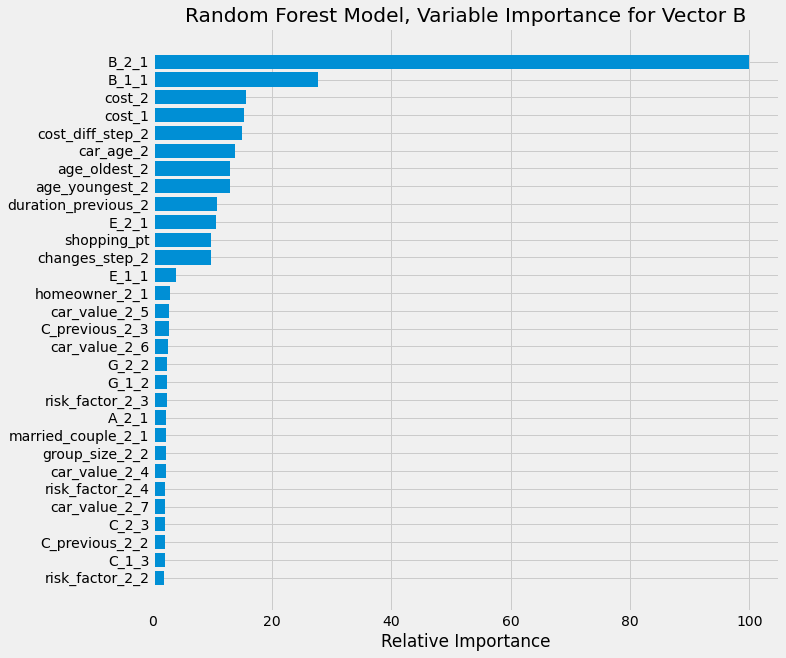

In [28]:
plt.style.use("fivethirtyeight")

vector = 'B'

rf_ac, rf_f1, rf_probs, rf_preds = rf_predict_plot(vector, plot=True)
    

In [293]:
# LEt's find the accuracy if final Vector B was predicted simply as B_2

vector = 'B'
#df_train_first2 = pd.read_csv('WIP_data/training_data_with_first2_quotes.csv')
test_set = df_train_first2.iloc[y_test.index,:]
x = pd.crosstab(test_set['B'], test_set['B_2'])
same_as_2 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 
acc = np.around(np.sum(same_as_2)/y_test.shape[0], 4)
print(f"Accuracy based on simply predicting vector {vector} = {vector}_2 : {acc}")

Accuracy based on simply predicting vector B = B_2 : 0.8334


In [9]:
x['total'] = x.sum(axis=1)
x['B0_%'] = np.around(x[0]*100 / x['total'], 2)
x['B1_%'] = np.around(x[1]*100 / x['total'], 2)
x

B_2     0     1  total   B0_%   B1_%
B                                   
0    7117   979   8096  87.91  12.09
1    1607  5819   7426  21.64  78.36

In [6]:
# Now let's try a Randomized Search CV to find the best Random Forest classifier for vector B

from sklearn.model_selection import RandomizedSearchCV

vector = 'B'
param_grid = {'n_estimators' : np.arange(100,801,100), 'min_samples_split': np.arange(2,6), \
              'min_samples_leaf': np.arange(1,5)}
rf = RandomForestClassifier(random_state = 1, n_jobs=-1)
rf_cv = RandomizedSearchCV(rf, param_grid, n_iter = 20, verbose = 3, cv=4)
rf_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))
print("Random Forest Model\nBest Score:" + str(rf_cv.best_score_))
print("\nBest Parameters: " + str(rf_cv.best_params_)) 

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV 1/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.843 total time=  18.5s
[CV 2/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.841 total time=  16.3s
[CV 3/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.833 total time=  16.6s
[CV 4/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.838 total time=  16.2s
[CV 1/4] END min_samples_leaf=2, min_samples_split=4, n_estimators=300;, score=0.844 total time=  15.4s
[CV 2/4] END min_samples_leaf=2, min_samples_split=4, n_estimators=300;, score=0.840 total time=  15.1s
[CV 3/4] END min_samples_leaf=2, min_samples_split=4, n_estimators=300;, score=0.832 total time=  15.0s
[CV 4/4] END min_samples_leaf=2, min_samples_split=4, n_estimators=300;, score=0.837 total time=  14.9s
[CV 1/4] END min_samples_leaf=3, min_samples_split=3, n_estimators=700;, score=0.844 total time=  33.8s
[CV

[CV 4/4] END min_samples_leaf=4, min_samples_split=2, n_estimators=700;, score=0.837 total time=  32.8s
Random Forest Model
Best Score:0.8389465246535858

Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1}


Random Forest Classifier results for Vector B
Parameters: No. of Estimators = 200,  min_samples_leaf = 1,     min_samples_split = 2
Accuracy=0.8352, f1-score=0.8348
Confusion Matrix - normalized
 [[0.875  0.125 ]
 [0.2082 0.7918]]
Confusion Matrix
 [[7084 1012]
 [1546 5880]]

Classification Report 
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      8096
           1       0.85      0.79      0.82      7426

    accuracy                           0.84     15522
   macro avg       0.84      0.83      0.83     15522
weighted avg       0.84      0.84      0.83     15522

20


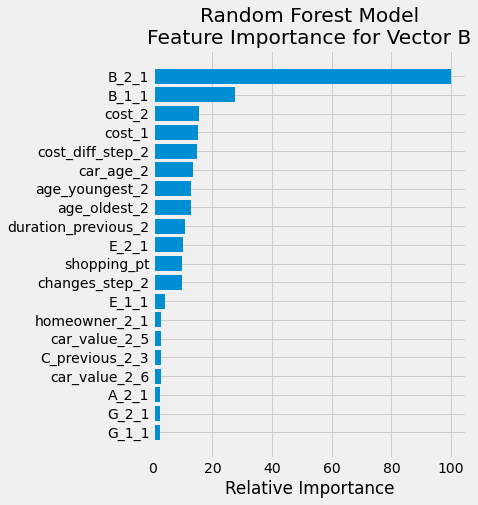

In [200]:

plt.style.use("fivethirtyeight")

vector = 'B'

rf_ac, rf_f1, rf_probs, rf_preds = rf_predict_plot(vector, n_estimators=200, min_samples_leaf = 1, min_samples_split = 2, plot = True)


In [320]:
vector = 'B'
score_matrix = model_score_matrix(vector, 2, rf_preds)
score_matrix

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)


Pred_incorrect  Pred_correct  Pred_accuracy_%
cust_changed_vector               2512            74             2.86
cust_maintained_vector              46         12890            99.64

In [321]:
score = model_score_by_shopping_pt("B", 2, rf_preds)
score

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple

B_model_accuracy_%  B_quote2_accuracy_%  model_vs_quote
shopping_pt                                                         
3                         86.53                86.53            0.00
4                         86.33                86.25            0.08
5                         86.19                86.08            0.11
6                         84.24                84.28           -0.04
7                         83.79                83.52            0.27
8                         82.61                82.32            0.29
9                         80.60                80.66           -0.06
10                        80.02                78.99            1.03
11                        80.65                80.35            0.30
12                        67.11                67.11            0.00
13                        87.50                87.50            0.00

In [322]:
perf_q1q2.update('B', 'no_model', 'overall', acc*100)
perf_q1q2.update('B', 'rf', 'overall', round(rf_ac*100,2))
perf_q1q2.update('B', 'rf', 'customer_type', score_matrix)
perf_q1q2.update('B', 'rf', 'shopping_pt', score)
perf_q1q2.compare('B', 'rf')
perf_q1q2.record['B']

no_model     rf rf_vs_no_model
accuracy_overall                   83.34  83.52           0.18
accuracy_cust_changed_vector           0   2.86           2.86
accuracy_cust_maintained_vector      100  99.64          -0.36
accuracy_shopping_pt_3             86.53  86.53            0.0
accuracy_shopping_pt_4             86.25  86.33           0.08
accuracy_shopping_pt_5             86.08  86.19           0.11
accuracy_shopping_pt_6             84.28  84.24          -0.04
accuracy_shopping_pt_7             83.52  83.79           0.27
accuracy_shopping_pt_8             82.32  82.61           0.29
accuracy_shopping_pt_9             80.66  80.60          -0.06
accuracy_shopping_pt_10            78.99  80.02           1.03
accuracy_shopping_pt_11            80.35  80.65            0.3
accuracy_shopping_pt_12            67.11  67.11            0.0
accuracy_shopping_pt_13             87.5  87.50            0.0

In [195]:
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test[vector].astype('int'), rf_probs)
thresholds_rf = np.append(thresholds_rf, 1.0)

In [201]:
# As B is a binary vector, let's predict it with a Logistic Regression model

vector = 'B'

lr_ac, lr_f1, lr_probs, lr_preds = lr_predict(vector)


Logistic Regression for vector B
Accuracy = 0.8335, f1-score = 0.833

Confusion Matrix - normalized
 [[0.8786 0.1214]
 [0.2156 0.7844]]
Confusion Matrix
 [[7113  983]
 [1601 5825]]

Classification Report 
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      8096
           1       0.86      0.78      0.82      7426

    accuracy                           0.83     15522
   macro avg       0.84      0.83      0.83     15522
weighted avg       0.84      0.83      0.83     15522


Area under ROC: 
 0.8707366237522474


C:\Users\amite\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [323]:
vector = 'B'
score_matrix = model_score_matrix(vector, 2, lr_preds)
score_matrix

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)


Pred_incorrect  Pred_correct  Pred_accuracy_%
cust_changed_vector               2578             8             0.31
cust_maintained_vector               6         12930            99.95

In [324]:
score = model_score_by_shopping_pt("B", 2, lr_preds)
score

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple

B_model_accuracy_%  B_quote2_accuracy_%  model_vs_quote
shopping_pt                                                         
3                         86.64                86.53            0.11
4                         86.25                86.25            0.00
5                         85.97                86.08           -0.11
6                         84.28                84.28            0.00
7                         83.49                83.52           -0.03
8                         82.43                82.32            0.11
9                         80.60                80.66           -0.06
10                        79.30                78.99            0.31
11                        80.06                80.35           -0.29
12                        67.11                67.11            0.00
13                        87.50                87.50            0.00

In [325]:
#perf_q1q2.update('B', 'no_model', 'overall', acc*100)
perf_q1q2.update('B', 'lr', 'overall', round(lr_ac*100,2))
perf_q1q2.update('B', 'lr', 'customer_type', score_matrix)
perf_q1q2.update('B', 'lr', 'shopping_pt', score)
perf_q1q2.compare('B', 'lr')
perf_q1q2.record['B']

no_model     rf rf_vs_no_model     lr  \
accuracy_overall                   83.34  83.52           0.18  83.35   
accuracy_cust_changed_vector           0   2.86           2.86   0.31   
accuracy_cust_maintained_vector      100  99.64          -0.36  99.95   
accuracy_shopping_pt_3             86.53  86.53            0.0  86.64   
accuracy_shopping_pt_4             86.25  86.33           0.08  86.25   
accuracy_shopping_pt_5             86.08  86.19           0.11  85.97   
accuracy_shopping_pt_6             84.28  84.24          -0.04  84.28   
accuracy_shopping_pt_7             83.52  83.79           0.27  83.49   
accuracy_shopping_pt_8             82.32  82.61           0.29  82.43   
accuracy_shopping_pt_9             80.66  80.60          -0.06  80.60   
accuracy_shopping_pt_10            78.99  80.02           1.03  79.30   
accuracy_shopping_pt_11            80.35  80.65            0.3  80.06   
accuracy_shopping_pt_12            67.11  67.11            0.0  67.11   
accuracy_shopping_pt_13             87.5  87.50            0.0  87.50   

                                lr_vs_no_model  
accuracy_overall                          0.01  
accuracy_cust_changed_vector              0.31  
accuracy_cust_maintained_vector          -0.05  
accuracy_shopping_pt_3                    0.11  
accuracy_shopping_pt_4                     0.0  
accuracy_shopping_pt_5                   -0.11  
accuracy_shopping_pt_6                     0.0  
accuracy_shopping_pt_7                   -0.03  
accuracy_shopping_pt_8                    0.11  
accuracy_shopping_pt_9                   -0.06  
accuracy_shopping_pt_10                   0.31  
accuracy_shopping_pt_11                  -0.29  
accuracy_shopping_pt_12                    0.0  
accuracy_shopping_pt_13                    0.0

In [171]:
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test[vector].astype('int'), lr_probs)
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test[vector].astype('int'), lr_probs)
roc_auc2 = auc(fpr_2, tpr_2)
roc_auc2

0.8707366237522474

In [163]:

# Now let's try a Grid Search CV to find the best GradientBoosting classifier

from sklearn.ensemble import GradientBoostingClassifier

param_grid = {'learning_rate' : [0.25, 0.5, 0.75, 1], 'n_estimators' : [20, 50, 100, 150], \
              'max_features': [2,4,6,8], 'max_depth' : [1,2,3]}

gb = GradientBoostingClassifier(random_state = 1)
gb_cv = GridSearchCV(gb, param_grid, cv=5)
gb_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print("Gradient Boosting Model\nBest Score:" + str(gb_cv.best_score_))
print("\nBest Parameters: " + str(gb_cv.best_params_))
      

Gradient Boosting Model
Best Score:0.8385600386566804

Best Parameters: {'learning_rate': 0.25, 'max_depth': 3, 'max_features': 6, 'n_estimators': 150}


Gradient Boosting Classifier results for Vector B
Parameters: No. of Estimators = 150,  max_depth = 3,     learning_rate = 0.25, max_features = 6
Accuracy=0.8335, f1-score=0.833
Confusion Matrix - normalized
 [[0.876  0.124 ]
 [0.2129 0.7871]]
Confusion Matrix
 [[7092 1004]
 [1581 5845]]

Classification Report 
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      8096
           1       0.85      0.79      0.82      7426

    accuracy                           0.83     15522
   macro avg       0.84      0.83      0.83     15522
weighted avg       0.83      0.83      0.83     15522

20


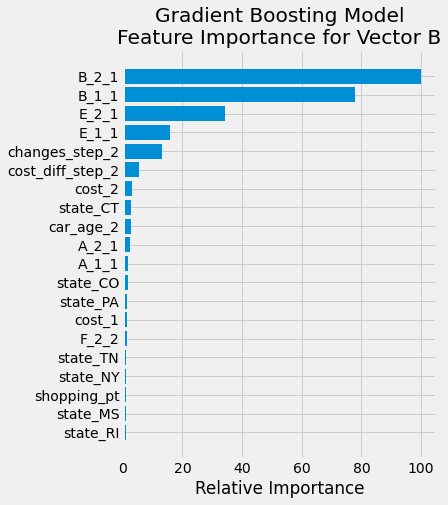

In [202]:
# Now let's train a GB model with above parameters and calculate the different metrics

vector = 'B'
gb_ac, gb_f1, gb_probs, gb_preds = gb_predict_plot(vector, n_estimators = 150, learning_rate = 0.25, max_depth = 3, max_features = 6, plot=True)

fpr_3, tpr_3, thresholds_3 = roc_curve(y_test[vector].astype('int'), gb_probs)


In [327]:
vector = 'B'
score_matrix = model_score_matrix(vector, 2, gb_preds)
score_matrix

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)


Pred_incorrect  Pred_correct  Pred_accuracy_%
cust_changed_vector               2552            34             1.31
cust_maintained_vector              33         12903            99.74

In [328]:
score = model_score_by_shopping_pt("B", 2, gb_preds)
score

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple

B_model_accuracy_%  B_quote2_accuracy_%  model_vs_quote
shopping_pt                                                         
3                         86.42                86.53           -0.11
4                         86.33                86.25            0.08
5                         85.91                86.08           -0.17
6                         84.12                84.28           -0.16
7                         83.62                83.52            0.10
8                         82.28                82.32           -0.04
9                         80.60                80.66           -0.06
10                        79.51                78.99            0.52
11                        80.94                80.35            0.59
12                        67.11                67.11            0.00
13                        87.50                87.50            0.00

In [329]:
#perf_q1q2.update('B', 'no_model', 'overall', acc*100)
perf_q1q2.update('B', 'gb', 'overall', round(gb_ac*100,2))
perf_q1q2.update('B', 'gb', 'customer_type', score_matrix)
perf_q1q2.update('B', 'gb', 'shopping_pt', score)
perf_q1q2.compare('B', 'gb')
perf_q1q2.record['B']

no_model     rf rf_vs_no_model     lr  \
accuracy_overall                   83.34  83.52           0.18  83.35   
accuracy_cust_changed_vector           0   2.86           2.86   0.31   
accuracy_cust_maintained_vector      100  99.64          -0.36  99.95   
accuracy_shopping_pt_3             86.53  86.53            0.0  86.64   
accuracy_shopping_pt_4             86.25  86.33           0.08  86.25   
accuracy_shopping_pt_5             86.08  86.19           0.11  85.97   
accuracy_shopping_pt_6             84.28  84.24          -0.04  84.28   
accuracy_shopping_pt_7             83.52  83.79           0.27  83.49   
accuracy_shopping_pt_8             82.32  82.61           0.29  82.43   
accuracy_shopping_pt_9             80.66  80.60          -0.06  80.60   
accuracy_shopping_pt_10            78.99  80.02           1.03  79.30   
accuracy_shopping_pt_11            80.35  80.65            0.3  80.06   
accuracy_shopping_pt_12            67.11  67.11            0.0  67.11   
accuracy_shopping_pt_13             87.5  87.50            0.0  87.50   

                                lr_vs_no_model     gb gb_vs_no_model  
accuracy_overall                          0.01  83.35           0.01  
accuracy_cust_changed_vector              0.31   1.31           1.31  
accuracy_cust_maintained_vector          -0.05  99.74          -0.26  
accuracy_shopping_pt_3                    0.11  86.42          -0.11  
accuracy_shopping_pt_4                     0.0  86.33           0.08  
accuracy_shopping_pt_5                   -0.11  85.91          -0.17  
accuracy_shopping_pt_6                     0.0  84.12          -0.16  
accuracy_shopping_pt_7                   -0.03  83.62            0.1  
accuracy_shopping_pt_8                    0.11  82.28          -0.04  
accuracy_shopping_pt_9                   -0.06  80.60          -0.06  
accuracy_shopping_pt_10                   0.31  79.51           0.52  
accuracy_shopping_pt_11                  -0.29  80.94           0.59  
accuracy_shopping_pt_12                    0.0  67.11            0.0  
accuracy_shopping_pt_13                    0.0  87.50            0.0

In [32]:
roc_auc3 = auc(fpr_3, tpr_3)
roc_auc3

0.8752734490184578

In [198]:
precision_gb, recall_gb, thresholds_gb = precision_recall_curve(y_test[vector].astype('int'), gb_probs)


In [167]:
# The fourth model that we test is a KNN classifier. Let's use Grid Search to find the best hyperparameter

param_grid = {'n_neighbors': np.arange(1, 50)}
knn = KNeighborsClassifier()

knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print("KNN Model\nBest Score:" + str(knn_cv.best_score_))
print("\nBest Parameters: " + str(knn_cv.best_params_))


KNN Model
Best Score:0.7973584601755658

Best Parameters: {'n_neighbors': 49}


In [175]:

vector = 'B'

kn_ac, kn_f1, kn_probs, kn_preds = knn_predict(vector, n_neighbors=49)

fpr_4, tpr_4, thresholds_4 = roc_curve(y_test[vector].astype('int'), kn_probs)


KNN Model for Vector B: No. of Neighbors = 49
Accuracy = 0.7935, f1-score = 0.7926

Confusion Matrix - normalized
 [[0.8455 0.1545]
 [0.2633 0.7367]]
Confusion Matrix
 [[6845 1251]
 [1955 5471]]

Classification Report 
               precision    recall  f1-score   support

           0       0.78      0.85      0.81      8096
           1       0.81      0.74      0.77      7426

    accuracy                           0.79     15522
   macro avg       0.80      0.79      0.79     15522
weighted avg       0.80      0.79      0.79     15522



In [176]:
vector = 'B'
score_matrix = model_score_matrix(vector, 2, kn_preds)
score_matrix

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/827015121.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/827015121.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)


Pred_incorrect  Pred_correct  Pred_accuracy_%
cust_changed_vector               2415           171         6.612529
cust_maintained_vector             791         12145        93.885281

In [200]:
precision_kn, recall_kn, thresholds_kn = precision_recall_curve(y_test[vector].astype('int'), kn_probs)

In [175]:
vector = 'B'

fpr_1, tpr_1, thresholds_1 = roc_curve(y_test[vector].astype('int'), rf_probs)
roc_auc1 = auc(fpr_1, tpr_1)

fpr_2, tpr_2, thresholds_2 = roc_curve(y_test[vector].astype('int'), xg_probs)
roc_auc2 = auc(fpr_2, tpr_2)

fpr_3, tpr_3, thresholds_3 = roc_curve(y_test[vector].astype('int'), lr_probs)
roc_auc3 = auc(fpr_3, tpr_3)

fpr_4, tpr_4, thresholds_4 = roc_curve(y_test[vector].astype('int'), gb_probs)
roc_auc4 = auc(fpr_4, tpr_4)

roc_auc1, roc_auc2, roc_auc3, roc_auc4

(0.8791002798760683,
 0.8822748084127023,
 0.8707366237522474,
 0.8752734490184578)

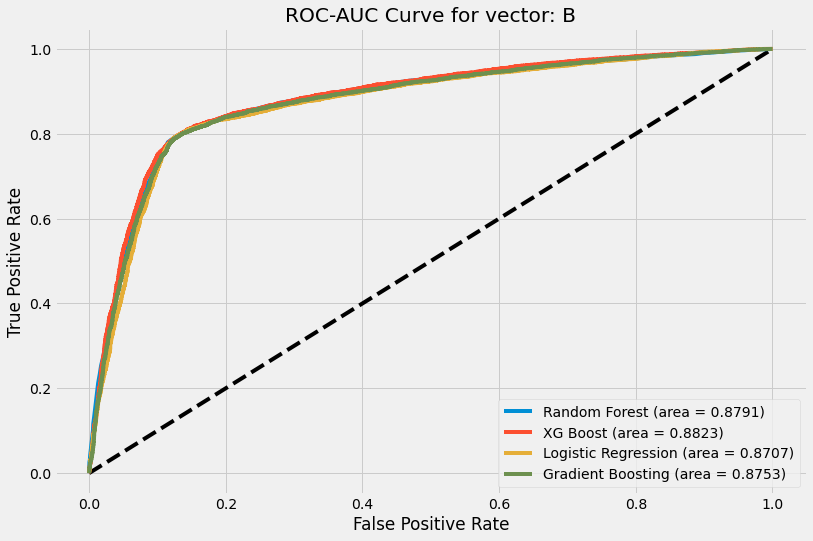

In [176]:

plt.figure(figsize=(12,8))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1, tpr_1, label='Random Forest (area = 0.8791)')
plt.plot(fpr_2, tpr_2, label='XG Boost (area = 0.8823)')
plt.plot(fpr_3, tpr_3, label='Logistic Regression (area = 0.8707)')
plt.plot(fpr_4, tpr_4, label='Gradient Boosting (area = 0.8753)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for vector: '+vector)
plt.legend()
plt.show()


Best Threshold for Random Forest Model = 0.4925
At Best Threshold, tpr = 0.792, fpr = 0.126


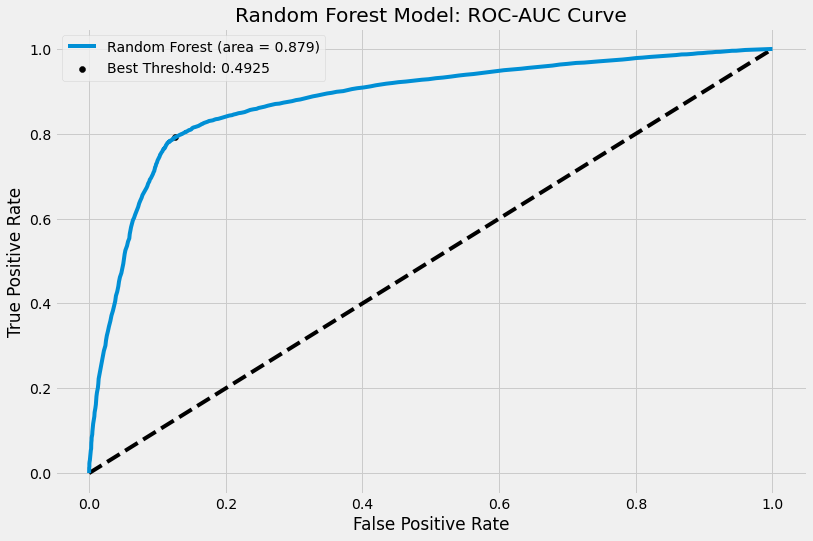

In [237]:
# Let's do thresholding to find the probability threshold that gives the best model performance

plt.figure(figsize=(12,8))

Q_means_rf = np.sqrt(tpr_1*(1-fpr_1))
idx = np.argmax(Q_means_rf)

print(f'Best Threshold for Random Forest Model = {thresholds_1[idx]}')
print(f'At Best Threshold, tpr = {tpr_1[idx]:4.3}, fpr = {fpr_1[idx]:4.3}')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1, tpr_1, label='Random Forest (area = 0.879)')
pyplot.scatter(fpr_1[idx], tpr_1[idx], marker='o', color='black', label='Best Threshold: '+str(thresholds_1[idx]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Model: ROC-AUC Curve')
plt.legend()
plt.show()


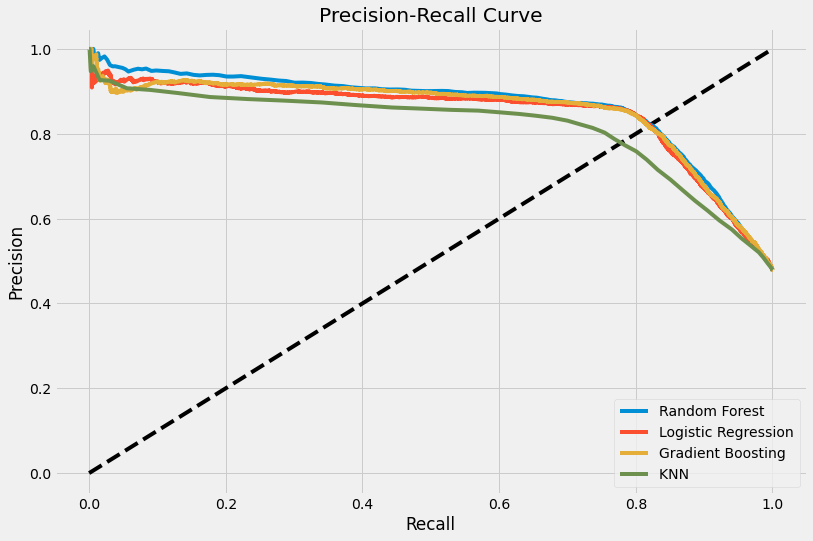

In [230]:
#Let's plot the precision-recall curves for all models

plt.figure(figsize=(12,8))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(recall_rf, precision_rf, label='Random Forest')
plt.plot(recall_lr, precision_lr, label='Logistic Regression')
plt.plot(recall_gb, precision_gb, label='Gradient Boosting')
plt.plot(recall_kn, precision_kn, label='KNN ')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


Vector B Logistic Regression Model
Best Accuracy score of 0.8348 occurs for threshold = 0.423
Vector B Random Forest Model
Best Accuracy score of 0.8352 occurs for threshold = 0.496
Vector B XG Boost Model
Best Accuracy score of 0.835 occurs for threshold = 0.485
Vector B Gradient Boost Model
Best Accuracy score of 0.8337 occurs for threshold = 0.467


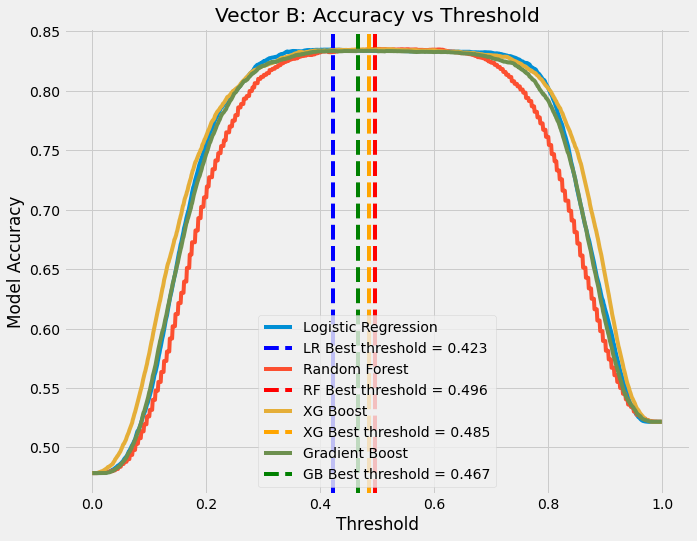

In [204]:
# We are concerned with accuracy of the model i.e. its ability to predict both the 0 and 1 labels correctly
# So we will calculate the accuracy score at different thresholds directly

vector = 'B'
plt.figure(figsize=(10,8))

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

thresholds = np.arange(0, 1, 0.001)

# for LR model
ac_score_lr = [accuracy_score(y_test[vector].astype('int'), to_labels(lr_probs, t)) for t in thresholds]
idx = np.argmax(ac_score_lr)
print(f"Vector {vector} Logistic Regression Model\nBest Accuracy score of {ac_score_lr[idx]:4.4} occurs for threshold = {thresholds[idx]:4.4}")
plt.plot(thresholds, ac_score_lr, label='Logistic Regression')
plt.axvline(thresholds[idx], color='blue', linestyle="--", label = "LR Best threshold = "+str(np.round(thresholds[idx],4)))

# for random forest
thresholds = np.arange(0, 1, 0.001)
ac_score_rf = [accuracy_score(y_test[vector].astype('int'), to_labels(rf_probs, t)) for t in thresholds]
idx = np.argmax(ac_score_rf)
print(f"Vector {vector} Random Forest Model\nBest Accuracy score of {ac_score_rf[idx]:4.4} occurs for threshold = {thresholds[idx]:4.4}")
plt.plot(thresholds, ac_score_rf, label='Random Forest')
plt.axvline(thresholds[idx], color='red', linestyle="--", label = "RF Best threshold = "+str(np.round(thresholds[idx],4)))

# for XG Boost
thresholds = np.arange(0, 1, 0.001)
ac_score_xg = [accuracy_score(y_test[vector].astype('int'), to_labels(xg_probs, t)) for t in thresholds]
idx = np.argmax(ac_score_xg)
print(f"Vector {vector} XG Boost Model\nBest Accuracy score of {ac_score_xg[idx]:4.4} occurs for threshold = {thresholds[idx]:4.4}")
plt.plot(thresholds, ac_score_xg, label='XG Boost')
plt.axvline(thresholds[idx], color='orange', linestyle="--", label = "XG Best threshold = "+str(np.round(thresholds[idx],4)))

# for Gradient Boost
thresholds = np.arange(0, 1, 0.001)
ac_score_gb = [accuracy_score(y_test[vector].astype('int'), to_labels(gb_probs, t)) for t in thresholds]
idx = np.argmax(ac_score_gb)
print(f"Vector {vector} Gradient Boost Model\nBest Accuracy score of {ac_score_gb[idx]:4.4} occurs for threshold = {thresholds[idx]:4.4}")
plt.plot(thresholds, ac_score_gb, label='Gradient Boost')
plt.axvline(thresholds[idx], color='green', linestyle="--", label = "GB Best threshold = "+str(np.round(thresholds[idx],4)))

plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Model Accuracy')
plt.title('Vector B: Accuracy vs Threshold')

plt.show()

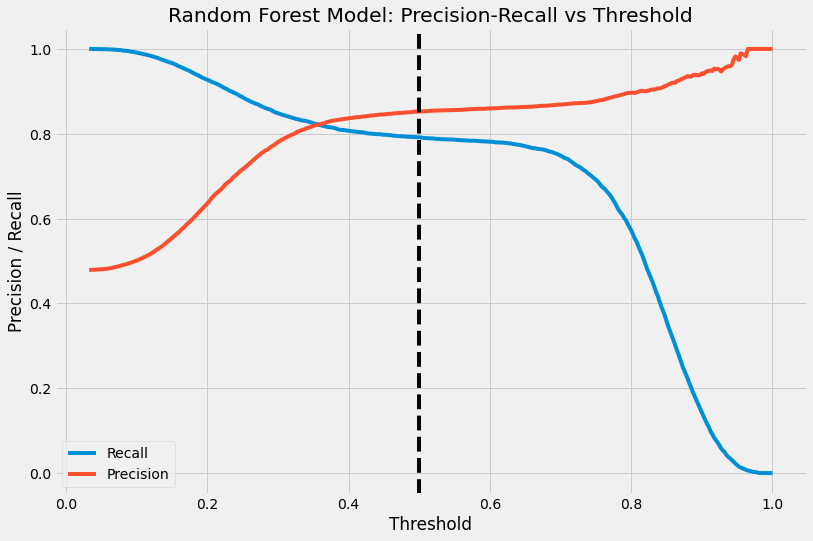

In [216]:
plt.figure(figsize=(12,8))

#plt.plot([0, 1], [0, 1], 'k--')
plt.plot(thresholds_rf, recall_rf, label='Recall')
plt.plot(thresholds_rf, precision_rf, label='Precision')
plt.xlabel('Threshold')
plt.ylabel('Precision / Recall')
plt.title('Random Forest Model: Precision-Recall vs Threshold')
plt.axvline(0.5, color='black', linestyle="--")
plt.legend()
plt.show()


XGBoost Classifier results for Vector B

Parameters: No. of Estimators = 300,  max_depth = 3, learning_rate = 0.35, colsample_bytree = 1

Accuracy=0.834
f1-score=0.833
Confusion Matrix
 [[0.871 0.129]
 [0.207 0.793]]

Classification Report 
               precision    recall  f1-score   support

           0       0.82      0.87      0.85      8096
           1       0.85      0.79      0.82      7426

    accuracy                           0.83     15522
   macro avg       0.84      0.83      0.83     15522
weighted avg       0.83      0.83      0.83     15522

30


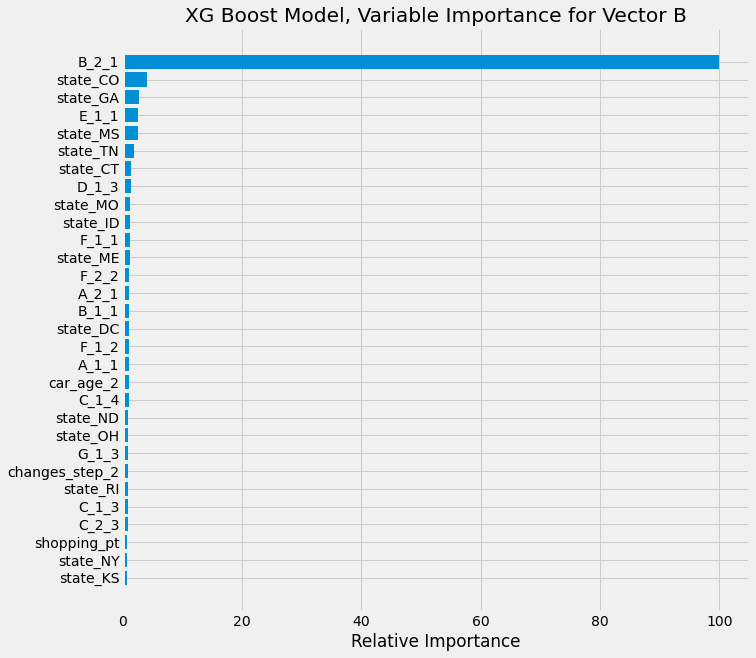

In [61]:

# model B with XGBoost classifier 

vector = 'B'

xg_ac, xg_f1, xg_probs, xg_preds = xg_predict_plot(vector, max_depth=3, n_estimators=300, \
                       learning_rate = 0.35, colsample_bytree = 1, plot = True)

In [8]:
# Let's use RandomizedSearchCV to find the best XGB classifier Hyperparamters for vector B 

import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV

vector = 'B'
param_grid = {'learning_rate' : [0.25, 0.3, 0.35, 0.5], 'n_estimators' : np.arange(100,501,100), \
              'colsample_bytree': [0.15,0.25,0.35,0.5], 'max_depth' : [3,4,5]}
clf = xgb.XGBClassifier(objective='binary:logistic', random_state=1, n_jobs=-1)
clf_cv = RandomizedSearchCV(clf, param_grid, n_iter = 60, verbose = 3, cv=4)
clf_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))
print(f"Vector {vector} RandomizedSearchCV: XG Boosting Model\nBest Score:" + str(clf_cv.best_score_))
print("\nBest Parameters: " + str(clf_cv.best_params_))

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=500;, score=0.836 total time=  10.9s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=500;, score=0.832 total time=  11.8s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=500;, score=0.822 total time=  11.9s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=500;, score=0.830 total time=  12.3s
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=5, n_estimators=300;, score=0.838 total time=  10.1s
[CV 2/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=5, n_estimators=300;, score=0.834 total time=  10.2s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=5, n_estimators=300;, score=0.827 total time=  10.1s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=5, n_estimators=300;, score=0.836 total tim

[CV 2/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=3, n_estimators=200;, score=0.840 total time=   2.9s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=3, n_estimators=200;, score=0.831 total time=   2.9s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=3, n_estimators=200;, score=0.836 total time=   2.9s
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.5, max_depth=4, n_estimators=200;, score=0.839 total time=   3.4s
[CV 2/4] END colsample_bytree=0.25, learning_rate=0.5, max_depth=4, n_estimators=200;, score=0.836 total time=   3.4s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.5, max_depth=4, n_estimators=200;, score=0.829 total time=   3.4s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.5, max_depth=4, n_estimators=200;, score=0.835 total time=   3.4s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=3, n_estimators=200;, score=0.845 total time=   2.5s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.

[CV 4/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=400;, score=0.836 total time=   6.4s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=400;, score=0.844 total time=   7.8s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=400;, score=0.841 total time=   7.9s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=400;, score=0.831 total time=   7.8s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=400;, score=0.838 total time=   7.8s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=3, n_estimators=500;, score=0.844 total time=   6.0s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=3, n_estimators=500;, score=0.841 total time=   5.9s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=3, n_estimators=500;, score=0.830 total time=   6.1s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.

[CV 2/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=3, n_estimators=300;, score=0.840 total time=   3.6s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=3, n_estimators=300;, score=0.832 total time=   3.6s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=3, n_estimators=300;, score=0.837 total time=   3.6s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=500;, score=0.839 total time=  11.9s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=500;, score=0.837 total time=  12.5s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=500;, score=0.827 total time=  13.0s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=500;, score=0.836 total time=  13.9s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=300;, score=0.844 total time=   6.1s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.25, max_d

In [14]:
results = pd.DataFrame(clf_cv.cv_results_['params'])
results['train_score'] = clf_cv.cv_results_['mean_test_score']
results['train_rank'] = clf_cv.cv_results_['rank_test_score']


In [28]:
# model B with XGBoost classifier

# Parameters: No. of Estimators = 100,  max_depth = 3, learning_rate = 0.25, colsample_bytree = 0.5 (0.834, 0.833)
# Parameters: No. of Estimators = 400,  max_depth = 3, learning_rate = 0.3, colsample_bytree = 0.15 (0.834, 0.834)

import xgboost as xgb

vector = 'B'

print(f"XGBoost Classifier results for Vector {vector}\n")
#param_grid
for i, row in results.iterrows():
    n_estimators = row['n_estimators']
    max_depth = row['max_depth']
    learning_rate = row['learning_rate']
    colsample_bytree = row['colsample_bytree']
        
    clf = xgb.XGBClassifier(max_depth=int(max_depth), objective='binary:logistic', n_estimators=int(n_estimators), \
                       learning_rate = learning_rate, colsample_bytree = colsample_bytree, n_jobs=-1, random_state=1)

    clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = clf.predict(X_test.to_numpy())
    y_pred_prob = clf.predict_proba(X_test.to_numpy())
    rf_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
    cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

    results.loc[i, 'test_score'] = ac
    results.loc[i, 'f1_score'] = f1
    
    print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}, \
    learning_rate = {learning_rate}, colsample_bytree = {colsample_bytree}\n")

    print('Accuracy=%.3f' % (ac))
    print('f1-score=%.3f' % (f1))

results = pd.DataFrame(clf_cv.cv_results_['params'])
results['train_score'] = clf_cv.cv_results_['mean_test_score']
results['train_rank'] = clf_cv.cv_results_['rank_test_score']
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
results

XGBoost Classifier results for Vector B

Parameters: No. of Estimators = 500.0,  max_depth = 4.0,     learning_rate = 0.5, colsample_bytree = 0.15

Accuracy=0.829
f1-score=0.829
Parameters: No. of Estimators = 300.0,  max_depth = 5.0,     learning_rate = 0.35, colsample_bytree = 0.25

Accuracy=0.830
f1-score=0.830
Parameters: No. of Estimators = 100.0,  max_depth = 5.0,     learning_rate = 0.5, colsample_bytree = 0.5

Accuracy=0.833
f1-score=0.832
Parameters: No. of Estimators = 200.0,  max_depth = 4.0,     learning_rate = 0.3, colsample_bytree = 0.25

Accuracy=0.834
f1-score=0.833
Parameters: No. of Estimators = 200.0,  max_depth = 3.0,     learning_rate = 0.3, colsample_bytree = 0.25

Accuracy=0.834
f1-score=0.834
Parameters: No. of Estimators = 400.0,  max_depth = 3.0,     learning_rate = 0.35, colsample_bytree = 0.15

Accuracy=0.834
f1-score=0.834
Parameters: No. of Estimators = 500.0,  max_depth = 4.0,     learning_rate = 0.3, colsample_bytree = 0.15

Accuracy=0.833
f1-score=0.833

In [33]:
results = pd.DataFrame(clf_cv.cv_results_['params'])
results['train_score'] = clf_cv.cv_results_['mean_test_score']
results['train_rank'] = clf_cv.cv_results_['rank_test_score']
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
results

n_estimators  max_depth  learning_rate  colsample_bytree  train_score  \
0            500          4           0.50              0.15     0.830055   
1            300          5           0.35              0.25     0.833518   
2            100          5           0.50              0.50     0.835178   
3            200          4           0.30              0.25     0.837851   
4            200          3           0.30              0.25     0.838512   
5            400          3           0.35              0.15     0.837658   
6            500          4           0.30              0.15     0.835757   
7            100          5           0.25              0.50     0.838447   
8            300          4           0.25              0.25     0.837722   
9            100          5           0.50              0.25     0.835145   
10           400          4           0.50              0.25     0.830974   
11           200          5           0.50              0.15     0.832230   
12           400          5           0.50              0.25     0.824112   
13           500          5           0.25              0.50     0.831988   
14           200          5           0.30              0.25     0.836820   
15           100          4           0.35              0.25     0.838399   
16           100          3           0.50              0.50     0.837787   
17           200          3           0.35              0.25     0.837867   
18           200          4           0.50              0.25     0.834839   
19           200          3           0.25              0.15     0.838802   
20           200          3           0.50              0.15     0.838302   
21           100          4           0.30              0.25     0.838737   
22           200          3           0.25              0.35     0.838753   
23           100          5           0.35              0.25     0.837722   
24           200          5           0.25              0.25     0.837465   
25           300          4           0.25              0.50     0.837755   
26           200          5           0.35              0.15     0.836160   
27           500          3           0.50              0.25     0.834726   
28           200          4           0.35              0.25     0.836933   
29           500          5           0.25              0.25     0.834614   
30           400          4           0.50              0.15     0.831892   
31           300          4           0.50              0.15     0.833921   
32           300          5           0.30              0.50     0.833470   
33           300          3           0.50              0.15     0.836837   
34           400          3           0.35              0.35     0.836885   
35           400          3           0.25              0.50     0.838447   
36           500          3           0.25              0.15     0.838189   
37           200          4           0.35              0.50     0.836708   
38           300          4           0.30              0.25     0.836837   
39           200          5           0.50              0.35     0.830072   
40           400          4           0.50              0.35     0.829717   
41           400          5           0.35              0.35     0.830925   
42           100          4           0.25              0.35     0.838850   
43           300          4           0.25              0.15     0.838045   
44           100          4           0.30              0.35     0.838898   
45           400          5           0.35              0.15     0.833712   
46           300          5           0.30              0.35     0.835081   
47           400          3           0.50              0.15     0.836579   
48           300          3           0.30              0.35     0.838077   
49           200          3           0.25              0.50     0.839075   
50           500          3           0.25              0.50     0.837964   


In [34]:
datapath = "Modelling_data"

save_file(results, 'xgboost_results_vectorB.csv', datapath)


Directory Modelling_data was created.
Writing file.  "Modelling_data\xgboost_results_vectorB.csv"


XGBoost Classifier results for Vector B
Parameters: No. of Estimators = 100,  max_depth = 4,     learning_rate = 0.3, colsample_bytree = 0.35
Accuracy=0.8348, f1-score=0.8344
Confusion Matrix - normalized
 [[0.8745 0.1255]
 [0.2085 0.7915]]
Confusion Matrix
 [[7080 1016]
 [1548 5878]]

Classification Report 
               precision    recall  f1-score   support

           0       0.82      0.87      0.85      8096
           1       0.85      0.79      0.82      7426

    accuracy                           0.83     15522
   macro avg       0.84      0.83      0.83     15522
weighted avg       0.84      0.83      0.83     15522

20


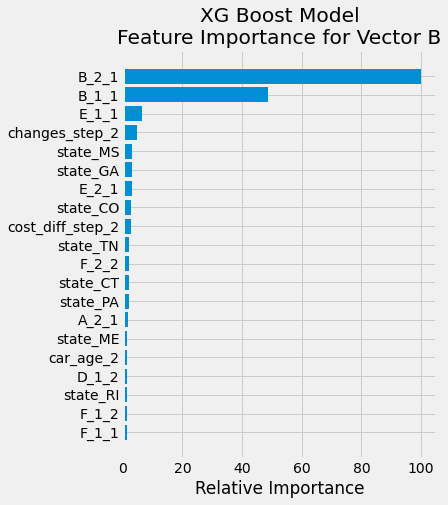

In [203]:
# model B with XGBoost classifier BEST Hyperparameters (Iteration 44)

vector = 'B'

xg_ac, xg_f1, xg_probs, xg_preds = xg_predict_plot(vector, max_depth=4, n_estimators=100, \
                       learning_rate = 0.3, colsample_bytree = 0.35, plot = True)

In [331]:
vector = 'B'
score_matrix = model_score_matrix(vector, 2, xg_preds)
score_matrix

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)


Pred_incorrect  Pred_correct  Pred_accuracy_%
cust_changed_vector               2502            84             3.25
cust_maintained_vector              62         12874            99.52

In [332]:
score = model_score_by_shopping_pt("B", 2, xg_preds)
score

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple

B_model_accuracy_%  B_quote2_accuracy_%  model_vs_quote
shopping_pt                                                         
3                         86.31                86.53           -0.22
4                         86.41                86.25            0.16
5                         86.08                86.08            0.00
6                         84.32                84.28            0.04
7                         83.66                83.52            0.14
8                         82.64                82.32            0.32
9                         80.45                80.66           -0.21
10                        80.02                78.99            1.03
11                        80.94                80.35            0.59
12                        67.11                67.11            0.00
13                        87.50                87.50            0.00

In [333]:
#perf_q1q2.update('B', 'no_model', 'overall', acc*100)
perf_q1q2.update('B', 'xg', 'overall', round(xg_ac*100,2))
perf_q1q2.update('B', 'xg', 'customer_type', score_matrix)
perf_q1q2.update('B', 'xg', 'shopping_pt', score)
perf_q1q2.compare('B', 'xg')
perf_q1q2.record['B']

no_model     rf rf_vs_no_model     lr  \
accuracy_overall                   83.34  83.52           0.18  83.35   
accuracy_cust_changed_vector           0   2.86           2.86   0.31   
accuracy_cust_maintained_vector      100  99.64          -0.36  99.95   
accuracy_shopping_pt_3             86.53  86.53            0.0  86.64   
accuracy_shopping_pt_4             86.25  86.33           0.08  86.25   
accuracy_shopping_pt_5             86.08  86.19           0.11  85.97   
accuracy_shopping_pt_6             84.28  84.24          -0.04  84.28   
accuracy_shopping_pt_7             83.52  83.79           0.27  83.49   
accuracy_shopping_pt_8             82.32  82.61           0.29  82.43   
accuracy_shopping_pt_9             80.66  80.60          -0.06  80.60   
accuracy_shopping_pt_10            78.99  80.02           1.03  79.30   
accuracy_shopping_pt_11            80.35  80.65            0.3  80.06   
accuracy_shopping_pt_12            67.11  67.11            0.0  67.11   
accuracy_shopping_pt_13             87.5  87.50            0.0  87.50   

                                lr_vs_no_model     gb gb_vs_no_model     xg  \
accuracy_overall                          0.01  83.35           0.01  83.48   
accuracy_cust_changed_vector              0.31   1.31           1.31   3.25   
accuracy_cust_maintained_vector          -0.05  99.74          -0.26  99.52   
accuracy_shopping_pt_3                    0.11  86.42          -0.11  86.31   
accuracy_shopping_pt_4                     0.0  86.33           0.08  86.41   
accuracy_shopping_pt_5                   -0.11  85.91          -0.17  86.08   
accuracy_shopping_pt_6                     0.0  84.12          -0.16  84.32   
accuracy_shopping_pt_7                   -0.03  83.62            0.1  83.66   
accuracy_shopping_pt_8                    0.11  82.28          -0.04  82.64   
accuracy_shopping_pt_9                   -0.06  80.60          -0.06  80.45   
accuracy_shopping_pt_10                   0.31  79.51           0.52  80.02   
accuracy_shopping_pt_11                  -0.29  80.94           0.59  80.94   
accuracy_shopping_pt_12                    0.0  67.11            0.0  67.11   
accuracy_shopping_pt_13                    0.0  87.50            0.0  87.50   

                                xg_vs_no_model  
accuracy_overall                          0.14  
accuracy_cust_changed_vector              3.25  
accuracy_cust_maintained_vector          -0.48  
accuracy_shopping_pt_3                   -0.22  
accuracy_shopping_pt_4                    0.16  
accuracy_shopping_pt_5                     0.0  
accuracy_shopping_pt_6                    0.04  
accuracy_shopping_pt_7                    0.14  
accuracy_shopping_pt_8                    0.32  
accuracy_shopping_pt_9                   -0.21  
accuracy_shopping_pt_10                   1.03  
accuracy_shopping_pt_11                   0.59  
accuracy_shopping_pt_12                    0.0  
accuracy_shopping_pt_13                    0.0

C:\Users\amite\AppData\Local\Temp/ipykernel_13712/441207066.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels)
C:\Users\amite\AppData\Local\Temp/ipykernel_13712/441207066.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels)


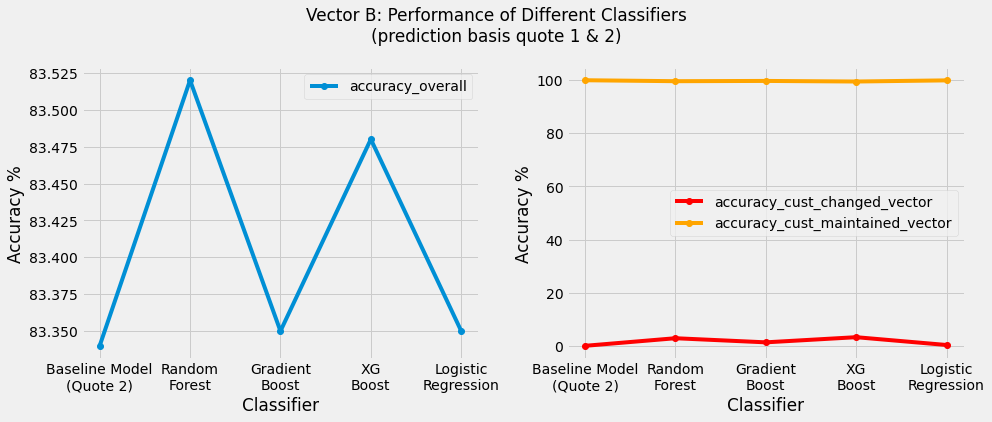

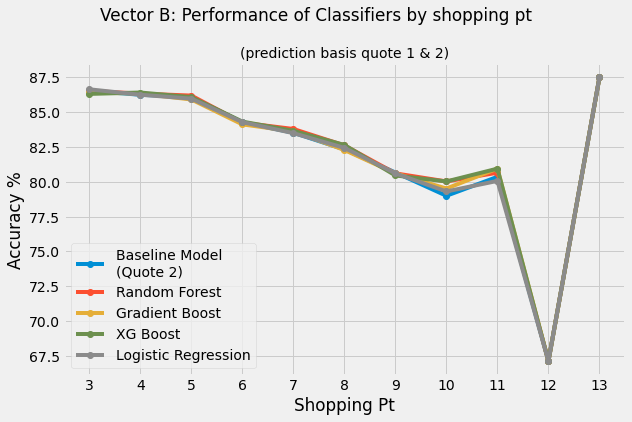

In [116]:
vector = 'B'
models = ['no_model', 'rf', 'gb', 'xg', 'lr']
#models = ['no_model', 'rf', 'gb', 'xg']
quotes = [1,2]
model_performance_plot(vector, models, quotes, perf_models_q1q2,"overall")
model_performance_plot(vector, models, quotes, perf_models_q1q2,"shopping_pt")

### Vector G: Training Models<a id='Phase1_step3.2'></a>

Random Forest Classifier results for Vector G
Parameters: No. of Estimators = 300,  min_samples_leaf = 1,     min_samples_split = 2
Accuracy=0.758, f1-score=0.7577
Confusion Matrix - normalized
 [[0.7171 0.2315 0.0376 0.0138]
 [0.1178 0.8176 0.0423 0.0223]
 [0.0538 0.1362 0.7665 0.0435]
 [0.0643 0.1791 0.2116 0.545 ]]
Confusion Matrix
 [[2286  738  120   44]
 [ 718 4985  258  136]
 [ 266  674 3792  215]
 [  83  231  273  703]]

Classification Report 
               precision    recall  f1-score   support

           0       0.68      0.72      0.70      3188
           1       0.75      0.82      0.78      6097
           2       0.85      0.77      0.81      4947
           3       0.64      0.54      0.59      1290

    accuracy                           0.76     15522
   macro avg       0.73      0.71      0.72     15522
weighted avg       0.76      0.76      0.76     15522

30


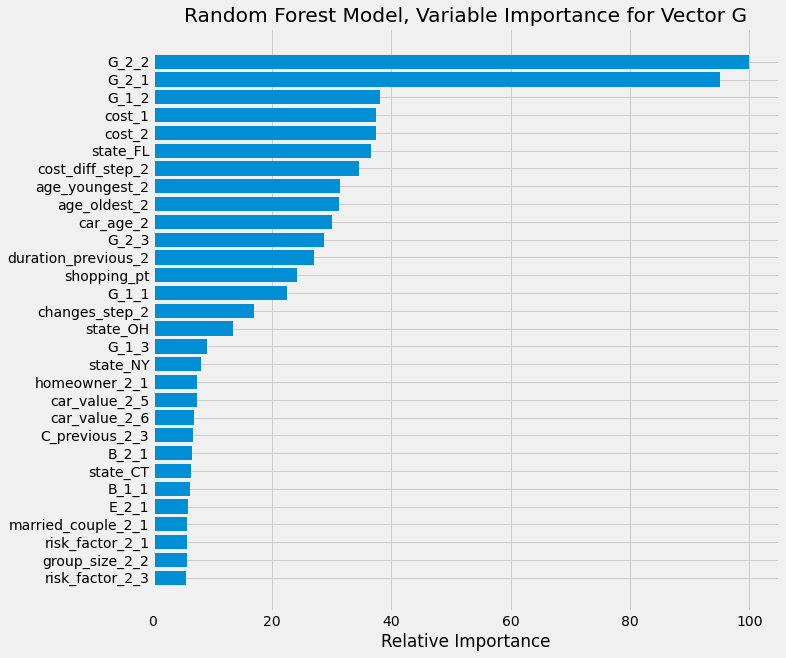

In [337]:
# Let's run A Random Forest model for vector G

vector = 'G'

rf_ac, rf_f1, rf_probs, rf_preds = rf_predict_plot(vector, plot=True)


In [334]:
#test_set = df_train_first2.iloc[y_test.index,:]

vector = 'G'

x = pd.crosstab(test_set['G'], test_set['G_2'])

same_as_2 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 

acc = np.around(np.sum(same_as_2)/y_test.shape[0],4)

print(f"Accuracy based on simply predicting vector {vector} = {vector}_2 : {(np.sum(same_as_2)/y_test.shape[0]): 4.4}")

Accuracy based on simply predicting vector G = G_2 :  0.7405


In [311]:
x['total'] = x.sum(axis=1)
x['G1_%'] = np.around(x[1]*100 / x['total'], 2)
x['G2_%'] = np.around(x[2]*100 / x['total'], 2)
x['G3_%'] = np.around(x[3]*100 / x['total'], 2)
x['G4_%'] = np.around(x[4]*100 / x['total'], 2)

x

G_2     1     2     3    4  total   G1_%   G2_%   G3_%   G4_%
G                                                            
1    2239   711   115  123   3188  70.23  22.30   3.61   3.86
2     717  4873   230  277   6097  11.76  79.92   3.77   4.54
3     271   778  3587  311   4947   5.48  15.73  72.51   6.29
4      78   200   217  795   1290   6.05  15.50  16.82  61.63

In [10]:
# Let's use Bayesian Optimization to find best parameters for Random Forest model for vector G
from bayes_opt import BayesianOptimization

vector = 'G'

def rf_eval(estimators, min_leaf, min_split):
    
    rf = RandomForestClassifier(n_estimators = round(estimators), min_samples_leaf = round(min_leaf), \
                                    min_samples_split = round(min_split), random_state = 1, n_jobs=-1)
    
    cv_result = cross_validate(rf, X_train.to_numpy(), y_train[vector].astype('int'), cv= 4)
    return np.mean(cv_result['test_score'])

rf_bo = BayesianOptimization(rf_eval, {'estimators': (20, 1000), 'min_leaf': (1, 5), 'min_split': (2, 6)})
rf_bo.maximize(n_iter=13, init_points=2)

|   iter    |  target   | estima... | min_leaf  | min_split |
-------------------------------------------------------------
|  1        |  0.7637   |  980.2    |  4.41     |  2.007    |
|  2        |  0.7635   |  813.3    |  4.254    |  5.076    |
|  3        |  0.7637   |  981.2    |  4.008    |  2.714    |
|  4        |  0.7637   |  969.2    |  4.237    |  2.307    |
|  5        |  0.7636   |  949.4    |  4.294    |  2.335    |
|  6        |  0.7628   |  49.93    |  3.636    |  4.438    |
|  7        |  0.7635   |  640.7    |  3.804    |  2.048    |
|  8        |  0.7639   |  540.6    |  1.258    |  5.379    |
|  9        |  0.7638   |  496.5    |  4.248    |  5.125    |
|  10       |  0.7636   |  578.9    |  4.287    |  3.231    |
|  11       |  0.7641   |  417.9    |  2.296    |  2.558    |
|  12       |  0.7639   |  379.6    |  1.503    |  4.101    |
|  13       |  0.7644   |  447.3    |  1.129    |  5.617    |
|  14       |  0.7635   |  298.6    |  2.63     |  5.993    |
|  15   

Random Forest Classifier results for Vector G
Parameters: No. of Estimators = 450,  min_samples_leaf = 1,     min_samples_split = 6
Accuracy=0.7568, f1-score=0.7565
Confusion Matrix - normalized
 [[0.7142 0.2343 0.037  0.0144]
 [0.1173 0.8181 0.0418 0.0228]
 [0.0534 0.1381 0.7641 0.0445]
 [0.0667 0.1798 0.2093 0.5442]]
Confusion Matrix
 [[2277  747  118   46]
 [ 715 4988  255  139]
 [ 264  683 3780  220]
 [  86  232  270  702]]

Classification Report 
               precision    recall  f1-score   support

           0       0.68      0.71      0.70      3188
           1       0.75      0.82      0.78      6097
           2       0.85      0.76      0.81      4947
           3       0.63      0.54      0.59      1290

    accuracy                           0.76     15522
   macro avg       0.73      0.71      0.72     15522
weighted avg       0.76      0.76      0.76     15522

30


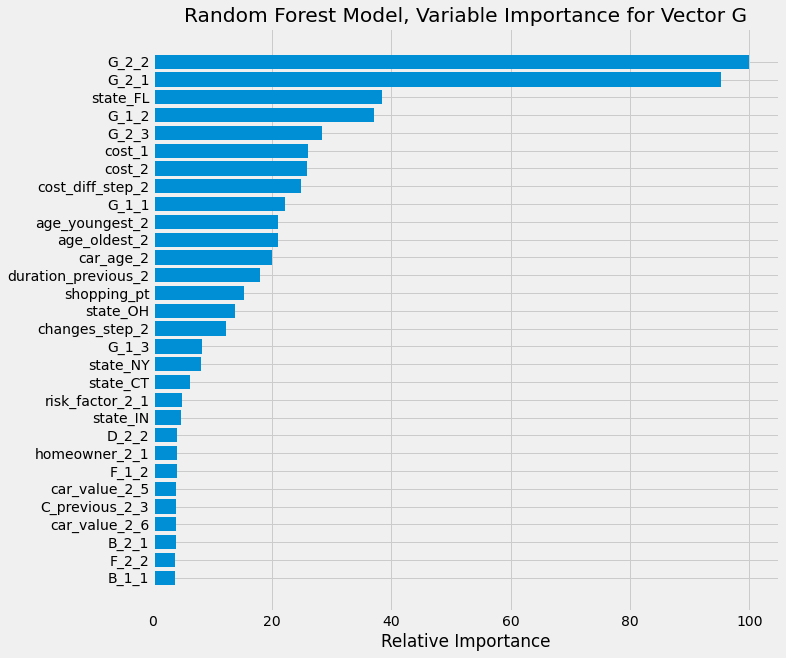

In [177]:
# Run the model with Best Parameters (iteration 13): n_estimators=450, min_samples_leaf = 1, min_samples_split = 6

vector = 'G'

rf_ac, rf_f1, rf_probs, rf_preds = rf_predict_plot(vector, n_estimators=450, min_samples_leaf = 1, min_samples_split = 6, plot=True)



Random Forest Classifier results for Vector G

Parameters: No. of Estimators = 420,  min_samples_split = 3, min_samples_leaf = 2

Accuracy=0.757
f1-score=0.757
Confusion Matrix
 [[0.715 0.234 0.037 0.014]
 [0.117 0.819 0.041 0.022]
 [0.053 0.138 0.765 0.044]
 [0.067 0.184 0.209 0.54 ]]

Classification Report 
               precision    recall  f1-score   support

           1       0.68      0.72      0.70      3188
           2       0.75      0.82      0.78      6097
           3       0.86      0.76      0.81      4947
           4       0.63      0.54      0.58      1290

    accuracy                           0.76     15522
   macro avg       0.73      0.71      0.72     15522
weighted avg       0.76      0.76      0.76     15522

30


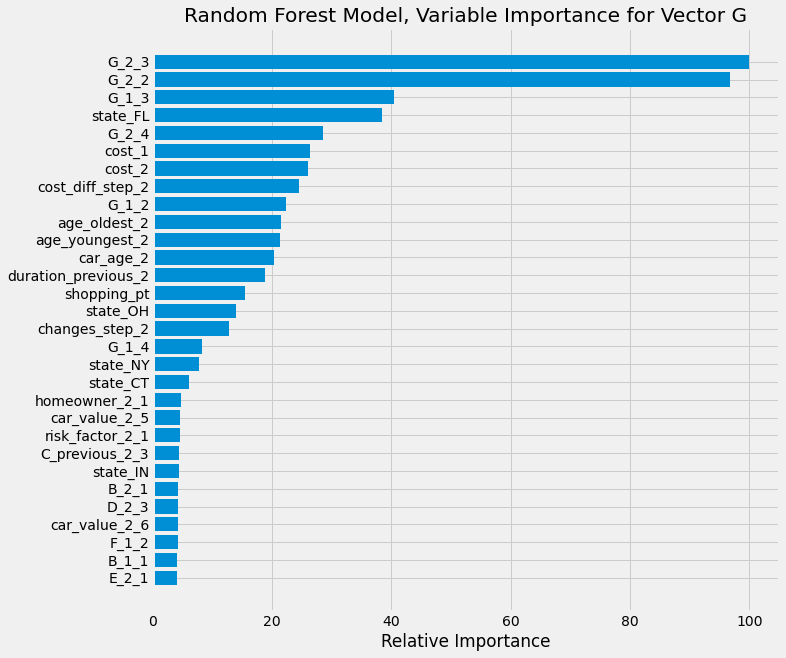

In [13]:
# Run the model with 2nd Best Parameters (iteration 11): n_estimators=420, min_samples_leaf = 2, min_samples_split = 3

vector = 'G'

rf_ac, rf_f1, rf_probs, rf_preds = rf_predict_plot(vector, n_estimators=420, min_samples_leaf = 2, min_samples_split = 3, plot=True)


Random Forest Classifier results for Vector G
Parameters: No. of Estimators = 550,  min_samples_leaf = 1,     min_samples_split = 5
Accuracy=0.7583, f1-score=0.7579
Confusion Matrix - normalized
 [[0.7164 0.2324 0.0367 0.0144]
 [0.1169 0.8197 0.0412 0.0221]
 [0.0532 0.1366 0.7651 0.0451]
 [0.0682 0.1775 0.2093 0.545 ]]
Confusion Matrix
 [[2284  741  117   46]
 [ 713 4998  251  135]
 [ 263  676 3785  223]
 [  88  229  270  703]]

Classification Report 
               precision    recall  f1-score   support

           0       0.68      0.72      0.70      3188
           1       0.75      0.82      0.78      6097
           2       0.86      0.77      0.81      4947
           3       0.64      0.54      0.59      1290

    accuracy                           0.76     15522
   macro avg       0.73      0.71      0.72     15522
weighted avg       0.76      0.76      0.76     15522

30


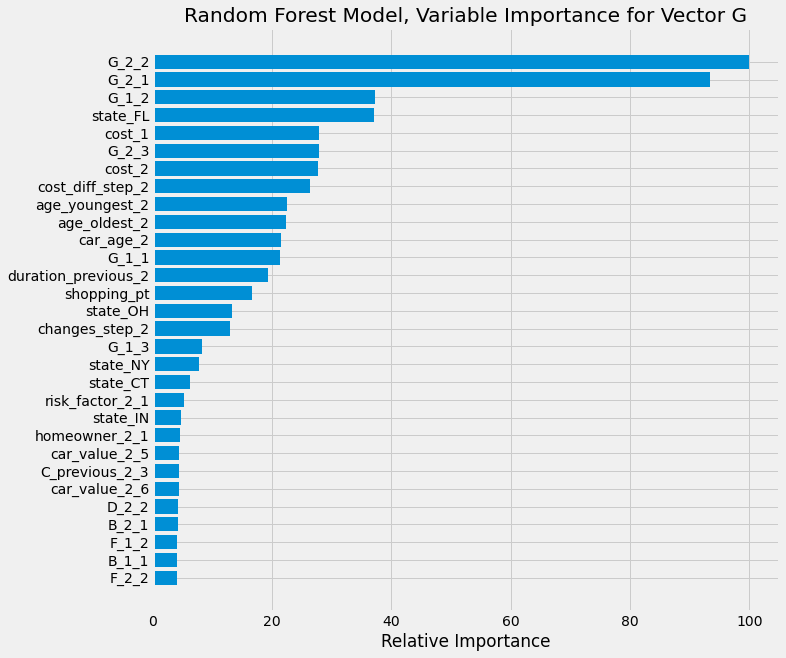

In [335]:
# Run the model with 3rd Best Parameters (iteration 8): n_estimators=550, min_samples_leaf = 1, min_samples_split = 5

vector = 'G'

rf_ac, rf_f1, rf_probs, rf_preds = rf_predict_plot(vector, n_estimators=550, min_samples_leaf = 1, min_samples_split = 5, plot=True)



Using the hyperparameters from Bayesian Optimization, the best score (accuracy = 0.758, f1_score = 0.758) is still only as good as the base model with 300 estimators. So we shall keep the base model as it has lesser estimators and hence would use less computational resources. 

Now let's build a Gradient Boosting Classifier for Vector G.

In [338]:
vector = 'G'
score_matrix = model_score_matrix(vector, 2, rf_preds)
score_matrix

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)


Pred_incorrect  Pred_correct  Pred_accuracy_%
cust_changed_vector               3584           444            11.02
cust_maintained_vector             172         11322            98.50

In [339]:
score = model_score_by_shopping_pt("G", 2, rf_preds)
score

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple

G_model_accuracy_%  G_quote2_accuracy_%  model_vs_quote
shopping_pt                                                         
3                         78.00                76.88            1.12
4                         78.83                78.28            0.55
5                         77.43                76.59            0.84
6                         76.48                75.60            0.88
7                         74.34                72.23            2.11
8                         75.51                72.97            2.54
9                         74.66                72.89            1.77
10                        71.16                67.66            3.50
11                        78.30                74.49            3.81
12                        82.89                77.63            5.26
13                        75.00                75.00            0.00

In [340]:
perf_q1q2.update('G', 'no_model', 'overall', acc*100)
perf_q1q2.update('G', 'rf', 'overall', round(rf_ac*100,2))
perf_q1q2.update('G', 'rf', 'customer_type', score_matrix)
perf_q1q2.update('G', 'rf', 'shopping_pt', score)
perf_q1q2.compare('G', 'rf')
perf_q1q2.record['G']

no_model     rf rf_vs_no_model
accuracy_overall                   74.05  75.80           1.75
accuracy_cust_changed_vector           0  11.02          11.02
accuracy_cust_maintained_vector      100  98.50           -1.5
accuracy_shopping_pt_3             76.88  78.00           1.12
accuracy_shopping_pt_4             78.28  78.83           0.55
accuracy_shopping_pt_5             76.59  77.43           0.84
accuracy_shopping_pt_6              75.6  76.48           0.88
accuracy_shopping_pt_7             72.23  74.34           2.11
accuracy_shopping_pt_8             72.97  75.51           2.54
accuracy_shopping_pt_9             72.89  74.66           1.77
accuracy_shopping_pt_10            67.66  71.16            3.5
accuracy_shopping_pt_11            74.49  78.30           3.81
accuracy_shopping_pt_12            77.63  82.89           5.26
accuracy_shopping_pt_13             75.0  75.00            0.0

Gradient Boosting Classifier results for Vector G

Accuracy=0.753
f1-score=0.752
Confusion Matrix
 [[0.705 0.24  0.039 0.017]
 [0.117 0.816 0.045 0.022]
 [0.054 0.136 0.766 0.043]
 [0.071 0.186 0.216 0.526]]

Classification Report 
               precision    recall  f1-score   support

           1       0.68      0.70      0.69      3188
           2       0.75      0.82      0.78      6097
           3       0.85      0.77      0.81      4947
           4       0.63      0.53      0.57      1290

    accuracy                           0.75     15522
   macro avg       0.73      0.70      0.71     15522
weighted avg       0.76      0.75      0.75     15522



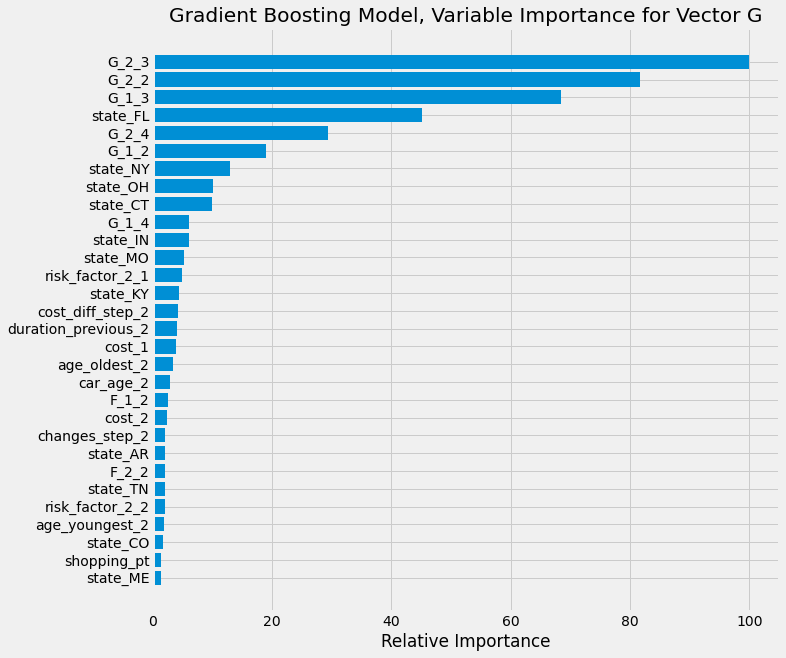

In [319]:
# model G with GradientBoosting classifier

vector = 'G'

gb_ac, gb_f1, gb_probs, gb_preds = gb_predict_plot(vector, n_estimators = 150, learning_rate = 0.25, max_depth = 3, max_features = 6, plot=True)


In [320]:
# Let's use RandomizedSearchCV to find the best GradientBoosting classifier Hyperparamters for vector G 

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

vector = 'G'
param_grid = {'learning_rate' : [0.05, 0.1, 0.25, 0.5, 0.75, 1], 'n_estimators' : [20, 50, 100, 150, 200], \
              'max_features': [2,4,6,8], 'max_depth' : [1,2,3,4]}
gb = GradientBoostingClassifier(random_state = 1)
gb_cv = RandomizedSearchCV(gb, param_grid, n_iter = 60, verbose = 2, cv=5)
gb_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))
print(f"Vector {vector} RandomizedSearchCV: Gradient Boosting Model\nBest Score:" + str(gb_cv.best_score_))
print("\nBest Parameters: " + str(gb_cv.best_params_))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END learning_rate=0.25, max_depth=2, max_features=4, n_estimators=20; total time=   3.9s
[CV] END learning_rate=0.25, max_depth=2, max_features=4, n_estimators=20; total time=   3.4s
[CV] END learning_rate=0.25, max_depth=2, max_features=4, n_estimators=20; total time=   3.2s
[CV] END learning_rate=0.25, max_depth=2, max_features=4, n_estimators=20; total time=   3.3s
[CV] END learning_rate=0.25, max_depth=2, max_features=4, n_estimators=20; total time=   3.3s
[CV] END learning_rate=0.05, max_depth=3, max_features=4, n_estimators=20; total time=   3.9s
[CV] END learning_rate=0.05, max_depth=3, max_features=4, n_estimators=20; total time=   5.3s
[CV] END learning_rate=0.05, max_depth=3, max_features=4, n_estimators=20; total time=   4.0s
[CV] END learning_rate=0.05, max_depth=3, max_features=4, n_estimators=20; total time=   3.9s
[CV] END learning_rate=0.05, max_depth=3, max_features=4, n_estimators=20; total time=   4.2

[CV] END learning_rate=0.75, max_depth=4, max_features=2, n_estimators=50; total time=   9.0s
[CV] END learning_rate=0.75, max_depth=4, max_features=2, n_estimators=50; total time=   9.1s
[CV] END learning_rate=0.75, max_depth=4, max_features=2, n_estimators=50; total time=   8.8s
[CV] END learning_rate=0.75, max_depth=3, max_features=2, n_estimators=100; total time=  15.7s
[CV] END learning_rate=0.75, max_depth=3, max_features=2, n_estimators=100; total time=  15.6s
[CV] END learning_rate=0.75, max_depth=3, max_features=2, n_estimators=100; total time=  15.6s
[CV] END learning_rate=0.75, max_depth=3, max_features=2, n_estimators=100; total time=  15.7s
[CV] END learning_rate=0.75, max_depth=3, max_features=2, n_estimators=100; total time=  15.8s
[CV] END learning_rate=1, max_depth=3, max_features=6, n_estimators=50; total time=  11.9s
[CV] END learning_rate=1, max_depth=3, max_features=6, n_estimators=50; total time=  11.7s
[CV] END learning_rate=1, max_depth=3, max_features=6, n_esti

[CV] END learning_rate=0.5, max_depth=2, max_features=8, n_estimators=20; total time=   4.5s
[CV] END learning_rate=0.5, max_depth=2, max_features=8, n_estimators=20; total time=   4.3s
[CV] END learning_rate=0.5, max_depth=2, max_features=8, n_estimators=20; total time=   4.2s
[CV] END learning_rate=0.5, max_depth=2, max_features=8, n_estimators=20; total time=   4.3s
[CV] END learning_rate=0.5, max_depth=2, max_features=8, n_estimators=20; total time=   4.4s
[CV] END learning_rate=0.05, max_depth=4, max_features=8, n_estimators=100; total time=  33.5s
[CV] END learning_rate=0.05, max_depth=4, max_features=8, n_estimators=100; total time=  33.7s
[CV] END learning_rate=0.05, max_depth=4, max_features=8, n_estimators=100; total time=  33.5s
[CV] END learning_rate=0.05, max_depth=4, max_features=8, n_estimators=100; total time=  33.3s
[CV] END learning_rate=0.05, max_depth=4, max_features=8, n_estimators=100; total time=  33.8s
[CV] END learning_rate=0.05, max_depth=2, max_features=8, n_

[CV] END learning_rate=0.25, max_depth=3, max_features=6, n_estimators=100; total time=  23.8s
[CV] END learning_rate=0.25, max_depth=3, max_features=6, n_estimators=100; total time=  23.7s
[CV] END learning_rate=1, max_depth=2, max_features=6, n_estimators=50; total time=   9.5s
[CV] END learning_rate=1, max_depth=2, max_features=6, n_estimators=50; total time=   9.4s
[CV] END learning_rate=1, max_depth=2, max_features=6, n_estimators=50; total time=   9.4s
[CV] END learning_rate=1, max_depth=2, max_features=6, n_estimators=50; total time=   9.3s
[CV] END learning_rate=1, max_depth=2, max_features=6, n_estimators=50; total time=   9.4s
[CV] END learning_rate=0.5, max_depth=1, max_features=6, n_estimators=20; total time=   2.7s
[CV] END learning_rate=0.5, max_depth=1, max_features=6, n_estimators=20; total time=   2.7s
[CV] END learning_rate=0.5, max_depth=1, max_features=6, n_estimators=20; total time=   2.7s
[CV] END learning_rate=0.5, max_depth=1, max_features=6, n_estimators=20; to

Gradient Boosting Classifier results for Vector G

Accuracy=0.756
f1-score=0.755
Confusion Matrix
 [[0.713 0.234 0.038 0.014]
 [0.119 0.817 0.045 0.02 ]
 [0.053 0.136 0.771 0.04 ]
 [0.07  0.191 0.226 0.513]]

Classification Report 
               precision    recall  f1-score   support

           1       0.68      0.71      0.70      3188
           2       0.75      0.82      0.78      6097
           3       0.85      0.77      0.81      4947
           4       0.65      0.51      0.57      1290

    accuracy                           0.76     15522
   macro avg       0.73      0.70      0.71     15522
weighted avg       0.76      0.76      0.75     15522



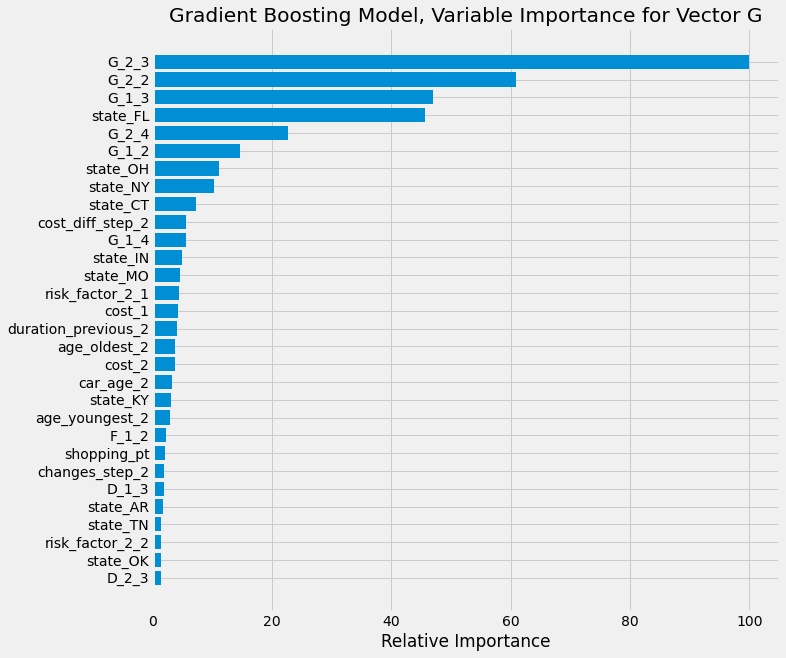

In [321]:
# GradientBoosting classifier for G with best Hyperparameters {'n_estimators': 200, 
# 'max_features': 6, 'max_depth': 4, 'learning_rate': 0.25}

vector = 'G'

gb_ac, gb_f1, gb_probs, gb_preds = gb_predict_plot(vector, n_estimators = 200, learning_rate = 0.25, max_depth = 4, max_features = 6, plot=True)


This model improves performance over the base GB model, but is still not as good as the Random Forest model. Let's manually tweak a couple of parameters and check the performance.

Gradient Boosting Classifier results for Vector G
Parameters: No. of Estimators = 200,  max_depth = 3,     learning_rate = 0.25, max_features = 8
Accuracy=0.7567, f1-score=0.7561
Confusion Matrix - normalized
 [[0.7105 0.2346 0.0389 0.016 ]
 [0.1166 0.8179 0.0438 0.0216]
 [0.0532 0.1366 0.7698 0.0404]
 [0.0682 0.1853 0.2147 0.5318]]
Confusion Matrix
 [[2265  748  124   51]
 [ 711 4987  267  132]
 [ 263  676 3808  200]
 [  88  239  277  686]]

Classification Report 
               precision    recall  f1-score   support

           0       0.68      0.71      0.70      3188
           1       0.75      0.82      0.78      6097
           2       0.85      0.77      0.81      4947
           3       0.64      0.53      0.58      1290

    accuracy                           0.76     15522
   macro avg       0.73      0.71      0.72     15522
weighted avg       0.76      0.76      0.76     15522

30


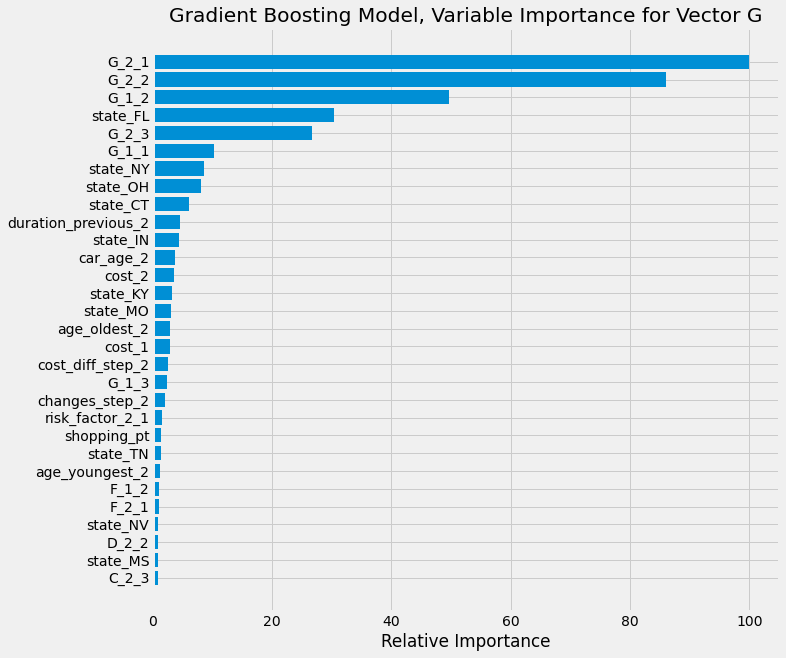

In [341]:
# model G with GradientBoosting classifier and best hyperparameters


vector = 'G'

gb_ac, gb_f1, gb_probs, gb_preds = gb_predict_plot(vector, n_estimators = 200, learning_rate = 0.25, max_depth = 3, \
                                                   max_features = 8, plot=True)


Notes for Vector G GB modelling:
* increasing max_features beyond 8 reduces score
* increasing max_depth to 4 doesn't change score much (reduces it marginally)

No GB model is not able to beat Random forest score of **0.758**.


In [342]:
vector = 'G'
score_matrix = model_score_matrix(vector, 2, gb_preds)
score_matrix

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)


Pred_incorrect  Pred_correct  Pred_accuracy_%
cust_changed_vector               3547           481            11.94
cust_maintained_vector             229         11265            98.01

In [343]:
score = model_score_by_shopping_pt("G", 2, gb_preds)
score

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple

G_model_accuracy_%  G_quote2_accuracy_%  model_vs_quote
shopping_pt                                                         
3                         77.67                76.88            0.79
4                         79.06                78.28            0.78
5                         77.26                76.59            0.67
6                         76.00                75.60            0.40
7                         74.11                72.23            1.88
8                         75.43                72.97            2.46
9                         74.40                72.89            1.51
10                        71.58                67.66            3.92
11                        79.47                74.49            4.98
12                        82.89                77.63            5.26
13                        87.50                75.00           12.50

In [344]:
perf_q1q2.update('G', 'gb', 'overall', round(gb_ac*100,2))
perf_q1q2.update('G', 'gb', 'customer_type', score_matrix)
perf_q1q2.update('G', 'gb', 'shopping_pt', score)
perf_q1q2.compare('G', 'gb')
perf_q1q2.record['G']

no_model     rf rf_vs_no_model     gb  \
accuracy_overall                   74.05  75.80           1.75  75.67   
accuracy_cust_changed_vector           0  11.02          11.02  11.94   
accuracy_cust_maintained_vector      100  98.50           -1.5  98.01   
accuracy_shopping_pt_3             76.88  78.00           1.12  77.67   
accuracy_shopping_pt_4             78.28  78.83           0.55  79.06   
accuracy_shopping_pt_5             76.59  77.43           0.84  77.26   
accuracy_shopping_pt_6              75.6  76.48           0.88  76.00   
accuracy_shopping_pt_7             72.23  74.34           2.11  74.11   
accuracy_shopping_pt_8             72.97  75.51           2.54  75.43   
accuracy_shopping_pt_9             72.89  74.66           1.77  74.40   
accuracy_shopping_pt_10            67.66  71.16            3.5  71.58   
accuracy_shopping_pt_11            74.49  78.30           3.81  79.47   
accuracy_shopping_pt_12            77.63  82.89           5.26  82.89   
accuracy_shopping_pt_13             75.0  75.00            0.0  87.50   

                                gb_vs_no_model  
accuracy_overall                          1.62  
accuracy_cust_changed_vector             11.94  
accuracy_cust_maintained_vector          -1.99  
accuracy_shopping_pt_3                    0.79  
accuracy_shopping_pt_4                    0.78  
accuracy_shopping_pt_5                    0.67  
accuracy_shopping_pt_6                     0.4  
accuracy_shopping_pt_7                    1.88  
accuracy_shopping_pt_8                    2.46  
accuracy_shopping_pt_9                    1.51  
accuracy_shopping_pt_10                   3.92  
accuracy_shopping_pt_11                   4.98  
accuracy_shopping_pt_12                   5.26  
accuracy_shopping_pt_13                   12.5

In [60]:
# Let's use RandomizedSearchCV to find the best XGB classifier Hyperparamters for vector G

import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV
vector = 'G'
param_grid = {'learning_rate' : [0.25, 0.3, 0.35, 0.5], 'n_estimators' : np.arange(100,501,100), \
              'colsample_bytree': [0.15,0.25,0.35,0.5], 'max_depth' : [3,4,5]}
clf = xgb.XGBClassifier(objective='binary:logistic', random_state=1, n_jobs=-1)
clf_cv = RandomizedSearchCV(clf, param_grid, n_iter = 60, verbose = 3, cv=4)
clf_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print(f"Vector {vector} RandomizedSearchCV: XG Boosting Model\nBest Score:" + str(clf_cv.best_score_))
print("\nBest Parameters: " + str(clf_cv.best_params_))


Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.760 total time=   8.2s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.765 total time=   8.0s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.753 total time=   9.7s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.762 total time=   9.8s
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=5, n_estimators=300;, score=0.760 total time=  18.6s
[CV 2/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=5, n_estimators=300;, score=0.764 total time=  19.5s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=5, n_estimators=300;, score=0.755 total time=  20.0s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=5, n_estimators=300;, score=0.764 total time=  18.6

[CV 2/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=5, n_estimators=300;, score=0.766 total time=  18.1s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=5, n_estimators=300;, score=0.758 total time=  18.0s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=5, n_estimators=300;, score=0.764 total time=  18.9s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.763 total time=  15.7s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.766 total time=  15.6s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.758 total time=  15.1s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.764 total time=  15.1s
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=5, n_estimators=100;, score=0.764 total time=   6.1s
[CV 2/4] END colsample_bytree=0.25, learning_rat

[CV 4/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=500;, score=0.758 total time=  19.7s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=4, n_estimators=500;, score=0.753 total time=  30.2s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=4, n_estimators=500;, score=0.757 total time=  30.5s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=4, n_estimators=500;, score=0.747 total time=  30.7s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=4, n_estimators=500;, score=0.755 total time=  30.2s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=5, n_estimators=400;, score=0.761 total time=  30.5s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=5, n_estimators=400;, score=0.764 total time=  31.1s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=5, n_estimators=400;, score=0.754 total time=  30.7s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.2

[CV 2/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=300;, score=0.767 total time=  18.2s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=300;, score=0.758 total time=  18.5s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=300;, score=0.766 total time=  18.5s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.762 total time=  23.6s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.766 total time=  23.6s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.757 total time=  23.3s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.764 total time=  23.3s
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.5, max_depth=5, n_estimators=300;, score=0.755 total time=  19.0s
[CV 2/4] END colsample_bytree=0.25, learning_rate=0.

In [62]:
results = pd.DataFrame(clf_cv.cv_results_['params'])
results['train_score'] = clf_cv.cv_results_['mean_test_score']
results['train_rank'] = clf_cv.cv_results_['rank_test_score']
datapath = 'Modelling_data'
save_file(results, 'xgboost_results_vectorG.csv', datapath)
results

Writing file.  "Modelling_data\xgboost_results_vectorG.csv"


n_estimators  max_depth  learning_rate  colsample_bytree  train_score  \
0            100          5           0.50              0.50     0.759958   
1            300          5           0.30              0.25     0.760731   
2            500          5           0.30              0.35     0.755609   
3            100          3           0.30              0.50     0.762068   
4            400          5           0.50              0.50     0.748812   
5            100          5           0.25              0.35     0.764468   
6            300          4           0.30              0.50     0.761279   
7            300          5           0.50              0.50     0.751776   
8            400          4           0.30              0.15     0.761472   
9            200          5           0.30              0.25     0.762696   
10           100          3           0.30              0.15     0.761166   
11           400          3           0.30              0.50     0.762213   
12           200          3           0.35              0.50     0.762906   
13           400          3           0.35              0.35     0.762729   
14           300          4           0.25              0.25     0.763824   
15           500          5           0.35              0.35     0.754385   
16           100          3           0.50              0.35     0.762229   
17           300          5           0.25              0.25     0.762165   
18           500          3           0.35              0.15     0.762696   
19           100          5           0.35              0.25     0.763598   
20           500          4           0.30              0.15     0.760377   
21           200          3           0.25              0.35     0.763180   
22           500          5           0.35              0.50     0.752613   
23           200          4           0.30              0.25     0.763550   
24           500          3           0.50              0.50     0.758573   
25           100          4           0.30              0.25     0.763550   
26           100          4           0.35              0.25     0.763663   
27           300          4           0.25              0.35     0.763018   
28           500          5           0.35              0.15     0.756350   
29           300          5           0.35              0.35     0.758074   
30           400          4           0.35              0.35     0.759443   
31           200          4           0.35              0.50     0.762052   
32           400          3           0.50              0.35     0.760441   
33           300          4           0.50              0.35     0.757929   
34           500          4           0.50              0.15     0.756560   
35           500          4           0.50              0.35     0.753354   
36           400          5           0.25              0.35     0.760554   
37           300          5           0.30              0.50     0.758364   
38           100          3           0.35              0.15     0.761682   
39           300          5           0.35              0.50     0.756592   
40           300          4           0.35              0.50     0.760715   
41           500          3           0.25              0.25     0.763324   
42           200          3           0.30              0.50     0.763180   
43           500          3           0.50              0.15     0.759668   
44           200          5           0.35              0.35     0.761746   
45           400          5           0.30              0.15     0.759475   
46           200          4           0.50              0.15     0.761069   
47           400          4           0.50              0.35     0.756270   
48           200          4           0.30              0.50     0.762503   
49           100          5           0.30              0.15     0.762406   
50           200          3           0.25              0.15     0.762278   


In [63]:
import xgboost as xgb

vector = 'G'

print(f"XGBoost Classifier results for Vector {vector}\n")
#param_grid
for i, row in results.iterrows():
    n_estimators = row['n_estimators']
    max_depth = row['max_depth']
    learning_rate = row['learning_rate']
    colsample_bytree = row['colsample_bytree']
        
    clf = xgb.XGBClassifier(max_depth=int(max_depth), objective='multi:softprob', n_estimators=int(n_estimators), \
                       learning_rate = learning_rate, colsample_bytree = colsample_bytree, n_jobs=-1, random_state=1)

    clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = clf.predict(X_test.to_numpy())
    y_pred_prob = clf.predict_proba(X_test.to_numpy())
    xg_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
    cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

    results.loc[i, 'test_score'] = ac
    results.loc[i, 'f1_score'] = f1
    
    print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}, \
    learning_rate = {learning_rate}, colsample_bytree = {colsample_bytree}")

    print(f'Accuracy={ac:4.4}, f1_score={f1:4.4}')

results['test_rank']= results['test_score'].rank(method='dense', ascending=False)
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
results

XGBoost Classifier results for Vector G

Parameters: No. of Estimators = 100.0,  max_depth = 5.0,     learning_rate = 0.5, colsample_bytree = 0.5
Accuracy=0.7572, f1_score=0.7561
Parameters: No. of Estimators = 300.0,  max_depth = 5.0,     learning_rate = 0.3, colsample_bytree = 0.25
Accuracy=0.7553, f1_score=0.7542
Parameters: No. of Estimators = 500.0,  max_depth = 5.0,     learning_rate = 0.3, colsample_bytree = 0.35
Accuracy=0.7516, f1_score=0.7504
Parameters: No. of Estimators = 100.0,  max_depth = 3.0,     learning_rate = 0.3, colsample_bytree = 0.5
Accuracy=0.7572, f1_score=0.7567
Parameters: No. of Estimators = 400.0,  max_depth = 5.0,     learning_rate = 0.5, colsample_bytree = 0.5
Accuracy=0.7447, f1_score=0.7431
Parameters: No. of Estimators = 100.0,  max_depth = 5.0,     learning_rate = 0.25, colsample_bytree = 0.35
Accuracy=0.7592, f1_score=0.7585
Parameters: No. of Estimators = 300.0,  max_depth = 4.0,     learning_rate = 0.3, colsample_bytree = 0.5
Accuracy=0.7584, f1_sc

Parameters: No. of Estimators = 300.0,  max_depth = 4.0,     learning_rate = 0.5, colsample_bytree = 0.15
Accuracy=0.7559, f1_score=0.7548


n_estimators  max_depth  learning_rate  colsample_bytree  train_score  \
0            100          5           0.50              0.50     0.759958   
1            300          5           0.30              0.25     0.760731   
2            500          5           0.30              0.35     0.755609   
3            100          3           0.30              0.50     0.762068   
4            400          5           0.50              0.50     0.748812   
5            100          5           0.25              0.35     0.764468   
6            300          4           0.30              0.50     0.761279   
7            300          5           0.50              0.50     0.751776   
8            400          4           0.30              0.15     0.761472   
9            200          5           0.30              0.25     0.762696   
10           100          3           0.30              0.15     0.761166   
11           400          3           0.30              0.50     0.762213   
12           200          3           0.35              0.50     0.762906   
13           400          3           0.35              0.35     0.762729   
14           300          4           0.25              0.25     0.763824   
15           500          5           0.35              0.35     0.754385   
16           100          3           0.50              0.35     0.762229   
17           300          5           0.25              0.25     0.762165   
18           500          3           0.35              0.15     0.762696   
19           100          5           0.35              0.25     0.763598   
20           500          4           0.30              0.15     0.760377   
21           200          3           0.25              0.35     0.763180   
22           500          5           0.35              0.50     0.752613   
23           200          4           0.30              0.25     0.763550   
24           500          3           0.50              0.50     0.758573   
25           100          4           0.30              0.25     0.763550   
26           100          4           0.35              0.25     0.763663   
27           300          4           0.25              0.35     0.763018   
28           500          5           0.35              0.15     0.756350   
29           300          5           0.35              0.35     0.758074   
30           400          4           0.35              0.35     0.759443   
31           200          4           0.35              0.50     0.762052   
32           400          3           0.50              0.35     0.760441   
33           300          4           0.50              0.35     0.757929   
34           500          4           0.50              0.15     0.756560   
35           500          4           0.50              0.35     0.753354   
36           400          5           0.25              0.35     0.760554   
37           300          5           0.30              0.50     0.758364   
38           100          3           0.35              0.15     0.761682   
39           300          5           0.35              0.50     0.756592   
40           300          4           0.35              0.50     0.760715   
41           500          3           0.25              0.25     0.763324   
42           200          3           0.30              0.50     0.763180   
43           500          3           0.50              0.15     0.759668   
44           200          5           0.35              0.35     0.761746   
45           400          5           0.30              0.15     0.759475   
46           200          4           0.50              0.15     0.761069   
47           400          4           0.50              0.35     0.756270   
48           200          4           0.30              0.50     0.762503   
49           100          5           0.30              0.15     0.762406   
50           200          3           0.25              0.15     0.762278   


In [64]:
save_file(results,"xgboost_results_vectorG.csv",datapath)


A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "Modelling_data\xgboost_results_vectorG.csv"


XGBoost Classifier results for Vector G
Parameters: No. of Estimators = 200,  max_depth = 5,     learning_rate = 0.25, colsample_bytree = 0.25
Accuracy=0.7601, f1-score=0.7592
Confusion Matrix - normalized
 [[0.7221 0.2258 0.0392 0.0129]
 [0.1199 0.8191 0.0425 0.0185]
 [0.0528 0.1334 0.7738 0.04  ]
 [0.0667 0.1899 0.2209 0.5225]]
Confusion Matrix
 [[2302  720  125   41]
 [ 731 4994  259  113]
 [ 261  660 3828  198]
 [  86  245  285  674]]

Classification Report 
               precision    recall  f1-score   support

           0       0.68      0.72      0.70      3188
           1       0.75      0.82      0.79      6097
           2       0.85      0.77      0.81      4947
           3       0.66      0.52      0.58      1290

    accuracy                           0.76     15522
   macro avg       0.74      0.71      0.72     15522
weighted avg       0.76      0.76      0.76     15522

30


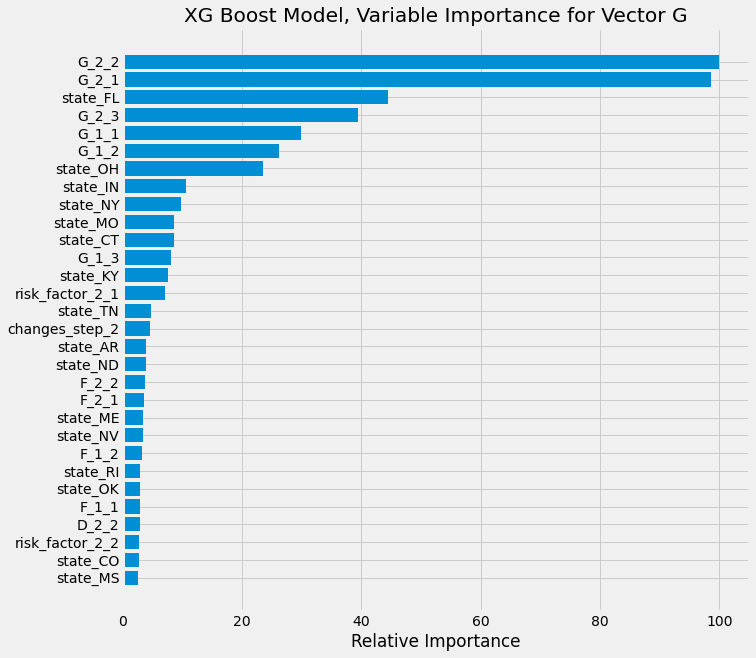

In [345]:
# model G with XGBoost classifier Best Parameters: (Overall 1st rank model)
#  No. of Estimators = 200,  max_depth = 5, learning_rate = 0.25, colsample_bytree = 0.25 : 0.7601, 0.7592

vector = 'G'

xg_ac, xg_f1, xg_probs, xg_preds = xg_predict_plot(vector, n_estimators = 200, learning_rate = 0.25, max_depth = 5, colsample_bytree = 0.25, plot=True)



In [346]:
vector = 'G'
score_matrix = model_score_matrix(vector, 2, xg_preds)
score_matrix

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)


Pred_incorrect  Pred_correct  Pred_accuracy_%
cust_changed_vector               3479           549            13.63
cust_maintained_vector             245         11249            97.87

In [347]:
score = model_score_by_shopping_pt("G", 2, xg_preds)
score

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple

G_model_accuracy_%  G_quote2_accuracy_%  model_vs_quote
shopping_pt                                                         
3                         78.23                76.88            1.35
4                         79.22                78.28            0.94
5                         77.81                76.59            1.22
6                         76.64                75.60            1.04
7                         74.45                72.23            2.22
8                         75.69                72.97            2.72
9                         74.87                72.89            1.98
10                        71.99                67.66            4.33
11                        76.83                74.49            2.34
12                        81.58                77.63            3.95
13                        75.00                75.00            0.00

In [348]:
perf_q1q2.update('G', 'xg', 'overall', round(xg_ac*100,2))
perf_q1q2.update('G', 'xg', 'customer_type', score_matrix)
perf_q1q2.update('G', 'xg', 'shopping_pt', score)
perf_q1q2.compare('G', 'xg')
perf_q1q2.record['G']

no_model     rf rf_vs_no_model     gb  \
accuracy_overall                   74.05  75.80           1.75  75.67   
accuracy_cust_changed_vector           0  11.02          11.02  11.94   
accuracy_cust_maintained_vector      100  98.50           -1.5  98.01   
accuracy_shopping_pt_3             76.88  78.00           1.12  77.67   
accuracy_shopping_pt_4             78.28  78.83           0.55  79.06   
accuracy_shopping_pt_5             76.59  77.43           0.84  77.26   
accuracy_shopping_pt_6              75.6  76.48           0.88  76.00   
accuracy_shopping_pt_7             72.23  74.34           2.11  74.11   
accuracy_shopping_pt_8             72.97  75.51           2.54  75.43   
accuracy_shopping_pt_9             72.89  74.66           1.77  74.40   
accuracy_shopping_pt_10            67.66  71.16            3.5  71.58   
accuracy_shopping_pt_11            74.49  78.30           3.81  79.47   
accuracy_shopping_pt_12            77.63  82.89           5.26  82.89   
accuracy_shopping_pt_13             75.0  75.00            0.0  87.50   

                                gb_vs_no_model     xg xg_vs_no_model  
accuracy_overall                          1.62  76.01           1.96  
accuracy_cust_changed_vector             11.94  13.63          13.63  
accuracy_cust_maintained_vector          -1.99  97.87          -2.13  
accuracy_shopping_pt_3                    0.79  78.23           1.35  
accuracy_shopping_pt_4                    0.78  79.22           0.94  
accuracy_shopping_pt_5                    0.67  77.81           1.22  
accuracy_shopping_pt_6                     0.4  76.64           1.04  
accuracy_shopping_pt_7                    1.88  74.45           2.22  
accuracy_shopping_pt_8                    2.46  75.69           2.72  
accuracy_shopping_pt_9                    1.51  74.87           1.98  
accuracy_shopping_pt_10                   3.92  71.99           4.33  
accuracy_shopping_pt_11                   4.98  76.83           2.34  
accuracy_shopping_pt_12                   5.26  81.58           3.95  
accuracy_shopping_pt_13                   12.5  75.00            0.0

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/3934441024.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/3934441024.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels)


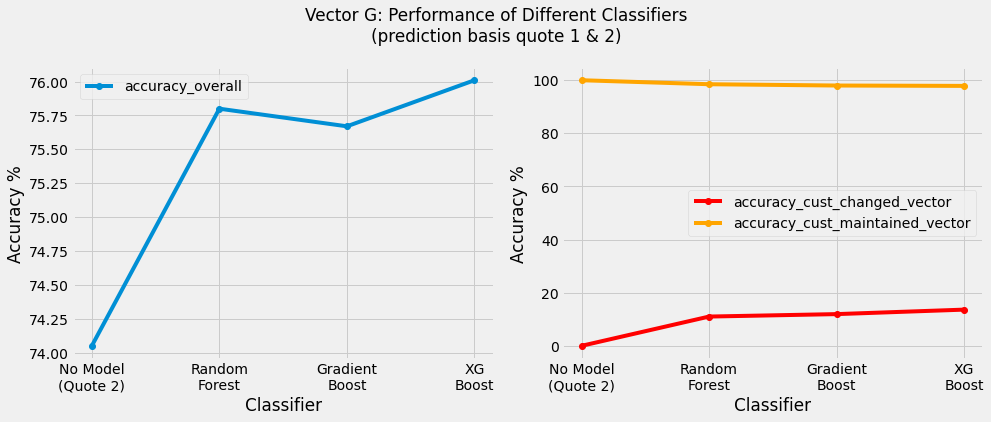

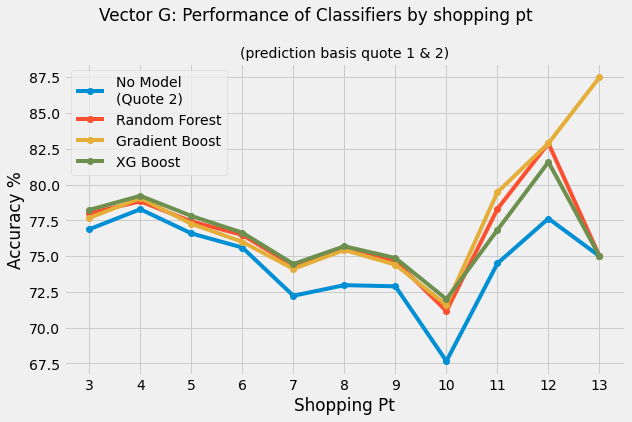

In [520]:

vector = 'G'
#models = ['no_model', 'rf', 'gb', 'xg', 'lr']
models = ['no_model', 'rf', 'gb', 'xg']
quotes = [1,2]
model_performance_plot(vector, models, quotes, "overall")
model_performance_plot(vector, models, quotes, "shopping_pt")

### Vector A: Training Models<a id='Phase1_step3.3'></a>

Random Forest Classifier results for Vector A

Accuracy=0.846
f1-score=0.841
Confusion Matrix
 [[0.81 0.17 0.02]
 [0.04 0.93 0.03]
 [0.04 0.38 0.58]]

Classification Report 
               precision    recall  f1-score   support

           0       0.86      0.81      0.83      3463
           1       0.85      0.93      0.89      9504
           2       0.80      0.58      0.68      2555

    accuracy                           0.85     15522
   macro avg       0.84      0.77      0.80     15522
weighted avg       0.84      0.85      0.84     15522

30


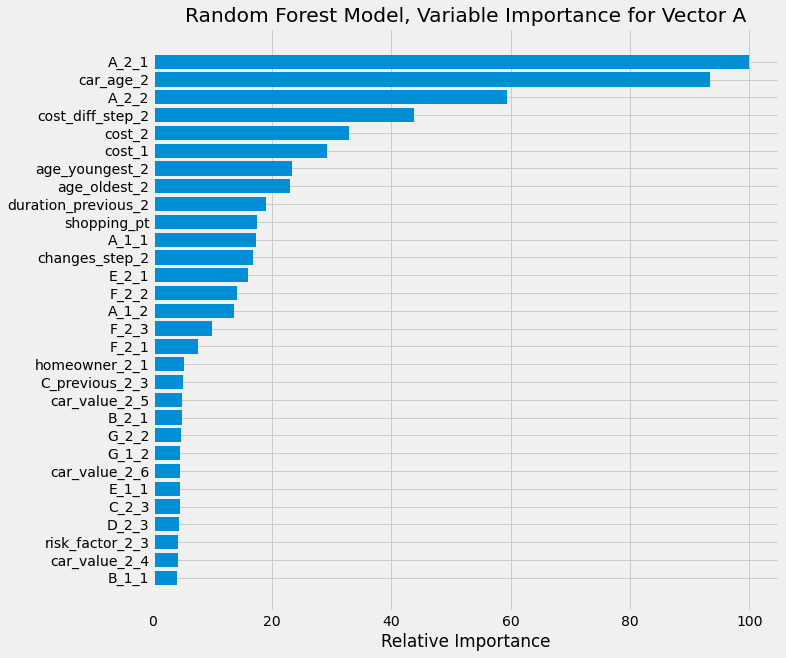

In [299]:
# Let's run a Random Forest model for vector A


vector = 'A'
rf_ac, rf_f1, rf_probs, rf_preds = rf_predict_plot(vector, plot=True)


In [350]:
test_set = df_train_first2.iloc[y_test.index,:]

x = pd.crosstab( test_set['A'], test_set['A_2'])

same_as_2 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 

acc = np.around(np.sum(same_as_2)/y_test.shape[0],4)

print(f"Accuracy based on simply predicting vector {vector} = {vector}_2 : {(np.sum(same_as_2)/y_test.shape[0]): 4.4}")

Accuracy based on simply predicting vector A = A_2 :  0.8214


In [305]:
x['total'] = x.sum(axis=1)
x['A0_%'] = np.around(x[0]*100 / x['total'], 2)
x['A1_%'] = np.around(x[1]*100 / x['total'], 2)
x['A2_%'] = np.around(x[2]*100 / x['total'], 2)


In [306]:
x

A_2     0     1     2  total   A0_%   A1_%   A2_%
A                                                
0    2687   679    97   3463  77.59  19.61   2.80
1     632  8565   307   9504   6.65  90.12   3.23
2     190   867  1498   2555   7.44  33.93  58.63

In [297]:
# Now let's try a Grid Search CV to find the best Random Forest classifier for vector A

vector = 'A'
param_grid = {'n_estimators' : np.arange(100,801,100)}

rf = RandomForestClassifier(random_state = 1, n_jobs=-1)

rf_cv = GridSearchCV(rf, param_grid, cv=5)
rf_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print("Random Forest Model\nBest Score:" + str(rf_cv.best_score_))
print("\nBest Parameters: " + str(rf_cv.best_params_)) 

Random Forest Model
Best Score:0.8449544978658292

Best Parameters: {'n_estimators': 800}


Random Forest Classifier results for Vector A
Parameters: No. of Estimators = 800,  min_samples_leaf = 1,     min_samples_split = 2
Accuracy=0.8458, f1-score=0.8407
Confusion Matrix - normalized
 [[0.8033 0.1733 0.0234]
 [0.0381 0.9314 0.0305]
 [0.0395 0.3753 0.5851]]
Confusion Matrix
 [[2782  600   81]
 [ 362 8852  290]
 [ 101  959 1495]]

Classification Report 
               precision    recall  f1-score   support

           0       0.86      0.80      0.83      3463
           1       0.85      0.93      0.89      9504
           2       0.80      0.59      0.68      2555

    accuracy                           0.85     15522
   macro avg       0.84      0.77      0.80     15522
weighted avg       0.84      0.85      0.84     15522

30


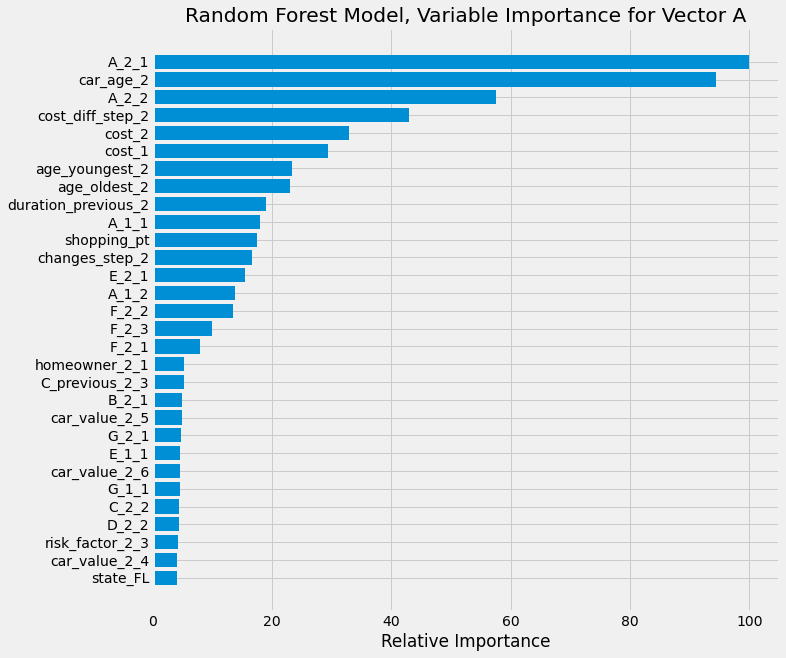

In [349]:
# Run the model with Best Parameters: {'n_estimators': 800}


vector = 'A'
rf_ac, rf_f1, rf_probs, rf_preds = rf_predict_plot(vector, n_estimators= 800, plot=True)


In [351]:
vector = 'A'
score_matrix = model_score_matrix(vector, 2, rf_preds)
score_matrix

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)


Pred_incorrect  Pred_correct  Pred_accuracy_%
cust_changed_vector               2288           484            17.46
cust_maintained_vector             105         12645            99.18

In [353]:
score = model_score_by_shopping_pt("A", 2, rf_preds)
score

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple

A_model_accuracy_%  A_quote2_accuracy_%  model_vs_quote
shopping_pt                                                         
3                         85.52                84.40            1.12
4                         89.14                88.44            0.70
5                         86.80                84.80            2.00
6                         86.04                84.20            1.84
7                         84.73                81.67            3.06
8                         82.61                79.42            3.19
9                         82.06                78.94            3.12
10                        81.05                77.55            3.50
11                        81.52                80.06            1.46
12                        84.21                84.21            0.00
13                        87.50                87.50            0.00

In [354]:
vector='A'
perf_q1q2.update(vector, 'no_model', 'overall', acc*100)
perf_q1q2.update(vector, 'rf', 'overall', round(rf_ac*100,2))
perf_q1q2.update(vector, 'rf', 'customer_type', score_matrix)
perf_q1q2.update(vector, 'rf', 'shopping_pt', score)
perf_q1q2.compare(vector, 'rf')
perf_q1q2.record[vector]

no_model     rf rf_vs_no_model
accuracy_overall                   82.14  84.58           2.44
accuracy_cust_changed_vector           0  17.46          17.46
accuracy_cust_maintained_vector      100  99.18          -0.82
accuracy_shopping_pt_3              84.4  85.52           1.12
accuracy_shopping_pt_4             88.44  89.14            0.7
accuracy_shopping_pt_5              84.8  86.80            2.0
accuracy_shopping_pt_6              84.2  86.04           1.84
accuracy_shopping_pt_7             81.67  84.73           3.06
accuracy_shopping_pt_8             79.42  82.61           3.19
accuracy_shopping_pt_9             78.94  82.06           3.12
accuracy_shopping_pt_10            77.55  81.05            3.5
accuracy_shopping_pt_11            80.06  81.52           1.46
accuracy_shopping_pt_12            84.21  84.21            0.0
accuracy_shopping_pt_13             87.5  87.50            0.0

Gradient Boosting Classifier results for Vector A

Accuracy=0.844
f1-score=0.840
Confusion Matrix
 [[0.812 0.164 0.024]
 [0.042 0.926 0.033]
 [0.041 0.373 0.586]]

Classification Report 
               precision    recall  f1-score   support

           0       0.85      0.81      0.83      3463
           1       0.85      0.93      0.89      9504
           2       0.79      0.59      0.67      2555

    accuracy                           0.84     15522
   macro avg       0.83      0.77      0.80     15522
weighted avg       0.84      0.84      0.84     15522



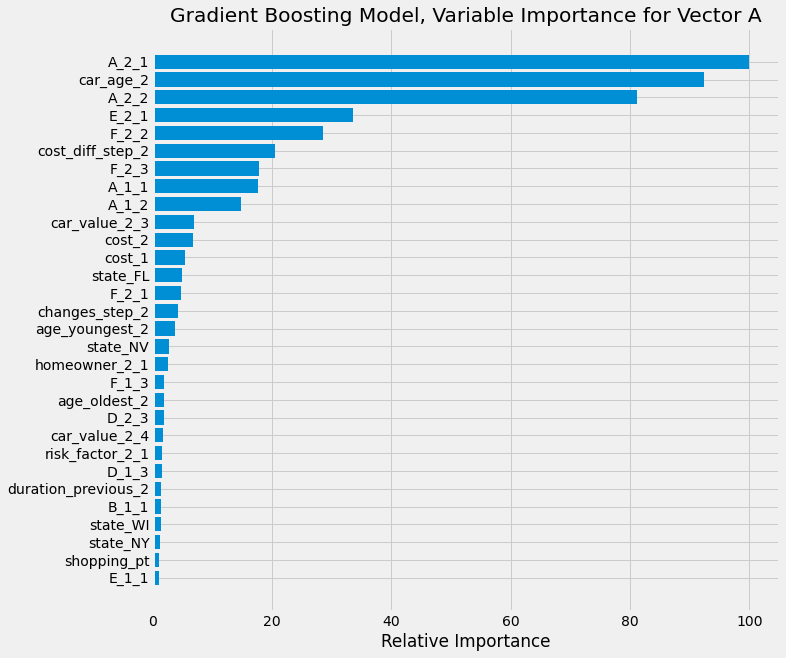

In [376]:
# model A with GradientBoosting classifier

vector = 'A'

gb_ac, gb_f1, gb_probs, gb_preds = gb_predict_plot(vector, n_estimators = 150, learning_rate = 0.25, max_depth = 3, max_features = 6, plot=True)


In [377]:
# Let's use RandomizedSearchCV to find the best GradientBoosting classifier Hyperparamters for vector A 

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

vector = 'A'

param_grid = {'learning_rate' : [0.25, 0.5, 0.75, 1], 'n_estimators' : [50, 100, 150, 200], \
              'max_features': [2,4,6,8], 'max_depth' : [1,2,3]}

gb = GradientBoostingClassifier(random_state = 1)

gb_cv = RandomizedSearchCV(gb, param_grid, n_iter = 10, verbose = 3, cv=5)

gb_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print(f"Vector {vector} RandomizedSearchCV: Gradient Boosting Model\nBest Score:" + str(gb_cv.best_score_))
print("\nBest Parameters: " + str(gb_cv.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.25, max_depth=3, max_features=8, n_estimators=200;, score=0.846 total time=  51.0s
[CV 2/5] END learning_rate=0.25, max_depth=3, max_features=8, n_estimators=200;, score=0.846 total time=  48.3s
[CV 3/5] END learning_rate=0.25, max_depth=3, max_features=8, n_estimators=200;, score=0.846 total time=  47.4s
[CV 4/5] END learning_rate=0.25, max_depth=3, max_features=8, n_estimators=200;, score=0.840 total time=  50.8s
[CV 5/5] END learning_rate=0.25, max_depth=3, max_features=8, n_estimators=200;, score=0.842 total time=  50.1s
[CV 1/5] END learning_rate=0.25, max_depth=3, max_features=8, n_estimators=150;, score=0.845 total time=  36.3s
[CV 2/5] END learning_rate=0.25, max_depth=3, max_features=8, n_estimators=150;, score=0.847 total time=  36.4s
[CV 3/5] END learning_rate=0.25, max_depth=3, max_features=8, n_estimators=150;, score=0.845 total time=  35.9s
[CV 4/5] END learning_rate=0.25, max_depth=

Gradient Boosting Classifier results for Vector A

Parameters: No. of Estimators = 200,  learning_rate = 0.25, max_depth = 3,                                 max_features = 8

Accuracy=0.846
f1-score=0.841
Confusion Matrix
 [[0.813 0.163 0.024]
 [0.04  0.926 0.034]
 [0.039 0.371 0.59 ]]

Classification Report 
               precision    recall  f1-score   support

           0       0.85      0.81      0.83      3463
           1       0.85      0.93      0.89      9504
           2       0.79      0.59      0.68      2555

    accuracy                           0.85     15522
   macro avg       0.83      0.78      0.80     15522
weighted avg       0.84      0.85      0.84     15522



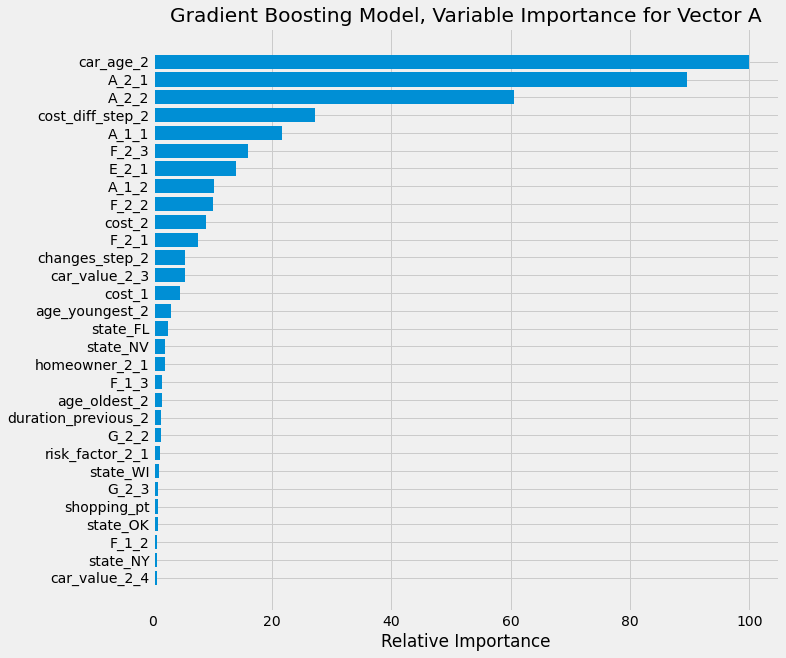

In [380]:
# model A with GradientBoosting classifier and best hyperparameters

vector = 'A'


gb_ac, gb_f1, gb_probs, gb_preds = gb_predict_plot(vector, n_estimators = 200, learning_rate = 0.25, max_depth = 3, \
                                         max_features = 8, plot=True)

    


Gradient Boosting Classifier results for Vector A

Parameters: No. of Estimators = 200,  learning_rate = 0.5, max_depth = 3, max_features = 8

Accuracy=0.846
f1-score=0.841
Confusion Matrix
 [[0.819 0.156 0.025]
 [0.041 0.926 0.033]
 [0.045 0.369 0.587]]

Classification Report 
               precision    recall  f1-score   support

           0       0.85      0.82      0.83      3463
           1       0.86      0.93      0.89      9504
           2       0.79      0.59      0.67      2555

    accuracy                           0.85     15522
   macro avg       0.83      0.78      0.80     15522
weighted avg       0.84      0.85      0.84     15522



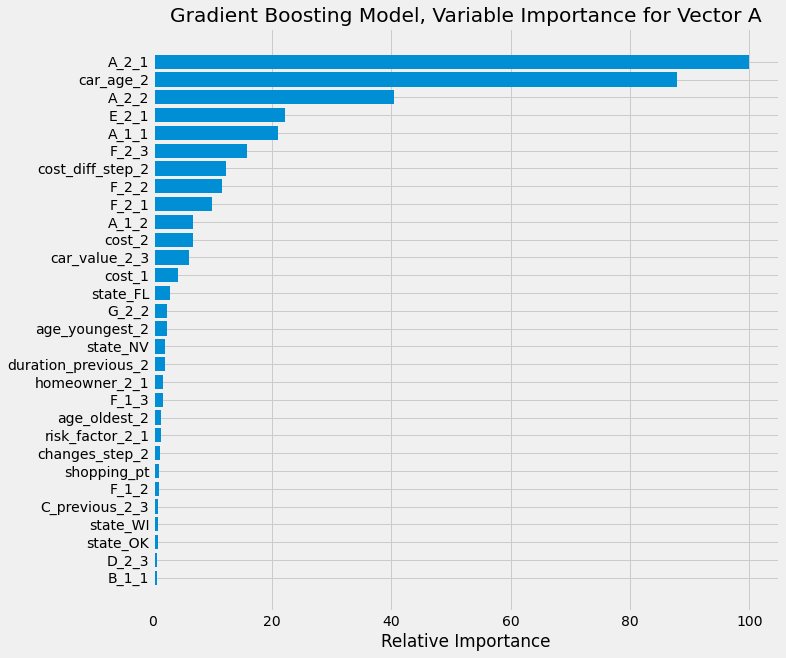

In [381]:
# model A with GradientBoosting classifier, increasing learning rate to 0.5

vector = 'A'


gb_ac, gb_f1, gb_probs, gb_preds = gb_predict_plot(vector, n_estimators = 200, learning_rate = 0.5, max_depth = 3, \
                                         max_features = 8, plot=True)

    


Gradient Boosting Classifier results for Vector A

Parameters: No. of Estimators = 200,  learning_rate = 0.5, max_depth = 3, max_features = 10

Accuracy=0.847
f1-score=0.842
Confusion Matrix
 [[0.821 0.156 0.023]
 [0.042 0.925 0.034]
 [0.041 0.367 0.592]]

Classification Report 
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      3463
           1       0.86      0.92      0.89      9504
           2       0.79      0.59      0.68      2555

    accuracy                           0.85     15522
   macro avg       0.83      0.78      0.80     15522
weighted avg       0.84      0.85      0.84     15522



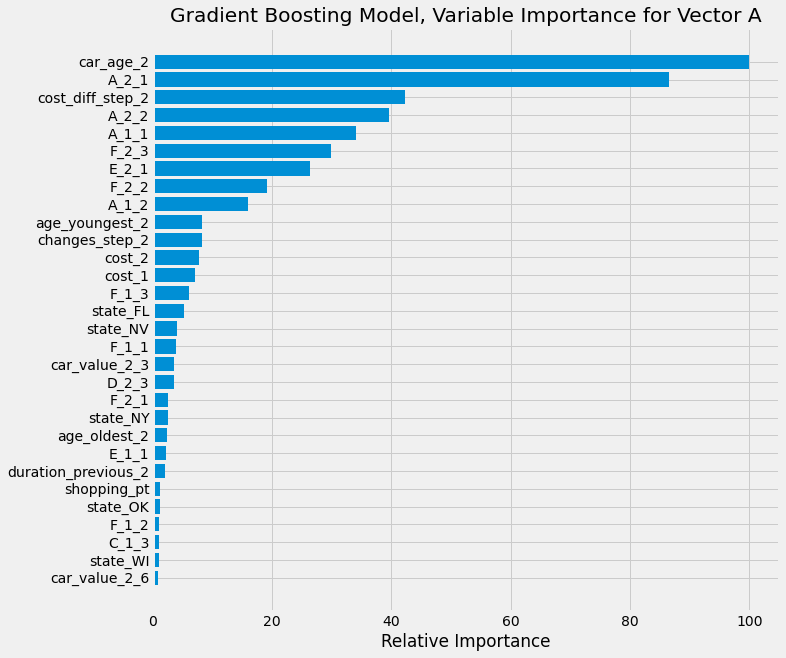

In [383]:
# model A with GradientBoosting classifier, increasing learning rate to 0.5, max _features = 10

vector = 'A'

gb_ac, gb_f1, gb_probs, gb_preds = gb_predict_plot(vector, n_estimators = 200, learning_rate = 0.5, max_depth = 3, \
                                         max_features = 10, plot=True)



Gradient Boosting Classifier results for Vector A
Parameters: No. of Estimators = 200,  max_depth = 3,     learning_rate = 0.4, max_features = 10
Accuracy=0.8483, f1-score=0.8437
Confusion Matrix - normalized
 [[0.8244 0.1525 0.0231]
 [0.0404 0.9265 0.0331]
 [0.0423 0.3675 0.5902]]
Confusion Matrix
 [[2855  528   80]
 [ 384 8805  315]
 [ 108  939 1508]]

Classification Report 
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      3463
           1       0.86      0.93      0.89      9504
           2       0.79      0.59      0.68      2555

    accuracy                           0.85     15522
   macro avg       0.83      0.78      0.80     15522
weighted avg       0.85      0.85      0.84     15522

30


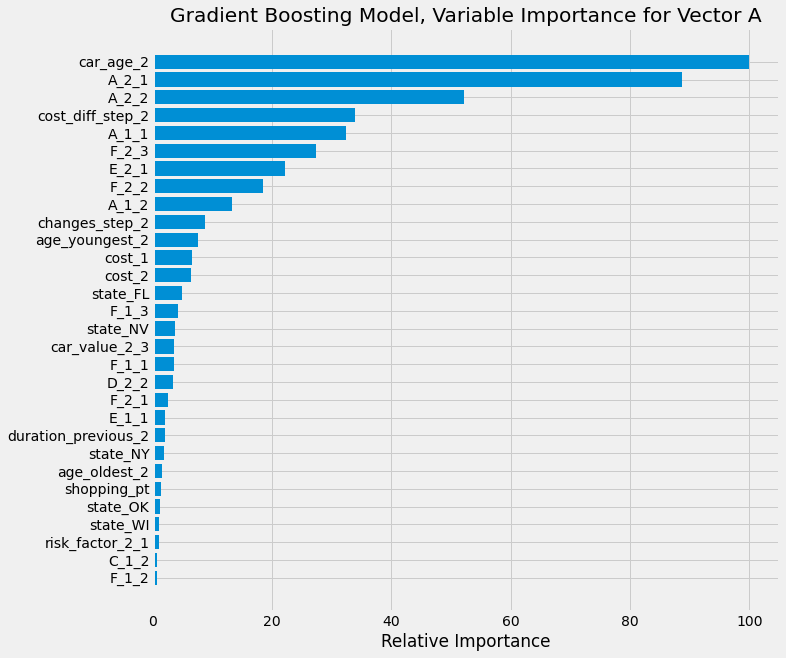

In [355]:
# BEST GB MODEL for A
# model A with GradientBoosting classifier, reducing learning rate to 0.4, max _features = 10

vector = 'A'

gb_ac, gb_f1, gb_probs, gb_preds = gb_predict_plot(vector, n_estimators = 200, learning_rate = 0.4, max_depth = 3, \
                                         max_features = 10, plot=True)


Notes for Vector A GB modelling:
* increasing l_rate beyond 0.5 reduces score
* increasing max_depth beyond 3 reduces score

Best Model HyperParameters: No. of Estimators = 200,  learning_rate = 0.4, max_depth = 3, max_features = 10



In [356]:
vector = 'A'
score_matrix = model_score_matrix(vector, 2, gb_preds)
score_matrix

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)


Pred_incorrect  Pred_correct  Pred_accuracy_%
cust_changed_vector               2148           624            22.51
cust_maintained_vector             206         12544            98.38

In [357]:
score = model_score_by_shopping_pt(vector, 2, gb_preds)
score

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple

A_model_accuracy_%  A_quote2_accuracy_%  model_vs_quote
shopping_pt                                                         
3                         85.75                84.40            1.35
4                         89.30                88.44            0.86
5                         87.47                84.80            2.67
6                         85.52                84.20            1.32
7                         84.97                81.67            3.30
8                         83.08                79.42            3.66
9                         82.85                78.94            3.91
10                        81.05                77.55            3.50
11                        81.82                80.06            1.76
12                        84.21                84.21            0.00
13                        87.50                87.50            0.00

In [358]:
vector='A'
model = 'gb'
perf_q1q2.update(vector, model, 'overall', round(gb_ac*100,2))
perf_q1q2.update(vector, model, 'customer_type', score_matrix)
perf_q1q2.update(vector, model, 'shopping_pt', score)
perf_q1q2.compare(vector, model)
perf_q1q2.record[vector]

no_model     rf rf_vs_no_model     gb  \
accuracy_overall                   82.14  84.58           2.44  84.83   
accuracy_cust_changed_vector           0  17.46          17.46  22.51   
accuracy_cust_maintained_vector      100  99.18          -0.82  98.38   
accuracy_shopping_pt_3              84.4  85.52           1.12  85.75   
accuracy_shopping_pt_4             88.44  89.14            0.7  89.30   
accuracy_shopping_pt_5              84.8  86.80            2.0  87.47   
accuracy_shopping_pt_6              84.2  86.04           1.84  85.52   
accuracy_shopping_pt_7             81.67  84.73           3.06  84.97   
accuracy_shopping_pt_8             79.42  82.61           3.19  83.08   
accuracy_shopping_pt_9             78.94  82.06           3.12  82.85   
accuracy_shopping_pt_10            77.55  81.05            3.5  81.05   
accuracy_shopping_pt_11            80.06  81.52           1.46  81.82   
accuracy_shopping_pt_12            84.21  84.21            0.0  84.21   
accuracy_shopping_pt_13             87.5  87.50            0.0  87.50   

                                gb_vs_no_model  
accuracy_overall                          2.69  
accuracy_cust_changed_vector             22.51  
accuracy_cust_maintained_vector          -1.62  
accuracy_shopping_pt_3                    1.35  
accuracy_shopping_pt_4                    0.86  
accuracy_shopping_pt_5                    2.67  
accuracy_shopping_pt_6                    1.32  
accuracy_shopping_pt_7                     3.3  
accuracy_shopping_pt_8                    3.66  
accuracy_shopping_pt_9                    3.91  
accuracy_shopping_pt_10                    3.5  
accuracy_shopping_pt_11                   1.76  
accuracy_shopping_pt_12                    0.0  
accuracy_shopping_pt_13                    0.0

XGBoost Classifier results for Vector A

Parameters: No. of Estimators = 300,  max_depth = 3

Accuracy=0.848
f1-score=0.843
Confusion Matrix
 [[0.825 0.152 0.023]
 [0.041 0.926 0.033]
 [0.042 0.369 0.589]]

Classification Report 
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      3463
           1       0.86      0.93      0.89      9504
           2       0.79      0.59      0.68      2555

    accuracy                           0.85     15522
   macro avg       0.83      0.78      0.80     15522
weighted avg       0.85      0.85      0.84     15522

30


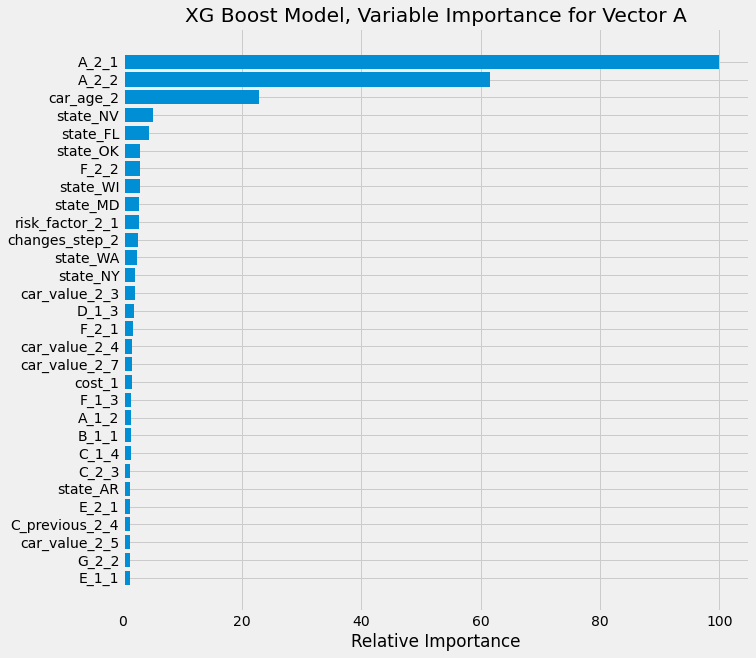

In [27]:
# model A with XGBoost classifier


vector = 'A'
xg_ac, xg_f2, xg_probs, xg_preds = xg_predict_plot(vector, n_estimators = 300, max_depth = 3, plot=True)



In [38]:

# Let's use RandomizedSearchCV to find the best XGB classifier Hyperparamters for vector A 

vector = 'A'
param_grid = {'learning_rate' : [0.25, 0.35, 0.5, 0.75], 'n_estimators' : np.arange(100,701,100), \
              'colsample_bytree': [0.1,0.3,0.5,0.8,1], 'max_depth' : [1,2,3]}

xgb = xgb.XGBClassifier(objective='multi:softprob', random_state=1)
xgb_cv = RandomizedSearchCV(xgb, param_grid, n_iter = 20, verbose = 3, cv=4)
xgb_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))



Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV 1/4] END colsample_bytree=0.8, learning_rate=0.35, max_depth=1, n_estimators=600;, score=0.844 total time=  27.3s
[CV 2/4] END colsample_bytree=0.8, learning_rate=0.35, max_depth=1, n_estimators=600;, score=0.844 total time=  26.9s
[CV 3/4] END colsample_bytree=0.8, learning_rate=0.35, max_depth=1, n_estimators=600;, score=0.841 total time=  26.3s
[CV 4/4] END colsample_bytree=0.8, learning_rate=0.35, max_depth=1, n_estimators=600;, score=0.838 total time=  27.5s
[CV 1/4] END colsample_bytree=0.3, learning_rate=0.75, max_depth=2, n_estimators=300;, score=0.846 total time=  11.9s
[CV 2/4] END colsample_bytree=0.3, learning_rate=0.75, max_depth=2, n_estimators=300;, score=0.846 total time=  14.2s
[CV 3/4] END colsample_bytree=0.3, learning_rate=0.75, max_depth=2, n_estimators=300;, score=0.843 total time=  13.3s
[CV 4/4] END colsample_bytree=0.3, learning_rate=0.75, max_depth=2, n_estimators=300;, score=0.840 total time=  1

[CV 3/4] END colsample_bytree=0.1, learning_rate=0.25, max_depth=2, n_estimators=200;, score=0.840 total time=   4.0s
[CV 4/4] END colsample_bytree=0.1, learning_rate=0.25, max_depth=2, n_estimators=200;, score=0.838 total time=   3.9s
[CV 1/4] END colsample_bytree=0.1, learning_rate=0.75, max_depth=3, n_estimators=200;, score=0.846 total time=   5.8s
[CV 2/4] END colsample_bytree=0.1, learning_rate=0.75, max_depth=3, n_estimators=200;, score=0.846 total time=   5.0s
[CV 3/4] END colsample_bytree=0.1, learning_rate=0.75, max_depth=3, n_estimators=200;, score=0.843 total time=   4.8s
[CV 4/4] END colsample_bytree=0.1, learning_rate=0.75, max_depth=3, n_estimators=200;, score=0.841 total time=   4.9s
[CV 1/4] END colsample_bytree=0.8, learning_rate=0.75, max_depth=3, n_estimators=400;, score=0.841 total time=  29.0s
[CV 2/4] END colsample_bytree=0.8, learning_rate=0.75, max_depth=3, n_estimators=400;, score=0.840 total time=  29.2s
[CV 3/4] END colsample_bytree=0.8, learning_rate=0.75, m

NameError: name 'gb_cv' is not defined

In [39]:
print(f"Vector {vector} RandomizedSearchCV: XG Boosting Model\nBest Score:" + str(xgb_cv.best_score_))
print("\nBest Parameters: " + str(xgb_cv.best_params_))

Vector A RandomizedSearchCV: XG Boosting Model
Best Score:0.8455504224729515

Best Parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.25, 'colsample_bytree': 0.5}


XGBoost Classifier results for Vector A

Parameters: No. of Estimators = 500,  max_depth = 3, learning_rate = 0.25, colsample_bytree = 0.5

Accuracy=0.847
f1-score=0.842
Confusion Matrix
 [[0.824 0.153 0.023]
 [0.041 0.925 0.033]
 [0.043 0.37  0.587]]

Classification Report 
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      3463
           1       0.86      0.93      0.89      9504
           2       0.79      0.59      0.67      2555

    accuracy                           0.85     15522
   macro avg       0.83      0.78      0.80     15522
weighted avg       0.84      0.85      0.84     15522

30


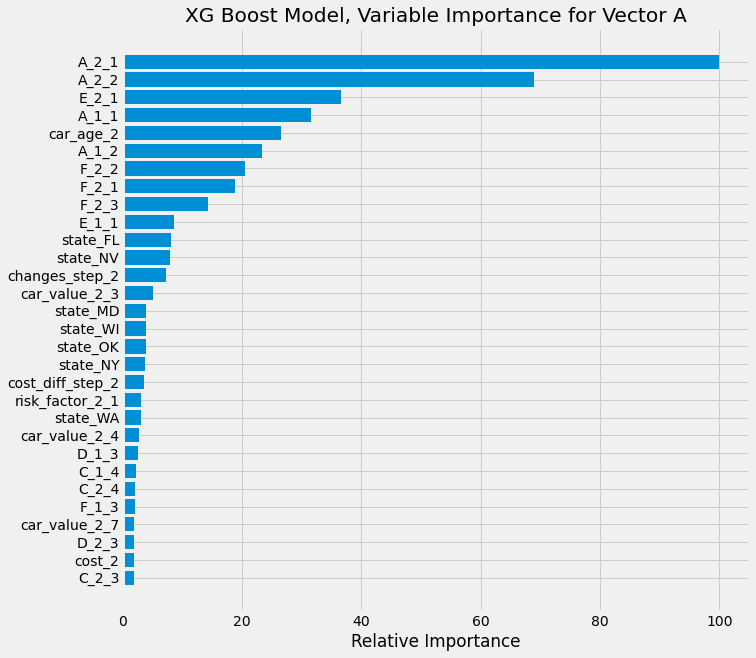

In [40]:
# model A with XGBoost classifier Best Parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.25, 'colsample_bytree': 0.5}


vector = 'A'
xg_ac, xg_f2, xg_probs, xg_preds = xg_predict_plot(vector, n_estimators = 500, max_depth = 3, \
                                         learning_rate = 0.25, colsample_bytree = 0.5, plot=True)



XGBoost Classifier results for Vector A
Parameters: No. of Estimators = 300,  max_depth = 3,     learning_rate = 0.3, colsample_bytree = 0.5
Accuracy=0.848, f1-score=0.8434
Confusion Matrix - normalized
 [[0.8247 0.151  0.0243]
 [0.0411 0.9251 0.0338]
 [0.0403 0.3671 0.5926]]
Confusion Matrix
 [[2856  523   84]
 [ 391 8792  321]
 [ 103  938 1514]]

Classification Report 
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      3463
           1       0.86      0.93      0.89      9504
           2       0.79      0.59      0.68      2555

    accuracy                           0.85     15522
   macro avg       0.83      0.78      0.80     15522
weighted avg       0.85      0.85      0.84     15522

30


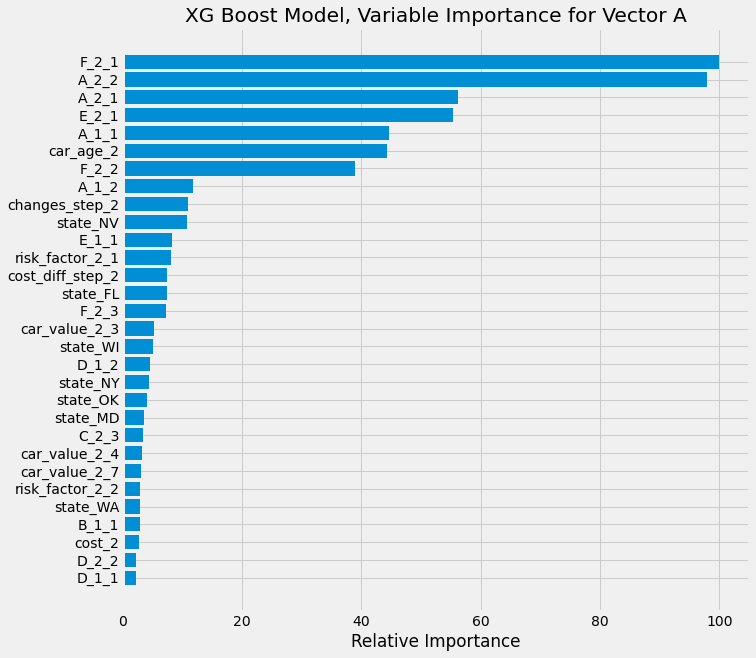

In [359]:
# model A with XGBoost classifier (BEST MODEL)
# Parameters: No. of Estimators = 300,  max_depth = 3, learning_rate = 0.3, colsample_bytree = 0.5 (0.848, .8434)

vector = 'A'
xg_ac, xg_f1, xg_probs, xg_preds = xg_predict_plot(vector, n_estimators = 300, max_depth = 3, \
                                         learning_rate = 0.3, colsample_bytree = 0.5, plot=True)


In [361]:
vector = 'A'
score_matrix = model_score_matrix(vector, 2, xg_preds)
score_matrix

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)


Pred_incorrect  Pred_correct  Pred_accuracy_%
cust_changed_vector               2159           613            22.11
cust_maintained_vector             201         12549            98.42

In [362]:
vector = 'A'
score = model_score_by_shopping_pt(vector, 2, xg_preds)
score

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple

A_model_accuracy_%  A_quote2_accuracy_%  model_vs_quote
shopping_pt                                                         
3                         85.75                84.40            1.35
4                         89.38                88.44            0.94
5                         87.13                84.80            2.33
6                         85.80                84.20            1.60
7                         85.27                81.67            3.60
8                         83.12                79.42            3.70
9                         82.01                78.94            3.07
10                        80.84                77.55            3.29
11                        82.11                80.06            2.05
12                        82.89                84.21           -1.32
13                        87.50                87.50            0.00

In [363]:
vector='A'
model = 'xg'
perf_q1q2.update(vector, model, 'overall', round(xg_ac*100,2))
perf_q1q2.update(vector, model, 'customer_type', score_matrix)
perf_q1q2.update(vector, model, 'shopping_pt', score)
perf_q1q2.compare(vector, model)
perf_q1q2.record[vector]

no_model     rf rf_vs_no_model     gb  \
accuracy_overall                   82.14  84.58           2.44  84.83   
accuracy_cust_changed_vector           0  17.46          17.46  22.51   
accuracy_cust_maintained_vector      100  99.18          -0.82  98.38   
accuracy_shopping_pt_3              84.4  85.52           1.12  85.75   
accuracy_shopping_pt_4             88.44  89.14            0.7  89.30   
accuracy_shopping_pt_5              84.8  86.80            2.0  87.47   
accuracy_shopping_pt_6              84.2  86.04           1.84  85.52   
accuracy_shopping_pt_7             81.67  84.73           3.06  84.97   
accuracy_shopping_pt_8             79.42  82.61           3.19  83.08   
accuracy_shopping_pt_9             78.94  82.06           3.12  82.85   
accuracy_shopping_pt_10            77.55  81.05            3.5  81.05   
accuracy_shopping_pt_11            80.06  81.52           1.46  81.82   
accuracy_shopping_pt_12            84.21  84.21            0.0  84.21   
accuracy_shopping_pt_13             87.5  87.50            0.0  87.50   

                                gb_vs_no_model     xg xg_vs_no_model  
accuracy_overall                          2.69  84.80           2.66  
accuracy_cust_changed_vector             22.51  22.11          22.11  
accuracy_cust_maintained_vector          -1.62  98.42          -1.58  
accuracy_shopping_pt_3                    1.35  85.75           1.35  
accuracy_shopping_pt_4                    0.86  89.38           0.94  
accuracy_shopping_pt_5                    2.67  87.13           2.33  
accuracy_shopping_pt_6                    1.32  85.80            1.6  
accuracy_shopping_pt_7                     3.3  85.27            3.6  
accuracy_shopping_pt_8                    3.66  83.12            3.7  
accuracy_shopping_pt_9                    3.91  82.01           3.07  
accuracy_shopping_pt_10                    3.5  80.84           3.29  
accuracy_shopping_pt_11                   1.76  82.11           2.05  
accuracy_shopping_pt_12                    0.0  82.89          -1.32  
accuracy_shopping_pt_13                    0.0  87.50            0.0

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/3934441024.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/3934441024.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels)


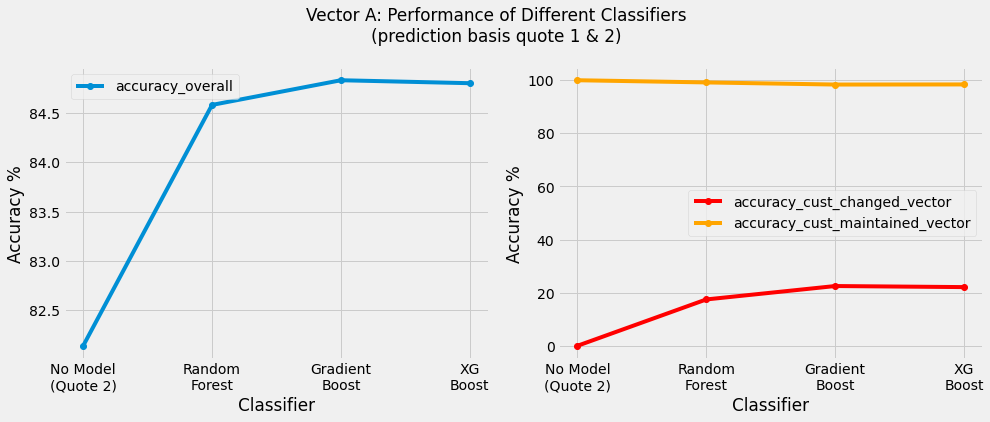

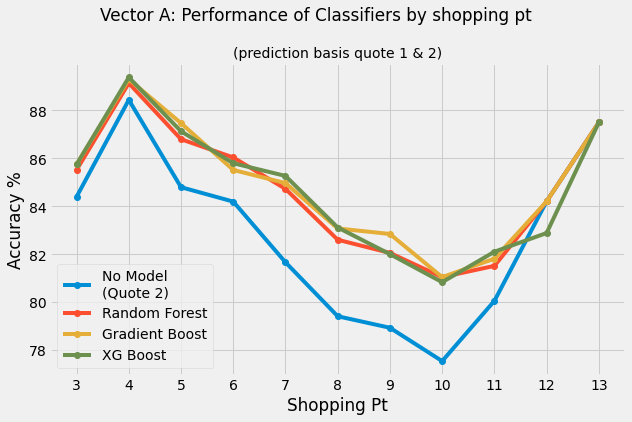

In [521]:
plt.style.use('fivethirtyeight')

vector = 'A'
#models = ['no_model', 'rf', 'gb', 'xg', 'lr']
models = ['no_model', 'rf', 'gb', 'xg']
quotes = [1,2]
model_performance_plot(vector, models, quotes, "overall")
model_performance_plot(vector, models, quotes, "shopping_pt")

### Vector E: Training Models<a id='Phase1_step3.4'></a>

Random Forest Classifier results for Vector E

Accuracy=0.839
f1-score=0.838
Confusion Matrix
 [[0.886 0.114]
 [0.216 0.784]]

Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      8425
           1       0.85      0.78      0.82      7097

    accuracy                           0.84     15522
   macro avg       0.84      0.83      0.84     15522
weighted avg       0.84      0.84      0.84     15522

Area under ROC: 
 0.8959355083374135
30


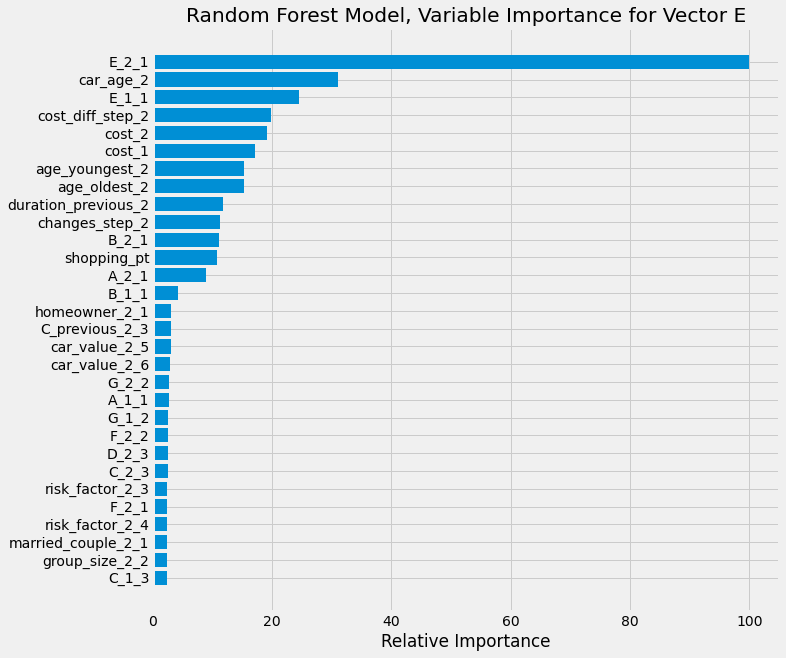

In [325]:
# Let's run the Random Forest model for vector E

vector = 'E'

rf_ac, rf_f1, rf_probs, rf_preds = rf_predict_plot(vector, plot = True)


In [364]:
#test_set = df_train_first2.iloc[y_test.index,:]
vector = 'E'
x = pd.crosstab(test_set['E'], test_set['E_2'])

same_as_2 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 
acc = np.around(np.sum(same_as_2)/y_test.shape[0], 4)

print(f"Accuracy based on simply predicting vector {vector} = {vector}_2 : {(np.sum(same_as_2)/y_test.shape[0]): 4.4}")

Accuracy based on simply predicting vector E = E_2 :  0.8319


In [324]:
x['total'] = x.sum(axis=1)
x['E_%'] = np.around(x[0]*100 / x['total'], 2)
x['E1_%'] = np.around(x[1]*100 / x['total'], 2)

x

E_2     0     1  total    E_%   E1_%
E                                   
0    7382  1043   8425  87.62  12.38
1    1567  5530   7097  22.08  77.92

In [280]:
# Now let's try a Grid Search CV to find the best Random Forest classifier

vector = 'E'

param_grid = {'n_estimators' : np.arange(100,801,100)}

rf = RandomForestClassifier(random_state = 1, n_jobs=-1)

rf_cv = GridSearchCV(rf, param_grid, cv=5)

rf_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print("Random Forest Model\nBest Score:" + str(rf_cv.best_score_))
print("\nBest Parameters: " + str(rf_cv.best_params_)) 

Random Forest Model
Best Score:0.8429572360473545

Best Parameters: {'n_estimators': 100}


Random Forest Classifier results for Vector E
Parameters: No. of Estimators = 100,  min_samples_leaf = 1,     min_samples_split = 2
Accuracy=0.8396, f1-score=0.8389
Confusion Matrix - normalized
 [[0.8857 0.1143]
 [0.2152 0.7848]]
Confusion Matrix
 [[7462  963]
 [1527 5570]]

Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      8425
           1       0.85      0.78      0.82      7097

    accuracy                           0.84     15522
   macro avg       0.84      0.84      0.84     15522
weighted avg       0.84      0.84      0.84     15522

30


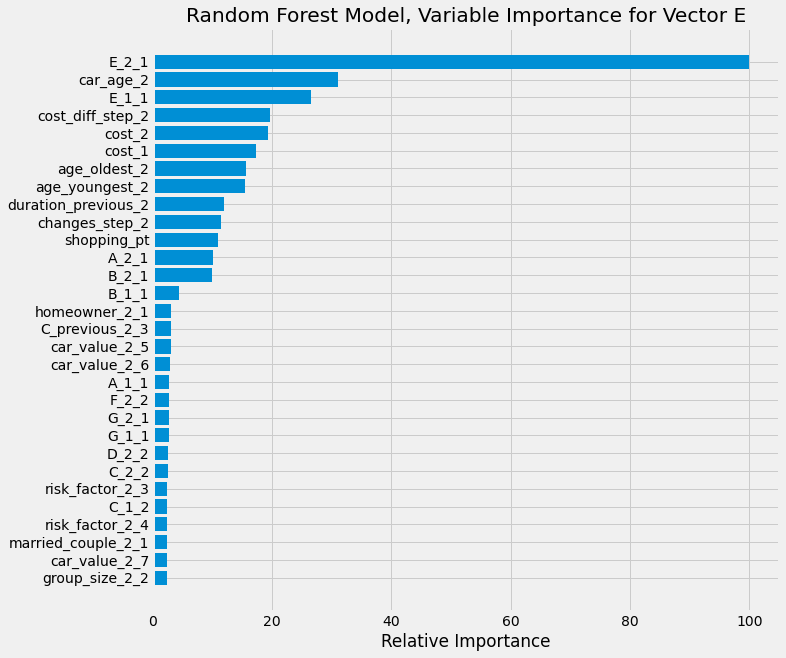

In [365]:
#Let's run the model with Best Parameters: {'n_estimators': 100}

vector = 'E'

rf_ac, rf_f1, rf_probs, rf_preds = rf_predict_plot(vector, n_estimators = 100, plot = True)


In [372]:
vector = 'E'
score_matrix = model_score_matrix(vector, 2, rf_preds)
score_matrix

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)


Pred_incorrect  Pred_correct  Pred_accuracy_%
cust_changed_vector               2394           216             8.28
cust_maintained_vector              96         12816            99.26

In [373]:
vector='E'
model = 'rf'

score = model_score_by_shopping_pt(vector, 2, rf_preds)

perf_q1q2.update(vector, 'no_model', 'overall', acc*100)
perf_q1q2.update(vector, model, 'overall', round(rf_ac*100,2))
perf_q1q2.update(vector, model, 'customer_type', score_matrix)
perf_q1q2.update(vector, model, 'shopping_pt', score)
perf_q1q2.compare(vector, model)
perf_q1q2.record[vector]


C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple

no_model       rf rf_vs_no_model
accuracy_overall                               83.19    83.96           0.77
accuracy_cust_changed_vector                       0     8.28           8.28
accuracy_cust_maintained_vector                  100    99.26          -0.74
accuracy_shopping_pt_3                         86.42    86.76           0.34
accuracy_shopping_pt_4                         88.75    88.98           0.23
accuracy_shopping_pt_5                         85.58    86.25           0.67
accuracy_shopping_pt_6                         84.08    84.48            0.4
accuracy_shopping_pt_7                         82.92    83.69           0.77
accuracy_shopping_pt_8                         81.09    82.17           1.08
accuracy_shopping_pt_9                         81.28    82.64           1.36
accuracy_shopping_pt_10                        79.09    80.43           1.34
accuracy_shopping_pt_11                         78.3    78.59           0.29
accuracy_shopping_pt_12                         75.0    73.68          -1.32
accuracy_shopping_pt_13                         75.0    75.00            0.0
accuracy_shopping_pt_cust_changed_vector       216.0  2394.00         2178.0
accuracy_shopping_pt_cust_maintained_vector  12816.0    96.00       -12720.0

In [374]:
# model with Logistic Regression classifier

vector = 'E'

lr_ac, lr_f1, lr_probs, lr_preds = lr_predict(vector)


Logistic Regression for vector E
Accuracy = 0.8352, f1-score = 0.8346

Confusion Matrix - normalized
 [[0.8785 0.1215]
 [0.2161 0.7839]]
Confusion Matrix
 [[7401 1024]
 [1534 5563]]

Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.88      0.85      8425
           1       0.84      0.78      0.81      7097

    accuracy                           0.84     15522
   macro avg       0.84      0.83      0.83     15522
weighted avg       0.84      0.84      0.83     15522


Area under ROC: 
 0.8907563316133494


C:\Users\amite\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [375]:
vector = 'E'
score_matrix = model_score_matrix(vector, 2, lr_preds)
score_matrix

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)


Pred_incorrect  Pred_correct  Pred_accuracy_%
cust_changed_vector               2489           121             4.64
cust_maintained_vector              69         12843            99.47

In [376]:
vector='E'
model = 'lr'

score = model_score_by_shopping_pt(vector, 2, lr_preds)

perf_q1q2.update(vector, 'no_model', 'overall', acc*100)
perf_q1q2.update(vector, model, 'overall', round(lr_ac*100,2))
perf_q1q2.update(vector, model, 'customer_type', score_matrix)
perf_q1q2.update(vector, model, 'shopping_pt', score)
perf_q1q2.compare(vector, model)
perf_q1q2.record[vector]

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple

no_model       rf rf_vs_no_model  \
accuracy_overall                               83.19    83.96           0.77   
accuracy_cust_changed_vector                       0     8.28           8.28   
accuracy_cust_maintained_vector                  100    99.26          -0.74   
accuracy_shopping_pt_3                         86.42    86.76           0.34   
accuracy_shopping_pt_4                         88.75    88.98           0.23   
accuracy_shopping_pt_5                         85.58    86.25           0.67   
accuracy_shopping_pt_6                         84.08    84.48            0.4   
accuracy_shopping_pt_7                         82.92    83.69           0.77   
accuracy_shopping_pt_8                         81.09    82.17           1.08   
accuracy_shopping_pt_9                         81.28    82.64           1.36   
accuracy_shopping_pt_10                        79.09    80.43           1.34   
accuracy_shopping_pt_11                         78.3    78.59           0.29   
accuracy_shopping_pt_12                         75.0    73.68          -1.32   
accuracy_shopping_pt_13                         75.0    75.00            0.0   
accuracy_shopping_pt_cust_changed_vector       216.0  2394.00         2178.0   
accuracy_shopping_pt_cust_maintained_vector  12816.0    96.00       -12720.0   

                                                lr lr_vs_no_model  
accuracy_overall                             83.52           0.33  
accuracy_cust_changed_vector                  4.64           4.64  
accuracy_cust_maintained_vector              99.47          -0.53  
accuracy_shopping_pt_3                       86.31          -0.11  
accuracy_shopping_pt_4                       88.91           0.16  
accuracy_shopping_pt_5                       85.86           0.28  
accuracy_shopping_pt_6                       84.36           0.28  
accuracy_shopping_pt_7                       83.19           0.27  
accuracy_shopping_pt_8                       81.49            0.4  
accuracy_shopping_pt_9                       82.01           0.73  
accuracy_shopping_pt_10                      79.92           0.83  
accuracy_shopping_pt_11                      77.71          -0.59  
accuracy_shopping_pt_12                      75.00            0.0  
accuracy_shopping_pt_13                      75.00            0.0  
accuracy_shopping_pt_cust_changed_vector       NaN            NaN  
accuracy_shopping_pt_cust_maintained_vector    NaN            NaN

Gradient Boosting Classifier results for Vector E

Accuracy=0.840
f1-score=0.839
Confusion Matrix
 [[0.89 0.11]
 [0.22 0.78]]

Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      8425
           1       0.86      0.78      0.82      7097

    accuracy                           0.84     15522
   macro avg       0.84      0.84      0.84     15522
weighted avg       0.84      0.84      0.84     15522


Area under ROC: 
 0.8962893921408678


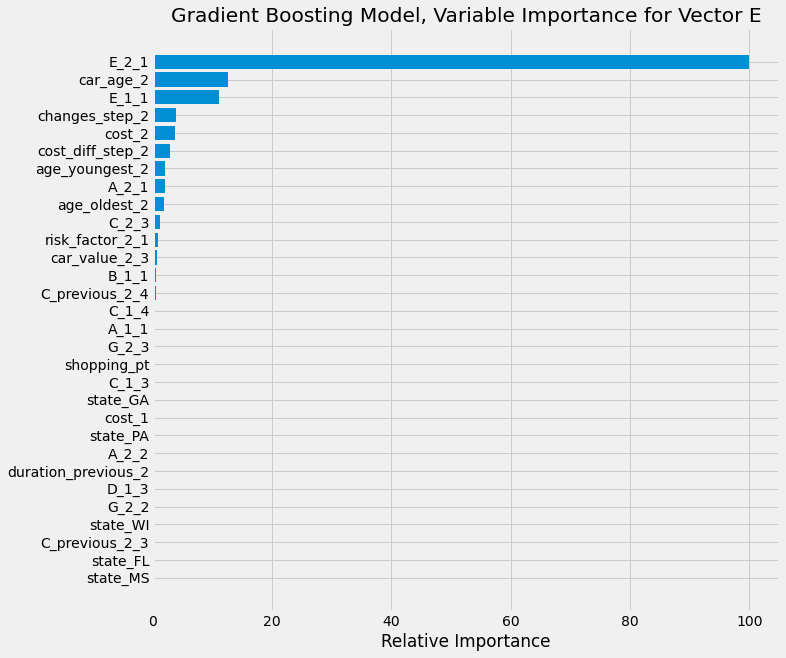

In [330]:
# model E with GradientBoosting classifier

vector = 'E'

gb_ac, gb_f1, gb_probs, gb_preds = gb_predict_plot(vector, n_estimators = 150, learning_rate = 0.25, max_depth = 3, \
                                         max_features = 6, plot=True)



In [341]:
from bayes_opt import BayesianOptimization

vector = 'E'

def gbm_eval(estimators, lrng_rate, max_d, max_f):
    
    gb = GradientBoostingClassifier(n_estimators = round(estimators), learning_rate = lrng_rate, \
                                    max_depth = round(max_d), max_features = round(max_f), random_state = 1)
    
    cv_result = cross_validate(gb, X_train.to_numpy(), y_train[vector].astype('int'), cv= 5)
    return np.mean(cv_result['test_score'])

gb_bo = BayesianOptimization(gbm_eval, {'estimators': (20, 200), 'lrng_rate': (0.05, 1), \
                                                'max_d': (1, 4), 'max_f': (2,8) })

gb_bo.maximize(n_iter=15, init_points=2)

|   iter    |  target   | estima... | lrng_rate |   max_d   |   max_f   |
-------------------------------------------------------------------------
|  1        |  0.8403   |  120.1    |  0.8081   |  2.958    |  4.365    |
|  2        |  0.837    |  103.2    |  0.2      |  1.02     |  6.092    |
|  3        |  0.838    |  58.13    |  0.982    |  1.263    |  4.659    |
|  4        |  0.8424   |  169.3    |  0.1971   |  3.306    |  6.265    |
|  5        |  0.8391   |  143.0    |  0.5588   |  3.987    |  7.719    |
|  6        |  0.8385   |  99.19    |  0.836    |  2.086    |  2.744    |
|  7        |  0.839    |  173.7    |  0.8416   |  2.963    |  4.689    |
|  8        |  0.8407   |  57.25    |  0.7485   |  1.549    |  7.205    |
|  9        |  0.832    |  144.5    |  0.932    |  3.894    |  5.983    |
|  10       |  0.8361   |  85.45    |  0.1008   |  1.892    |  4.504    |
|  11       |  0.8394   |  155.1    |  0.1585   |  2.443    |  6.269    |
|  12       |  0.8428   |  193.5    | 

So we got two models with very similar test_scores: 

* Test_Score: 0.8424, n_estimators = 169, learning_rate = 0.1971, max_depth = 3, max_features = 6
* Test_Score: 0.8428, n_estimators = 194, learning_rate = 0.7093, max_depth = 2, max_features = 6

Let's try both model to make predictions on the test set.


Gradient Boosting Classifier results for Vector E

Accuracy=0.839
f1-score=0.839
Confusion Matrix
 [[0.882 0.118]
 [0.211 0.789]]

Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.88      0.86      8425
           1       0.85      0.79      0.82      7097

    accuracy                           0.84     15522
   macro avg       0.84      0.84      0.84     15522
weighted avg       0.84      0.84      0.84     15522


Area under ROC: 
 0.8961560135954131


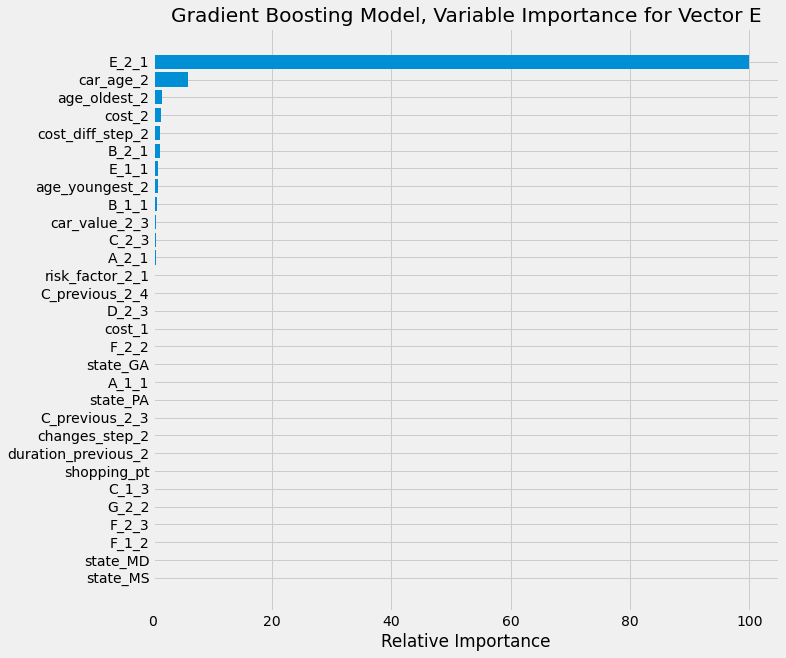

In [342]:
# Best GradientBoosting classifier for vector E

vector = 'E'

gb_ac, gb_f1, gb_probs, gb_preds = gb_predict_plot(vector, n_estimators = 194, learning_rate = 0.7093, max_depth = 2, \
                                         max_features = 6, plot=True)


The above model has a slightly lower accuracy score (0.839) vs the accuracy score (0.84) that we got in our base GB model.
Now let's try the second set of hyperparamters.

Gradient Boosting Classifier results for Vector E
Parameters: No. of Estimators = 169,  max_depth = 3,     learning_rate = 0.1971, max_features = 6
Accuracy=0.8395, f1-score=0.8386
Confusion Matrix - normalized
 [[0.8893 0.1107]
 [0.2197 0.7803]]
Confusion Matrix
 [[7492  933]
 [1559 5538]]

Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      8425
           1       0.86      0.78      0.82      7097

    accuracy                           0.84     15522
   macro avg       0.84      0.83      0.84     15522
weighted avg       0.84      0.84      0.84     15522

30


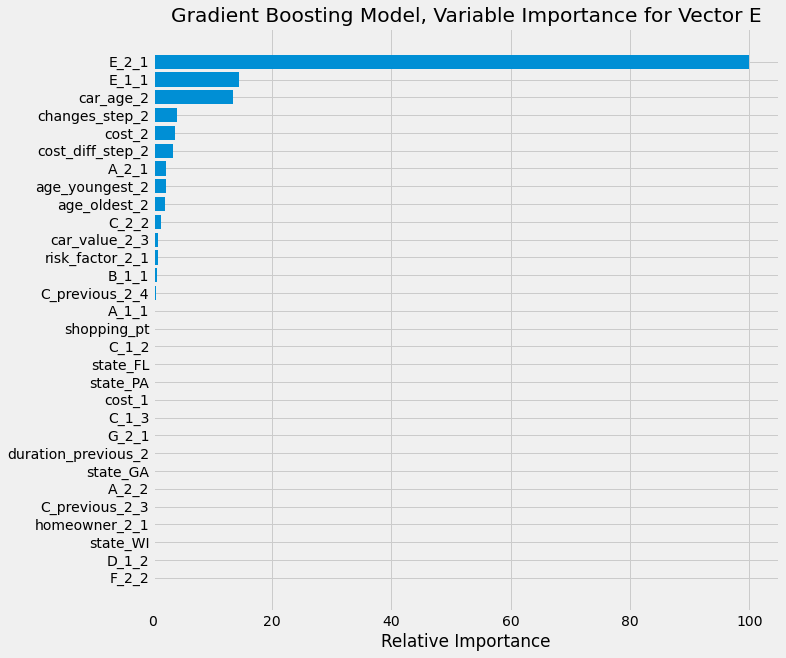

In [206]:
# 2nd Best GradientBoosting classifier (based on Bayesian Optimization) for vector E

vector = 'E'

gb_ac, gb_f1, gb_probs, gb_preds = gb_predict_plot(vector, n_estimators = 169, learning_rate = 0.1971, max_depth = 3, \
                                         max_features = 6, plot=True)



Both models based on Bayesian Optimization hyperparameters have slightly lower accuracy score (0.839) vs the accuracy score (0.84) that we got in our base GB model. Let's try couple of more hyperparamters setting - the hunch is to use base model, but only increase estimators from 150 to 200.

Gradient Boosting Classifier results for Vector E

Accuracy=0.840
f1-score=0.839
Confusion Matrix
 [[0.889 0.111]
 [0.218 0.782]]

Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      8425
           1       0.86      0.78      0.82      7097

    accuracy                           0.84     15522
   macro avg       0.84      0.84      0.84     15522
weighted avg       0.84      0.84      0.84     15522


Area under ROC: 
 0.8972704059766969


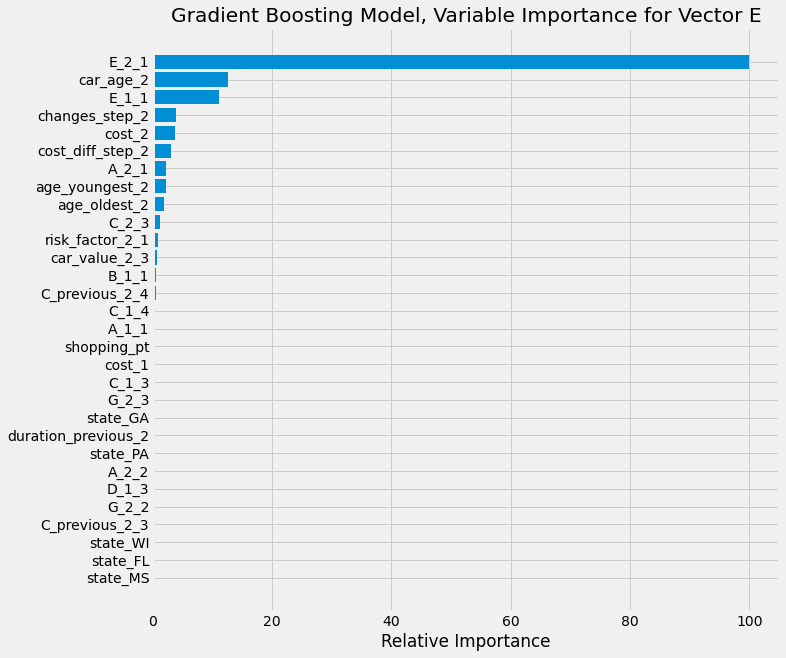

In [344]:
# Let's try another model based on our base model, and increase n_estimators from 150 to 200.
vector = 'E'
gb_ac, gb_f1, gb_probs, gb_preds = gb_predict_plot(vector, n_estimators = 200, max_depth = 3, \
                                         learning_rate = 0.25, max_features = 6, plot=True)


This model gives a slightly better auc of 0.8973 vs 0.8963 of base model. Now let's try to increase learning rate to 0.5 and check accuracy scores and auc.

Gradient Boosting Classifier results for Vector E
Parameters: No. of Estimators = 200,  max_depth = 3,     learning_rate = 0.5, max_features = 6
Accuracy=0.841, f1-score=0.8403
Confusion Matrix - normalized
 [[0.8858 0.1142]
 [0.2122 0.7878]]
Confusion Matrix
 [[7463  962]
 [1506 5591]]

Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      8425
           1       0.85      0.79      0.82      7097

    accuracy                           0.84     15522
   macro avg       0.84      0.84      0.84     15522
weighted avg       0.84      0.84      0.84     15522

30


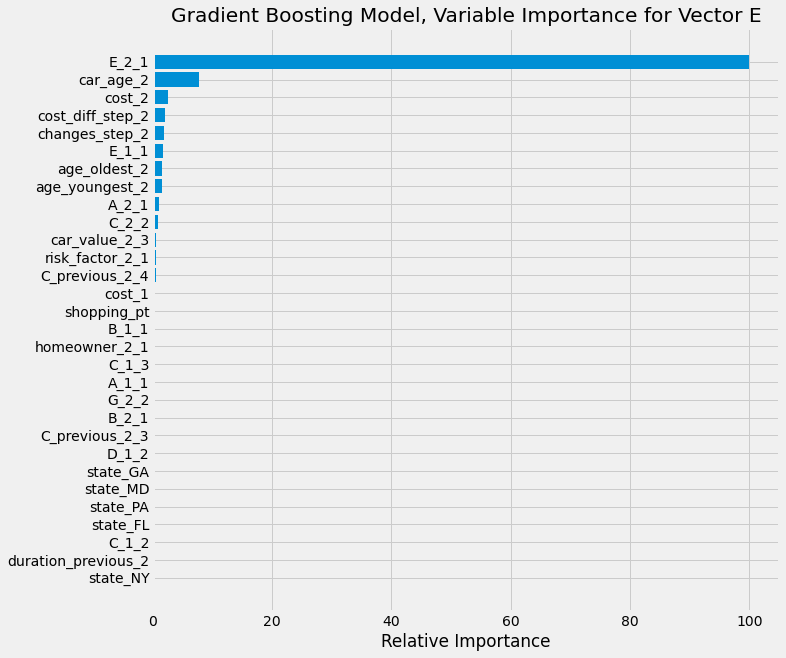

In [377]:
#Let's increase learning rate to 0.5 (BEST MODEL)

vector = 'E'

gb_ac, gb_f1, gb_probs, gb_preds = gb_predict_plot(vector, n_estimators = 200, learning_rate = 0.5, max_depth = 3, \
                                         max_features = 6, plot=True)


The accuracy score went up from 0.84 to 0.841! And a marginal increase in auc as well (0.89755).
LEt's try to go for 250 estimators and check the results.



In [378]:
vector = 'E'
score_matrix = model_score_matrix(vector, 2, gb_preds)
score_matrix


C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)


Pred_incorrect  Pred_correct  Pred_accuracy_%
cust_changed_vector               2304           306            11.72
cust_maintained_vector             164         12748            98.73

In [379]:
vector='E'
model = 'gb'

score = model_score_by_shopping_pt(vector, 2, gb_preds)

#perf_q1q2.update(vector, 'no_model', 'overall', acc*100)
perf_q1q2.update(vector, model, 'overall', round(gb_ac*100,2))
perf_q1q2.update(vector, model, 'customer_type', score_matrix)
perf_q1q2.update(vector, model, 'shopping_pt', score)
perf_q1q2.compare(vector, model)
perf_q1q2.record[vector]

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple

no_model       rf rf_vs_no_model  \
accuracy_overall                               83.19    83.96           0.77   
accuracy_cust_changed_vector                       0     8.28           8.28   
accuracy_cust_maintained_vector                  100    99.26          -0.74   
accuracy_shopping_pt_3                         86.42    86.76           0.34   
accuracy_shopping_pt_4                         88.75    88.98           0.23   
accuracy_shopping_pt_5                         85.58    86.25           0.67   
accuracy_shopping_pt_6                         84.08    84.48            0.4   
accuracy_shopping_pt_7                         82.92    83.69           0.77   
accuracy_shopping_pt_8                         81.09    82.17           1.08   
accuracy_shopping_pt_9                         81.28    82.64           1.36   
accuracy_shopping_pt_10                        79.09    80.43           1.34   
accuracy_shopping_pt_11                         78.3    78.59           0.29   
accuracy_shopping_pt_12                         75.0    73.68          -1.32   
accuracy_shopping_pt_13                         75.0    75.00            0.0   
accuracy_shopping_pt_cust_changed_vector       216.0  2394.00         2178.0   
accuracy_shopping_pt_cust_maintained_vector  12816.0    96.00       -12720.0   

                                                lr lr_vs_no_model     gb  \
accuracy_overall                             83.52           0.33  84.10   
accuracy_cust_changed_vector                  4.64           4.64  11.72   
accuracy_cust_maintained_vector              99.47          -0.53  98.73   
accuracy_shopping_pt_3                       86.31          -0.11  86.53   
accuracy_shopping_pt_4                       88.91           0.16  89.14   
accuracy_shopping_pt_5                       85.86           0.28  86.63   
accuracy_shopping_pt_6                       84.36           0.28  84.80   
accuracy_shopping_pt_7                       83.19           0.27  83.69   
accuracy_shopping_pt_8                       81.49            0.4  82.57   
accuracy_shopping_pt_9                       82.01           0.73  82.48   
accuracy_shopping_pt_10                      79.92           0.83  80.43   
accuracy_shopping_pt_11                      77.71          -0.59  78.89   
accuracy_shopping_pt_12                      75.00            0.0  72.37   
accuracy_shopping_pt_13                      75.00            0.0  62.50   
accuracy_shopping_pt_cust_changed_vector       NaN            NaN    NaN   
accuracy_shopping_pt_cust_maintained_vector    NaN            NaN    NaN   

                                            gb_vs_no_model  
accuracy_overall                                      0.91  
accuracy_cust_changed_vector                         11.72  
accuracy_cust_maintained_vector                      -1.27  
accuracy_shopping_pt_3                                0.11  
accuracy_shopping_pt_4                                0.39  
accuracy_shopping_pt_5                                1.05  
accuracy_shopping_pt_6                                0.72  
accuracy_shopping_pt_7                                0.77  
accuracy_shopping_pt_8                                1.48  
accuracy_shopping_pt_9                                 1.2  
accuracy_shopping_pt_10                               1.34  
accuracy_shopping_pt_11                               0.59  
accuracy_shopping_pt_12                              -2.63  
accuracy_shopping_pt_13                              -12.5  
accuracy_shopping_pt_cust_changed_vector               NaN  
accuracy_shopping_pt_cust_maintained_vector            NaN

In [353]:
#Let's run a base knn model for vector E

vector = 'E'

kn_ac, kn_f1, kn_probs, kn_preds = kn_predict(vector, n_neighbors=5)


KNN Model for Vector E: No. of Neighbors = 5
Accuracy=0.779
f1-score=0.779
Confusion Matrix
 [[0.79  0.21 ]
 [0.233 0.767]]

Classification Report 
               precision    recall  f1-score   support

           0       0.80      0.79      0.80      8425
           1       0.75      0.77      0.76      7097

    accuracy                           0.78     15522
   macro avg       0.78      0.78      0.78     15522
weighted avg       0.78      0.78      0.78     15522


Area under ROC: 
 0.8386927062841364


In [354]:
#Let's use Bayesian Optimization to find the best n_neighbors parameter

from bayes_opt import BayesianOptimization

vector = 'E'

def knn_eval(no_of_neighbors):
    
    knn = KNeighborsClassifier(n_neighbors= round(no_of_neighbors))
    
    cv_result = cross_validate(knn, X_train.to_numpy(), y_train[vector].astype('int'), cv= 5)
    return np.mean(cv_result['test_score'])

knn_bo = BayesianOptimization(knn_eval, {'no_of_neighbors': (1, 50)})

knn_bo.maximize(n_iter=10, init_points=2)

|   iter    |  target   | no_of_... |
-------------------------------------
|  1        |  0.8104   |  43.9     |
|  2        |  0.7203   |  1.628    |
|  3        |  0.8095   |  45.22    |
|  4        |  0.8086   |  27.66    |
|  5        |  0.8083   |  34.51    |
|  6        |  0.8044   |  20.52    |
|  7        |  0.8098   |  50.0     |
|  8        |  0.8087   |  39.32    |
|  9        |  0.8078   |  24.19    |
|  10       |  0.8077   |  31.12    |
|  11       |  0.8101   |  42.12    |
|  12       |  0.8092   |  43.17    |


In [355]:

knn_bo = BayesianOptimization(knn_eval, {'no_of_neighbors': (51, 100)})

knn_bo.maximize(n_iter=5, init_points=1)

|   iter    |  target   | no_of_... |
-------------------------------------
|  1        |  0.81     |  79.68    |
|  2        |  0.8085   |  97.24    |
|  3        |  0.81     |  86.41    |
|  4        |  0.8101   |  70.08    |
|  5        |  0.81     |  71.68    |
|  6        |  0.8105   |  59.86    |


Based on Bayesian Optimization, the best n_neighbors value is 60. Let's use this to train a model and predict vector E.

In [356]:
# knn model for vector E with n_neighbors = 60

vector = 'E'
knn = KNeighborsClassifier(n_neighbors=60)

knn.fit(X_train.to_numpy(), y_train[vector].astype('int'))

y_pred = knn.predict(X_test.to_numpy())
y_pred_prob = knn.predict_proba(X_test.to_numpy())
kn_probs = y_pred_prob[:,1]

ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'), 3)

print(f'KNN Model for Vector {vector}: No. of Neighbors = 60' )

print('Accuracy=%.3f' % (ac))
print('f1-score=%.3f' % (f1))
print("Confusion Matrix\n", cm)

fpr_4, tpr_4, thresholds_4 = roc_curve(y_test[vector].astype('int'), kn_probs)
roc_auc4 = auc(fpr_4, tpr_4)

cr = classification_report(y_test[vector].astype('int'), y_pred)

print("\nClassification Report \n", cr)
print("\nArea under ROC: \n", roc_auc4)

KNN Model for Vector E: No. of Neighbors = 60
Accuracy=0.809
f1-score=0.809
Confusion Matrix
 [[0.837 0.163]
 [0.224 0.776]]

Classification Report 
               precision    recall  f1-score   support

           0       0.82      0.84      0.83      8425
           1       0.80      0.78      0.79      7097

    accuracy                           0.81     15522
   macro avg       0.81      0.81      0.81     15522
weighted avg       0.81      0.81      0.81     15522


Area under ROC: 
 0.8715034354383031


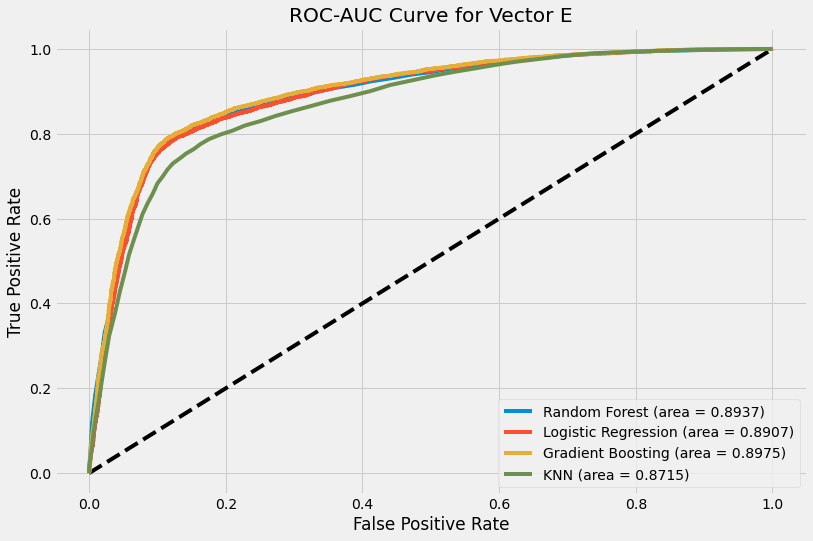

In [359]:
# Let's plot the ROC curve for all the models for vector E
plt.figure(figsize=(12,8))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1, tpr_1, label='Random Forest (area = 0.8937)')
plt.plot(fpr_2, tpr_2, label='Logistic Regression (area = 0.8907)')
plt.plot(fpr_3, tpr_3, label='Gradient Boosting (area = 0.8975)')
plt.plot(fpr_4, tpr_4, label='KNN (area = 0.8715)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Vector '+vector)
plt.legend()
plt.show()


Best Threshold for Gradient Boost Model for Vector E = 0.4546
At Best Threshold, tpr =  0.8, fpr = 0.126


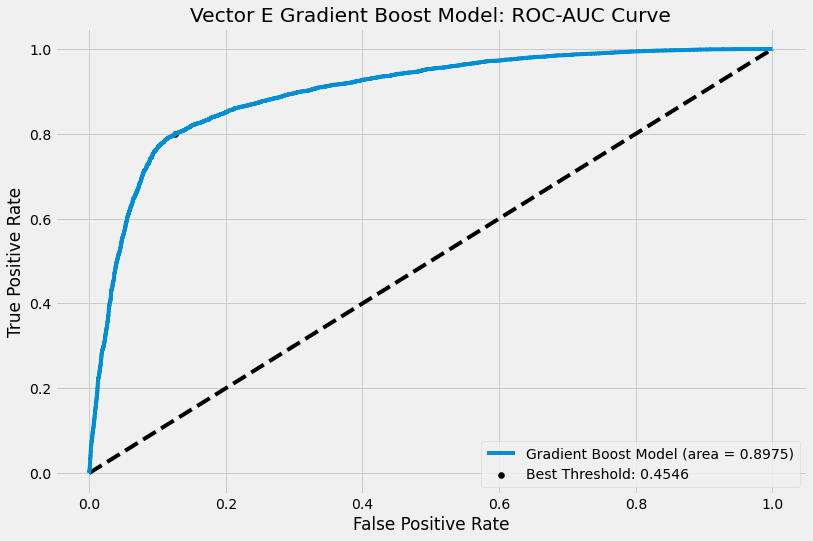

In [367]:
# Let's do thresholding for the best Model for vector E: Gradient Boost

plt.figure(figsize=(12,8))

Q_means_gb = np.sqrt(tpr_3*(1-fpr_3))
idx = np.argmax(Q_means_gb)

print(f'Best Threshold for Gradient Boost Model for Vector E = {thresholds_3[idx]:5.4}')
print(f'At Best Threshold, tpr = {tpr_3[idx]:4.3}, fpr = {fpr_3[idx]:4.3}')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_3, tpr_3, label='Gradient Boost Model (area = 0.8975)')
pyplot.scatter(fpr_3[idx], tpr_3[idx], marker='o', color='black', label='Best Threshold: '+str(np.round(thresholds_3[idx],4)))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Vector E Gradient Boost Model: ROC-AUC Curve')
plt.legend()
plt.show()

Vector E Gradient Boost Model
Best Accuracy score of 0.8416 occurs for threshold = 0.493
Vector E Random Forest Model
Best Accuracy score of 0.8396 occurs for threshold = 0.501
Vector E XG Boost Model
Best Accuracy score of 0.8424 occurs for threshold = 0.505


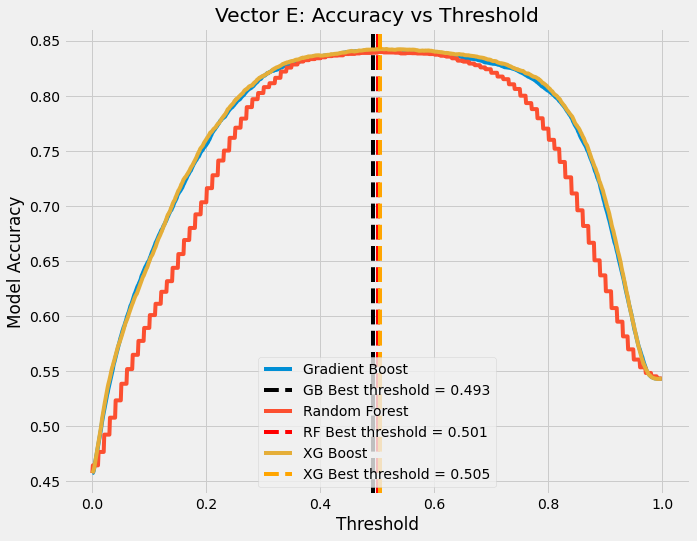

In [53]:
# We are concerned with accuracy of the model i.e. its ability to predict both the 0 and 1 labels correctly
# So we will calculate the accuracy score at different thresholds directly


plt.figure(figsize=(10,8))

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

thresholds = np.arange(0, 1, 0.001)

# for gradient boost model
ac_score_gb = [accuracy_score(y_test[vector].astype('int'), to_labels(gb_probs, t)) for t in thresholds]
idx = np.argmax(ac_score_gb)
print(f"Vector E Gradient Boost Model\nBest Accuracy score of {ac_score_gb[idx]:4.4} occurs for threshold = {thresholds[idx]:4.4}")
plt.plot(thresholds, ac_score_gb, label='Gradient Boost')
plt.axvline(thresholds[idx], color='black', linestyle="--", label = "GB Best threshold = "+str(np.round(thresholds[idx],4)))

# for random forest
thresholds = np.arange(0, 1, 0.001)
ac_score_rf = [accuracy_score(y_test[vector].astype('int'), to_labels(rf_probs, t)) for t in thresholds]
idx = np.argmax(ac_score_rf)
print(f"Vector E Random Forest Model\nBest Accuracy score of {ac_score_rf[idx]:4.4} occurs for threshold = {thresholds[idx]:4.4}")
plt.plot(thresholds, ac_score_rf, label='Random Forest')
plt.axvline(thresholds[idx], color='red', linestyle="--", label = "RF Best threshold = "+str(np.round(thresholds[idx],4)))

# for XG Boost
thresholds = np.arange(0, 1, 0.001)
ac_score_xg = [accuracy_score(y_test[vector].astype('int'), to_labels(xg_probs, t)) for t in thresholds]
idx = np.argmax(ac_score_xg)
print(f"Vector E XG Boost Model\nBest Accuracy score of {ac_score_xg[idx]:4.4} occurs for threshold = {thresholds[idx]:4.4}")
plt.plot(thresholds, ac_score_xg, label='XG Boost')
plt.axvline(thresholds[idx], color='orange', linestyle="--", label = "XG Best threshold = "+str(np.round(thresholds[idx],4)))

plt.xlabel('Threshold')
plt.ylabel('Model Accuracy')
plt.title('Vector E: Accuracy vs Threshold')

plt.legend()
plt.show()

In [ ]:
# Let's use RandomizedSearchCV to find the best XGB classifier Hyperparamters for vector E

import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV

vector = 'E'

param_grid = {'learning_rate' : [0.25, 0.3, 0.35, 0.5], 'n_estimators' : np.arange(100,501,100), \
              'colsample_bytree': [0.15,0.25,0.35,0.5], 'max_depth' : [3,4,5]}

clf = xgb.XGBClassifier(objective='binary:logistic', random_state=1, n_jobs=-1)

clf_cv = RandomizedSearchCV(clf, param_grid, n_iter = 60, verbose = 3, cv=4)

clf_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print(f"Vector {vector} RandomizedSearchCV: XG Boosting Model\nBest Score:" + str(clf_cv.best_score_))
print("\nBest Parameters: " + str(clf_cv.best_params_))

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=400;, score=0.841 total time=  14.9s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=400;, score=0.840 total time=  15.9s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=400;, score=0.839 total time=  16.2s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=400;, score=0.839 total time=  16.2s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=5, n_estimators=300;, score=0.840 total time=  11.8s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=5, n_estimators=300;, score=0.841 total time=  11.4s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=5, n_estimators=300;, score=0.840 total time=  12.3s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=5, n_estimators=300;, score=0.838 total time=  

In [ ]:
results = pd.DataFrame(clf_cv.cv_results_['params'])
results['train_score'] = clf_cv.cv_results_['mean_test_score']
results['train_rank'] = clf_cv.cv_results_['rank_test_score']
results = pd.read_csv('Modelling_data/xgboost_results_vectorE.csv')

In [6]:
import xgboost as xgb

vector = 'E'

print(f"XGBoost Classifier results for Vector {vector}\n")
#param_grid
for i, row in results.iterrows():
    n_estimators = row['n_estimators']
    max_depth = row['max_depth']
    learning_rate = row['learning_rate']
    colsample_bytree = row['colsample_bytree']
        
    clf = xgb.XGBClassifier(max_depth=int(max_depth), objective='binary:logistic', n_estimators=int(n_estimators), \
                       learning_rate = learning_rate, colsample_bytree = colsample_bytree, n_jobs=-1, random_state=1)

    clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = clf.predict(X_test.to_numpy())
    y_pred_prob = clf.predict_proba(X_test.to_numpy())
    xg_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
    cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

    results.loc[i, 'test_score'] = ac
    results.loc[i, 'f1_score'] = f1
    
    print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}, \
    learning_rate = {learning_rate}, colsample_bytree = {colsample_bytree}")

    print(f'Accuracy={ac:4.4}, f1_score={f1:4.4}')

results['test_rank']= results['test_score'].rank(method='dense', ascending=False)
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
datapath="Modelling_data"
save_file(results,"xgboost_results_vectorE.csv",datapath)
results

XGBoost Classifier results for Vector E

Parameters: No. of Estimators = 400.0,  max_depth = 4.0,     learning_rate = 0.3, colsample_bytree = 0.5
Accuracy=0.8382, f1_score=0.8377
Parameters: No. of Estimators = 300.0,  max_depth = 5.0,     learning_rate = 0.25, colsample_bytree = 0.35
Accuracy=0.839, f1_score=0.8384
Parameters: No. of Estimators = 200.0,  max_depth = 4.0,     learning_rate = 0.3, colsample_bytree = 0.35
Accuracy=0.8404, f1_score=0.8398
Parameters: No. of Estimators = 400.0,  max_depth = 4.0,     learning_rate = 0.5, colsample_bytree = 0.25
Accuracy=0.8359, f1_score=0.8354
Parameters: No. of Estimators = 300.0,  max_depth = 5.0,     learning_rate = 0.25, colsample_bytree = 0.25
Accuracy=0.8387, f1_score=0.8382
Parameters: No. of Estimators = 400.0,  max_depth = 3.0,     learning_rate = 0.25, colsample_bytree = 0.5
Accuracy=0.842, f1_score=0.8414
Parameters: No. of Estimators = 300.0,  max_depth = 4.0,     learning_rate = 0.25, colsample_bytree = 0.15
Accuracy=0.8408, f1

Parameters: No. of Estimators = 300.0,  max_depth = 5.0,     learning_rate = 0.3, colsample_bytree = 0.15
Accuracy=0.8388, f1_score=0.8383


In [8]:
results['test_rank']= results['test_score'].rank(method='dense', ascending=False)
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
results

n_estimators  max_depth  learning_rate  colsample_bytree  train_score  \
0            400          4           0.30              0.50     0.839671   
1            300          5           0.25              0.35     0.839849   
2            200          4           0.30              0.35     0.842410   
3            400          4           0.50              0.25     0.834678   
4            300          5           0.25              0.25     0.841169   
5            400          3           0.25              0.50     0.843054   
6            300          4           0.25              0.15     0.842893   
7            200          4           0.50              0.25     0.839092   
8            100          5           0.50              0.35     0.838157   
9            400          3           0.50              0.35     0.838963   
10           200          3           0.35              0.25     0.842844   
11           100          3           0.25              0.25     0.841942   
12           100          3           0.50              0.50     0.842796   
13           400          5           0.25              0.50     0.837980   
14           500          5           0.35              0.25     0.834437   
15           200          5           0.50              0.35     0.833744   
16           400          5           0.35              0.50     0.833970   
17           400          3           0.35              0.35     0.841991   
18           200          3           0.30              0.50     0.843489   
19           500          4           0.30              0.50     0.838335   
20           500          3           0.50              0.25     0.839188   
21           400          4           0.25              0.25     0.841830   
22           200          3           0.35              0.50     0.842683   
23           500          3           0.30              0.25     0.842136   
24           400          4           0.35              0.35     0.839591   
25           400          5           0.50              0.25     0.828558   
26           500          4           0.50              0.50     0.830748   
27           500          4           0.30              0.25     0.839349   
28           100          5           0.30              0.50     0.842442   
29           200          5           0.35              0.50     0.838415   
30           300          4           0.30              0.50     0.841105   
31           500          4           0.30              0.35     0.840074   
32           300          3           0.50              0.35     0.839945   
33           500          4           0.25              0.25     0.841282   
34           500          4           0.35              0.50     0.836047   
35           100          3           0.25              0.35     0.842989   
36           300          3           0.30              0.35     0.843134   
37           500          5           0.25              0.35     0.836611   
38           100          3           0.50              0.25     0.842571   
39           500          4           0.25              0.50     0.839897   
40           100          5           0.35              0.35     0.842184   
41           300          4           0.30              0.15     0.842345   
42           200          5           0.25              0.15     0.842361   
43           400          5           0.35              0.15     0.837368   
44           100          3           0.25              0.15     0.839526   
45           500          5           0.30              0.35     0.835661   
46           400          4           0.35              0.15     0.840573   
47           300          4           0.35              0.25     0.840557   
48           300          5           0.50              0.50     0.829556   
49           400          3           0.30              0.35     0.842571   
50           500          3           0.35              0.25     0.841733   


In [10]:
datapath="Modelling_data"
save_file(results,"xgboost_results_vectorE.csv",datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "Modelling_data\xgboost_results_vectorE.csv"


XGBoost Classifier results for Vector E
Parameters: No. of Estimators = 400,  max_depth = 3,     learning_rate = 0.25, colsample_bytree = 0.5
Accuracy=0.842, f1-score=0.8414
Confusion Matrix - normalized
 [[0.8843 0.1157]
 [0.2081 0.7919]]
Confusion Matrix
 [[7450  975]
 [1477 5620]]

Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.88      0.86      8425
           1       0.85      0.79      0.82      7097

    accuracy                           0.84     15522
   macro avg       0.84      0.84      0.84     15522
weighted avg       0.84      0.84      0.84     15522

30


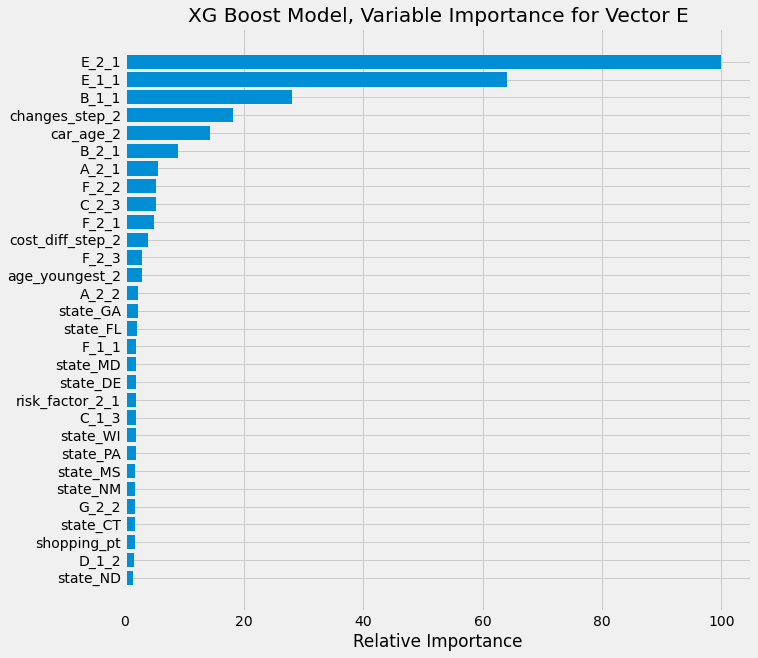

In [380]:
# model E with XGBoost classifier Best Parameters: Iteration 5 (above)

vector = 'E'
xg_ac, xg_f1, xg_probs, xg_preds = xg_predict_plot(vector, n_estimators = 400, max_depth = 3, \
                                         learning_rate = 0.25, colsample_bytree = 0.5, plot=True)


In [381]:
vector = 'E'
score_matrix = model_score_matrix(vector, 2, xg_preds)
score_matrix


C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)


Pred_incorrect  Pred_correct  Pred_accuracy_%
cust_changed_vector               2280           330            12.64
cust_maintained_vector             172         12740            98.67

In [382]:
vector='E'
model = 'xg'

score = model_score_by_shopping_pt(vector, 2, xg_preds)

#perf_q1q2.update(vector, 'no_model', 'overall', acc*100)
perf_q1q2.update(vector, model, 'overall', round(xg_ac*100,2))
perf_q1q2.update(vector, model, 'customer_type', score_matrix)
perf_q1q2.update(vector, model, 'shopping_pt', score)
perf_q1q2.compare(vector, model)
perf_q1q2.record[vector]


C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple

no_model       rf rf_vs_no_model  \
accuracy_overall                               83.19    83.96           0.77   
accuracy_cust_changed_vector                       0     8.28           8.28   
accuracy_cust_maintained_vector                  100    99.26          -0.74   
accuracy_shopping_pt_3                         86.42    86.76           0.34   
accuracy_shopping_pt_4                         88.75    88.98           0.23   
accuracy_shopping_pt_5                         85.58    86.25           0.67   
accuracy_shopping_pt_6                         84.08    84.48            0.4   
accuracy_shopping_pt_7                         82.92    83.69           0.77   
accuracy_shopping_pt_8                         81.09    82.17           1.08   
accuracy_shopping_pt_9                         81.28    82.64           1.36   
accuracy_shopping_pt_10                        79.09    80.43           1.34   
accuracy_shopping_pt_11                         78.3    78.59           0.29   
accuracy_shopping_pt_12                         75.0    73.68          -1.32   
accuracy_shopping_pt_13                         75.0    75.00            0.0   
accuracy_shopping_pt_cust_changed_vector       216.0  2394.00         2178.0   
accuracy_shopping_pt_cust_maintained_vector  12816.0    96.00       -12720.0   

                                                lr lr_vs_no_model     gb  \
accuracy_overall                             83.52           0.33  84.10   
accuracy_cust_changed_vector                  4.64           4.64  11.72   
accuracy_cust_maintained_vector              99.47          -0.53  98.73   
accuracy_shopping_pt_3                       86.31          -0.11  86.53   
accuracy_shopping_pt_4                       88.91           0.16  89.14   
accuracy_shopping_pt_5                       85.86           0.28  86.63   
accuracy_shopping_pt_6                       84.36           0.28  84.80   
accuracy_shopping_pt_7                       83.19           0.27  83.69   
accuracy_shopping_pt_8                       81.49            0.4  82.57   
accuracy_shopping_pt_9                       82.01           0.73  82.48   
accuracy_shopping_pt_10                      79.92           0.83  80.43   
accuracy_shopping_pt_11                      77.71          -0.59  78.89   
accuracy_shopping_pt_12                      75.00            0.0  72.37   
accuracy_shopping_pt_13                      75.00            0.0  62.50   
accuracy_shopping_pt_cust_changed_vector       NaN            NaN    NaN   
accuracy_shopping_pt_cust_maintained_vector    NaN            NaN    NaN   

                                            gb_vs_no_model     xg  \
accuracy_overall                                      0.91  84.20   
accuracy_cust_changed_vector                         11.72  12.64   
accuracy_cust_maintained_vector                      -1.27  98.67   
accuracy_shopping_pt_3                                0.11  86.42   
accuracy_shopping_pt_4                                0.39  88.91   
accuracy_shopping_pt_5                                1.05  86.69   
accuracy_shopping_pt_6                                0.72  84.76   
accuracy_shopping_pt_7                                0.77  83.39   
accuracy_shopping_pt_8                                1.48  82.68   
accuracy_shopping_pt_9                                 1.2  83.26   
accuracy_shopping_pt_10                               1.34  81.26   
accuracy_shopping_pt_11                               0.59  79.18   
accuracy_shopping_pt_12                              -2.63  73.68   
accuracy_shopping_pt_13                              -12.5  75.00   
accuracy_shopping_pt_cust_changed_vector               NaN    NaN   
accuracy_shopping_pt_cust_maintained_vector            NaN    NaN   

                                            xg_vs_no_model  
accuracy_overall                                      1.01  
accuracy_cust_changed_vector                         12.64  
accuracy_cust_maintained_vector  

In [115]:
perf_models_q1q2['E'].drop(['accuracy_shopping_pt_cust_maintained_vector'], axis=0,inplace=True)
perf_models_q1q2['E']


no_model     rf rf_vs_no_model     lr  \
accuracy_overall                   83.19  83.96           0.77  83.52   
accuracy_cust_changed_vector           0   8.28           8.28   4.64   
accuracy_cust_maintained_vector      100  99.26          -0.74  99.47   
accuracy_shopping_pt_3             86.42  86.76           0.34  86.31   
accuracy_shopping_pt_4             88.75  88.98           0.23  88.91   
accuracy_shopping_pt_5             85.58  86.25           0.67  85.86   
accuracy_shopping_pt_6             84.08  84.48            0.4  84.36   
accuracy_shopping_pt_7             82.92  83.69           0.77  83.19   
accuracy_shopping_pt_8             81.09  82.17           1.08  81.49   
accuracy_shopping_pt_9             81.28  82.64           1.36  82.01   
accuracy_shopping_pt_10            79.09  80.43           1.34  79.92   
accuracy_shopping_pt_11             78.3  78.59           0.29  77.71   
accuracy_shopping_pt_12             75.0  73.68          -1.32  75.00   
accuracy_shopping_pt_13             75.0  75.00            0.0  75.00   

                                lr_vs_no_model     gb gb_vs_no_model     xg  \
accuracy_overall                          0.33  84.10           0.91  84.20   
accuracy_cust_changed_vector              4.64  11.72          11.72  12.64   
accuracy_cust_maintained_vector          -0.53  98.73          -1.27  98.67   
accuracy_shopping_pt_3                   -0.11  86.53           0.11  86.42   
accuracy_shopping_pt_4                    0.16  89.14           0.39  88.91   
accuracy_shopping_pt_5                    0.28  86.63           1.05  86.69   
accuracy_shopping_pt_6                    0.28  84.80           0.72  84.76   
accuracy_shopping_pt_7                    0.27  83.69           0.77  83.39   
accuracy_shopping_pt_8                     0.4  82.57           1.48  82.68   
accuracy_shopping_pt_9                    0.73  82.48            1.2  83.26   
accuracy_shopping_pt_10                   0.83  80.43           1.34  81.26   
accuracy_shopping_pt_11                  -0.59  78.89           0.59  79.18   
accuracy_shopping_pt_12                    0.0  72.37          -2.63  73.68   
accuracy_shopping_pt_13                    0.0  62.50          -12.5  75.00   

                                xg_vs_no_model  
accuracy_overall                          1.01  
accuracy_cust_changed_vector             12.64  
accuracy_cust_maintained_vector          -1.33  
accuracy_shopping_pt_3                     0.0  
accuracy_shopping_pt_4                    0.16  
accuracy_shopping_pt_5                    1.11  
accuracy_shopping_pt_6                    0.68  
accuracy_shopping_pt_7                    0.47  
accuracy_shopping_pt_8                    1.59  
accuracy_shopping_pt_9                    1.98  
accuracy_shopping_pt_10                   2.17  
accuracy_shopping_pt_11                   0.88  
accuracy_shopping_pt_12                  -1.32  
accuracy_shopping_pt_13                    0.0

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/3934441024.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/3934441024.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels)


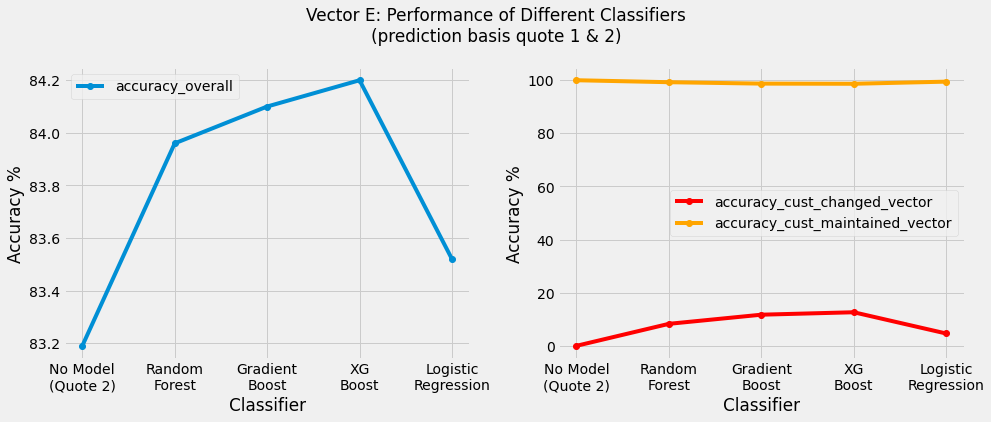

ValueError: Length of values (11) does not match length of index (13)

In [522]:
vector = 'E'
models = ['no_model', 'rf', 'gb', 'xg', 'lr']
#models = ['no_model', 'rf', 'gb', 'xg']
quotes = [1,2]
model_performance_plot(vector, models, quotes, "overall")
model_performance_plot(vector, models, quotes, "shopping_pt")

### Vector C: Training Models<a id='Phase1_step3.5'></a>

Random Forest Classifier results for Vector C

Accuracy=0.832
f1-score=0.831
Confusion Matrix - Normalized
 [[0.842 0.074 0.08  0.005]
 [0.122 0.75  0.12  0.008]
 [0.045 0.046 0.882 0.027]
 [0.037 0.016 0.171 0.776]]
Confusion Matrix
 [[3959  346  376   22]
 [ 395 2427  387   26]
 [ 273  279 5336  162]
 [  56   25  263 1190]]

Classification Report 
               precision    recall  f1-score   support

           1       0.85      0.84      0.84      4703
           2       0.79      0.75      0.77      3235
           3       0.84      0.88      0.86      6050
           4       0.85      0.78      0.81      1534

    accuracy                           0.83     15522
   macro avg       0.83      0.81      0.82     15522
weighted avg       0.83      0.83      0.83     15522

30


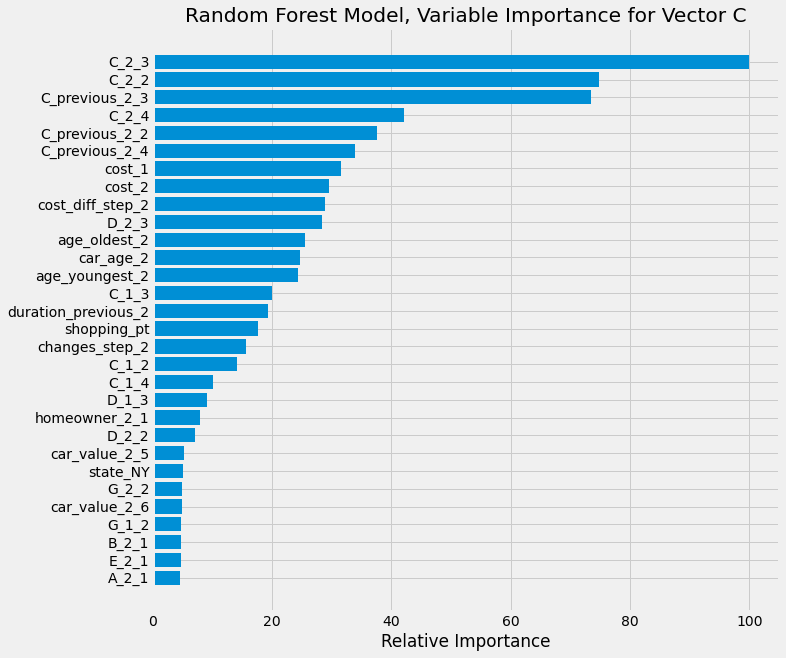

In [401]:
# Let's run the model for vector C
 
vector = 'C'

rf_ac, rf_f1, rf_probs, rf_preds = rf_predict_plot(vector, plot = True)



In [385]:
#test_set = df_train_first2.iloc[y_test.index,:]

vector = 'C'

x = pd.crosstab(test_set['C'], test_set['C_2'])

same_as_2 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 

acc = np.around(np.sum(same_as_2)/y_test.shape[0], 4)

print(f"Accuracy based on simply predicting vector {vector} = {vector}_2 : {(np.sum(same_as_2)/y_test.shape[0]): 4.4}")

Accuracy based on simply predicting vector C = C_2 :  0.804


In [400]:

x['total'] = x.sum(axis=1)
x['C1_%'] = np.around(x[1]*100 / x['total'], 2)
x['C2_%'] = np.around(x[2]*100 / x['total'], 2)
x['C3_%'] = np.around(x[3]*100 / x['total'], 2)
x['C4_%'] = np.around(x[4]*100 / x['total'], 2)

x


C_2     1     2     3     4  total   C1_%   C2_%   C3_%   C4_%
C                                                             
1    3826   348   513    16   4703  81.35   7.40  10.91   0.34
2     422  2309   480    24   3235  13.04  71.38  14.84   0.74
3     386   286  5257   121   6050   6.38   4.73  86.89   2.00
4      97    36   314  1087   1534   6.32   2.35  20.47  70.86

In [413]:
vector = 'C'

def rf_eval(estimators, min_leaf, min_split):
    
    rf = RandomForestClassifier(n_estimators = round(estimators), min_samples_leaf = round(min_leaf), \
                                    min_samples_split = round(min_split), random_state = 1, n_jobs=-1)
    
    cv_result = cross_validate(rf, X_train.to_numpy(), y_train[vector].astype('int'), cv= 4)
    return np.mean(cv_result['test_score'])

rf_bo = BayesianOptimization(rf_eval, {'estimators': (100, 1000), 'min_leaf': (1, 5), 'min_split': (2, 6)})

rf_bo.maximize(n_iter=10, init_points=2)


|   iter    |  target   | estima... | min_leaf  | min_split |
-------------------------------------------------------------
|  1        |  0.8316   |  239.3    |  2.743    |  3.575    |
|  2        |  0.832    |  598.0    |  3.308    |  4.555    |
|  3        |  0.8309   |  599.0    |  3.973    |  4.056    |
|  4        |  0.8333   |  418.0    |  1.617    |  4.883    |
|  5        |  0.8327   |  817.0    |  2.423    |  5.577    |
|  6        |  0.8333   |  418.1    |  2.153    |  4.554    |
|  7        |  0.8331   |  416.7    |  2.439    |  5.695    |
|  8        |  0.8338   |  416.9    |  1.45     |  2.981    |
|  9        |  0.832    |  415.3    |  3.379    |  2.351    |
|  10       |  0.8338   |  418.8    |  1.31     |  2.379    |
|  11       |  0.8331   |  421.4    |  2.5      |  2.588    |
|  12       |  0.8336   |  593.7    |  1.942    |  5.29     |


Random Forest Classifier results for Vector C
Parameters: No. of Estimators = 300,  min_samples_leaf = 1,     min_samples_split = 5
Accuracy=0.8323, f1-score=0.8316
Confusion Matrix - normalized
 [[0.8416 0.0734 0.0804 0.0047]
 [0.1218 0.7518 0.1181 0.0083]
 [0.0451 0.0455 0.8821 0.0273]
 [0.0352 0.0163 0.1714 0.7771]]
Confusion Matrix
 [[3958  345  378   22]
 [ 394 2432  382   27]
 [ 273  275 5337  165]
 [  54   25  263 1192]]

Classification Report 
               precision    recall  f1-score   support

           0       0.85      0.84      0.84      4703
           1       0.79      0.75      0.77      3235
           2       0.84      0.88      0.86      6050
           3       0.85      0.78      0.81      1534

    accuracy                           0.83     15522
   macro avg       0.83      0.81      0.82     15522
weighted avg       0.83      0.83      0.83     15522

30


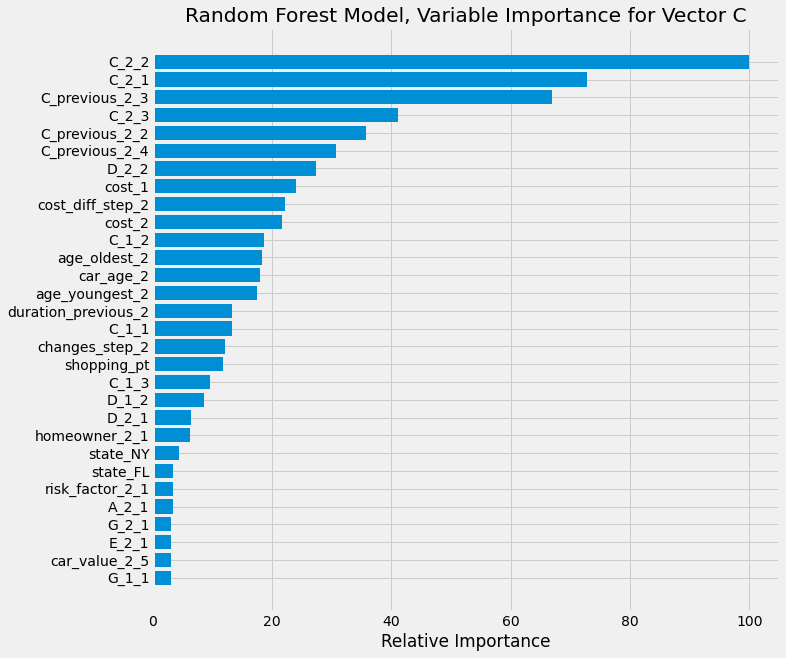

In [383]:

vector = 'C'

rf_ac, rf_f1, rf_probs, rf_preds = rf_predict_plot(vector, n_estimators=300, min_samples_leaf = 1, \
                                                   min_samples_split = 5, plot = True)



In [384]:
vector = 'C'
score_matrix = model_score_matrix(vector, 2, rf_preds)
score_matrix

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)


Pred_incorrect  Pred_correct  Pred_accuracy_%
cust_changed_vector               2396           647            21.26
cust_maintained_vector             207         12272            98.34

In [386]:
vector='C'
model = 'rf'

score = model_score_by_shopping_pt(vector, 2, rf_preds)

perf_q1q2.update(vector, 'no_model', 'overall', acc*100)
perf_q1q2.update(vector, model, 'overall', round(rf_ac*100,2))
perf_q1q2.update(vector, model, 'customer_type', score_matrix)
perf_q1q2.update(vector, model, 'shopping_pt', score)
perf_q1q2.compare(vector, model)
perf_q1q2.record[vector]

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple

no_model     rf rf_vs_no_model
accuracy_overall                    80.4  83.23           2.83
accuracy_cust_changed_vector           0  21.26          21.26
accuracy_cust_maintained_vector      100  98.34          -1.66
accuracy_shopping_pt_3             85.19  87.09            1.9
accuracy_shopping_pt_4             87.19  87.97           0.78
accuracy_shopping_pt_5             83.19  85.69            2.5
accuracy_shopping_pt_6             81.84  84.92           3.08
accuracy_shopping_pt_7              81.2  83.52           2.32
accuracy_shopping_pt_8             77.03  80.72           3.69
accuracy_shopping_pt_9             77.84  80.92           3.08
accuracy_shopping_pt_10            74.15  77.86           3.71
accuracy_shopping_pt_11            72.43  78.30           5.87
accuracy_shopping_pt_12            71.05  77.63           6.58
accuracy_shopping_pt_13             37.5  37.50            0.0

Gradient Boosting Classifier results for Vector C

Parameters: No. of Estimators = 150,  learning_rate = 0.25, max_depth = 3, max_features = 6

Accuracy=0.829
f1-score=0.828
Confusion Matrix - Normalized
 [[0.843 0.07  0.081 0.005]
 [0.124 0.737 0.129 0.009]
 [0.044 0.047 0.878 0.031]
 [0.029 0.016 0.172 0.783]]
Confusion Matrix
 [[3966  331  383   23]
 [ 402 2385  418   30]
 [ 268  284 5311  187]
 [  44   25  264 1201]]

Classification Report 
               precision    recall  f1-score   support

           1       0.85      0.84      0.85      4703
           2       0.79      0.74      0.76      3235
           3       0.83      0.88      0.85      6050
           4       0.83      0.78      0.81      1534

    accuracy                           0.83     15522
   macro avg       0.83      0.81      0.82     15522
weighted avg       0.83      0.83      0.83     15522



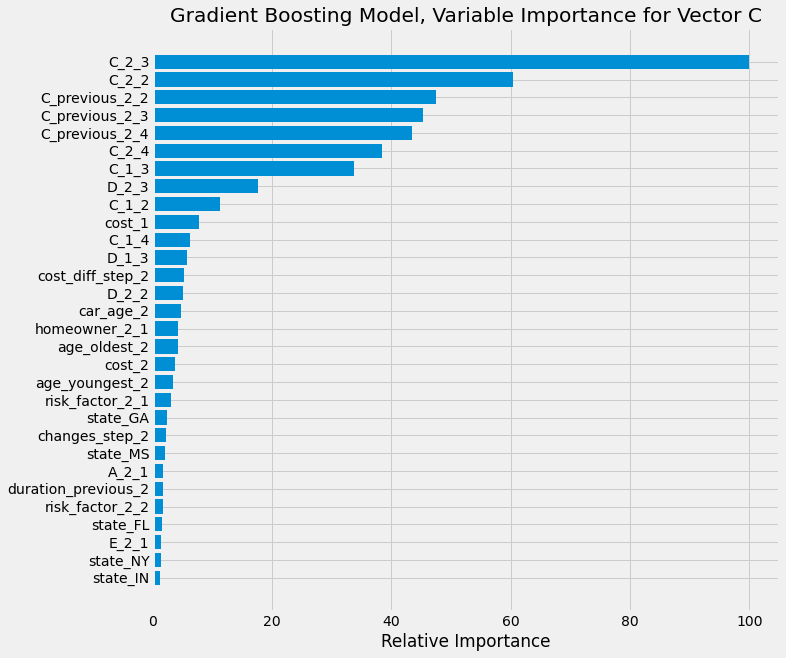

In [407]:
# model C with GradientBoosting classifier

vector = 'C'

gb_ac, gb_f1, gb_probs, gb_preds = gb_predict_plot(vector, n_estimators = 150, max_features = 6, \
                                                   max_depth = 3, learning_rate = 0.25, plot = True)


In [403]:
# Let's use RandomizedSearchCV to find the best GradientBoosting classifier Hyperparamters for vector C

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

vector = 'C'

param_grid = {'learning_rate' : [0.25, 0.5, 0.75, 1], 'n_estimators' : [50, 100, 150, 200], \
              'max_features': [2,4,6,8], 'max_depth' : [1,2,3]}

gb = GradientBoostingClassifier(random_state = 1, n_jobs=-1)

gb_cv = RandomizedSearchCV(gb, param_grid, n_iter = 10, verbose = 3, cv=5)

gb_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print(f"Vector {vector} RandomizedSearchCV: Gradient Boosting Model\nBest Score:" + str(gb_cv.best_score_))
print("\nBest Parameters: " + str(gb_cv.best_params_))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.5, max_depth=2, max_features=4, n_estimators=150;, score=0.830 total time=  30.7s
[CV 2/5] END learning_rate=0.5, max_depth=2, max_features=4, n_estimators=150;, score=0.828 total time=  30.1s
[CV 3/5] END learning_rate=0.5, max_depth=2, max_features=4, n_estimators=150;, score=0.829 total time=  31.7s
[CV 4/5] END learning_rate=0.5, max_depth=2, max_features=4, n_estimators=150;, score=0.828 total time=  30.8s
[CV 5/5] END learning_rate=0.5, max_depth=2, max_features=4, n_estimators=150;, score=0.825 total time=  30.3s
[CV 1/5] END learning_rate=0.25, max_depth=3, max_features=6, n_estimators=150;, score=0.831 total time=  44.6s
[CV 2/5] END learning_rate=0.25, max_depth=3, max_features=6, n_estimators=150;, score=0.833 total time=  43.2s
[CV 3/5] END learning_rate=0.25, max_depth=3, max_features=6, n_estimators=150;, score=0.831 total time=  42.9s
[CV 4/5] END learning_rate=0.25, max_depth=3, ma

In [404]:
vector = 'C'

param_grid = {'learning_rate' : [0.25, 0.4, 0.5], 'n_estimators' : [150, 200], \
              'max_features': [6,8,10], 'max_depth' : [3, 4]}

gb = GradientBoostingClassifier(random_state = 1)

gb_cv = RandomizedSearchCV(gb, param_grid, n_iter = 10, verbose = 3, cv=4)

gb_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print(f"Vector {vector} RandomizedSearchCV: Gradient Boosting Model\nBest Score:" + str(gb_cv.best_score_))
print("\nBest Parameters: " + str(gb_cv.best_params_))


Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 1/4] END learning_rate=0.25, max_depth=3, max_features=6, n_estimators=200;, score=0.833 total time=  45.7s
[CV 2/4] END learning_rate=0.25, max_depth=3, max_features=6, n_estimators=200;, score=0.836 total time=  47.8s
[CV 3/4] END learning_rate=0.25, max_depth=3, max_features=6, n_estimators=200;, score=0.830 total time=  47.2s
[CV 4/4] END learning_rate=0.25, max_depth=3, max_features=6, n_estimators=200;, score=0.832 total time=  47.6s
[CV 1/4] END learning_rate=0.4, max_depth=3, max_features=8, n_estimators=150;, score=0.832 total time=  40.9s
[CV 2/4] END learning_rate=0.4, max_depth=3, max_features=8, n_estimators=150;, score=0.834 total time=  40.2s
[CV 3/4] END learning_rate=0.4, max_depth=3, max_features=8, n_estimators=150;, score=0.829 total time=  40.5s
[CV 4/4] END learning_rate=0.4, max_depth=3, max_features=8, n_estimators=150;, score=0.830 total time=  40.7s
[CV 1/4] END learning_rate=0.25, max_depth=4, m

In [406]:
vector = 'C'

param_grid = {'learning_rate' : [0.2, 0.25, 0.3], 'n_estimators' : [200], \
              'max_features': [6,8], 'max_depth' : [3]}

gb = GradientBoostingClassifier(random_state = 1)

gb_cv = RandomizedSearchCV(gb, param_grid, n_iter = 6, verbose = 3, cv=4)

gb_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print(f"Vector {vector} RandomizedSearchCV: Gradient Boosting Model\nBest Score:" + str(gb_cv.best_score_))
print("\nBest Parameters: " + str(gb_cv.best_params_))

Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV 1/4] END learning_rate=0.2, max_depth=3, max_features=6, n_estimators=200;, score=0.834 total time=  45.4s
[CV 2/4] END learning_rate=0.2, max_depth=3, max_features=6, n_estimators=200;, score=0.834 total time=  47.5s
[CV 3/4] END learning_rate=0.2, max_depth=3, max_features=6, n_estimators=200;, score=0.828 total time=  48.3s
[CV 4/4] END learning_rate=0.2, max_depth=3, max_features=6, n_estimators=200;, score=0.831 total time=  48.3s
[CV 1/4] END learning_rate=0.2, max_depth=3, max_features=8, n_estimators=200;, score=0.832 total time=  54.0s
[CV 2/4] END learning_rate=0.2, max_depth=3, max_features=8, n_estimators=200;, score=0.835 total time=  52.8s
[CV 3/4] END learning_rate=0.2, max_depth=3, max_features=8, n_estimators=200;, score=0.830 total time=  55.9s
[CV 4/4] END learning_rate=0.2, max_depth=3, max_features=8, n_estimators=200;, score=0.834 total time=  53.9s
[CV 1/4] END learning_rate=0.25, max_depth=3, max_fe

Gradient Boosting Classifier results for Vector C

Parameters: No. of Estimators = 200,  learning_rate = 0.25, max_depth = 3, max_features = 6

Accuracy=0.830
f1-score=0.829
Confusion Matrix - Normalized
 [[0.842 0.072 0.081 0.005]
 [0.124 0.742 0.125 0.009]
 [0.043 0.048 0.879 0.031]
 [0.025 0.016 0.171 0.788]]
Confusion Matrix
 [[3961  339  379   24]
 [ 400 2401  405   29]
 [ 259  289 5315  187]
 [  39   24  262 1209]]

Classification Report 
               precision    recall  f1-score   support

           1       0.85      0.84      0.85      4703
           2       0.79      0.74      0.76      3235
           3       0.84      0.88      0.86      6050
           4       0.83      0.79      0.81      1534

    accuracy                           0.83     15522
   macro avg       0.83      0.81      0.82     15522
weighted avg       0.83      0.83      0.83     15522



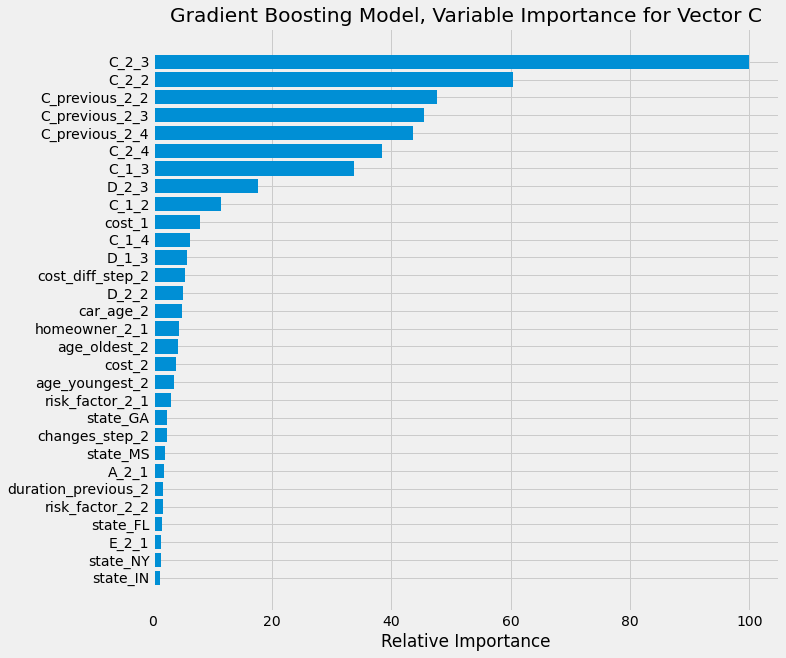

In [408]:
# model C with GradientBoosting classifier
# Best Parameters: {'n_estimators': 200, 'max_features': 6, 'max_depth': 3, 'learning_rate': 0.25}

vector = 'C'

gb_ac, gb_f1, gb_probs, gb_preds = gb_predict_plot(vector, n_estimators = 200, max_features = 6, \
                                                   max_depth = 3, learning_rate = 0.25, plot = True)



Gradient Boosting Classifier results for Vector C
Parameters: No. of Estimators = 200,  max_depth = 3,     learning_rate = 0.25, max_features = 8
Accuracy=0.8322, f1-score=0.8314
Confusion Matrix - normalized
 [[0.8475 0.0697 0.0774 0.0053]
 [0.1255 0.741  0.1246 0.009 ]
 [0.0436 0.0453 0.8798 0.0312]
 [0.0254 0.0163 0.1688 0.7894]]
Confusion Matrix
 [[3986  328  364   25]
 [ 406 2397  403   29]
 [ 264  274 5323  189]
 [  39   25  259 1211]]

Classification Report 
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      4703
           1       0.79      0.74      0.77      3235
           2       0.84      0.88      0.86      6050
           3       0.83      0.79      0.81      1534

    accuracy                           0.83     15522
   macro avg       0.83      0.81      0.82     15522
weighted avg       0.83      0.83      0.83     15522

30


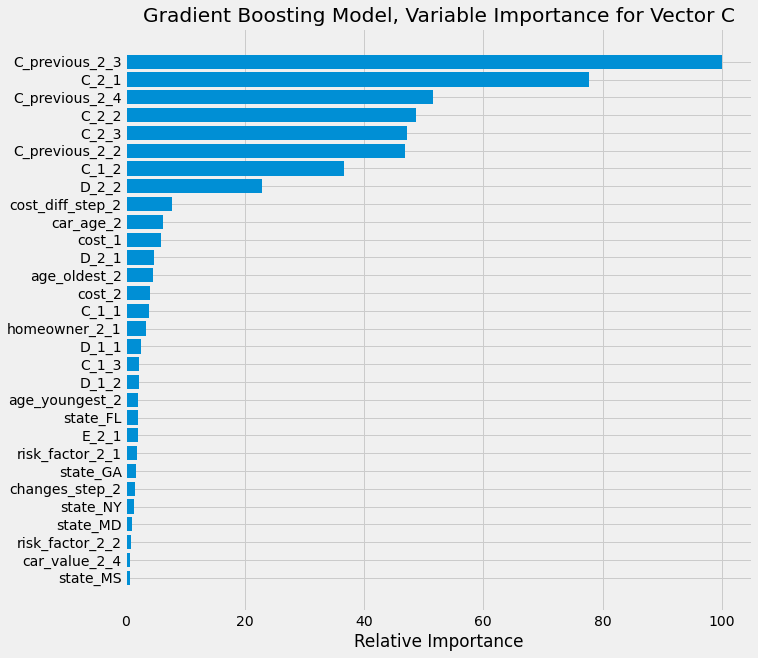

In [387]:
# model C with GradientBoosting classifier
# Best Parameters: {'n_estimators': 200, 'max_features': 8, 'max_depth': 3, 'learning_rate': 0.25}

vector = 'C'

gb_ac, gb_f1, gb_probs, gb_preds = gb_predict_plot(vector, n_estimators = 200, max_features = 8, \
                                                   max_depth = 3, learning_rate = 0.25, plot = True)



Notes for Vector C:
* changing l_rate from 0.25 to 0.2/0.3/0.4 reduced score marginally


In [388]:
vector = 'C'
score_matrix = model_score_matrix(vector, 2, gb_preds)
score_matrix

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)


Pred_incorrect  Pred_correct  Pred_accuracy_%
cust_changed_vector               2231           812            26.68
cust_maintained_vector             374         12105            97.00

In [389]:
vector='C'
model = 'gb'

score = model_score_by_shopping_pt(vector, 2, gb_preds)

#perf_q1q2.update(vector, 'no_model', 'overall', acc*100)
perf_q1q2.update(vector, model, 'overall', round(gb_ac*100,2))
perf_q1q2.update(vector, model, 'customer_type', score_matrix)
perf_q1q2.update(vector, model, 'shopping_pt', score)
perf_q1q2.compare(vector, model)
perf_q1q2.record[vector]

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple

no_model     rf rf_vs_no_model     gb  \
accuracy_overall                    80.4  83.23           2.83  83.22   
accuracy_cust_changed_vector           0  21.26          21.26  26.68   
accuracy_cust_maintained_vector      100  98.34          -1.66  97.00   
accuracy_shopping_pt_3             85.19  87.09            1.9  86.53   
accuracy_shopping_pt_4             87.19  87.97           0.78  88.05   
accuracy_shopping_pt_5             83.19  85.69            2.5  85.58   
accuracy_shopping_pt_6             81.84  84.92           3.08  84.96   
accuracy_shopping_pt_7              81.2  83.52           2.32  82.85   
accuracy_shopping_pt_8             77.03  80.72           3.69  80.91   
accuracy_shopping_pt_9             77.84  80.92           3.08  81.44   
accuracy_shopping_pt_10            74.15  77.86           3.71  78.68   
accuracy_shopping_pt_11            72.43  78.30           5.87  78.59   
accuracy_shopping_pt_12            71.05  77.63           6.58  76.32   
accuracy_shopping_pt_13             37.5  37.50            0.0  37.50   

                                gb_vs_no_model  
accuracy_overall                          2.82  
accuracy_cust_changed_vector             26.68  
accuracy_cust_maintained_vector           -3.0  
accuracy_shopping_pt_3                    1.34  
accuracy_shopping_pt_4                    0.86  
accuracy_shopping_pt_5                    2.39  
accuracy_shopping_pt_6                    3.12  
accuracy_shopping_pt_7                    1.65  
accuracy_shopping_pt_8                    3.88  
accuracy_shopping_pt_9                     3.6  
accuracy_shopping_pt_10                   4.53  
accuracy_shopping_pt_11                   6.16  
accuracy_shopping_pt_12                   5.27  
accuracy_shopping_pt_13                    0.0

In [77]:
# Let's use RandomizedSearchCV to find the best XGB classifier Hyperparamters for vector C

import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV

vector = 'C'

param_grid = {'learning_rate' : [0.25, 0.3, 0.35, 0.5], 'n_estimators' : np.arange(100,501,100), \
              'colsample_bytree': [0.15,0.25,0.35,0.5], 'max_depth' : [3,4,5]}

clf = xgb.XGBClassifier(objective='binary:logistic', random_state=1, n_jobs=-1)

clf_cv = RandomizedSearchCV(clf, param_grid, n_iter = 60, verbose = 3, cv=4)

clf_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print(f"Vector {vector} RandomizedSearchCV: XG Boosting Model\nBest Score:" + str(clf_cv.best_score_))
print("\nBest Parameters: " + str(clf_cv.best_params_))


Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=4, n_estimators=100;, score=0.835 total time=   5.3s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=4, n_estimators=100;, score=0.837 total time=   5.0s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=4, n_estimators=100;, score=0.831 total time=   5.0s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=4, n_estimators=100;, score=0.833 total time=   5.3s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.834 total time=  28.2s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.835 total time=  30.0s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.830 total time=  30.5s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.831 total time=  

[CV 2/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=5, n_estimators=100;, score=0.836 total time=  10.3s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=5, n_estimators=100;, score=0.831 total time=  10.2s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=5, n_estimators=100;, score=0.833 total time=  10.0s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=4, n_estimators=500;, score=0.835 total time=  30.3s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=4, n_estimators=500;, score=0.834 total time=  37.1s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=4, n_estimators=500;, score=0.831 total time=  54.5s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=4, n_estimators=500;, score=0.832 total time=  51.4s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=5, n_estimators=300;, score=0.826 total time=  33.9s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.

[CV 4/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=4, n_estimators=400;, score=0.830 total time=  31.4s
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=3, n_estimators=400;, score=0.836 total time=  15.4s
[CV 2/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=3, n_estimators=400;, score=0.836 total time=  15.8s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=3, n_estimators=400;, score=0.832 total time=  16.0s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=3, n_estimators=400;, score=0.832 total time=  16.3s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=3, n_estimators=400;, score=0.834 total time=  12.4s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=3, n_estimators=400;, score=0.838 total time=  12.3s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=3, n_estimators=400;, score=0.832 total time=  12.3s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.3, m

[CV 2/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=5, n_estimators=200;, score=0.837 total time=  15.6s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=5, n_estimators=200;, score=0.833 total time=  15.0s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=5, n_estimators=200;, score=0.834 total time=  15.9s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.834 total time=  25.7s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.836 total time=  23.7s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.829 total time=  24.7s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.830 total time=  23.3s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=4, n_estimators=100;, score=0.833 total time=   4.0s
[CV 2/4] END colsample_bytree=0.15, learning_rate

In [78]:
results = pd.DataFrame(clf_cv.cv_results_['params'])
results['train_score'] = clf_cv.cv_results_['mean_test_score']
results['train_rank'] = clf_cv.cv_results_['rank_test_score']

save_file(results, 'xgboost_results_vectorC.csv', datapath)

Writing file.  "Modelling_data\xgboost_results_vectorC.csv"


In [79]:
import xgboost as xgb

vector = 'C'

print(f"XGBoost Classifier results for Vector {vector}\n")
#param_grid
for i, row in results.iterrows():
    n_estimators = row['n_estimators']
    max_depth = row['max_depth']
    learning_rate = row['learning_rate']
    colsample_bytree = row['colsample_bytree']
        
    clf = xgb.XGBClassifier(max_depth=int(max_depth), objective='multi:softprob', n_estimators=int(n_estimators), \
                       learning_rate = learning_rate, colsample_bytree = colsample_bytree, n_jobs=-1, random_state=1)

    clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = clf.predict(X_test.to_numpy())
    y_pred_prob = clf.predict_proba(X_test.to_numpy())
    xg_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
    cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

    results.loc[i, 'test_score'] = ac
    results.loc[i, 'f1_score'] = f1
    
    print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}, \
    learning_rate = {learning_rate}, colsample_bytree = {colsample_bytree}")

    print(f'Accuracy={ac:4.4}, f1_score={f1:4.4}')

results['test_rank']= results['test_score'].rank(method='dense', ascending=False)
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
datapath="Modelling_data"
save_file(results,"xgboost_results_vectorC_2.csv",datapath)


XGBoost Classifier results for Vector C

Parameters: No. of Estimators = 100.0,  max_depth = 4.0,     learning_rate = 0.5, colsample_bytree = 0.35
Accuracy=0.832, f1_score=0.8313
Parameters: No. of Estimators = 500.0,  max_depth = 3.0,     learning_rate = 0.35, colsample_bytree = 0.5
Accuracy=0.8311, f1_score=0.8304
Parameters: No. of Estimators = 400.0,  max_depth = 3.0,     learning_rate = 0.3, colsample_bytree = 0.35
Accuracy=0.8306, f1_score=0.8299
Parameters: No. of Estimators = 100.0,  max_depth = 4.0,     learning_rate = 0.5, colsample_bytree = 0.5
Accuracy=0.8339, f1_score=0.8331
Parameters: No. of Estimators = 400.0,  max_depth = 4.0,     learning_rate = 0.25, colsample_bytree = 0.35
Accuracy=0.8328, f1_score=0.8321
Parameters: No. of Estimators = 100.0,  max_depth = 5.0,     learning_rate = 0.3, colsample_bytree = 0.35
Accuracy=0.8322, f1_score=0.8315
Parameters: No. of Estimators = 200.0,  max_depth = 5.0,     learning_rate = 0.3, colsample_bytree = 0.25
Accuracy=0.8332, f1_

Parameters: No. of Estimators = 200.0,  max_depth = 5.0,     learning_rate = 0.3, colsample_bytree = 0.15
Accuracy=0.8313, f1_score=0.8306
Writing file.  "Modelling_data\xgboost_results_vectorC_2.csv"


In [80]:
results

n_estimators  max_depth  learning_rate  colsample_bytree  train_score  \
0            100          4           0.50              0.35     0.833889   
1            500          3           0.35              0.50     0.832552   
2            400          3           0.30              0.35     0.833905   
3            100          4           0.50              0.50     0.833003   
4            400          4           0.25              0.35     0.834517   
5            100          5           0.30              0.35     0.835065   
6            200          5           0.30              0.25     0.834115   
7            300          3           0.50              0.15     0.832713   
8            400          5           0.50              0.50     0.825691   
9            300          4           0.25              0.35     0.834807   
10           400          3           0.35              0.50     0.833519   
11           100          3           0.25              0.50     0.832874   
12           200          3           0.30              0.35     0.834421   
13           500          4           0.50              0.15     0.827720   
14           400          4           0.25              0.50     0.833680   
15           200          4           0.25              0.15     0.834195   
16           200          3           0.25              0.35     0.834549   
17           100          5           0.35              0.50     0.833647   
18           500          4           0.25              0.35     0.833068   
19           300          5           0.50              0.35     0.826705   
20           500          5           0.25              0.50     0.830329   
21           300          3           0.25              0.35     0.835097   
22           100          4           0.35              0.35     0.833760   
23           200          4           0.25              0.25     0.834839   
24           200          3           0.35              0.15     0.833309   
25           400          5           0.25              0.50     0.831586   
26           200          3           0.30              0.15     0.833341   
27           200          3           0.50              0.35     0.832617   
28           500          3           0.30              0.35     0.833631   
29           300          4           0.30              0.35     0.834388   
30           500          3           0.25              0.15     0.834453   
31           200          5           0.35              0.25     0.833213   
32           500          3           0.30              0.25     0.833212   
33           300          3           0.30              0.50     0.835049   
34           400          4           0.35              0.50     0.830313   
35           400          3           0.30              0.25     0.833841   
36           400          3           0.30              0.15     0.834388   
37           300          3           0.50              0.35     0.832327   
38           200          4           0.35              0.15     0.833486   
39           100          3           0.25              0.15     0.827575   
40           400          3           0.50              0.35     0.831505   
41           300          3           0.50              0.25     0.832037   
42           400          5           0.50              0.25     0.825836   
43           400          5           0.35              0.35     0.830023   
44           500          3           0.30              0.15     0.834211   
45           200          4           0.35              0.50     0.833357   
46           300          5           0.35              0.25     0.831022   
47           400          4           0.30              0.35     0.833277   
48           500          5           0.35              0.15     0.828606   
49           300          3           0.35              0.15     0.833647   
50           500          4           0.25              0.50     0.832278   


XGBoost Classifier results for Vector C
Parameters: No. of Estimators = 200,  max_depth = 5,     learning_rate = 0.25, colsample_bytree = 0.35
Accuracy=0.8343, f1-score=0.8336
Confusion Matrix - normalized
 [[0.8499 0.0708 0.0744 0.0049]
 [0.1236 0.7413 0.1261 0.009 ]
 [0.0418 0.0461 0.8818 0.0302]
 [0.0241 0.0156 0.1649 0.7953]]
Confusion Matrix
 [[3997  333  350   23]
 [ 400 2398  408   29]
 [ 253  279 5335  183]
 [  37   24  253 1220]]

Classification Report 
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      4703
           1       0.79      0.74      0.77      3235
           2       0.84      0.88      0.86      6050
           3       0.84      0.80      0.82      1534

    accuracy                           0.83     15522
   macro avg       0.83      0.82      0.82     15522
weighted avg       0.83      0.83      0.83     15522

30


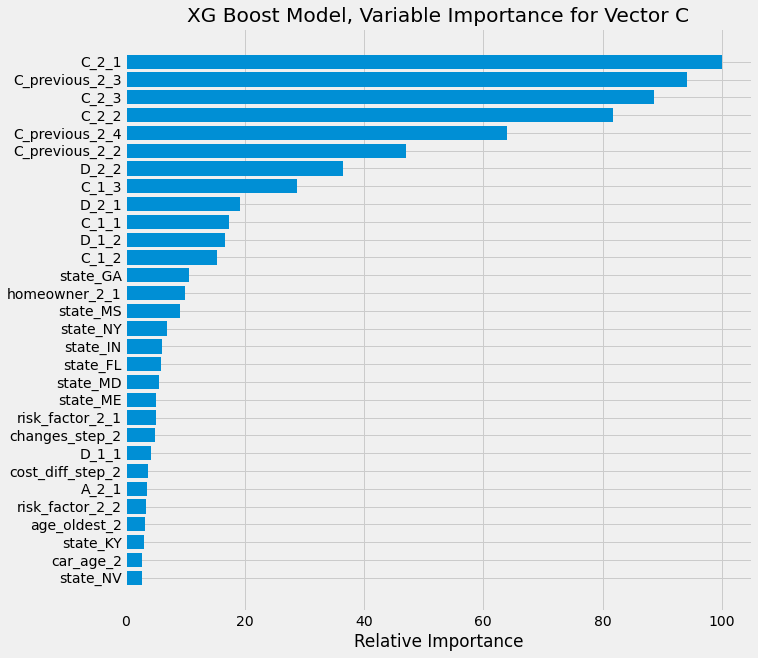

In [390]:
# model C with XGBoost classifier Best Parameters: (Overall 2nd rank model, Iteration 52)

vector = 'C'
xg_ac, xg_f1, xg_probs, xg_preds = xg_predict_plot(vector, n_estimators = 200, max_depth = 5, \
                                         learning_rate = 0.25, colsample_bytree = 0.35, plot=True)



In [391]:
vector = 'C'
score_matrix = model_score_matrix(vector, 2, xg_preds)
score_matrix

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)


Pred_incorrect  Pred_correct  Pred_accuracy_%
cust_changed_vector               2185           858             28.2
cust_maintained_vector             387         12092             96.9

In [392]:
vector='C'
model = 'xg'

score = model_score_by_shopping_pt(vector, 2, xg_preds)

#perf_q1q2.update(vector, 'no_model', 'overall', acc*100)
perf_q1q2.update(vector, model, 'overall', round(xg_ac*100,2))
perf_q1q2.update(vector, model, 'customer_type', score_matrix)
perf_q1q2.update(vector, model, 'shopping_pt', score)
perf_q1q2.compare(vector, model)
perf_q1q2.record[vector]

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple

no_model     rf rf_vs_no_model     gb  \
accuracy_overall                    80.4  83.23           2.83  83.22   
accuracy_cust_changed_vector           0  21.26          21.26  26.68   
accuracy_cust_maintained_vector      100  98.34          -1.66  97.00   
accuracy_shopping_pt_3             85.19  87.09            1.9  86.53   
accuracy_shopping_pt_4             87.19  87.97           0.78  88.05   
accuracy_shopping_pt_5             83.19  85.69            2.5  85.58   
accuracy_shopping_pt_6             81.84  84.92           3.08  84.96   
accuracy_shopping_pt_7              81.2  83.52           2.32  82.85   
accuracy_shopping_pt_8             77.03  80.72           3.69  80.91   
accuracy_shopping_pt_9             77.84  80.92           3.08  81.44   
accuracy_shopping_pt_10            74.15  77.86           3.71  78.68   
accuracy_shopping_pt_11            72.43  78.30           5.87  78.59   
accuracy_shopping_pt_12            71.05  77.63           6.58  76.32   
accuracy_shopping_pt_13             37.5  37.50            0.0  37.50   

                                gb_vs_no_model     xg xg_vs_no_model  
accuracy_overall                          2.82  83.43           3.03  
accuracy_cust_changed_vector             26.68  28.20           28.2  
accuracy_cust_maintained_vector           -3.0  96.90           -3.1  
accuracy_shopping_pt_3                    1.34  87.54           2.35  
accuracy_shopping_pt_4                    0.86  88.20           1.01  
accuracy_shopping_pt_5                    2.39  85.52           2.33  
accuracy_shopping_pt_6                    3.12  84.72           2.88  
accuracy_shopping_pt_7                    1.65  83.59           2.39  
accuracy_shopping_pt_8                    3.88  80.80           3.77  
accuracy_shopping_pt_9                     3.6  81.60           3.76  
accuracy_shopping_pt_10                   4.53  79.20           5.05  
accuracy_shopping_pt_11                   6.16  79.18           6.75  
accuracy_shopping_pt_12                   5.27  76.32           5.27  
accuracy_shopping_pt_13                    0.0  37.50            0.0

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/3934441024.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/3934441024.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels)


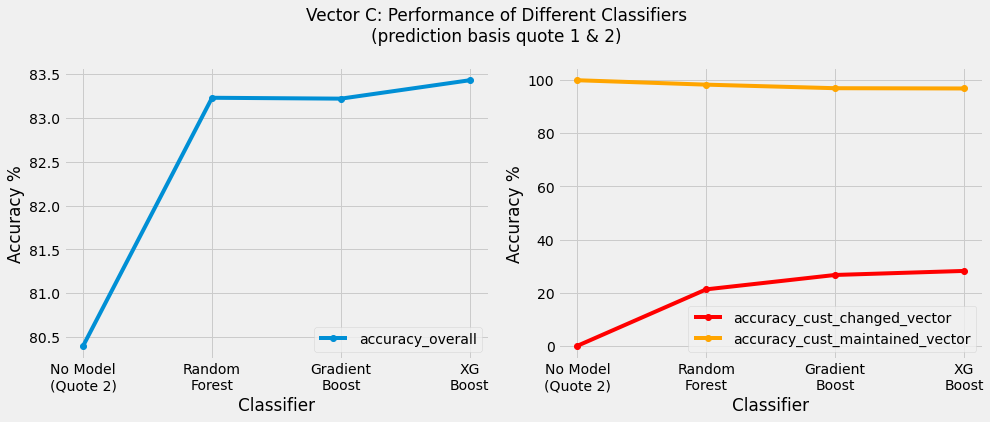

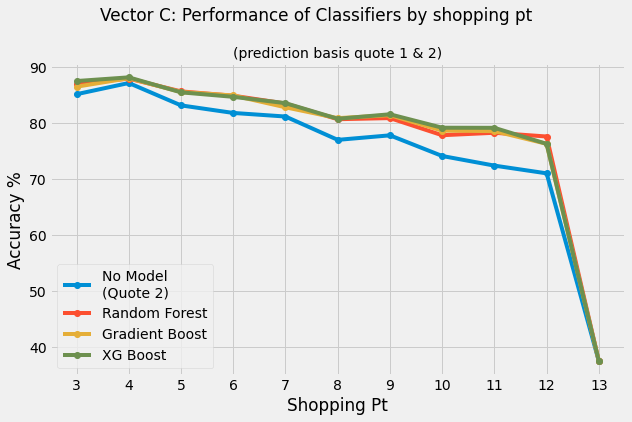

In [523]:
vector = 'C'
#models = ['no_model', 'rf', 'gb', 'xg', 'lr']
models = ['no_model', 'rf', 'gb', 'xg']
quotes = [1,2]
model_performance_plot(vector, models, quotes, "overall")
model_performance_plot(vector, models, quotes, "shopping_pt")

### Vector D: Training Models<a id='Phase1_step3.6'></a>

Random Forest Classifier results for Vector D
Parameters: No. of Estimators = 300,  min_samples_leaf = 1,     min_samples_split = 2
Accuracy=0.8619, f1-score=0.8628
Confusion Matrix - normalized
 [[0.81   0.064  0.126 ]
 [0.0925 0.7608 0.1467]
 [0.0325 0.0608 0.9066]]
Confusion Matrix
 [[1633  129  254]
 [ 317 2608  503]
 [ 328  613 9137]]

Classification Report 
               precision    recall  f1-score   support

           0       0.72      0.81      0.76      2016
           1       0.78      0.76      0.77      3428
           2       0.92      0.91      0.91     10078

    accuracy                           0.86     15522
   macro avg       0.81      0.83      0.82     15522
weighted avg       0.86      0.86      0.86     15522

30


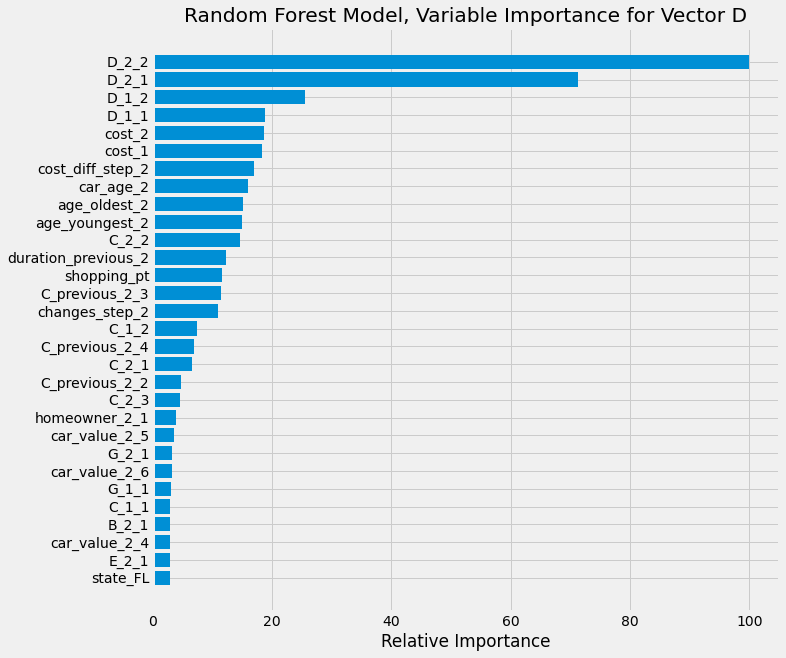

In [396]:
# Let's run the model for vector D

vector = 'D'

rf_ac, rf_f1, rf_probs, rf_preds = rf_predict_plot(vector, plot = True)


In [397]:
vector = 'D'
score_matrix = model_score_matrix(vector, 2, rf_preds)
score_matrix

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)


Pred_incorrect  Pred_correct  Pred_accuracy_%
cust_changed_vector               2024           359            15.07
cust_maintained_vector             120         13019            99.09

In [398]:
vector='D'
model = 'rf'

score = model_score_by_shopping_pt(vector, 2, rf_preds)

perf_q1q2.update(vector, 'no_model', 'overall', acc*100)
perf_q1q2.update(vector, model, 'overall', round(rf_ac*100,2))
perf_q1q2.update(vector, model, 'customer_type', score_matrix)
perf_q1q2.update(vector, model, 'shopping_pt', score)
perf_q1q2.compare(vector, model)
perf_q1q2.record[vector]

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple

no_model     rf rf_vs_no_model
accuracy_overall                   84.65  86.19           1.54
accuracy_cust_changed_vector           0  15.07          15.07
accuracy_cust_maintained_vector      100  99.09          -0.91
accuracy_shopping_pt_3             88.55  90.01           1.46
accuracy_shopping_pt_4             89.61  90.23           0.62
accuracy_shopping_pt_5             86.63  87.35           0.72
accuracy_shopping_pt_6             84.88  86.00           1.12
accuracy_shopping_pt_7             85.64  87.02           1.38
accuracy_shopping_pt_8             82.28  83.99           1.71
accuracy_shopping_pt_9             83.58  86.03           2.45
accuracy_shopping_pt_10             79.4  82.08           2.68
accuracy_shopping_pt_11            77.42  82.11           4.69
accuracy_shopping_pt_12             75.0  75.00            0.0
accuracy_shopping_pt_13             75.0  75.00            0.0

In [394]:
#test_set = df_train_first2.iloc[y_test.index,:]
vector = 'D'
x = pd.crosstab(test_set['D'], test_set['D_2'])

same_as_2 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 
acc = np.around(np.sum(same_as_2)/y_test.shape[0], 4)

print(f"Accuracy based on simply predicting vector {vector} = {vector}_2 : {(np.sum(same_as_2)/y_test.shape[0]): 4.4}")

Accuracy based on simply predicting vector D = D_2 :  0.8465


In [89]:
#x['total'] = x.sum(axis=1)
x['D1_%'] = np.around(x[1]*100 / x['total'], 3) 
x['D2_%'] = np.around(x[2]*100 / x['total'], 3) 
x['D3_%'] = np.around(x[3]*100 / x['total'], 3) 
x

D_2     1     2     3  total    D1_%    D2_%    D3_%
D                                                   
1    1725   123   168   2016  85.565   6.101   8.333
2     408  2618   402   3428  11.902  76.371  11.727
3     605   677  8796  10078   6.003   6.718  87.279

Gradient Boosting Classifier results for Vector D
Parameters: No. of Estimators = 200,  max_depth = 3,     learning_rate = 0.3, max_features = 10
Accuracy=0.863, f1-score=0.8635
Confusion Matrix - normalized
 [[0.8046 0.067  0.1285]
 [0.0872 0.7573 0.1555]
 [0.0298 0.0596 0.9106]]
Confusion Matrix
 [[1622  135  259]
 [ 299 2596  533]
 [ 300  601 9177]]

Classification Report 
               precision    recall  f1-score   support

           0       0.73      0.80      0.77      2016
           1       0.78      0.76      0.77      3428
           2       0.92      0.91      0.92     10078

    accuracy                           0.86     15522
   macro avg       0.81      0.82      0.82     15522
weighted avg       0.86      0.86      0.86     15522

30


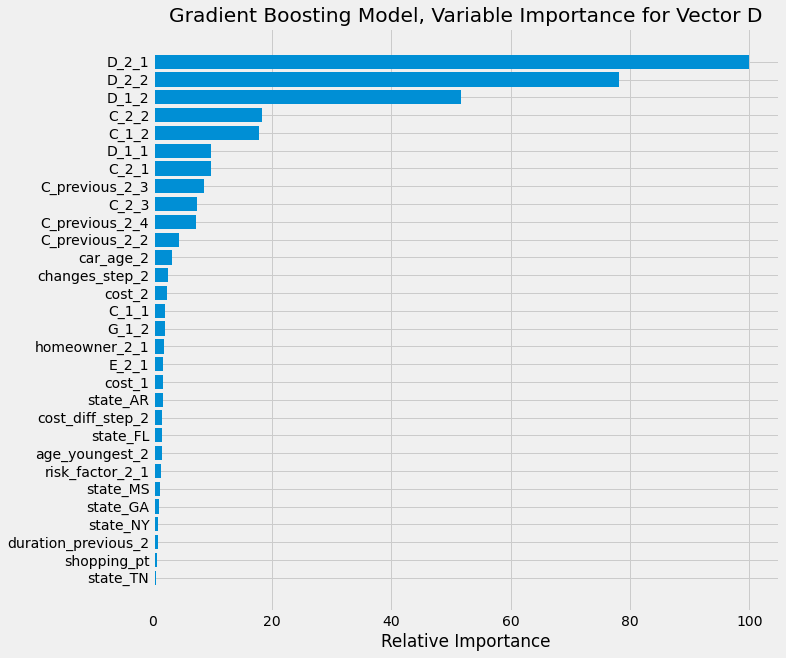

In [400]:
# model D with GradientBoosting classifier
from sklearn.ensemble import GradientBoostingClassifier

vector = 'D'

gb_ac, gb_f1, gb_probs, gb_preds = gb_predict_plot(vector, n_estimators = 200, max_features = 10, max_depth = 3, \
                                                   learning_rate = 0.3, plot = True)



In [401]:
vector = 'D'
score_matrix = model_score_matrix(vector, 2, gb_preds)
score_matrix


C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)


Pred_incorrect  Pred_correct  Pred_accuracy_%
cust_changed_vector               1958           425            17.83
cust_maintained_vector             169         12970            98.71

In [402]:
vector = 'D'
score_matrix = model_score_matrix(vector, 2, gb_preds)
score_matrix
vector='D'
model = 'gb'

score = model_score_by_shopping_pt(vector, 2, gb_preds)

#perf_q1q2.update(vector, 'no_model', 'overall', acc*100)
perf_q1q2.update(vector, model, 'overall', round(gb_ac*100,2))
perf_q1q2.update(vector, model, 'customer_type', score_matrix)
perf_q1q2.update(vector, model, 'shopping_pt', score)
perf_q1q2.compare(vector, model)
perf_q1q2.record[vector]

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple

no_model     rf rf_vs_no_model     gb  \
accuracy_overall                   84.65  86.19           1.54  86.30   
accuracy_cust_changed_vector           0  15.07          15.07  17.83   
accuracy_cust_maintained_vector      100  99.09          -0.91  98.71   
accuracy_shopping_pt_3             88.55  90.01           1.46  89.23   
accuracy_shopping_pt_4             89.61  90.23           0.62  89.84   
accuracy_shopping_pt_5             86.63  87.35           0.72  87.52   
accuracy_shopping_pt_6             84.88  86.00           1.12  86.32   
accuracy_shopping_pt_7             85.64  87.02           1.38  87.05   
accuracy_shopping_pt_8             82.28  83.99           1.71  84.42   
accuracy_shopping_pt_9             83.58  86.03           2.45  85.92   
accuracy_shopping_pt_10             79.4  82.08           2.68  82.90   
accuracy_shopping_pt_11            77.42  82.11           4.69  81.23   
accuracy_shopping_pt_12             75.0  75.00            0.0  76.32   
accuracy_shopping_pt_13             75.0  75.00            0.0  87.50   

                                gb_vs_no_model  
accuracy_overall                          1.65  
accuracy_cust_changed_vector             17.83  
accuracy_cust_maintained_vector          -1.29  
accuracy_shopping_pt_3                    0.68  
accuracy_shopping_pt_4                    0.23  
accuracy_shopping_pt_5                    0.89  
accuracy_shopping_pt_6                    1.44  
accuracy_shopping_pt_7                    1.41  
accuracy_shopping_pt_8                    2.14  
accuracy_shopping_pt_9                    2.34  
accuracy_shopping_pt_10                    3.5  
accuracy_shopping_pt_11                   3.81  
accuracy_shopping_pt_12                   1.32  
accuracy_shopping_pt_13                   12.5

In [83]:
# Let's use RandomizedSearchCV to find the best XGB classifier Hyperparamters for vector D

import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV

vector = 'D'

param_grid = {'learning_rate' : [0.25, 0.3, 0.35, 0.5], 'n_estimators' : np.arange(100,501,100), \
              'colsample_bytree': [0.15,0.25,0.35,0.5], 'max_depth' : [3,4,5]}

clf = xgb.XGBClassifier(objective='binary:logistic', random_state=1, n_jobs=-1)

clf_cv = RandomizedSearchCV(clf, param_grid, n_iter = 60, verbose = 3, cv=4)

clf_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print(f"Vector {vector} RandomizedSearchCV: XG Boosting Model\nBest Score:" + str(clf_cv.best_score_))
print("\nBest Parameters: " + str(clf_cv.best_params_))


Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=4, n_estimators=200;, score=0.871 total time=  11.6s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=4, n_estimators=200;, score=0.867 total time=  12.1s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=4, n_estimators=200;, score=0.865 total time=  12.1s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=4, n_estimators=200;, score=0.864 total time=  11.9s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=100;, score=0.869 total time=   3.1s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=100;, score=0.867 total time=   3.1s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=100;, score=0.864 total time=   3.1s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=100;, score=0.865 total time=  

[CV 2/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=4, n_estimators=200;, score=0.866 total time=  12.2s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=4, n_estimators=200;, score=0.865 total time=  12.2s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=4, n_estimators=200;, score=0.865 total time=  12.6s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.871 total time=   9.5s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.866 total time=   9.5s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.865 total time=   9.5s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.866 total time=   9.5s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=3, n_estimators=100;, score=0.870 total time=   3.8s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.5, max_d

[CV 4/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=5, n_estimators=100;, score=0.866 total time=   6.5s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=4, n_estimators=100;, score=0.869 total time=   3.1s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=4, n_estimators=100;, score=0.866 total time=   3.1s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=4, n_estimators=100;, score=0.863 total time=   3.2s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=4, n_estimators=100;, score=0.864 total time=   3.2s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=3, n_estimators=200;, score=0.869 total time=   9.6s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=3, n_estimators=200;, score=0.866 total time=   9.5s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=3, n_estimators=200;, score=0.865 total time=   9.7s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.5, 

[CV 2/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=3, n_estimators=300;, score=0.866 total time=  14.1s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=3, n_estimators=300;, score=0.864 total time=  14.0s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=3, n_estimators=300;, score=0.864 total time=  14.1s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=300;, score=0.867 total time=   9.0s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=300;, score=0.865 total time=   9.0s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=300;, score=0.862 total time=   9.0s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=300;, score=0.863 total time=   9.0s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.871 total time=   7.7s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.3, max_

In [84]:
results = pd.DataFrame(clf_cv.cv_results_['params'])
results['train_score'] = clf_cv.cv_results_['mean_test_score']
results['train_rank'] = clf_cv.cv_results_['rank_test_score']

save_file(results, 'xgboost_results_vectorD.csv', datapath)

Writing file.  "Modelling_data\xgboost_results_vectorD.csv"


In [85]:
import xgboost as xgb

vector = 'D'

print(f"XGBoost Classifier results for Vector {vector}\n")
#param_grid
for i, row in results.iterrows():
    n_estimators = row['n_estimators']
    max_depth = row['max_depth']
    learning_rate = row['learning_rate']
    colsample_bytree = row['colsample_bytree']
        
    clf = xgb.XGBClassifier(max_depth=int(max_depth), objective='multi:softprob', n_estimators=int(n_estimators), \
                       learning_rate = learning_rate, colsample_bytree = colsample_bytree, n_jobs=-1, random_state=1)

    clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = clf.predict(X_test.to_numpy())
    y_pred_prob = clf.predict_proba(X_test.to_numpy())
    xg_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
    cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

    results.loc[i, 'test_score'] = ac
    results.loc[i, 'f1_score'] = f1
    
    print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}, \
    learning_rate = {learning_rate}, colsample_bytree = {colsample_bytree}")

    print(f'Accuracy={ac:4.4}, f1_score={f1:4.4}')

results['test_rank']= results['test_score'].rank(method='dense', ascending=False)
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
datapath="Modelling_data"
save_file(results,"xgboost_results_vectorD_2.csv",datapath)

XGBoost Classifier results for Vector D

Parameters: No. of Estimators = 200.0,  max_depth = 4.0,     learning_rate = 0.35, colsample_bytree = 0.5
Accuracy=0.8639, f1_score=0.8643
Parameters: No. of Estimators = 100.0,  max_depth = 4.0,     learning_rate = 0.5, colsample_bytree = 0.15
Accuracy=0.8646, f1_score=0.8652
Parameters: No. of Estimators = 300.0,  max_depth = 4.0,     learning_rate = 0.35, colsample_bytree = 0.35
Accuracy=0.8643, f1_score=0.8646
Parameters: No. of Estimators = 200.0,  max_depth = 5.0,     learning_rate = 0.5, colsample_bytree = 0.5
Accuracy=0.8603, f1_score=0.8605
Parameters: No. of Estimators = 300.0,  max_depth = 5.0,     learning_rate = 0.3, colsample_bytree = 0.15
Accuracy=0.8639, f1_score=0.8644
Parameters: No. of Estimators = 300.0,  max_depth = 4.0,     learning_rate = 0.25, colsample_bytree = 0.15
Accuracy=0.8646, f1_score=0.8651
Parameters: No. of Estimators = 300.0,  max_depth = 5.0,     learning_rate = 0.25, colsample_bytree = 0.5
Accuracy=0.8629, f

Parameters: No. of Estimators = 300.0,  max_depth = 4.0,     learning_rate = 0.3, colsample_bytree = 0.5
Accuracy=0.8638, f1_score=0.864
Writing file.  "Modelling_data\xgboost_results_vectorD_2.csv"


In [86]:
results

n_estimators  max_depth  learning_rate  colsample_bytree  train_score  \
0            200          4           0.35              0.50     0.866731   
1            100          4           0.50              0.15     0.866312   
2            300          4           0.35              0.35     0.865362   
3            200          5           0.50              0.50     0.862414   
4            300          5           0.30              0.15     0.866119   
5            300          4           0.25              0.15     0.867488   
6            300          5           0.25              0.50     0.865298   
7            400          3           0.50              0.15     0.866602   
8            200          5           0.25              0.35     0.867134   
9            100          4           0.30              0.35     0.867375   
10           100          5           0.25              0.25     0.867359   
11           100          3           0.30              0.25     0.866989   
12           400          3           0.30              0.25     0.866957   
13           500          3           0.25              0.25     0.867424   
14           400          4           0.35              0.35     0.864218   
15           300          5           0.30              0.50     0.864347   
16           500          5           0.35              0.35     0.861400   
17           200          4           0.25              0.50     0.867085   
18           200          3           0.30              0.50     0.866876   
19           100          3           0.50              0.35     0.867102   
20           400          5           0.50              0.25     0.859837   
21           300          3           0.50              0.35     0.865732   
22           500          4           0.35              0.15     0.864573   
23           400          5           0.30              0.50     0.863429   
24           100          4           0.30              0.15     0.865845   
25           100          5           0.35              0.25     0.866940   
26           400          4           0.25              0.50     0.865829   
27           100          4           0.30              0.50     0.867359   
28           500          4           0.50              0.35     0.859918   
29           300          5           0.30              0.35     0.865072   
30           100          4           0.50              0.35     0.866667   
31           200          5           0.50              0.15     0.865169   
32           400          4           0.25              0.15     0.867569   
33           200          5           0.30              0.15     0.866908   
34           100          5           0.35              0.35     0.867166   
35           100          4           0.25              0.15     0.865442   
36           200          3           0.50              0.50     0.866328   
37           200          5           0.50              0.35     0.862269   
38           400          5           0.30              0.15     0.865620   
39           200          3           0.35              0.15     0.867504   
40           100          5           0.25              0.50     0.867907   
41           100          3           0.30              0.50     0.866747   
42           200          4           0.50              0.15     0.865732   
43           500          3           0.25              0.15     0.867649   
44           300          4           0.50              0.35     0.862881   
45           500          3           0.50              0.50     0.863574   
46           200          4           0.50              0.25     0.865201   
47           100          5           0.30              0.35     0.867295   
48           200          3           0.25              0.50     0.867408   
49           100          3           0.50              0.15     0.866731   
50           200          4           0.50              0.50     0.864412   


XGBoost Classifier results for Vector D
Parameters: No. of Estimators = 500,  max_depth = 3,     learning_rate = 0.25, colsample_bytree = 0.25
Accuracy=0.8648, f1-score=0.8653
Confusion Matrix - normalized
 [[0.8021 0.0709 0.127 ]
 [0.0881 0.7596 0.1523]
 [0.0295 0.0574 0.9132]]
Confusion Matrix
 [[1617  143  256]
 [ 302 2604  522]
 [ 297  578 9203]]

Classification Report 
               precision    recall  f1-score   support

           0       0.73      0.80      0.76      2016
           1       0.78      0.76      0.77      3428
           2       0.92      0.91      0.92     10078

    accuracy                           0.86     15522
   macro avg       0.81      0.82      0.82     15522
weighted avg       0.87      0.86      0.87     15522

30


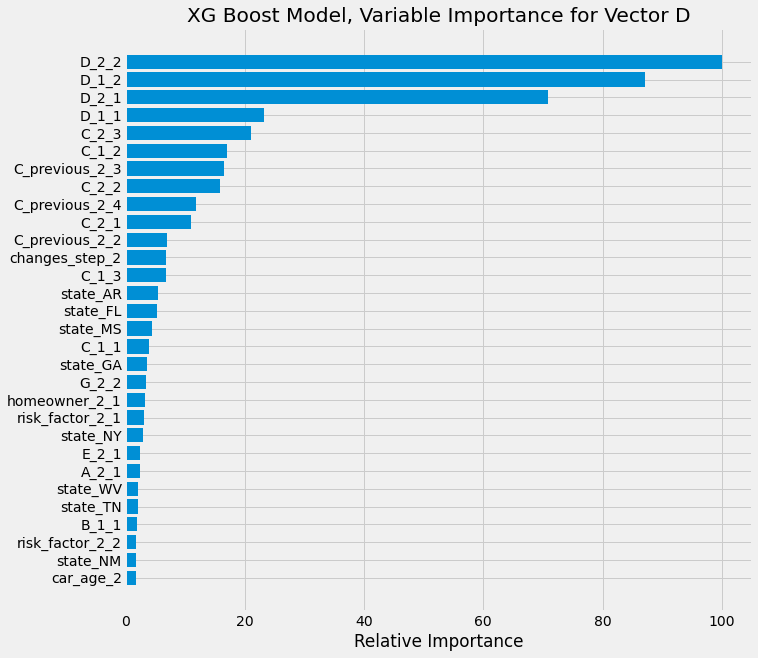

In [403]:
# model D with XGBoost classifier Best Parameters: (Overall 1st rank model)
#  No. of Estimators = 500,  max_depth = 3, learning_rate = 0.25, colsample_bytree = 0.25 : 

vector = 'D'
xg_ac, xg_f1, xg_probs, xg_preds = xg_predict_plot(vector, n_estimators = 500, max_depth = 3, \
                                         learning_rate = 0.25, colsample_bytree = 0.25, plot=True)


In [404]:
vector = 'D'
score_matrix = model_score_matrix(vector, 2, xg_preds)
score_matrix

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)


Pred_incorrect  Pred_correct  Pred_accuracy_%
cust_changed_vector               1930           453            19.01
cust_maintained_vector             168         12971            98.72

In [405]:
vector='D'
model = 'xg'

score = model_score_by_shopping_pt(vector, 2, xg_preds)

#perf_q1q2.update(vector, 'no_model', 'overall', acc*100)
perf_q1q2.update(vector, model, 'overall', round(xg_ac*100,2))
perf_q1q2.update(vector, model, 'customer_type', score_matrix)
perf_q1q2.update(vector, model, 'shopping_pt', score)
perf_q1q2.compare(vector, model)
perf_q1q2.record[vector]

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple

no_model     rf rf_vs_no_model     gb  \
accuracy_overall                   84.65  86.19           1.54  86.30   
accuracy_cust_changed_vector           0  15.07          15.07  17.83   
accuracy_cust_maintained_vector      100  99.09          -0.91  98.71   
accuracy_shopping_pt_3             88.55  90.01           1.46  89.23   
accuracy_shopping_pt_4             89.61  90.23           0.62  89.84   
accuracy_shopping_pt_5             86.63  87.35           0.72  87.52   
accuracy_shopping_pt_6             84.88  86.00           1.12  86.32   
accuracy_shopping_pt_7             85.64  87.02           1.38  87.05   
accuracy_shopping_pt_8             82.28  83.99           1.71  84.42   
accuracy_shopping_pt_9             83.58  86.03           2.45  85.92   
accuracy_shopping_pt_10             79.4  82.08           2.68  82.90   
accuracy_shopping_pt_11            77.42  82.11           4.69  81.23   
accuracy_shopping_pt_12             75.0  75.00            0.0  76.32   
accuracy_shopping_pt_13             75.0  75.00            0.0  87.50   

                                gb_vs_no_model     xg xg_vs_no_model  
accuracy_overall                          1.65  86.48           1.83  
accuracy_cust_changed_vector             17.83  19.01          19.01  
accuracy_cust_maintained_vector          -1.29  98.72          -1.28  
accuracy_shopping_pt_3                    0.68  89.56           1.01  
accuracy_shopping_pt_4                    0.23  90.47           0.86  
accuracy_shopping_pt_5                    0.89  87.85           1.22  
accuracy_shopping_pt_6                    1.44  86.32           1.44  
accuracy_shopping_pt_7                    1.41  87.29           1.65  
accuracy_shopping_pt_8                    2.14  84.31           2.03  
accuracy_shopping_pt_9                    2.34  86.29           2.71  
accuracy_shopping_pt_10                    3.5  82.60            3.2  
accuracy_shopping_pt_11                   3.81  82.11           4.69  
accuracy_shopping_pt_12                   1.32  78.95           3.95  
accuracy_shopping_pt_13                   12.5  75.00            0.0

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/3934441024.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/3934441024.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels)


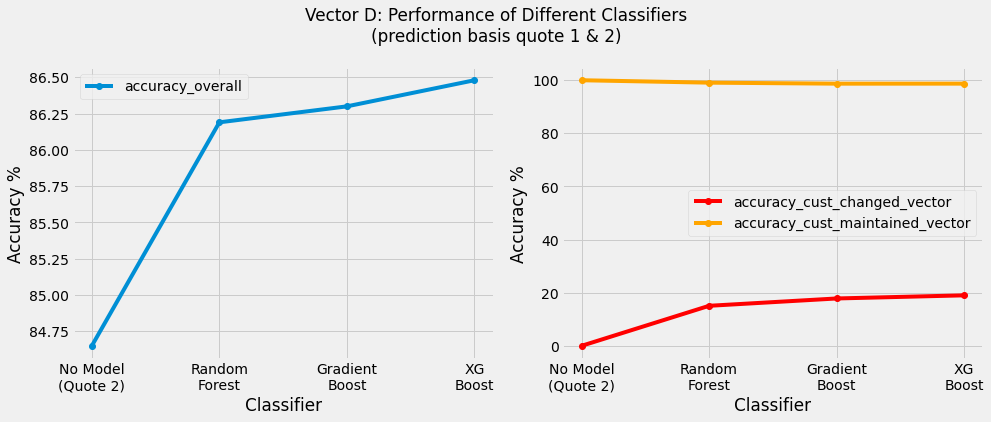

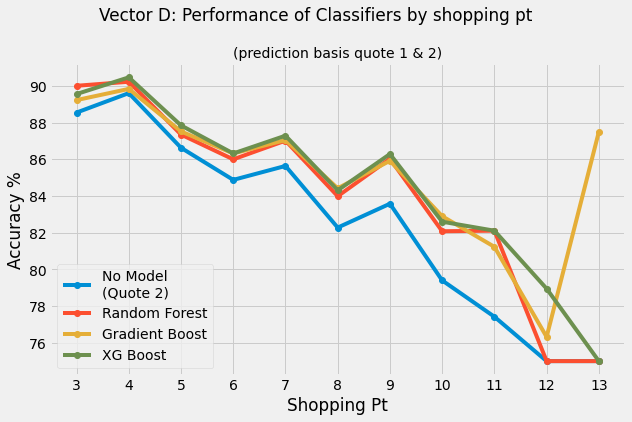

In [524]:
vector = 'D'
#models = ['no_model', 'rf', 'gb', 'xg', 'lr']
models = ['no_model', 'rf', 'gb', 'xg']
quotes = [1,2]
model_performance_plot(vector, models, quotes, "overall")
model_performance_plot(vector, models, quotes, "shopping_pt")

### Vector F: Training Models<a id='Phase1_step3.7'></a>

Random Forest Classifier results for Vector F
Parameters: No. of Estimators = 300,  min_samples_leaf = 1,     min_samples_split = 2
Accuracy=0.8324, f1-score=0.8307
Confusion Matrix - normalized
 [[0.8926 0.0338 0.0664 0.0072]
 [0.041  0.7835 0.1641 0.0113]
 [0.0466 0.0714 0.8598 0.0223]
 [0.0569 0.0865 0.3379 0.5188]]
Confusion Matrix
 [[4464  169  332   36]
 [ 156 2979  624   43]
 [ 272  417 5021  130]
 [  50   76  297  456]]

Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      5001
           1       0.82      0.78      0.80      3802
           2       0.80      0.86      0.83      5840
           3       0.69      0.52      0.59       879

    accuracy                           0.83     15522
   macro avg       0.80      0.76      0.78     15522
weighted avg       0.83      0.83      0.83     15522

30


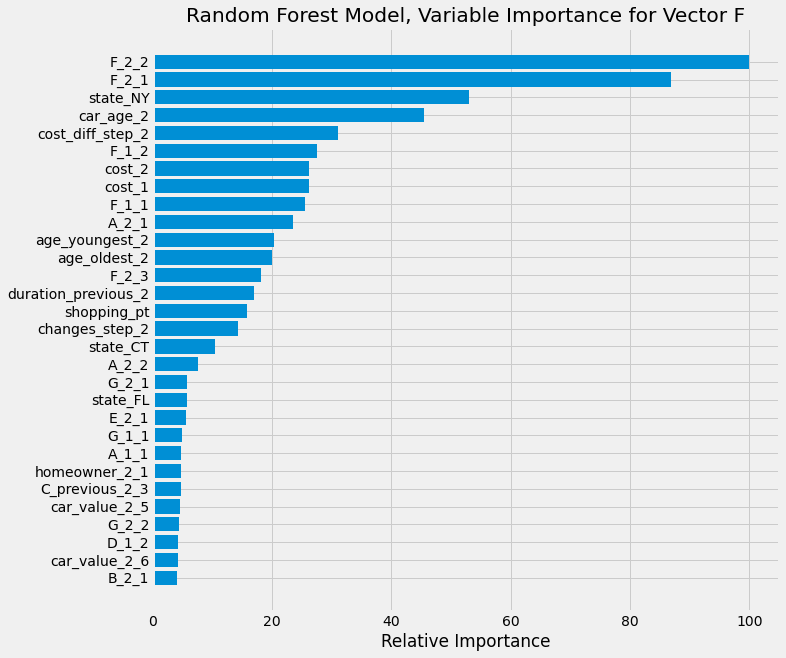

In [408]:
# Let's run the model for vector F

vector = 'F'

rf_ac, rf_f1, rf_probs, rf_preds = rf_predict_plot(vector, plot=True)


In [ ]:
vector = 'F'

x = pd.crosstab(y_test_compare[vector], y_test_compare[vector+"_2"], )
same_as_2 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 
acc = np.around(np.sum(same_as_2)/y_test_compare.shape[0], 4)
print(f"Accuracy based on simply predicting vector {vector} = {vector}_2 : {(np.sum(same_as_2)/y_test_compare.shape[0]): 4.4}")
x['total'] = x.sum(axis=1)
x['F0_%'] = np.around(x[0]*100 / x['total'], 2)
x['F1_%'] = np.around(x[1]*100 / x['total'], 2)
x['F2_%'] = np.around(x[2]*100 / x['total'], 2)
x['F3_%'] = np.around(x[3]*100 / x['total'], 2)
x

In [102]:
# Let's use Bayesian Optimization to find best parameters for Random Forest model for vector F
from bayes_opt import BayesianOptimization

vector = 'F'

def rf_eval(estimators, min_leaf, min_split):
    
    rf = RandomForestClassifier(n_estimators = round(estimators), min_samples_leaf = round(min_leaf), \
                                    min_samples_split = round(min_split), random_state = 1, n_jobs=-1)
    
    cv_result = cross_validate(rf, X_train.to_numpy(), y_train[vector].astype('int'), cv= 4)
    return np.mean(cv_result['test_score'])

rf_bo = BayesianOptimization(rf_eval, {'estimators': (20, 1000), 'min_leaf': (1, 5), 'min_split': (2, 6)})
rf_bo.maximize(n_iter=15, init_points=2)

|   iter    |  target   | estima... | min_leaf  | min_split |
-------------------------------------------------------------
|  1        |  0.8287   |  525.1    |  1.206    |  5.596    |
|  2        |  0.8271   |  979.8    |  4.785    |  2.303    |
|  3        |  0.8287   |  523.8    |  1.322    |  5.614    |
|  4        |  0.8284   |  643.2    |  1.475    |  4.437    |
|  5        |  0.8275   |  20.18    |  3.23     |  5.042    |
|  6        |  0.8283   |  283.6    |  1.758    |  2.46     |
|  7        |  0.8289   |  772.1    |  1.351    |  2.479    |
|  8        |  0.8276   |  834.2    |  4.457    |  5.703    |
|  9        |  0.828    |  727.8    |  2.659    |  2.059    |
|  10       |  0.8268   |  568.0    |  4.751    |  4.171    |
|  11       |  0.8284   |  790.7    |  2.09     |  5.79     |
|  12       |  0.8275   |  755.9    |  3.569    |  5.741    |
|  13       |  0.827    |  779.1    |  4.979    |  2.678    |
|  14       |  0.8288   |  768.0    |  1.499    |  3.415    |
|  15   

In [409]:
vector = 'F'
score_matrix = model_score_matrix(vector, 2, rf_preds)
score_matrix

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)


Pred_incorrect  Pred_correct  Pred_accuracy_%
cust_changed_vector               2527           312            10.99
cust_maintained_vector              75         12608            99.41

In [410]:
vector='F'
model = 'rf'

score = model_score_by_shopping_pt(vector, 2, rf_preds)

perf_q1q2.update(vector, 'no_model', 'overall', acc*100)
perf_q1q2.update(vector, model, 'overall', round(rf_ac*100,2))
perf_q1q2.update(vector, model, 'customer_type', score_matrix)
perf_q1q2.update(vector, model, 'shopping_pt', score)
perf_q1q2.compare(vector, model)
perf_q1q2.record[vector]

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple

no_model     rf rf_vs_no_model
accuracy_overall                   81.71  83.24           1.53
accuracy_cust_changed_vector           0  10.99          10.99
accuracy_cust_maintained_vector      100  99.41          -0.59
accuracy_shopping_pt_3             83.84  84.06           0.22
accuracy_shopping_pt_4             88.12  88.36           0.24
accuracy_shopping_pt_5             84.69  85.75           1.06
accuracy_shopping_pt_6             83.52  84.52            1.0
accuracy_shopping_pt_7             82.21  84.30           2.09
accuracy_shopping_pt_8             79.35  81.20           1.85
accuracy_shopping_pt_9             78.94  81.13           2.19
accuracy_shopping_pt_10             75.8  78.48           2.68
accuracy_shopping_pt_11            71.85  72.73           0.88
accuracy_shopping_pt_12             75.0  78.95           3.95
accuracy_shopping_pt_13             75.0  87.50           12.5

In [407]:
vector = 'F'

#df_train_first2 = pd.read_csv('WIP_data/training_data_with_first2_quotes.csv')
#test_set = df_train_first2.iloc[y_test.index,:]

x = pd.crosstab(test_set['F'], test_set['F_2'])

same_as_2 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 

acc = np.around(np.sum(same_as_2)/y_test.shape[0],4)

print(f"Accuracy based on simply predicting vector {vector} = {vector}_2 : {(np.sum(same_as_2)/y_test.shape[0]): 4.4}")


Accuracy based on simply predicting vector F = F_2 :  0.8171


In [49]:

x['total'] = x.sum(axis=1)
x['F0_%'] = np.around(x[0]*100 / x['total'], 2)
x['F1_%'] = np.around(x[1]*100 / x['total'], 2)
x['F2_%'] = np.around(x[2]*100 / x['total'], 2)
x['F3_%'] = np.around(x[3]*100 / x['total'], 2)
x

F_2     0     1     2    3  total   F0_%   F1_%   F2_%   F3_%
F                                                            
0    4436   182   345   38   5001  88.70   3.64   6.90   0.76
1     250  2973   533   46   3802   6.58  78.20  14.02   1.21
2     477   410  4809  144   5840   8.17   7.02  82.35   2.47
3      93    72   249  465    879  10.58   8.19  28.33  52.90

Gradient Boosting Classifier results for Vector F
Parameters: No. of Estimators = 200,  max_depth = 3,     learning_rate = 0.3, max_features = 10
Accuracy=0.8311, f1-score=0.8296
Confusion Matrix - normalized
 [[0.8968 0.0312 0.0656 0.0064]
 [0.0395 0.7851 0.1644 0.011 ]
 [0.049  0.0748 0.8512 0.025 ]
 [0.0501 0.0842 0.3424 0.5233]]
Confusion Matrix
 [[4485  156  328   32]
 [ 150 2985  625   42]
 [ 286  437 4971  146]
 [  44   74  301  460]]

Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.90      0.90      5001
           1       0.82      0.79      0.80      3802
           2       0.80      0.85      0.82      5840
           3       0.68      0.52      0.59       879

    accuracy                           0.83     15522
   macro avg       0.80      0.76      0.78     15522
weighted avg       0.83      0.83      0.83     15522

20


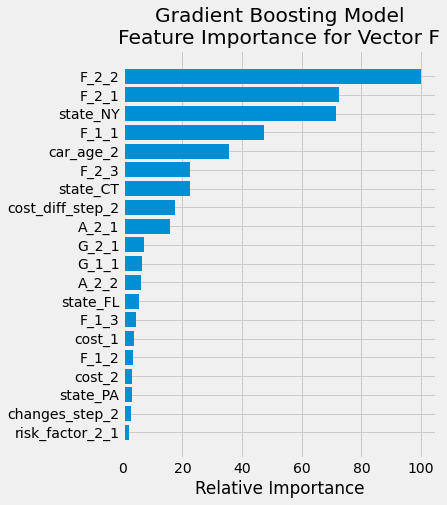

In [117]:
# model F with GradientBoosting classifier
from sklearn.ensemble import GradientBoostingClassifier

vector = 'F'

gb_ac, gb_f1, gb_probs, gb_preds = gb_predict_plot(vector, n_estimators = 200, max_features = 10, max_depth = 3, \
                                                   learning_rate = 0.3, plot = True)

In [28]:
# Let's use RandomizedSearchCV to find the best XGB classifier Hyperparamters for vector F

import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV

vector = 'F'

param_grid = {'learning_rate' : [0.25, 0.3, 0.35], 'n_estimators' : [200], \
              'colsample_bytree': [0.25,0.35,0.5], 'max_depth' : [4]}

clf = xgb.XGBClassifier(objective='multi:softprob', random_state=1, n_jobs=-1)

clf_cv = GridSearchCV(clf, param_grid, verbose = 3, cv=4)

clf_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print(f"Vector {vector} RandomizedSearchCV: XG Boosting Model\nBest Score:" + str(clf_cv.best_score_))
print("\nBest Parameters: " + str(clf_cv.best_params_))

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=200;, score=0.834 total time=  15.9s
[CV 2/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=200;, score=0.834 total time=  17.0s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=200;, score=0.822 total time=  16.7s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=200;, score=0.827 total time=  16.7s
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=4, n_estimators=200;, score=0.835 total time=  16.8s
[CV 2/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=4, n_estimators=200;, score=0.833 total time=  16.3s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=4, n_estimators=200;, score=0.821 total time=  16.0s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=4, n_estimators=200;, score=0.826 total time=

In [29]:
results_2 = pd.DataFrame(clf_cv.cv_results_['params'])
results_2['train_score'] = clf_cv.cv_results_['mean_test_score']
results_2['train_rank'] = clf_cv.cv_results_['rank_test_score']
datapath="Modelling_data"
save_file(results_2,"xgboost_results_vectorF_2pass.csv",datapath)


Writing file.  "Modelling_data\xgboost_results_vectorF_2pass.csv"


In [31]:
import xgboost as xgb

vector = 'F'

print(f"XGBoost Classifier results for Vector {vector}\n")
#param_grid
for i, row in results_2.iterrows():
    n_estimators = row['n_estimators']
    max_depth = row['max_depth']
    learning_rate = row['learning_rate']
    colsample_bytree = row['colsample_bytree']
        
    clf = xgb.XGBClassifier(max_depth=int(max_depth), objective='multi:softprob', n_estimators=int(n_estimators), \
                       learning_rate = learning_rate, colsample_bytree = colsample_bytree, n_jobs=-1, random_state=1)

    clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = clf.predict(X_test.to_numpy())
    y_pred_prob = clf.predict_proba(X_test.to_numpy())
    xg_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
    cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

    results_2.loc[i, 'test_score'] = ac
    results_2.loc[i, 'f1_score'] = f1
    
    print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}, \
    learning_rate = {learning_rate}, colsample_bytree = {colsample_bytree}")

    print(f'Accuracy={ac:4.4}, f1_score={f1:4.4}')

results_2['test_rank']= results_2['test_score'].rank(method='dense', ascending=False)
results_2['tr_te_avg_score'] = (results_2['test_score']+results['train_score'])/2
results_2['overall_rank']= results_2['tr_te_avg_score'].rank(method='dense', ascending=False)


XGBoost Classifier results for Vector F

Parameters: No. of Estimators = 200.0,  max_depth = 4.0,     learning_rate = 0.25, colsample_bytree = 0.25
Accuracy=0.8333, f1_score=0.8316
Parameters: No. of Estimators = 200.0,  max_depth = 4.0,     learning_rate = 0.3, colsample_bytree = 0.25
Accuracy=0.8339, f1_score=0.8321
Parameters: No. of Estimators = 200.0,  max_depth = 4.0,     learning_rate = 0.35, colsample_bytree = 0.25
Accuracy=0.8332, f1_score=0.8314
Parameters: No. of Estimators = 200.0,  max_depth = 4.0,     learning_rate = 0.25, colsample_bytree = 0.35
Accuracy=0.8328, f1_score=0.831
Parameters: No. of Estimators = 200.0,  max_depth = 4.0,     learning_rate = 0.3, colsample_bytree = 0.35
Accuracy=0.833, f1_score=0.8312
Parameters: No. of Estimators = 200.0,  max_depth = 4.0,     learning_rate = 0.35, colsample_bytree = 0.35
Accuracy=0.8328, f1_score=0.831
Parameters: No. of Estimators = 200.0,  max_depth = 4.0,     learning_rate = 0.25, colsample_bytree = 0.5
Accuracy=0.8331, f

In [36]:
results_2['tr_te_avg_score'] = (results_2['test_score']+results_2['train_score'])/2
results_2['overall_rank']= results_2['tr_te_avg_score'].rank(method='dense', ascending=False)

results_2

colsample_bytree  learning_rate  max_depth  n_estimators  train_score  \
0              0.25           0.25          4           200     0.829427   
1              0.25           0.30          4           200     0.828831   
3              0.35           0.25          4           200     0.829798   
4              0.35           0.30          4           200     0.828880   
5              0.35           0.35          4           200     0.828509   
6              0.50           0.25          4           200     0.828944   
7              0.50           0.30          4           200     0.827994   
8              0.50           0.35          4           200     0.828171   

   train_rank  test_score  f1_score  test_rank  tr_te_avg_score  overall_rank  
0           2    0.833269  0.831565        2.0         0.831348           2.0  
1           5    0.833913  0.832136        1.0         0.831372           1.0  
3           1    0.832754  0.831008        7.0         0.831276           3.0  
4           4    0.833011  0.831194        5.0         0.830945           5.0  
5           7    0.832818  0.831020        6.0         0.830664           6.0  
6           3    0.833076  0.831424        4.0         0.831010           4.0  
7           9    0.831272  0.829523        9.0         0.829633           8.0  
8           8    0.832303  0.830512        8.0         0.830237           7.0

In [33]:
datapath="Modelling_data"
save_file(results_2,"xgboost_results_vectorF_2pass.csv",datapath)


A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "Modelling_data\xgboost_results_vectorF_2pass.csv"


In [8]:
# Let's use RandomizedSearchCV to find the best XGB classifier Hyperparamters for vector F

import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV

vector = 'F'

param_grid = {'learning_rate' : [0.25, 0.3, 0.35, 0.5], 'n_estimators' : np.arange(100,501,100), \
              'colsample_bytree': [0.15,0.25,0.35,0.5], 'max_depth' : [3,4,5]}

clf = xgb.XGBClassifier(objective='multi:softprob', random_state=1, n_jobs=-1)

clf_cv = RandomizedSearchCV(clf, param_grid, n_iter = 60, verbose = 3, cv=4)

clf_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print(f"Vector {vector} RandomizedSearchCV: XG Boosting Model\nBest Score:" + str(clf_cv.best_score_))
print("\nBest Parameters: " + str(clf_cv.best_params_))

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=3, n_estimators=200;, score=0.835 total time=   9.9s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=3, n_estimators=200;, score=0.833 total time=   9.9s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=3, n_estimators=200;, score=0.823 total time=  11.3s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=3, n_estimators=200;, score=0.827 total time=  12.6s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=5, n_estimators=200;, score=0.830 total time=  16.1s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=5, n_estimators=200;, score=0.826 total time=  14.6s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=5, n_estimators=200;, score=0.818 total time=  14.9s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=5, n_estimators=200;, score=0.823 total time=  

[CV 2/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=5, n_estimators=500;, score=0.830 total time=  30.7s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=5, n_estimators=500;, score=0.819 total time=  30.4s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=5, n_estimators=500;, score=0.824 total time=  30.1s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=100;, score=0.834 total time=   6.1s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=100;, score=0.832 total time=   6.2s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=100;, score=0.822 total time=   6.4s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=100;, score=0.826 total time=   6.4s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=300;, score=0.833 total time=  14.0s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.

[CV 4/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=4, n_estimators=100;, score=0.827 total time=   6.0s
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.5, max_depth=5, n_estimators=500;, score=0.824 total time=  31.1s
[CV 2/4] END colsample_bytree=0.25, learning_rate=0.5, max_depth=5, n_estimators=500;, score=0.823 total time=  30.1s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.5, max_depth=5, n_estimators=500;, score=0.813 total time=  30.0s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.5, max_depth=5, n_estimators=500;, score=0.815 total time=  29.8s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=5, n_estimators=100;, score=0.835 total time=  10.1s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=5, n_estimators=100;, score=0.833 total time=   9.9s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=5, n_estimators=100;, score=0.823 total time=   9.7s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.25, 

[CV 2/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=5, n_estimators=400;, score=0.829 total time=  29.3s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=5, n_estimators=400;, score=0.818 total time=  29.3s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=5, n_estimators=400;, score=0.823 total time=  30.1s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=4, n_estimators=200;, score=0.834 total time=  15.4s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=4, n_estimators=200;, score=0.833 total time=  15.5s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=4, n_estimators=200;, score=0.823 total time=  15.4s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=4, n_estimators=200;, score=0.826 total time=  15.6s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.836 total time=   9.2s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.3

In [10]:
results = pd.DataFrame(clf_cv.cv_results_['params'])
results['train_score'] = clf_cv.cv_results_['mean_test_score']
results['train_rank'] = clf_cv.cv_results_['rank_test_score']
datapath="Modelling_data"
save_file(results,"xgboost_results_vectorF.csv",datapath)


Writing file.  "Modelling_data\xgboost_results_vectorF.csv"


In [12]:
import xgboost as xgb

vector = 'F'

print(f"XGBoost Classifier results for Vector {vector}\n")
#param_grid
for i, row in results.iterrows():
    n_estimators = row['n_estimators']
    max_depth = row['max_depth']
    learning_rate = row['learning_rate']
    colsample_bytree = row['colsample_bytree']
        
    clf = xgb.XGBClassifier(max_depth=int(max_depth), objective='multi:softprob', n_estimators=int(n_estimators), \
                       learning_rate = learning_rate, colsample_bytree = colsample_bytree, n_jobs=-1, random_state=1)

    clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = clf.predict(X_test.to_numpy())
    y_pred_prob = clf.predict_proba(X_test.to_numpy())
    xg_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
    cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

    results.loc[i, 'test_score'] = ac
    results.loc[i, 'f1_score'] = f1
    
    print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}, \
    learning_rate = {learning_rate}, colsample_bytree = {colsample_bytree}")

    print(f'Accuracy={ac:4.4}, f1_score={f1:4.4}')

results['test_rank']= results['test_score'].rank(method='dense', ascending=False)
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)


XGBoost Classifier results for Vector F

Parameters: No. of Estimators = 200.0,  max_depth = 3.0,     learning_rate = 0.35, colsample_bytree = 0.5
Accuracy=0.8315, f1_score=0.8299
Parameters: No. of Estimators = 200.0,  max_depth = 5.0,     learning_rate = 0.5, colsample_bytree = 0.35
Accuracy=0.8281, f1_score=0.826
Parameters: No. of Estimators = 400.0,  max_depth = 4.0,     learning_rate = 0.25, colsample_bytree = 0.15
Accuracy=0.8324, f1_score=0.8306
Parameters: No. of Estimators = 400.0,  max_depth = 4.0,     learning_rate = 0.3, colsample_bytree = 0.15
Accuracy=0.8319, f1_score=0.83
Parameters: No. of Estimators = 500.0,  max_depth = 4.0,     learning_rate = 0.3, colsample_bytree = 0.15
Accuracy=0.8319, f1_score=0.8301
Parameters: No. of Estimators = 500.0,  max_depth = 4.0,     learning_rate = 0.3, colsample_bytree = 0.25
Accuracy=0.8304, f1_score=0.8284
Parameters: No. of Estimators = 200.0,  max_depth = 5.0,     learning_rate = 0.5, colsample_bytree = 0.25
Accuracy=0.8292, f1_s

Parameters: No. of Estimators = 300.0,  max_depth = 4.0,     learning_rate = 0.5, colsample_bytree = 0.5
Accuracy=0.8282, f1_score=0.8264


In [40]:
results_3['train_rank']= results_3['train_score'].rank(method='dense', ascending=False)
results_3['test_rank']= results_3['test_score'].rank(method='dense', ascending=False)
results_3['overall_rank']= results_3['tr_te_avg_score'].rank(method='dense', ascending=False)



n_estimators  max_depth  learning_rate  colsample_bytree  train_score  \
0            200          3           0.35              0.50     0.829250   
1            200          5           0.50              0.35     0.824370   
2            400          4           0.25              0.15     0.828413   
3            400          4           0.30              0.15     0.828284   
4            500          4           0.30              0.15     0.827752   
..           ...        ...            ...               ...          ...   
62           200          4           0.25              0.35     0.829798   
63           200          4           0.30              0.35     0.828880   
64           200          4           0.35              0.35     0.828509   
65           200          4           0.30              0.50     0.827994   
66           200          4           0.35              0.50     0.828171   

    train_rank  test_score  f1_score  test_rank  tr_te_avg_score  overall_rank  
0         10.0    0.831529  0.829926       23.0         0.830390          24.0  
1         59.0    0.828051  0.826017       42.0         0.826210          63.0  
2         26.0    0.832367  0.830643       12.0         0.830390          25.0  
3         29.0    0.831852  0.830035       19.0         0.830068          33.0  
4         40.0    0.831916  0.830125       18.0         0.829834          36.0  
..         ...         ...       ...        ...              ...           ...  
62         2.0    0.832754  0.831008        9.0         0.831276           4.0  
63        15.0    0.833011  0.831194        7.0         0.830945           9.0  
64        22.0    0.832818  0.831020        8.0         0.830664          18.0  
65        35.0    0.831272  0.829523       26.0         0.829633          41.0  
66        32.0    0.832303  0.830512       13.0         0.830237          29.0  

[67 rows x 11 columns]

In [43]:
results_3.head(37)

n_estimators  max_depth  learning_rate  colsample_bytree  train_score  \
0            200          3           0.35              0.50     0.829250   
1            200          5           0.50              0.35     0.824370   
2            400          4           0.25              0.15     0.828413   
3            400          4           0.30              0.15     0.828284   
4            500          4           0.30              0.15     0.827752   
5            500          4           0.30              0.25     0.826496   
6            200          5           0.50              0.25     0.824338   
7            300          3           0.35              0.50     0.827849   
8            500          4           0.35              0.35     0.825256   
9            400          3           0.50              0.25     0.826802   
10           400          3           0.25              0.35     0.829009   
11           100          5           0.35              0.35     0.828960   
12           400          5           0.25              0.15     0.827253   
13           100          5           0.30              0.15     0.827801   
14           200          3           0.35              0.35     0.829250   
15           200          5           0.30              0.25     0.828413   
16           300          4           0.35              0.35     0.827414   
17           500          5           0.25              0.25     0.826206   
18           100          3           0.25              0.50     0.828799   
19           300          3           0.35              0.35     0.828477   
20           400          4           0.35              0.15     0.827446   
21           300          4           0.25              0.25     0.828783   
22           400          5           0.25              0.25     0.827430   
23           500          4           0.50              0.15     0.822856   
24           100          3           0.35              0.35     0.829379   
25           400          3           0.25              0.15     0.829105   
26           200          3           0.30              0.25     0.829637   
27           400          5           0.35              0.15     0.824708   
28           400          3           0.50              0.35     0.826593   
29           200          5           0.30              0.35     0.828090   
30           100          4           0.35              0.15     0.828300   
31           300          3           0.50              0.25     0.827398   
32           500          5           0.35              0.50     0.821728   
33           200          5           0.35              0.15     0.826657   
34           100          4           0.25              0.35     0.829878   
35           500          5           0.50              0.25     0.818748   
36           100          5           0.25              0.50     0.829540   

    train_rank  test_score  f1_score  test_rank  tr_te_avg_score  overall_rank  
0         10.0    0.831529  0.829926       23.0         0.830390          24.0  
1         59.0    0.828051  0.826017       42.0         0.826210          63.0  
2         26.0    0.832367  0.830643       12.0         0.830390          25.0  
3         29.0    0.831852  0.830035       19.0         0.830068          33.0  
4         40.0    0.831916  0.830125       18.0         0.829834          36.0  
5         51.0    0.830370  0.828421       32.0         0.828433          53.0  
6         60.0    0.829210  0.827193       38.0         0.826774          58.0  
7         37.0    0.833011  0.831337        7.0         0.830430          23.0  
8         54.0    0.830627  0.828753       30.0         0.827942          54.0  
9         48.0    0.830241  0.828487       33.0         0.828521          52.0  
10        12.0    0.832818  0.831086        8.0         0.830913          12.0  
11        13.0    0.831980  0.830154       17.0         0.830470          21.0  
12        46.0    0.8320

In [44]:
results_3.tail(30)

n_estimators  max_depth  learning_rate  colsample_bytree  train_score  \
37           200          3           0.25              0.50     0.829411   
38           400          5           0.50              0.25     0.820375   
39           100          3           0.35              0.15     0.827494   
40           300          4           0.30              0.25     0.828058   
41           400          5           0.30              0.50     0.824321   
42           400          5           0.35              0.25     0.825240   
43           200          4           0.35              0.25     0.828783   
44           500          3           0.50              0.35     0.824756   
45           400          3           0.25              0.50     0.828203   
46           300          5           0.35              0.15     0.825932   
47           500          3           0.25              0.25     0.828284   
48           100          5           0.50              0.50     0.827897   
49           500          3           0.25              0.35     0.828751   
50           400          3           0.30              0.25     0.828493   
51           100          3           0.50              0.15     0.828219   
52           400          5           0.35              0.35     0.824466   
53           200          4           0.25              0.50     0.828944   
54           200          3           0.30              0.35     0.829733   
55           300          3           0.30              0.35     0.828622   
56           500          5           0.35              0.35     0.823500   
57           300          5           0.25              0.35     0.827784   
58           300          5           0.30              0.35     0.826882   
59           300          4           0.50              0.50     0.824273   
60           200          4           0.25              0.25     0.829427   
61           200          4           0.30              0.25     0.828831   
62           200          4           0.25              0.35     0.829798   
63           200          4           0.30              0.35     0.828880   
64           200          4           0.35              0.35     0.828509   
65           200          4           0.30              0.50     0.827994   
66           200          4           0.35              0.50     0.828171   

    train_rank  test_score  f1_score  test_rank  tr_te_avg_score  overall_rank  
37         7.0    0.830950  0.829389       28.0         0.830180          30.0  
38        66.0    0.824700  0.822643       45.0         0.822538          66.0  
39        41.0    0.830241  0.828556       33.0         0.828868          46.0  
40        34.0    0.832496  0.830677       11.0         0.830277          28.0  
41        61.0    0.828437  0.826536       40.0         0.826379          60.0  
42        55.0    0.829726  0.827664       36.0         0.827483          55.0  
43        19.0    0.833204  0.831365        4.0         0.830994           8.0  
44        56.0    0.829210  0.827321       38.0         0.826983          57.0  
45        31.0    0.831723  0.830079       20.0         0.829963          34.0  
46        53.0    0.831207  0.829235       27.0         0.828570          50.0  
47        28.0    0.831916  0.830248       18.0         0.830100          32.0  
48        36.0    0.833398  0.831543        2.0         0.830647          19.0  
49        20.0    0.832625  0.830828       10.0         0.830688          17.0  
50        23.0    0.833204  0.831569        4.0         0.830849          14.0  
51        30.0    0.831594  0.829952       22.0         0.829907          35.0  
52        58.0    0.828501  0.826501       39.0         0.826484          59.0  
53        14.0    0.833076  0.831424        6.0         0.831010           7.0  
54         3.0    0.832109  0.830430       15.0         0.830921          11.0  
55        21.0    0.832045  0.830354       16.0         0.830333          26.

XGBoost Classifier results for Vector F
Parameters: No. of Estimators = 200,  max_depth = 4,     learning_rate = 0.25, colsample_bytree = 0.25
Accuracy=0.8333, f1-score=0.8316
Confusion Matrix - normalized
 [[0.8998 0.0302 0.064  0.006 ]
 [0.0408 0.7856 0.1628 0.0108]
 [0.0473 0.0736 0.855  0.0241]
 [0.0501 0.0887 0.3447 0.5165]]
Confusion Matrix
 [[4500  151  320   30]
 [ 155 2987  619   41]
 [ 276  430 4993  141]
 [  44   78  303  454]]

Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.90      0.90      5001
           1       0.82      0.79      0.80      3802
           2       0.80      0.85      0.83      5840
           3       0.68      0.52      0.59       879

    accuracy                           0.83     15522
   macro avg       0.80      0.76      0.78     15522
weighted avg       0.83      0.83      0.83     15522

30


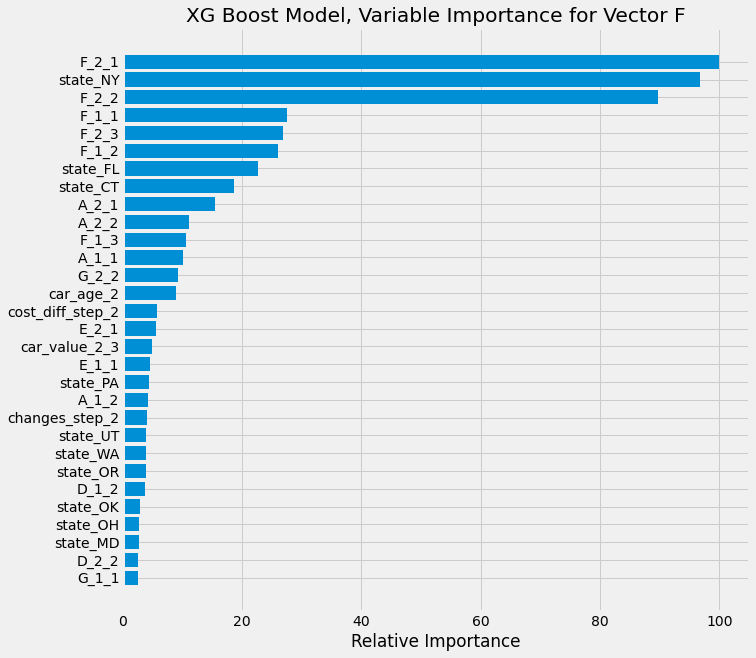

In [411]:
# Final slection is iteration 60: n_estimators = 200, max_depth = 4, learning_rate = 0.25, colsample_bytree = 0.25

vector = 'F'

xg_ac, xg_f1, xg_probs, xg_preds = xg_predict_plot(vector,n_estimators = 200, max_depth = 4, learning_rate = 0.25, \
                                         colsample_bytree = 0.25, plot=True) 

In [412]:
vector = 'F'
score_matrix = model_score_matrix(vector, 2, xg_preds)
score_matrix

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)


Pred_incorrect  Pred_correct  Pred_accuracy_%
cust_changed_vector               2443           396            13.95
cust_maintained_vector             145         12538            98.86

In [413]:
vector='F'
model = 'xg'

score = model_score_by_shopping_pt(vector, 2, xg_preds)

perf_q1q2.update(vector, 'no_model', 'overall', acc*100)
perf_q1q2.update(vector, model, 'overall', round(xg_ac*100,2))
perf_q1q2.update(vector, model, 'customer_type', score_matrix)
perf_q1q2.update(vector, model, 'shopping_pt', score)
perf_q1q2.compare(vector, model)
perf_q1q2.record[vector]

C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/1068994510.py:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple

no_model     rf rf_vs_no_model     xg  \
accuracy_overall                   81.71  83.24           1.53  83.33   
accuracy_cust_changed_vector           0  10.99          10.99  13.95   
accuracy_cust_maintained_vector      100  99.41          -0.59  98.86   
accuracy_shopping_pt_3             83.84  84.06           0.22  84.06   
accuracy_shopping_pt_4             88.12  88.36           0.24  88.28   
accuracy_shopping_pt_5             84.69  85.75           1.06  85.91   
accuracy_shopping_pt_6             83.52  84.52            1.0  84.24   
accuracy_shopping_pt_7             82.21  84.30           2.09  84.50   
accuracy_shopping_pt_8             79.35  81.20           1.85  81.63   
accuracy_shopping_pt_9             78.94  81.13           2.19  81.39   
accuracy_shopping_pt_10             75.8  78.48           2.68  78.37   
accuracy_shopping_pt_11            71.85  72.73           0.88  72.43   
accuracy_shopping_pt_12             75.0  78.95           3.95  76.32   
accuracy_shopping_pt_13             75.0  87.50           12.5  87.50   

                                xg_vs_no_model  
accuracy_overall                          1.62  
accuracy_cust_changed_vector             13.95  
accuracy_cust_maintained_vector          -1.14  
accuracy_shopping_pt_3                    0.22  
accuracy_shopping_pt_4                    0.16  
accuracy_shopping_pt_5                    1.22  
accuracy_shopping_pt_6                    0.72  
accuracy_shopping_pt_7                    2.29  
accuracy_shopping_pt_8                    2.28  
accuracy_shopping_pt_9                    2.45  
accuracy_shopping_pt_10                   2.57  
accuracy_shopping_pt_11                   0.58  
accuracy_shopping_pt_12                   1.32  
accuracy_shopping_pt_13                   12.5

In [414]:
import pickle

with open('Modelling_data/perf_record_q1_q2.pkl', 'wb') as f:
    pickle.dump(perf_q1q2.record, f)


C:\Users\amite\AppData\Local\Temp/ipykernel_29460/3934441024.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels)
C:\Users\amite\AppData\Local\Temp/ipykernel_29460/3934441024.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels)


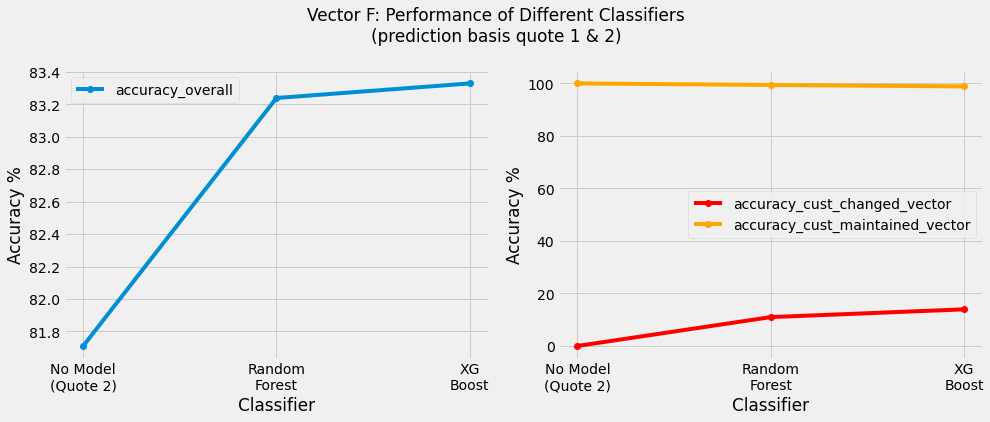

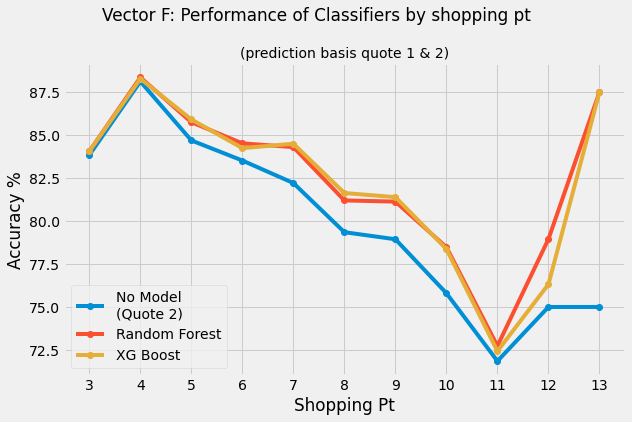

In [526]:
vector = 'F'
#models = ['no_model', 'rf', 'gb', 'xg', 'lr']
models = ['no_model', 'rf', 'xg']
quotes = [1,2]
model_performance_plot(vector, models, quotes, "overall")
model_performance_plot(vector, models, quotes, "shopping_pt")



## Step 4: Summary - Training the Models<a id='Phase1_step4'></a>

In [45]:
datapath="Modelling_data"
save_file(results_3,"xgboost_results_vectorF_round3.csv",datapath)


Writing file.  "Modelling_data\xgboost_results_vectorF_round3.csv"


In [48]:

modelling_summary = pd.DataFrame({'vector' : ['A', 'B', 'C', 'D', 'E', 'F', 'G'], \
                                 'vector_options': [3,2,4,3,2,4,4], \
                                 'accuracy_Vector=quote2' : [0.821,0.833,0.804,0.847,0.832,0.817,0.741],\
                                 'best_model_score': [0.849,0.8352,0.8343,0.8648,0.8424,0.833,0.7601], \
                                 'best_model' : ['xg', 'rf', 'xg', 'xg', 'xg', 'xg', 'xg'], \
                                 'improvement_%': [2.8,0.2,3.03,1.8,1.04,1.6,1.9], \
                                 'score_XG Boost' : [0.849,0.835,0.8343,0.8648,0.8424,0.833,0.7601], \
                                  'score_random_forest' : [0.846,0.835,0.832,0.862,0.84,0.832,0.758], \
                                 'score_gradient_boost' : [0.848,0.833,0.832,0.861,0.842,0,0.757], \
                                 'score_Logistic_Regression' : [0,0.834,0,0,0.835,0,0], \
                                 'score_KNN' : [0,0.793,0,0,0.809,0,0], \
                                                                   
                                 })



Models were developed for each of the 7 vectors based on Quotes 1 and 2. The classifier used for modelling were:

1) Random Forest

2) Gradient Boost

3) XG Boost

4) Logistic Regression and KNN for binary vectors (B and E)

After creating a base set of models, hyperparameters tuning was done using GridSearch CV, Randomized CV and Bayesian Optimization.

The model performance metrics used was primarily **micro_accuracy_score** as our objective was to predict the correct vector selections across all possible vector classes. In addition for binary vectors, the **ROC_AUC** metrics was studied and thresholding was done to find the best threshold that improved model metrics.

The below table summarizes the model performances across all the vectors:



In [69]:
modelling_summary.set_index('vector', inplace=True)
modelling_summary

vector_options  accuracy_Vector=quote2  best_model_score best_model  \
vector                                                                        
A                    3                   0.821            0.8490         xg   
B                    2                   0.833            0.8352         rf   
C                    4                   0.804            0.8343         xg   
D                    3                   0.847            0.8648         xg   
E                    2                   0.832            0.8424         xg   
F                    4                   0.817            0.8330         xg   
G                    4                   0.741            0.7601         xg   

        improvement_%  score_XG Boost  score_random_forest  \
vector                                                       
A                2.80          0.8490                0.846   
B                0.20          0.8350                0.835   
C                3.03          0.8343                0.832   
D                1.80          0.8648                0.862   
E                1.04          0.8424                0.840   
F                1.60          0.8330                0.832   
G                1.90          0.7601                0.758   

        score_gradient_boost  score_Logistic_Regression  score_KNN  
vector                                                              
A                      0.848                      0.000      0.000  
B                      0.833                      0.834      0.793  
C                      0.832                      0.000      0.000  
D                      0.861                      0.000      0.000  
E                      0.842                      0.835      0.809  
F                      0.000                      0.000      0.000  
G                      0.757                      0.000      0.000

In [47]:
modelling_summary['improvement_%'].mean()

1.7671428571428571

The improvement in prediction over NO model (predict final choice = quote 2 choice) ranges from **0.2%** for vector B to **3.03%** for vector C. The average improvement is **1.77%**.

The best performing classifer was **XG Boost**. It bettered accuracy score of Random Forest and Gradient Boost for 6 of the 7 vectors.


# Phase 2: Predictions on the Test Set<a id='Phase 2'></a>

Having built and tested the models on the validation set, we now take the best models for each vector and use them to predict the customer's choices in the Test set.

Recall that the test set was split from the training data provided by All state right in the beginning. The test data has been pre-processed the same way as the training set. The pre-process scaler from the training data set was used to scale the numeric features of the test dataset.


## Step 1: Load the test dataset and create dataframes to compare model performance<a id='Phase2_step1'></a>


In [9]:
# Load the feature and target columns of test data in X_test and y_test

X_test = pd.read_csv('Test_data/pre_processed_test_data_with_quotes_1_2.csv') 
y_test = pd.read_csv('Test_data/test_data_target_columns.csv')

X_test.shape, y_test.shape

((19402, 94), (19402, 7))

In [11]:
# Create a Dataframe that captures the Quote 2 vectors for the test set and shopping point of respective customers
# This would be used to score the model performance for customer who change vectors and customers who don't change vectors
# Shopping point info would be used to find how well the model does for closer and further off shopping points 

df_test_first2 = pd.read_csv('Test_data/test_data_first2_quotes_CDG_remapped.csv')
df_test_first2.head()

customer_ID  shopping_pt state  A  B  C  D  E  F  G  ...  D_1  D_2  E_1  \
0     10129104            5    FL  1  1  2  2  0  1  2  ...    2    2    0   
1     10095371            7    WV  2  0  0  0  0  2  0  ...    0    1    0   
2     10032679            8    MO  2  1  2  2  1  2  2  ...    2    2    1   
3     10025603            5    NY  0  1  3  2  1  0  1  ...    2    2    1   
4     10122799            8    NY  2  1  2  2  1  0  1  ...    2    2    1   

   E_2  F_1  F_2  G_1  G_2  cost_1  cost_2  
0    0    1    1    2    2     606     606  
1    0    0    2    3    0     596     675  
2    1    1    2    2    2     614     617  
3    1    0    0    1    1     599     590  
4    1    0    0    3    1     724     717  

[5 rows x 37 columns]

In [12]:

y_test_compare = y_test.merge(df_test_first2[['shopping_pt','A_2','B_2','C_2','D_2','E_2','F_2','G_2']], left_index=True, right_index=True)

product_vectors = ['A', 'B','C','D','E','F','G']
for vect in product_vectors:
    y_test_compare[vect+'=2'] = np.where(y_test_compare[vect] == y_test_compare[vect+'_2'], 1,0)


y_test_compare.head()

A  B  C  D  E  F  G  shopping_pt  A_2  B_2  ...  E_2  F_2  G_2  A=2  B=2  \
0  1  1  2  2  0  1  2            5    1    1  ...    0    1    2    1    1   
1  2  0  0  0  0  2  0            7    2    0  ...    0    2    0    1    1   
2  2  1  2  2  1  2  2            8    2    1  ...    1    2    2    1    1   
3  0  1  3  2  1  0  1            5    0    1  ...    1    0    1    1    1   
4  2  1  2  2  1  0  1            8    2    1  ...    1    0    1    1    1   

   C=2  D=2  E=2  F=2  G=2  
0    1    1    1    1    1  
1    0    0    1    1    1  
2    1    1    1    1    1  
3    1    1    1    1    1  
4    1    1    1    1    1  

[5 rows x 22 columns]

In [13]:
#Instantiate the object to store performance record for test dataset

perf_record_testdata = ModelPerformanceRecord()
perf_record_testdata.initialize(product_vectors,2)


## Step 2: Make Predictions<a id='Phase2_step2'></a>

## Test Set: Predict Vector A<a id='Phase2_step2.1'></a>

Gradient Boosting Classifier results for Vector A
Parameters: No. of Estimators = 200,  max_depth = 3,     learning_rate = 0.4, max_features = 10
Accuracy=0.8409, f1-score=0.8355
Confusion Matrix - normalized
 [[0.794  0.1785 0.0274]
 [0.0402 0.9286 0.0312]
 [0.0511 0.3715 0.5774]]
Confusion Matrix
 [[ 3389   762   117]
 [  479 11072   372]
 [  164  1193  1854]]

Classification Report 
               precision    recall  f1-score   support

           0       0.84      0.79      0.82      4268
           1       0.85      0.93      0.89     11923
           2       0.79      0.58      0.67      3211

    accuracy                           0.84     19402
   macro avg       0.83      0.77      0.79     19402
weighted avg       0.84      0.84      0.84     19402

10


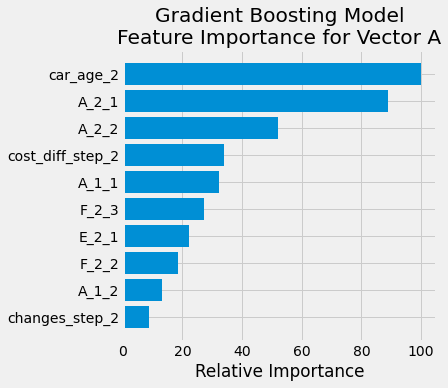

In [26]:
# BEST MODEL for A was with Gradient Boost Classifier

vector = 'A'

gb_ac, gb_f1, gb_probs, gb_preds = gb_predict_plot(vector, n_estimators = 200, learning_rate = 0.4, max_depth = 3, \
                                         max_features = 10, plot=True)


In [65]:
vector = 'A'

x = pd.crosstab(y_test_compare[vector], y_test_compare[vector+"_2"], )
same_as_2 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 
acc = np.around(np.sum(same_as_2)/y_test_compare.shape[0], 4)
print(f"Accuracy based on simply predicting vector {vector} = {vector}_2 : {(np.sum(same_as_2)/y_test_compare.shape[0]): 4.4}")
x['total'] = x.sum(axis=1)
x['A0_%'] = np.around(x[0]*100 / x['total'], 2)
x['A1_%'] = np.around(x[1]*100 / x['total'], 2)
x['A2_%'] = np.around(x[2]*100 / x['total'], 2)
x

Accuracy based on simply predicting vector A = A_2 :  0.8191


A_2     0      1     2  total   A0_%   A1_%   A2_%
A                                                 
0    3264    856   148   4268  76.48  20.06   3.47
1     769  10785   369  11923   6.45  90.46   3.09
2     258   1110  1843   3211   8.03  34.57  57.40

In [71]:
vector = 'A'

model = 'gb'

score_cust_type = model_score_matrix(vector, 2, gb_preds)
score_shp_pt = model_score_by_shopping_pt(vector, 2, gb_preds)

perf_record_testdata.update(vector, 'no_model', 'overall', acc*100)
perf_record_testdata.update(vector, model, 'overall', round(gb_ac*100,2))
perf_record_testdata.update(vector, model, 'customer_type', score_cust_type)
perf_record_testdata.update(vector, model, 'shopping_pt', score_shp_pt)
perf_record_testdata.compare(vector, model)



C:\Users\amite\AppData\Local\Temp/ipykernel_19964/441207066.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_19964/441207066.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_19964/441207066.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

XGBoost Classifier results for Vector A
Parameters: No. of Estimators = 300,  max_depth = 3,     learning_rate = 0.3, colsample_bytree = 0.5
Accuracy=0.8423, f1-score=0.837
Confusion Matrix - normalized
 [[0.799  0.1717 0.0293]
 [0.0396 0.9288 0.0316]
 [0.0492 0.3722 0.5786]]
Confusion Matrix
 [[ 3410   733   125]
 [  472 11074   377]
 [  158  1195  1858]]

Classification Report 
               precision    recall  f1-score   support

           0       0.84      0.80      0.82      4268
           1       0.85      0.93      0.89     11923
           2       0.79      0.58      0.67      3211

    accuracy                           0.84     19402
   macro avg       0.83      0.77      0.79     19402
weighted avg       0.84      0.84      0.84     19402

10


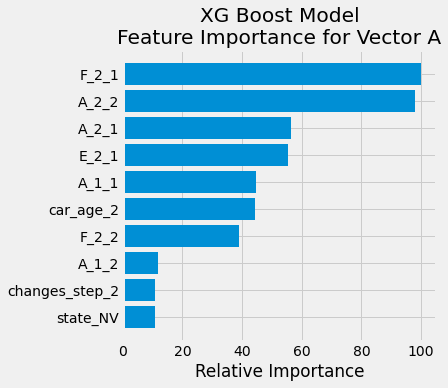

In [27]:
# model A with BEST XGBoost classifier
# Parameters: No. of Estimators = 300,  max_depth = 3, learning_rate = 0.3, colsample_bytree = 0.5 (0.848, .8434)

vector = 'A'
xg_ac, xg_f1, xg_probs, xg_preds = xg_predict_plot(vector, n_estimators = 300, max_depth = 3, \
                                         learning_rate = 0.3, colsample_bytree = 0.5, plot=True)

In [73]:
vector = 'A'
model = 'xg'

score_cust_type = model_score_matrix(vector, 2, xg_preds)
score_shp_pt = model_score_by_shopping_pt(vector, 2, xg_preds)

perf_record_testdata.update(vector, 'no_model', 'overall', acc*100)
perf_record_testdata.update(vector, model, 'overall', round(xg_ac*100,2))
perf_record_testdata.update(vector, model, 'customer_type', score_cust_type)
perf_record_testdata.update(vector, model, 'shopping_pt', score_shp_pt)
perf_record_testdata.compare(vector, model)


C:\Users\amite\AppData\Local\Temp/ipykernel_19964/441207066.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_19964/441207066.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_19964/441207066.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Random Forest Classifier results for Vector A
Parameters: No. of Estimators = 800,  min_samples_leaf = 1,     min_samples_split = 2
Accuracy=0.8417, f1-score=0.836
Confusion Matrix - normalized
 [[0.7828 0.187  0.0302]
 [0.035  0.935  0.03  ]
 [0.0445 0.3818 0.5737]]
Confusion Matrix
 [[ 3341   798   129]
 [  417 11148   358]
 [  143  1226  1842]]

Classification Report 
               precision    recall  f1-score   support

           0       0.86      0.78      0.82      4268
           1       0.85      0.93      0.89     11923
           2       0.79      0.57      0.66      3211

    accuracy                           0.84     19402
   macro avg       0.83      0.76      0.79     19402
weighted avg       0.84      0.84      0.84     19402

10


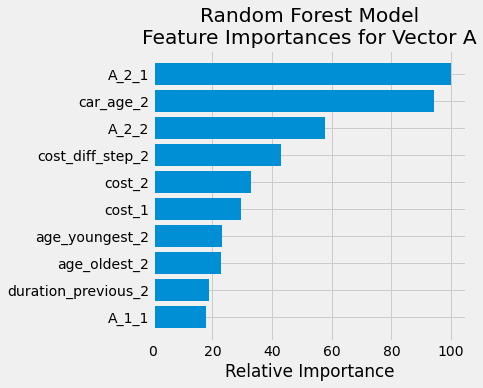

In [28]:
# Run the Random Forest model with Best Parameters: {'n_estimators': 800}


vector = 'A'
rf_ac, rf_f1, rf_probs, rf_preds = rf_predict_plot(vector, n_estimators= 800, plot=True)


In [29]:
from sklearn.ensemble import VotingClassifier
vector = 'A'

#create an array of our models
estimators= [('gb', gb_clf), ('rf', rf_clf), ('xg', xg_clf)]

#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

#fit model to training data
voting_clf = ensemble.fit(X_train.to_numpy(), y_train[vector].astype('int'))
v_yreds = voting_clf.predict(X_test.to_numpy())
voting_ac = accuracy_score(y_test[vector].astype('int'), v_yreds)

voting_ac


0.8437274507782703

In [48]:
vector = 'A'
model = 'rf'

score_cust_type = model_score_matrix(vector, 2, rf_preds)
score_shp_pt = model_score_by_shopping_pt(vector, 2, rf_preds)

perf_record_testdata.update(vector, 'no_model', 'overall', acc*100)
perf_record_testdata.update(vector, model, 'overall', round(rf_ac*100,2))
perf_record_testdata.update(vector, model, 'customer_type', score_cust_type)
perf_record_testdata.update(vector, model, 'shopping_pt', score_shp_pt)
perf_record_testdata.compare(vector, model)

perf_record_testdata.record[vector]

C:\Users\amite\AppData\Local\Temp/ipykernel_13712/441207066.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_13712/441207066.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_13712/441207066.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

no_model     gb gb_vs_no_model     xg  \
accuracy_overall                   81.91  84.09           2.18  84.23   
accuracy_cust_changed_vector           0  21.48          21.48  21.11   
accuracy_cust_maintained_vector      100  97.92          -2.08  98.17   
accuracy_shopping_pt_3             87.33  87.60           0.27  88.14   
accuracy_shopping_pt_4              86.0  87.00            1.0  87.31   
accuracy_shopping_pt_5             84.92  86.25           1.33  85.89   
accuracy_shopping_pt_6             83.14  84.80           1.66  85.02   
accuracy_shopping_pt_7             81.39  83.35           1.96  83.62   
accuracy_shopping_pt_8             80.78  83.80           3.02  83.80   
accuracy_shopping_pt_9             78.39  81.94           3.55  82.10   
accuracy_shopping_pt_10            76.94  80.40           3.46  80.97   
accuracy_shopping_pt_11            77.93  81.92           3.99  80.52   
accuracy_shopping_pt_12            71.58  72.63           1.05  74.74   
accuracy_shopping_pt_13             60.0  60.00            0.0  60.00   

                                xg_vs_no_model     rf rf_vs_no_model  
accuracy_overall                          2.32  84.17           2.26  
accuracy_cust_changed_vector             21.11  17.01          17.01  
accuracy_cust_maintained_vector          -1.83  99.01          -0.99  
accuracy_shopping_pt_3                    0.81  87.96           0.63  
accuracy_shopping_pt_4                    1.31  87.38           1.38  
accuracy_shopping_pt_5                    0.97  86.20           1.28  
accuracy_shopping_pt_6                    1.88  84.93           1.79  
accuracy_shopping_pt_7                    2.23  83.51           2.12  
accuracy_shopping_pt_8                    3.02  83.54           2.76  
accuracy_shopping_pt_9                    3.71  82.31           3.92  
accuracy_shopping_pt_10                   4.03  80.40           3.46  
accuracy_shopping_pt_11                   2.59  80.75           2.82  
accuracy_shopping_pt_12                   3.16  74.74           3.16  
accuracy_shopping_pt_13                    0.0  60.00            0.0

C:\Users\amite\AppData\Local\Temp/ipykernel_13712/441207066.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels)
C:\Users\amite\AppData\Local\Temp/ipykernel_13712/441207066.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels)


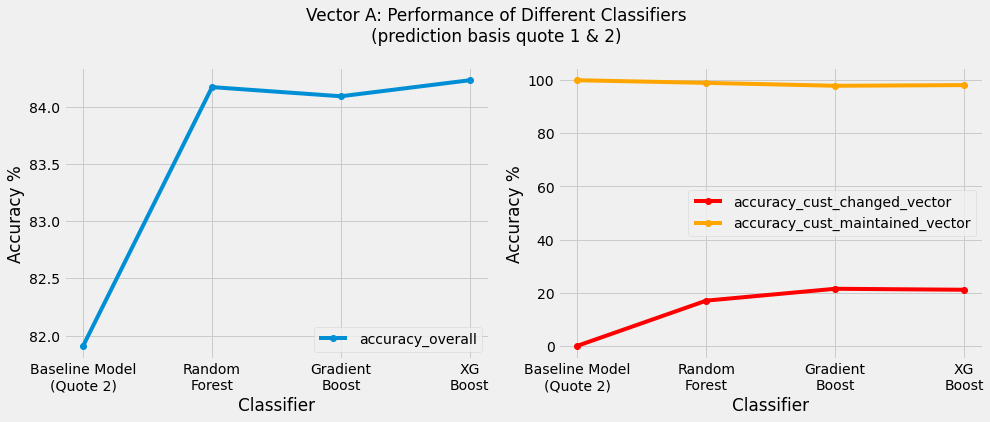

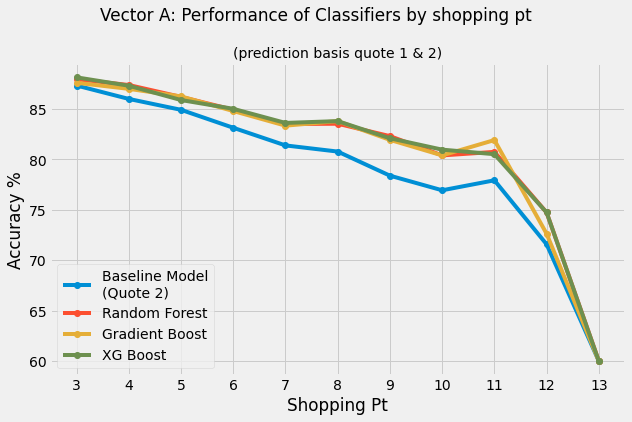

In [44]:
vector = 'A'
#models = ['no_model', 'rf', 'gb', 'xg', 'lr']
models = ['no_model', 'rf', 'gb', 'xg']
quotes = [1,2]
model_performance_plot(vector, models, quotes, perf_record_testdata.record, "overall")
model_performance_plot(vector, models, quotes, perf_record_testdata.record, "shopping_pt")


## Test Set: Predict Vector B<a id='Phase2_step2.2'></a>

Random Forest Classifier results for Vector B
Parameters: No. of Estimators = 200,  min_samples_leaf = 1,     min_samples_split = 2
Accuracy=0.8407, f1-score=0.8403
Confusion Matrix - normalized
 [[0.8777 0.1223]
 [0.2005 0.7995]]
Confusion Matrix
 [[8975 1251]
 [1840 7336]]

Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.88      0.85     10226
           1       0.85      0.80      0.83      9176

    accuracy                           0.84     19402
   macro avg       0.84      0.84      0.84     19402
weighted avg       0.84      0.84      0.84     19402

10


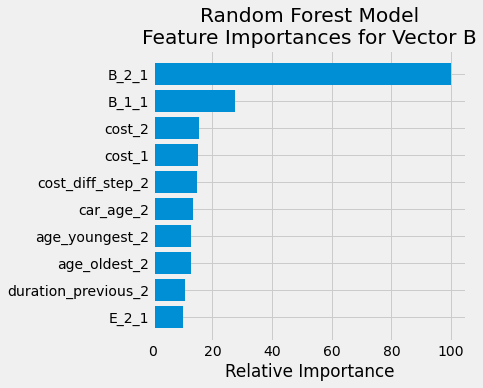

In [31]:
vector = 'B'

rf_ac, rf_f1, rf_probs, rf_preds = rf_predict_plot(vector, n_estimators=200, min_samples_leaf = 1, min_samples_split = 2, plot = True)


In [78]:
vector = 'B'

x = pd.crosstab(y_test_compare[vector], y_test_compare[vector+"_2"], )
same_as_2 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 
acc = np.around(np.sum(same_as_2)/y_test_compare.shape[0], 4)
print(f"Accuracy based on simply predicting vector {vector} = {vector}_2 : {(np.sum(same_as_2)/y_test_compare.shape[0]): 4.4}")
x['total'] = x.sum(axis=1)
x['B0_%'] = np.around(x[0]*100 / x['total'], 2)
x['B1_%'] = np.around(x[1]*100 / x['total'], 2)
x

Accuracy based on simply predicting vector B = B_2 :  0.8396


B_2     0     1  total   B0_%   B1_%
B                                   
0    9018  1208  10226  88.19  11.81
1    1904  7272   9176  20.75  79.25

In [79]:
# As B is a binary vector, let's predict it with a Logistic Regression model

vector = 'B'

lr_ac, lr_f1, lr_probs, lr_preds = lr_predict(vector)


Logistic Regression for vector B
Accuracy = 0.84, f1-score = 0.8395

Confusion Matrix - normalized
 [[0.8814 0.1186]
 [0.2061 0.7939]]
Confusion Matrix
 [[9013 1213]
 [1891 7285]]

Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.88      0.85     10226
           1       0.86      0.79      0.82      9176

    accuracy                           0.84     19402
   macro avg       0.84      0.84      0.84     19402
weighted avg       0.84      0.84      0.84     19402


Area under ROC: 
 0.8757089877742957


C:\Users\amite\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Gradient Boosting Classifier results for Vector B
Parameters: No. of Estimators = 150,  max_depth = 3,     learning_rate = 0.25, max_features = 6
Accuracy=0.8403, f1-score=0.8398
Confusion Matrix - normalized
 [[0.8792 0.1208]
 [0.2031 0.7969]]
Confusion Matrix
 [[8991 1235]
 [1864 7312]]

Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.88      0.85     10226
           1       0.86      0.80      0.83      9176

    accuracy                           0.84     19402
   macro avg       0.84      0.84      0.84     19402
weighted avg       0.84      0.84      0.84     19402

10


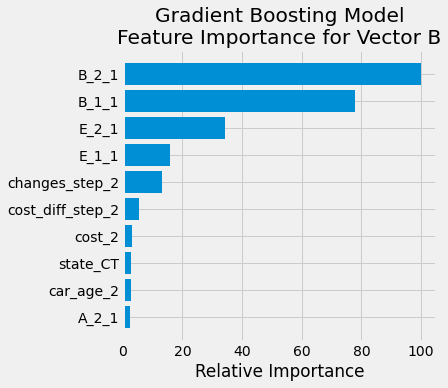

In [30]:
# Now let's predict B with the best GB model 

vector = 'B'
gb_ac, gb_f1, gb_probs, gb_preds = gb_predict_plot(vector, n_estimators = 150, learning_rate = 0.25, max_depth = 3, max_features = 6, plot=True)

fpr_3, tpr_3, thresholds_3 = roc_curve(y_test[vector].astype('int'), gb_probs)

In [48]:
combined_preds = pd.DataFrame({'y_test': y_test[vector], 'XG': xg_preds, 'RF': rf_preds, 'baseline': y_test_compare[vector+'_2']})
combined_preds.sample(7)

y_test  XG  RF  baseline
11104       0   0   0         0
6074        0   0   0         0
12970       0   0   0         0
8349        0   0   0         0
19315       0   0   0         0
11865       1   1   1         1
17333       1   1   1         1

In [49]:
pd.crosstab(combined_preds['XG'], combined_preds['baseline'])

baseline      0     1
XG                   
0         10774    30
1           148  8450

In [50]:
pd.crosstab(combined_preds['RF'], combined_preds['baseline'])

baseline      0     1
RF                   
0         10794    21
1           128  8459

In [40]:
combined_preds[(combined_preds['XG'] == 1) & (combined_preds['baseline'] == 0)]['y_test'].value_counts()


1    76
0    72
Name: y_test, dtype: int64

In [41]:
combined_preds[(combined_preds['XG'] == 0) & (combined_preds['baseline'] == 1)]['y_test'].value_counts()


0    20
1    10
Name: y_test, dtype: int64

In [42]:
combined_preds[(combined_preds['XG'] == 0) & (combined_preds['baseline'] == 0)]['y_test'].value_counts()

0    8946
1    1828
Name: y_test, dtype: int64

In [43]:
combined_preds[(combined_preds['XG'] == 1) & (combined_preds['baseline'] == 1)]['y_test'].value_counts()

1    7262
0    1188
Name: y_test, dtype: int64

In [51]:
combined_preds[(combined_preds['RF'] == 1) & (combined_preds['baseline'] == 0)]['y_test'].value_counts()

1    73
0    55
Name: y_test, dtype: int64

In [52]:
combined_preds[(combined_preds['RF'] == 0) & (combined_preds['baseline'] == 1)]['y_test'].value_counts()

0    12
1     9
Name: y_test, dtype: int64

In [53]:
combined_preds[(combined_preds['RF'] == 1) & (combined_preds['baseline'] == 1)]['y_test'].value_counts()

1    7263
0    1196
Name: y_test, dtype: int64

In [54]:
combined_preds[(combined_preds['RF'] == 1) & (combined_preds['baseline'] == 1)]['y_test'].value_counts()

1    7263
0    1196
Name: y_test, dtype: int64

In [33]:
from sklearn.ensemble import VotingClassifier
vector = 'B'

#create an array of our models
estimators= [('gb', gb_clf), ('rf', rf_clf), ('xg', xg_clf)]

#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

#fit model to training data
voting_clf = ensemble.fit(X_train.to_numpy(), y_train[vector].astype('int'))
v_preds = voting_clf.predict(X_test.to_numpy())
voting_ac = accuracy_score(y_test[vector].astype('int'), v_preds)

voting_ac

0.840944232553345

XGBoost Classifier results for Vector B
Parameters: No. of Estimators = 100,  max_depth = 4,     learning_rate = 0.3, colsample_bytree = 0.35
Accuracy=0.8403, f1-score=0.8399
Confusion Matrix - normalized
 [[0.8768 0.1232]
 [0.2003 0.7997]]
Confusion Matrix
 [[8966 1260]
 [1838 7338]]

Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.88      0.85     10226
           1       0.85      0.80      0.83      9176

    accuracy                           0.84     19402
   macro avg       0.84      0.84      0.84     19402
weighted avg       0.84      0.84      0.84     19402

10


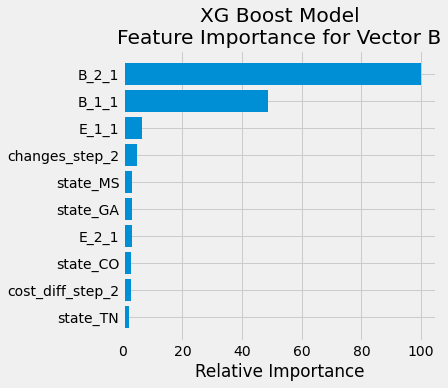

In [32]:
# model B with XGBoost classifier BEST Hyperparameters (Iteration 44)

vector = 'B'

xg_ac, xg_f1, xg_probs, xg_preds = xg_predict_plot(vector, max_depth=4, n_estimators=100, \
                       learning_rate = 0.3, colsample_bytree = 0.35, plot = True)

In [82]:
vector = 'B'
models = ['rf', 'gb', 'xg', 'lr']
model_preds = {'rf' : rf_preds, 'xg' : xg_preds, 'gb' : gb_preds, 'lr' : lr_preds}
model_acc = {'rf' : rf_ac, 'xg' : xg_ac, 'gb' : gb_ac, 'lr' : lr_ac}

for model in models:
    score_cust_type = model_score_matrix(vector, 2, model_preds[model])
    score_shp_pt = model_score_by_shopping_pt(vector, 2, model_preds[model])

    perf_record_testdata.update(vector, 'no_model', 'overall', acc*100)
    perf_record_testdata.update(vector, model, 'overall', round(model_acc[model]*100,2))
    perf_record_testdata.update(vector, model, 'customer_type', score_cust_type)
    perf_record_testdata.update(vector, model, 'shopping_pt', score_shp_pt)
    perf_record_testdata.compare(vector, model)
perf_record_testdata.record[vector]


C:\Users\amite\AppData\Local\Temp/ipykernel_19964/441207066.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_19964/441207066.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_19964/441207066.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

no_model     rf rf_vs_no_model     gb  \
accuracy_overall                   83.96  84.07           0.11  84.03   
accuracy_cust_changed_vector           0   2.73           2.73   1.57   
accuracy_cust_maintained_vector      100  99.61          -0.39  99.78   
accuracy_shopping_pt_3             85.89  85.89            0.0  85.89   
accuracy_shopping_pt_4             87.62  87.81           0.19  87.75   
accuracy_shopping_pt_5             86.73  86.51          -0.22  86.65   
accuracy_shopping_pt_6             84.74  84.77           0.03  84.70   
accuracy_shopping_pt_7             83.92  83.94           0.02  83.92   
accuracy_shopping_pt_8             83.42  83.42            0.0  83.45   
accuracy_shopping_pt_9             81.06  81.44           0.38  81.31   
accuracy_shopping_pt_10            79.08  79.82           0.74  79.65   
accuracy_shopping_pt_11            79.81  80.28           0.47  79.81   
accuracy_shopping_pt_12            84.21  85.26           1.05  83.16   
accuracy_shopping_pt_13             80.0  80.00            0.0  90.00   

                                gb_vs_no_model     xg xg_vs_no_model     lr  \
accuracy_overall                          0.07  84.03           0.07  84.00   
accuracy_cust_changed_vector              1.57   3.08           3.08   0.48   
accuracy_cust_maintained_vector          -0.22  99.50           -0.5  99.96   
accuracy_shopping_pt_3                     0.0  85.89            0.0  85.89   
accuracy_shopping_pt_4                    0.13  87.62            0.0  87.62   
accuracy_shopping_pt_5                   -0.08  86.73            0.0  86.69   
accuracy_shopping_pt_6                   -0.04  84.64           -0.1  84.83   
accuracy_shopping_pt_7                     0.0  83.94           0.02  83.97   
accuracy_shopping_pt_8                    0.03  83.30          -0.12  83.36   
accuracy_shopping_pt_9                    0.25  81.48           0.42  81.10   
accuracy_shopping_pt_10                   0.57  79.41           0.33  79.49   
accuracy_shopping_pt_11                    0.0  80.52           0.71  79.81   
accuracy_shopping_pt_12                  -1.05  86.32           2.11  84.21   
accuracy_shopping_pt_13                   10.0  90.00           10.0  80.00   

                                lr_vs_no_model  
accuracy_overall                          0.04  
accuracy_cust_changed_vector              0.48  
accuracy_cust_maintained_vector          -0.04  
accuracy_shopping_pt_3                     0.0  
accuracy_shopping_pt_4                     0.0  
accuracy_shopping_pt_5                   -0.04  
accuracy_shopping_pt_6                    0.09  
accuracy_shopping_pt_7                    0.05  
accuracy_shopping_pt_8                   -0.06  
accuracy_shopping_pt_9                    0.04  
accuracy_shopping_pt_10                   0.41  
accuracy_shopping_pt_11                    0.0  
accuracy_shopping_pt_12                    0.0  
accuracy_shopping_pt_13                    0.0

C:\Users\amite\AppData\Local\Temp/ipykernel_13712/441207066.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels)
C:\Users\amite\AppData\Local\Temp/ipykernel_13712/441207066.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels)


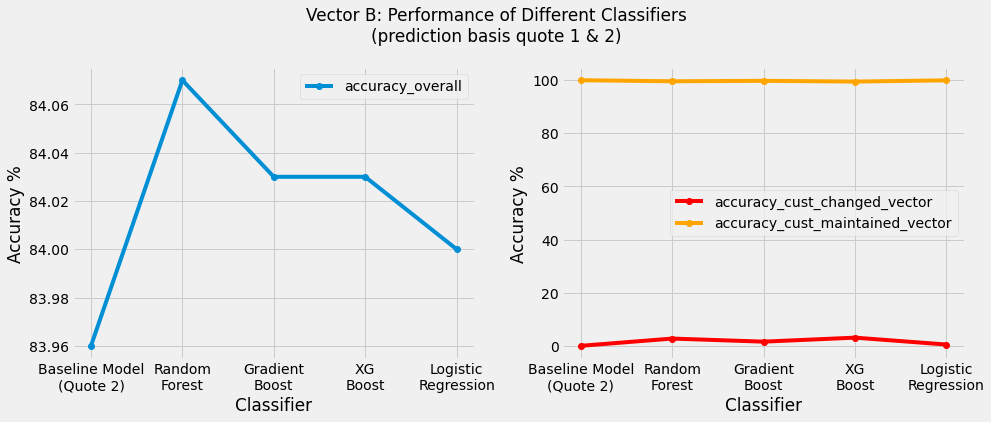

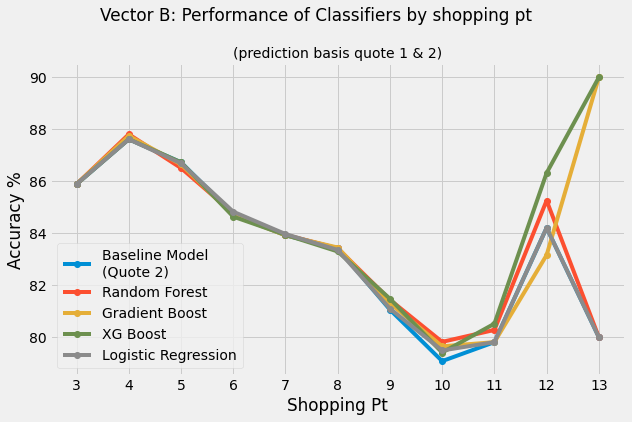

In [158]:
vector = 'B'
models = ['no_model', 'rf', 'gb', 'xg', 'lr']
#models = ['no_model', 'rf', 'gb', 'xg']
quotes = [1,2]
model_performance_plot(vector, models, quotes, perf_record_testdata.record, "overall")
model_performance_plot(vector, models, quotes, perf_record_testdata.record, "shopping_pt")

In [165]:
vector = 'B'

fpr_1, tpr_1, thresholds_1 = roc_curve(y_test[vector].astype('int'), rf_probs)
roc_auc1 = auc(fpr_1, tpr_1)

fpr_2, tpr_2, thresholds_2 = roc_curve(y_test[vector].astype('int'), xg_probs)
roc_auc2 = auc(fpr_2, tpr_2)

fpr_3, tpr_3, thresholds_3 = roc_curve(y_test[vector].astype('int'), lr_probs)
roc_auc3 = auc(fpr_3, tpr_3)

fpr_4, tpr_4, thresholds_4 = roc_curve(y_test[vector].astype('int'), gb_probs)
roc_auc4 = auc(fpr_4, tpr_4)

roc_auc1, roc_auc2, roc_auc3, roc_auc4



(0.8795954401323465,
 0.8853479209874279,
 0.8757089877742957,
 0.8803046463780801)

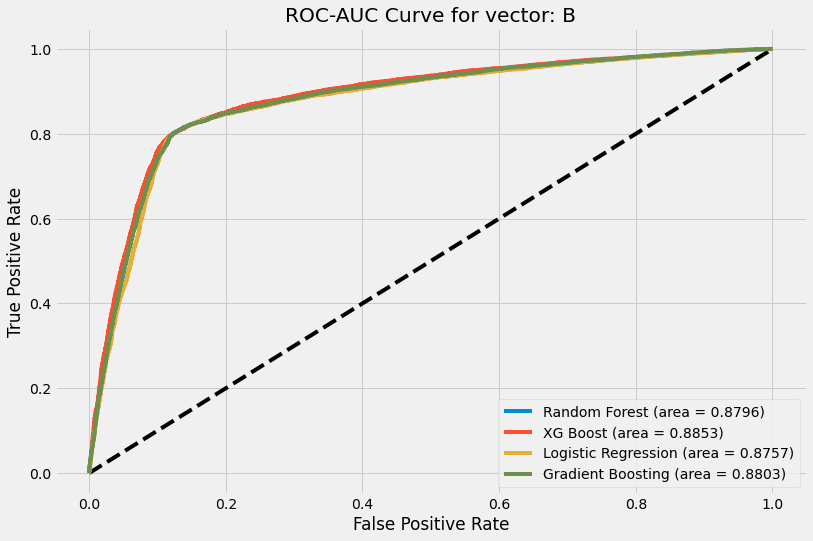

In [166]:
plt.figure(figsize=(12,8))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1, tpr_1, label='Random Forest (area = 0.8796)')
plt.plot(fpr_2, tpr_2, label='XG Boost (area = 0.8853)')
plt.plot(fpr_3, tpr_3, label='Logistic Regression (area = 0.8757)')
plt.plot(fpr_4, tpr_4, label='Gradient Boosting (area = 0.8803)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for vector: '+vector)
plt.legend()
plt.show()

Vector B Logistic Regression Model
Best Accuracy score of 0.8414 occurs for threshold = 0.412
Vector B Random Forest Model
Best Accuracy score of 0.8407 occurs for threshold = 0.475
Vector B XG Boost Model
Best Accuracy score of 0.8408 occurs for threshold = 0.541
Vector B Gradient Boost Model
Best Accuracy score of 0.8409 occurs for threshold = 0.468


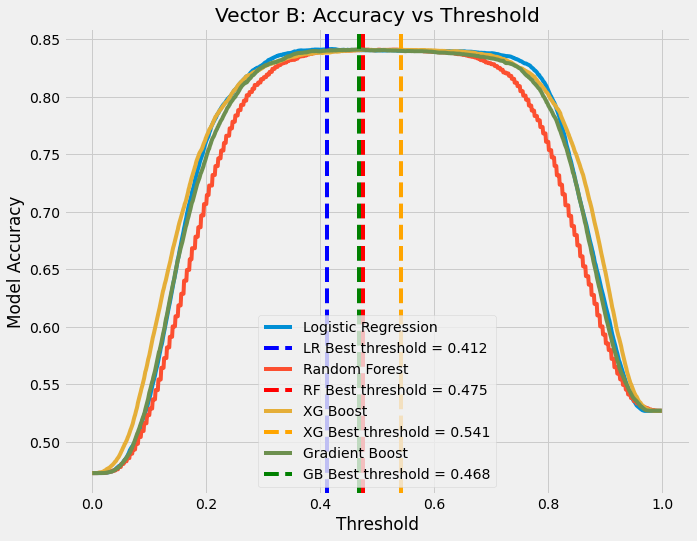

In [83]:
# We are concerned with accuracy of the model i.e. its ability to predict both the 0 and 1 labels correctly
# So we will calculate the accuracy score at different thresholds directly

vector = 'B'
fig, ax = plt.subplots(1,1, figsize=(10,8))

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

thresholds = np.arange(0, 1, 0.001)

# for LR model
ac_score_lr = [accuracy_score(y_test[vector].astype('int'), to_labels(lr_probs, t)) for t in thresholds]
idx = np.argmax(ac_score_lr)
lr_ac_2 = ac_score_lr[idx]
print(f"Vector {vector} Logistic Regression Model\nBest Accuracy score of {lr_ac_2:4.4} occurs for threshold = {thresholds[idx]:4.4}")
plt.plot(thresholds, ac_score_lr, label='Logistic Regression')
plt.axvline(thresholds[idx], color='blue', linestyle="--", label = "LR Best threshold = "+str(np.round(thresholds[idx],4)))

# for random forest
thresholds = np.arange(0, 1, 0.001)
ac_score_rf = [accuracy_score(y_test[vector].astype('int'), to_labels(rf_probs, t)) for t in thresholds]
idx = np.argmax(ac_score_rf)
rf_ac_2 = ac_score_rf[idx]
print(f"Vector {vector} Random Forest Model\nBest Accuracy score of {rf_ac_2:4.4} occurs for threshold = {thresholds[idx]:4.4}")
plt.plot(thresholds, ac_score_rf, label='Random Forest')
plt.axvline(thresholds[idx], color='red', linestyle="--", label = "RF Best threshold = "+str(np.round(thresholds[idx],4)))

# for XG Boost
thresholds = np.arange(0, 1, 0.001)
ac_score_xg = [accuracy_score(y_test[vector].astype('int'), to_labels(xg_probs, t)) for t in thresholds]
idx = np.argmax(ac_score_xg)
xg_ac_2 = ac_score_xg[idx]
print(f"Vector {vector} XG Boost Model\nBest Accuracy score of {xg_ac_2:4.4} occurs for threshold = {thresholds[idx]:4.4}")
plt.plot(thresholds, ac_score_xg, label='XG Boost')
plt.axvline(thresholds[idx], color='orange', linestyle="--", label = "XG Best threshold = "+str(np.round(thresholds[idx],4)))

# for Gradient Boost
thresholds = np.arange(0, 1, 0.001)
ac_score_gb = [accuracy_score(y_test[vector].astype('int'), to_labels(gb_probs, t)) for t in thresholds]
idx = np.argmax(ac_score_gb)
gb_ac_2 = ac_score_gb[idx]
print(f"Vector {vector} Gradient Boost Model\nBest Accuracy score of {gb_ac_2:4.4} occurs for threshold = {thresholds[idx]:4.4}")
plt.plot(thresholds, ac_score_gb, label='Gradient Boost')
plt.axvline(thresholds[idx], color='green', linestyle="--", label = "GB Best threshold = "+str(np.round(thresholds[idx],4)))

plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Model Accuracy')
plt.title('Vector B: Accuracy vs Threshold')

plt.show()
filename1 = "charts_modelling/vector_"+vector+"_thresholding.jpg"
fig.savefig(filename1)

In [68]:
modelling_summary_2_3['improvement_%'].mean()

0.2914285714285714

**Key Observations**
1) The task of 'improving' prediction over vector information available at quote 3 is harder. This is since 88-90% of the customers have already made up their mind and therefore the base of customers about whom prediction has to work gets narrower.

2) The mean improvement over the NO MODEL (final vector = quote 3) is **0.29%** only. For vector B, a binary vector, there was practically no gain in prediction over B_3 (vector B choice at quote 3). Comparatively, the mean improvement at quote_2 was **1.77%**.



In [84]:
vector = 'B'
models = ['rf', 'gb', 'xg', 'lr']
model_acc = {'rf' : rf_ac_2, 'xg' : xg_ac_2, 'gb' : gb_ac_2, 'lr' : lr_ac_2}

for model in models:
    
    perf_record_testdata.update(vector, model, 'overall', round(model_acc[model]*100,2))
    perf_record_testdata.compare(vector, model)

perf_record_testdata.record[vector]

no_model     rf rf_vs_no_model     gb  \
accuracy_overall                   83.96  84.07           0.11  84.09   
accuracy_cust_changed_vector           0   2.73           2.73   1.57   
accuracy_cust_maintained_vector      100  99.61          -0.39  99.78   
accuracy_shopping_pt_3             85.89  85.89            0.0  85.89   
accuracy_shopping_pt_4             87.62  87.81           0.19  87.75   
accuracy_shopping_pt_5             86.73  86.51          -0.22  86.65   
accuracy_shopping_pt_6             84.74  84.77           0.03  84.70   
accuracy_shopping_pt_7             83.92  83.94           0.02  83.92   
accuracy_shopping_pt_8             83.42  83.42            0.0  83.45   
accuracy_shopping_pt_9             81.06  81.44           0.38  81.31   
accuracy_shopping_pt_10            79.08  79.82           0.74  79.65   
accuracy_shopping_pt_11            79.81  80.28           0.47  79.81   
accuracy_shopping_pt_12            84.21  85.26           1.05  83.16   
accuracy_shopping_pt_13             80.0  80.00            0.0  90.00   

                                gb_vs_no_model     xg xg_vs_no_model     lr  \
accuracy_overall                          0.13  84.08           0.12  84.14   
accuracy_cust_changed_vector              1.57   3.08           3.08   0.48   
accuracy_cust_maintained_vector          -0.22  99.50           -0.5  99.96   
accuracy_shopping_pt_3                     0.0  85.89            0.0  85.89   
accuracy_shopping_pt_4                    0.13  87.62            0.0  87.62   
accuracy_shopping_pt_5                   -0.08  86.73            0.0  86.69   
accuracy_shopping_pt_6                   -0.04  84.64           -0.1  84.83   
accuracy_shopping_pt_7                     0.0  83.94           0.02  83.97   
accuracy_shopping_pt_8                    0.03  83.30          -0.12  83.36   
accuracy_shopping_pt_9                    0.25  81.48           0.42  81.10   
accuracy_shopping_pt_10                   0.57  79.41           0.33  79.49   
accuracy_shopping_pt_11                    0.0  80.52           0.71  79.81   
accuracy_shopping_pt_12                  -1.05  86.32           2.11  84.21   
accuracy_shopping_pt_13                   10.0  90.00           10.0  80.00   

                                lr_vs_no_model  
accuracy_overall                          0.18  
accuracy_cust_changed_vector              0.48  
accuracy_cust_maintained_vector          -0.04  
accuracy_shopping_pt_3                     0.0  
accuracy_shopping_pt_4                     0.0  
accuracy_shopping_pt_5                   -0.04  
accuracy_shopping_pt_6                    0.09  
accuracy_shopping_pt_7                    0.05  
accuracy_shopping_pt_8                   -0.06  
accuracy_shopping_pt_9                    0.04  
accuracy_shopping_pt_10                   0.41  
accuracy_shopping_pt_11                    0.0  
accuracy_shopping_pt_12                    0.0  
accuracy_shopping_pt_13                    0.0

## Test Set: Predict Vector C<a id='Phase2_step2.3'></a>

Random Forest Classifier results for Vector C
Parameters: No. of Estimators = 300,  min_samples_leaf = 1,     min_samples_split = 5
Accuracy=0.8276, f1-score=0.8268
Confusion Matrix - normalized
 [[0.8448 0.0769 0.0731 0.0051]
 [0.116  0.7339 0.1392 0.0109]
 [0.047  0.0489 0.8788 0.0253]
 [0.0325 0.0203 0.1723 0.7749]]
Confusion Matrix
 [[4933  449  427   30]
 [ 480 3037  576   45]
 [ 355  369 6635  191]
 [  61   38  323 1453]]

Classification Report 
               precision    recall  f1-score   support

           0       0.85      0.84      0.85      5839
           1       0.78      0.73      0.76      4138
           2       0.83      0.88      0.86      7550
           3       0.85      0.77      0.81      1875

    accuracy                           0.83     19402
   macro avg       0.83      0.81      0.82     19402
weighted avg       0.83      0.83      0.83     19402

10


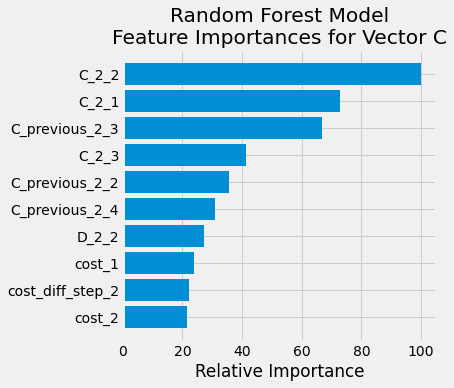

In [36]:
# Best RF model for C
vector = 'C'

rf_ac, rf_f1, rf_probs, rf_preds = rf_predict_plot(vector, n_estimators=300, min_samples_leaf = 1, \
                                                   min_samples_split = 5, plot = True)

In [86]:
vector = 'C'

x = pd.crosstab(y_test_compare[vector], y_test_compare[vector+"_2"], )
same_as_2 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 
acc = np.around(np.sum(same_as_2)/y_test_compare.shape[0], 4)
print(f"Accuracy based on simply predicting vector {vector} = {vector}_2 : {(np.sum(same_as_2)/y_test_compare.shape[0]): 4.4}")
x['total'] = x.sum(axis=1)
x['C0_%'] = np.around(x[0]*100 / x['total'], 2)
x['C1_%'] = np.around(x[1]*100 / x['total'], 2)
x['C2_%'] = np.around(x[2]*100 / x['total'], 2)
x['C3_%'] = np.around(x[3]*100 / x['total'], 2)
x

Accuracy based on simply predicting vector C = C_2 :  0.8018


C_2     0     1     2     3  total   C0_%   C1_%   C2_%   C3_%
C                                                             
0    4747   464   603    25   5839  81.30   7.95  10.33   0.43
1     504  2917   678    39   4138  12.18  70.49  16.38   0.94
2     488   378  6538   146   7550   6.46   5.01  86.60   1.93
3     102    53   366  1354   1875   5.44   2.83  19.52  72.21

Gradient Boosting Classifier results for Vector C
Parameters: No. of Estimators = 200,  max_depth = 3,     learning_rate = 0.25, max_features = 8
Accuracy=0.8282, f1-score=0.8274
Confusion Matrix - normalized
 [[0.8447 0.0757 0.0733 0.0063]
 [0.1165 0.7337 0.1348 0.015 ]
 [0.0478 0.047  0.876  0.0291]
 [0.0251 0.016  0.1664 0.7925]]
Confusion Matrix
 [[4932  442  428   37]
 [ 482 3036  558   62]
 [ 361  355 6614  220]
 [  47   30  312 1486]]

Classification Report 
               precision    recall  f1-score   support

           0       0.85      0.84      0.85      5839
           1       0.79      0.73      0.76      4138
           2       0.84      0.88      0.86      7550
           3       0.82      0.79      0.81      1875

    accuracy                           0.83     19402
   macro avg       0.82      0.81      0.82     19402
weighted avg       0.83      0.83      0.83     19402

10


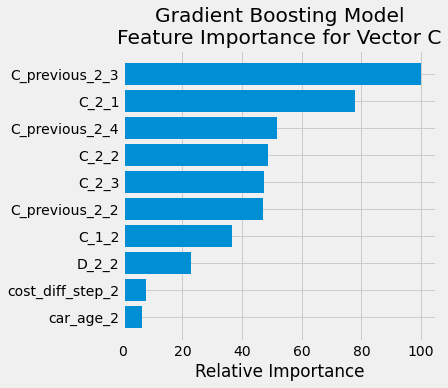

In [35]:
# model C with GradientBoosting classifier
# Best Parameters: {'n_estimators': 200, 'max_features': 8, 'max_depth': 3, 'learning_rate': 0.25}

vector = 'C'

gb_ac, gb_f1, gb_probs, gb_preds = gb_predict_plot(vector, n_estimators = 200, max_features = 8, \
                                                   max_depth = 3, learning_rate = 0.25, plot = True)

XGBoost Classifier results for Vector C
Parameters: No. of Estimators = 200,  max_depth = 5,     learning_rate = 0.25, colsample_bytree = 0.35
Accuracy=0.8298, f1-score=0.829
Confusion Matrix - normalized
 [[0.8486 0.0747 0.0709 0.0058]
 [0.1179 0.7344 0.1348 0.0128]
 [0.0475 0.0458 0.877  0.0297]
 [0.0267 0.0155 0.1664 0.7915]]
Confusion Matrix
 [[4955  436  414   34]
 [ 488 3039  558   53]
 [ 359  346 6621  224]
 [  50   29  312 1484]]

Classification Report 
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      5839
           1       0.79      0.73      0.76      4138
           2       0.84      0.88      0.86      7550
           3       0.83      0.79      0.81      1875

    accuracy                           0.83     19402
   macro avg       0.83      0.81      0.82     19402
weighted avg       0.83      0.83      0.83     19402

10


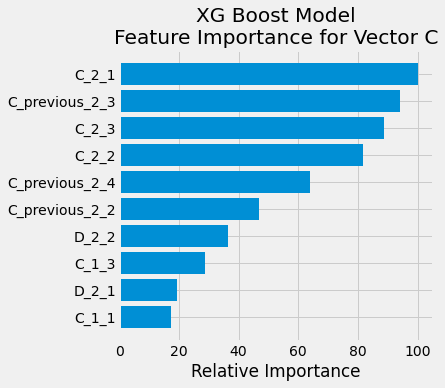

In [34]:
# model C with XGBoost classifier Best Parameters: (Overall 2nd rank model, Iteration 52)

vector = 'C'
xg_ac, xg_f1, xg_probs, xg_preds = xg_predict_plot(vector, n_estimators = 200, max_depth = 5, \
                                         learning_rate = 0.25, colsample_bytree = 0.35, plot=True)


In [37]:
from sklearn.ensemble import VotingClassifier
vector = 'C'

#create an array of our models
estimators= [('gb', gb_clf), ('rf', rf_clf), ('xg', xg_clf)]

#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

#fit model to training data
voting_clf = ensemble.fit(X_train.to_numpy(), y_train[vector].astype('int'))
v_preds = voting_clf.predict(X_test.to_numpy())
voting_ac = accuracy_score(y_test[vector].astype('int'), v_preds)

voting_ac

0.8299144418101226

In [89]:
vector = 'C'
models = ['rf', 'gb', 'xg']
model_preds = {'rf' : rf_preds, 'xg' : xg_preds, 'gb' : gb_preds}
model_acc = {'rf' : rf_ac, 'xg' : xg_ac, 'gb' : gb_ac}

for model in models:
    score_cust_type = model_score_matrix(vector, 2, model_preds[model])
    score_shp_pt = model_score_by_shopping_pt(vector, 2, model_preds[model])

    perf_record_testdata.update(vector, 'no_model', 'overall', acc*100)
    perf_record_testdata.update(vector, model, 'overall', round(model_acc[model]*100,2))
    perf_record_testdata.update(vector, model, 'customer_type', score_cust_type)
    perf_record_testdata.update(vector, model, 'shopping_pt', score_shp_pt)
    perf_record_testdata.compare(vector, model)

perf_record_testdata.record[vector]

C:\Users\amite\AppData\Local\Temp/ipykernel_19964/441207066.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_19964/441207066.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_19964/441207066.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

no_model     rf rf_vs_no_model     gb  \
accuracy_overall                   80.18  82.76           2.58  82.82   
accuracy_cust_changed_vector           0  20.02          20.02  25.64   
accuracy_cust_maintained_vector      100  98.28          -1.72  96.95   
accuracy_shopping_pt_3             85.89  86.97           1.08  85.98   
accuracy_shopping_pt_4             84.75  86.25            1.5  86.38   
accuracy_shopping_pt_5             83.67  85.49           1.82  85.05   
accuracy_shopping_pt_6             81.25  83.46           2.21  84.16   
accuracy_shopping_pt_7             79.26  82.11           2.85  82.01   
accuracy_shopping_pt_8              78.9  81.83           2.93  82.09   
accuracy_shopping_pt_9             76.93  80.31           3.38  80.23   
accuracy_shopping_pt_10            74.88  78.58            3.7  78.50   
accuracy_shopping_pt_11            75.35  78.64           3.29  80.28   
accuracy_shopping_pt_12            73.68  83.16           9.48  81.05   
accuracy_shopping_pt_13             60.0  60.00            0.0  60.00   

                                gb_vs_no_model     xg xg_vs_no_model  
accuracy_overall                          2.64  82.98            2.8  
accuracy_cust_changed_vector             25.64  27.02          27.02  
accuracy_cust_maintained_vector          -3.05  96.81          -3.19  
accuracy_shopping_pt_3                    0.09  86.34           0.45  
accuracy_shopping_pt_4                    1.63  86.62           1.87  
accuracy_shopping_pt_5                    1.38  85.27            1.6  
accuracy_shopping_pt_6                    2.91  84.00           2.75  
accuracy_shopping_pt_7                    2.75  82.41           3.15  
accuracy_shopping_pt_8                    3.19  82.23           3.33  
accuracy_shopping_pt_9                     3.3  80.31           3.38  
accuracy_shopping_pt_10                   3.62  78.58            3.7  
accuracy_shopping_pt_11                   4.93  79.81           4.46  
accuracy_shopping_pt_12                   7.37  82.11           8.43  
accuracy_shopping_pt_13                    0.0  70.00           10.0

C:\Users\amite\AppData\Local\Temp/ipykernel_13712/441207066.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels)
C:\Users\amite\AppData\Local\Temp/ipykernel_13712/441207066.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels)


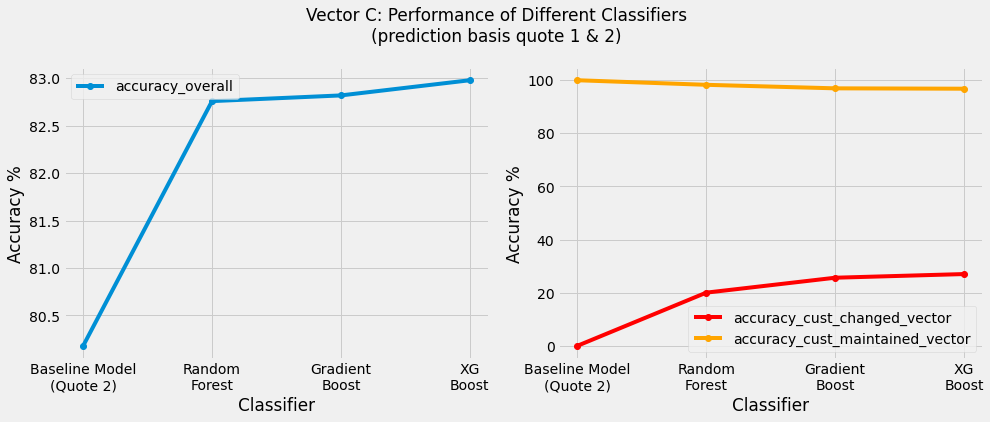

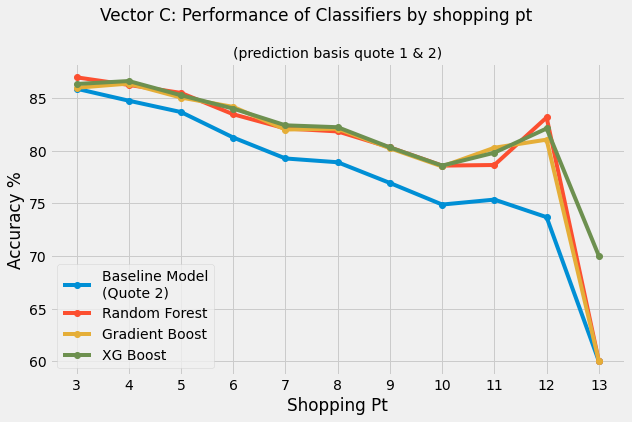

In [66]:
vector = 'C'
#models = ['no_model', 'rf', 'gb', 'xg', 'lr']
models = ['no_model', 'rf', 'gb', 'xg']
quotes = [1,2]
model_performance_plot(vector, models, quotes, perf_record_testdata.record, "overall")
model_performance_plot(vector, models, quotes, perf_record_testdata.record, "shopping_pt")

## Test Set: Predict D<a id='Phase2_step2.4'></a>

Random Forest Classifier results for Vector D
Parameters: No. of Estimators = 300,  min_samples_leaf = 1,     min_samples_split = 2
Accuracy=0.8671, f1-score=0.8679
Confusion Matrix - normalized
 [[0.7968 0.079  0.1242]
 [0.0892 0.7769 0.1339]
 [0.0303 0.0569 0.9128]]
Confusion Matrix
 [[ 2047   203   319]
 [  387  3370   581]
 [  378   711 11406]]

Classification Report 
               precision    recall  f1-score   support

           0       0.73      0.80      0.76      2569
           1       0.79      0.78      0.78      4338
           2       0.93      0.91      0.92     12495

    accuracy                           0.87     19402
   macro avg       0.81      0.83      0.82     19402
weighted avg       0.87      0.87      0.87     19402

10


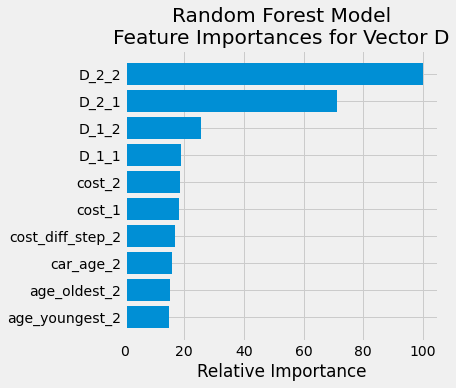

In [90]:
# Let's run the best RF model for vector D

vector = 'D'

rf_ac, rf_f1, rf_probs, rf_preds = rf_predict_plot(vector, plot = True)

In [91]:
vector = 'D'

x = pd.crosstab(y_test_compare[vector], y_test_compare[vector+"_2"], )
same_as_2 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 
acc = np.around(np.sum(same_as_2)/y_test_compare.shape[0], 4)
print(f"Accuracy based on simply predicting vector {vector} = {vector}_2 : {(np.sum(same_as_2)/y_test_compare.shape[0]): 4.4}")
x['total'] = x.sum(axis=1)
x['D0_%'] = np.around(x[0]*100 / x['total'], 2)
x['D1_%'] = np.around(x[1]*100 / x['total'], 2)
x['D2_%'] = np.around(x[2]*100 / x['total'], 2)
x

Accuracy based on simply predicting vector D = D_2 :  0.8509


D_2     0     1      2  total   D0_%   D1_%   D2_%
D                                                 
0    2165   188    216   2569  84.27   7.32   8.41
1     521  3377    440   4338  12.01  77.85  10.14
2     745   782  10968  12495   5.96   6.26  87.78

Gradient Boosting Classifier results for Vector D
Parameters: No. of Estimators = 200,  max_depth = 3,     learning_rate = 0.3, max_features = 10
Accuracy=0.8662, f1-score=0.8667
Confusion Matrix - normalized
 [[0.7917 0.0786 0.1296]
 [0.0897 0.7679 0.1425]
 [0.0295 0.0549 0.9156]]
Confusion Matrix
 [[ 2034   202   333]
 [  389  3331   618]
 [  368   686 11441]]

Classification Report 
               precision    recall  f1-score   support

           0       0.73      0.79      0.76      2569
           1       0.79      0.77      0.78      4338
           2       0.92      0.92      0.92     12495

    accuracy                           0.87     19402
   macro avg       0.81      0.83      0.82     19402
weighted avg       0.87      0.87      0.87     19402

10


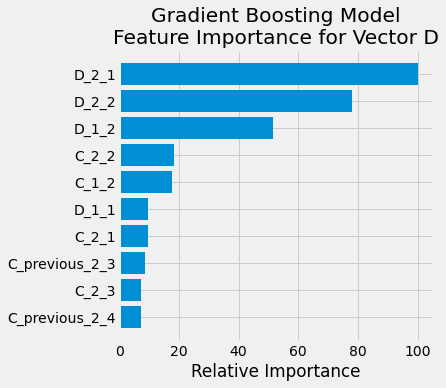

In [92]:
# model D with GradientBoosting classifier
from sklearn.ensemble import GradientBoostingClassifier

vector = 'D'

gb_ac, gb_f1, gb_probs, gb_preds = gb_predict_plot(vector, n_estimators = 200, max_features = 10, max_depth = 3, \
                                                   learning_rate = 0.3, plot = True)

XGBoost Classifier results for Vector D
Parameters: No. of Estimators = 500,  max_depth = 3,     learning_rate = 0.25, colsample_bytree = 0.25
Accuracy=0.8664, f1-score=0.8667
Confusion Matrix - normalized
 [[0.7875 0.0806 0.132 ]
 [0.0869 0.7672 0.1459]
 [0.029  0.054  0.917 ]]
Confusion Matrix
 [[ 2023   207   339]
 [  377  3328   633]
 [  362   675 11458]]

Classification Report 
               precision    recall  f1-score   support

           0       0.73      0.79      0.76      2569
           1       0.79      0.77      0.78      4338
           2       0.92      0.92      0.92     12495

    accuracy                           0.87     19402
   macro avg       0.81      0.82      0.82     19402
weighted avg       0.87      0.87      0.87     19402

10


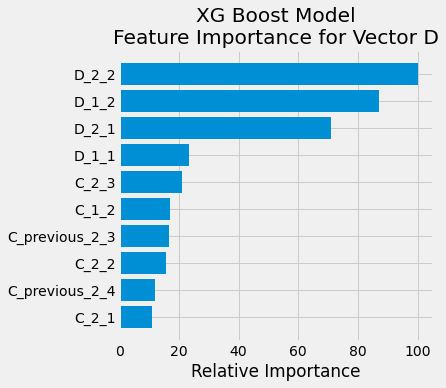

In [93]:
# model D with XGBoost classifier Best Parameters: (Overall 1st rank model)
#  No. of Estimators = 500,  max_depth = 3, learning_rate = 0.25, colsample_bytree = 0.25 : 

vector = 'D'
xg_ac, xg_f1, xg_probs, xg_preds = xg_predict_plot(vector, n_estimators = 500, max_depth = 3, \
                                         learning_rate = 0.25, colsample_bytree = 0.25, plot=True)


In [94]:
vector = 'D'
models = ['rf', 'gb', 'xg']
model_preds = {'rf' : rf_preds, 'xg' : xg_preds, 'gb' : gb_preds}
model_acc = {'rf' : rf_ac, 'xg' : xg_ac, 'gb' : gb_ac}

for model in models:
    score_cust_type = model_score_matrix(vector, 2, model_preds[model])
    score_shp_pt = model_score_by_shopping_pt(vector, 2, model_preds[model])

    perf_record_testdata.update(vector, 'no_model', 'overall', acc*100)
    perf_record_testdata.update(vector, model, 'overall', round(model_acc[model]*100,2))
    perf_record_testdata.update(vector, model, 'customer_type', score_cust_type)
    perf_record_testdata.update(vector, model, 'shopping_pt', score_shp_pt)
    perf_record_testdata.compare(vector, model)

perf_record_testdata.record[vector]

C:\Users\amite\AppData\Local\Temp/ipykernel_19964/441207066.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_19964/441207066.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_19964/441207066.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

no_model     rf rf_vs_no_model     gb  \
accuracy_overall                   85.09  86.71           1.62  86.62   
accuracy_cust_changed_vector           0  16.29          16.29  18.36   
accuracy_cust_maintained_vector      100  99.04          -0.96  98.58   
accuracy_shopping_pt_3             89.94  91.02           1.08  90.84   
accuracy_shopping_pt_4              90.0  91.00            1.0  90.94   
accuracy_shopping_pt_5             86.82  87.98           1.16  87.80   
accuracy_shopping_pt_6             86.14  87.46           1.32  87.10   
accuracy_shopping_pt_7             84.13  86.01           1.88  85.80   
accuracy_shopping_pt_8             83.86  85.68           1.82  85.51   
accuracy_shopping_pt_9             82.94  85.11           2.17  85.31   
accuracy_shopping_pt_10            81.63  83.36           1.73  84.02   
accuracy_shopping_pt_11            79.58  81.46           1.88  81.22   
accuracy_shopping_pt_12            81.05  84.21           3.16  86.32   
accuracy_shopping_pt_13             40.0  50.00           10.0  60.00   

                                gb_vs_no_model     xg xg_vs_no_model  
accuracy_overall                          1.53  86.64           1.55  
accuracy_cust_changed_vector             18.36  19.19          19.19  
accuracy_cust_maintained_vector          -1.42  98.45          -1.55  
accuracy_shopping_pt_3                     0.9  91.11           1.17  
accuracy_shopping_pt_4                    0.94  90.75           0.75  
accuracy_shopping_pt_5                    0.98  88.24           1.42  
accuracy_shopping_pt_6                    0.96  87.30           1.16  
accuracy_shopping_pt_7                    1.67  85.93            1.8  
accuracy_shopping_pt_8                    1.65  85.30           1.44  
accuracy_shopping_pt_9                    2.37  85.15           2.21  
accuracy_shopping_pt_10                   2.39  83.69           2.06  
accuracy_shopping_pt_11                   1.64  80.99           1.41  
accuracy_shopping_pt_12                   5.27  83.16           2.11  
accuracy_shopping_pt_13                   20.0  70.00           30.0

C:\Users\amite\AppData\Local\Temp/ipykernel_13712/441207066.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels)
C:\Users\amite\AppData\Local\Temp/ipykernel_13712/441207066.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels)


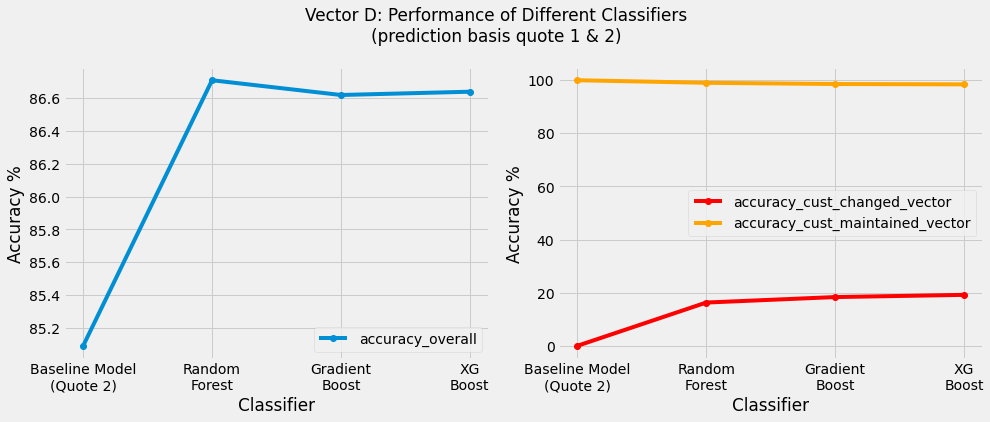

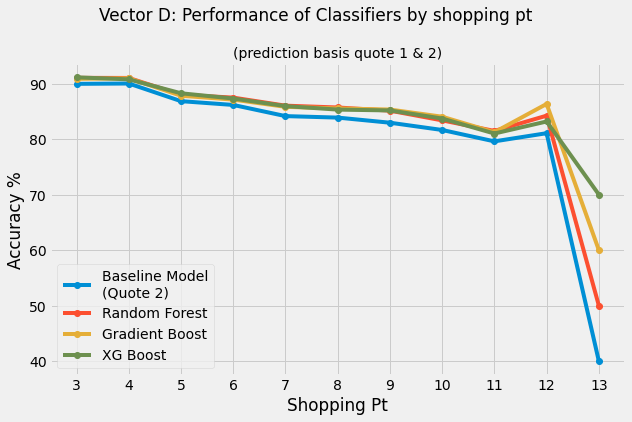

In [77]:
vector = 'D'
#models = ['no_model', 'rf', 'gb', 'xg', 'lr']
models = ['no_model', 'rf', 'gb', 'xg']
quotes = [1,2]
model_performance_plot(vector, models, quotes, perf_record_testdata.record, "overall")
model_performance_plot(vector, models, quotes, perf_record_testdata.record, "shopping_pt")

## Test Set: Predict E<a id='Phase2_step2.5'></a>

Random Forest Classifier results for Vector E
Parameters: No. of Estimators = 100,  min_samples_leaf = 1,     min_samples_split = 2
Accuracy=0.8463, f1-score=0.8458
Confusion Matrix - normalized
 [[0.8866 0.1134]
 [0.2002 0.7998]]
Confusion Matrix
 [[9211 1178]
 [1804 7209]]

Classification Report 
               precision    recall  f1-score   support

           0       0.84      0.89      0.86     10389
           1       0.86      0.80      0.83      9013

    accuracy                           0.85     19402
   macro avg       0.85      0.84      0.84     19402
weighted avg       0.85      0.85      0.85     19402

10


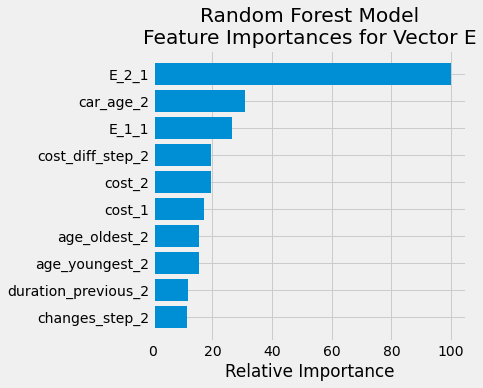

In [95]:
#Let's run the model with Best Parameters: {'n_estimators': 100}

vector = 'E'

rf_ac, rf_f1, rf_probs, rf_preds = rf_predict_plot(vector, n_estimators = 100, plot = True)

In [96]:
vector = 'E'

x = pd.crosstab(y_test_compare[vector], y_test_compare[vector+"_2"], )
same_as_2 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 
acc = np.around(np.sum(same_as_2)/y_test_compare.shape[0], 4)
print(f"Accuracy based on simply predicting vector {vector} = {vector}_2 : {(np.sum(same_as_2)/y_test_compare.shape[0]): 4.4}")
x['total'] = x.sum(axis=1)
x['E0_%'] = np.around(x[0]*100 / x['total'], 2)
x['E1_%'] = np.around(x[1]*100 / x['total'], 2)
x

Accuracy based on simply predicting vector E = E_2 :  0.838


E_2     0     1  total  E0_%  E1_%
E                                 
0    9111  1278  10389  87.7  12.3
1    1866  7147   9013  20.7  79.3

In [97]:
# As E is a binary vector, let's predict it with a Logistic Regression model

vector = 'E'

lr_ac, lr_f1, lr_probs, lr_preds = lr_predict(vector)

Logistic Regression for vector E
Accuracy = 0.8408, f1-score = 0.8403

Confusion Matrix - normalized
 [[0.8785 0.1215]
 [0.2027 0.7973]]
Confusion Matrix
 [[9127 1262]
 [1827 7186]]

Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.88      0.86     10389
           1       0.85      0.80      0.82      9013

    accuracy                           0.84     19402
   macro avg       0.84      0.84      0.84     19402
weighted avg       0.84      0.84      0.84     19402


Area under ROC: 
 0.8952642142972767


C:\Users\amite\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Gradient Boosting Classifier results for Vector E
Parameters: No. of Estimators = 200,  max_depth = 3,     learning_rate = 0.5, max_features = 6
Accuracy=0.8463, f1-score=0.8458
Confusion Matrix - normalized
 [[0.8858 0.1142]
 [0.1994 0.8006]]
Confusion Matrix
 [[9203 1186]
 [1797 7216]]

Classification Report 
               precision    recall  f1-score   support

           0       0.84      0.89      0.86     10389
           1       0.86      0.80      0.83      9013

    accuracy                           0.85     19402
   macro avg       0.85      0.84      0.84     19402
weighted avg       0.85      0.85      0.85     19402

10


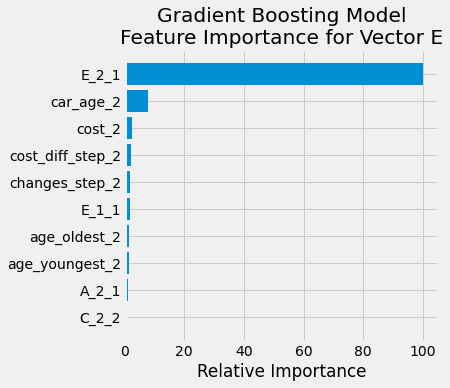

In [100]:
#BEST GB MODEL for E

vector = 'E'

gb_ac, gb_f1, gb_probs, gb_preds = gb_predict_plot(vector, n_estimators = 200, learning_rate = 0.5, max_depth = 3, \
                                         max_features = 6, plot=True)

XGBoost Classifier results for Vector E
Parameters: No. of Estimators = 400,  max_depth = 3,     learning_rate = 0.25, colsample_bytree = 0.5
Accuracy=0.8472, f1-score=0.8468
Confusion Matrix - normalized
 [[0.8858 0.1142]
 [0.1973 0.8027]]
Confusion Matrix
 [[9203 1186]
 [1778 7235]]

Classification Report 
               precision    recall  f1-score   support

           0       0.84      0.89      0.86     10389
           1       0.86      0.80      0.83      9013

    accuracy                           0.85     19402
   macro avg       0.85      0.84      0.85     19402
weighted avg       0.85      0.85      0.85     19402

10


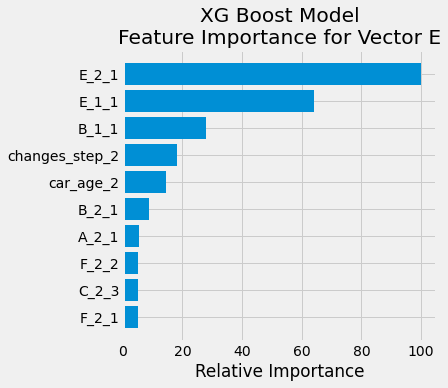

In [99]:
vector = 'E'
xg_ac, xg_f1, xg_probs, xg_preds = xg_predict_plot(vector, n_estimators = 400, max_depth = 3, \
                                         learning_rate = 0.25, colsample_bytree = 0.5, plot=True)

In [101]:
vector = 'E'
models = ['rf', 'gb', 'xg', 'lr']
model_preds = {'rf' : rf_preds, 'xg' : xg_preds, 'gb' : gb_preds, 'lr' : lr_preds}
model_acc = {'rf' : rf_ac, 'xg' : xg_ac, 'gb' : gb_ac, 'lr' : lr_ac}

for model in models:
    score_cust_type = model_score_matrix(vector, 2, model_preds[model])
    score_shp_pt = model_score_by_shopping_pt(vector, 2, model_preds[model])

    perf_record_testdata.update(vector, 'no_model', 'overall', acc*100)
    perf_record_testdata.update(vector, model, 'overall', round(model_acc[model]*100,2))
    perf_record_testdata.update(vector, model, 'customer_type', score_cust_type)
    perf_record_testdata.update(vector, model, 'shopping_pt', score_shp_pt)
    perf_record_testdata.compare(vector, model)

perf_record_testdata.record[vector]

C:\Users\amite\AppData\Local\Temp/ipykernel_19964/441207066.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_19964/441207066.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_19964/441207066.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

no_model     rf rf_vs_no_model     gb  \
accuracy_overall                    83.8  84.63           0.83  84.63   
accuracy_cust_changed_vector           0   8.97           8.97  12.53   
accuracy_cust_maintained_vector      100  99.26          -0.74  98.57   
accuracy_shopping_pt_3             88.05  88.05            0.0  87.96   
accuracy_shopping_pt_4              85.5  85.81           0.31  86.25   
accuracy_shopping_pt_5             87.36  87.58           0.22  87.36   
accuracy_shopping_pt_6             85.06  85.86            0.8  86.02   
accuracy_shopping_pt_7             84.05  84.80           0.75  84.64   
accuracy_shopping_pt_8             82.55  83.91           1.36  83.65   
accuracy_shopping_pt_9             80.31  81.85           1.54  82.02   
accuracy_shopping_pt_10            79.08  80.15           1.07  80.23   
accuracy_shopping_pt_11            80.28  80.99           0.71  81.69   
accuracy_shopping_pt_12             80.0  78.95          -1.05  80.00   
accuracy_shopping_pt_13             70.0  70.00            0.0  60.00   

                                gb_vs_no_model     xg xg_vs_no_model     lr  \
accuracy_overall                          0.83  84.72           0.92  84.08   
accuracy_cust_changed_vector             12.53  13.07          13.07   4.39   
accuracy_cust_maintained_vector          -1.43  98.58          -1.42  99.49   
accuracy_shopping_pt_3                   -0.09  88.32           0.27  87.78   
accuracy_shopping_pt_4                    0.75  86.38           0.88  85.94   
accuracy_shopping_pt_5                     0.0  87.58           0.22  87.27   
accuracy_shopping_pt_6                    0.96  86.11           1.05  85.34   
accuracy_shopping_pt_7                    0.59  84.91           0.86  84.13   
accuracy_shopping_pt_8                     1.1  83.54           0.99  82.96   
accuracy_shopping_pt_9                    1.71  81.98           1.67  80.77   
accuracy_shopping_pt_10                   1.15  80.40           1.32  80.15   
accuracy_shopping_pt_11                   1.41  81.46           1.18  80.75   
accuracy_shopping_pt_12                    0.0  78.95          -1.05  81.05   
accuracy_shopping_pt_13                  -10.0  60.00          -10.0  70.00   

                                lr_vs_no_model  
accuracy_overall                          0.28  
accuracy_cust_changed_vector              4.39  
accuracy_cust_maintained_vector          -0.51  
accuracy_shopping_pt_3                   -0.27  
accuracy_shopping_pt_4                    0.44  
accuracy_shopping_pt_5                   -0.09  
accuracy_shopping_pt_6                    0.28  
accuracy_shopping_pt_7                    0.08  
accuracy_shopping_pt_8                    0.41  
accuracy_shopping_pt_9                    0.46  
accuracy_shopping_pt_10                   1.07  
accuracy_shopping_pt_11                   0.47  
accuracy_shopping_pt_12                   1.05  
accuracy_shopping_pt_13                    0.0

C:\Users\amite\AppData\Local\Temp/ipykernel_13712/441207066.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels)
C:\Users\amite\AppData\Local\Temp/ipykernel_13712/441207066.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels)


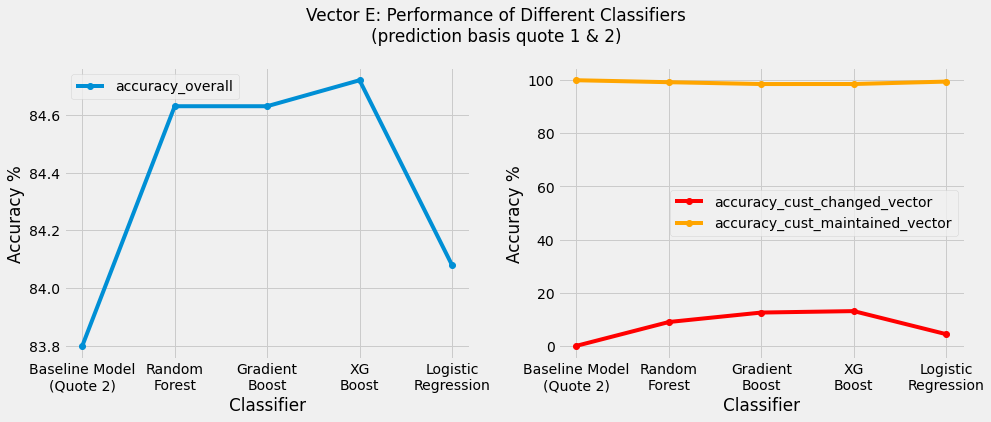

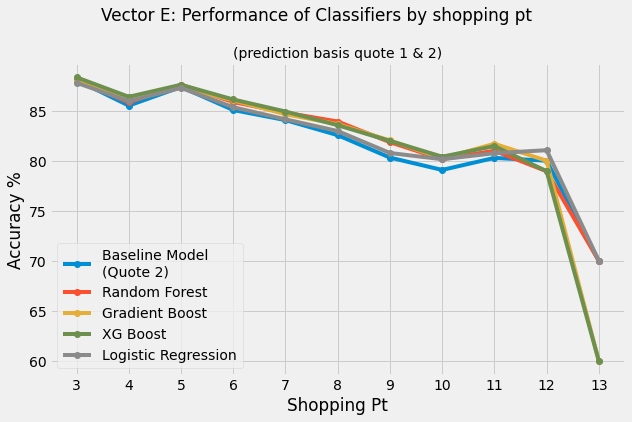

In [187]:
vector = 'E'
models = ['no_model', 'rf', 'gb', 'xg', 'lr']
#models = ['no_model', 'rf', 'gb', 'xg']
quotes = [1,2]
model_performance_plot(vector, models, quotes, perf_record_testdata.record, "overall")
model_performance_plot(vector, models, quotes, perf_record_testdata.record, "shopping_pt")

In [188]:
vector = 'E'

fpr_1, tpr_1, thresholds_1 = roc_curve(y_test[vector].astype('int'), rf_probs)
roc_auc1 = auc(fpr_1, tpr_1)

fpr_2, tpr_2, thresholds_2 = roc_curve(y_test[vector].astype('int'), xg_probs)
roc_auc2 = auc(fpr_2, tpr_2)

fpr_3, tpr_3, thresholds_3 = roc_curve(y_test[vector].astype('int'), lr_probs)
roc_auc3 = auc(fpr_3, tpr_3)

fpr_4, tpr_4, thresholds_4 = roc_curve(y_test[vector].astype('int'), gb_probs)
roc_auc4 = auc(fpr_4, tpr_4)

roc_auc1, roc_auc2, roc_auc3, roc_auc4

(0.8976398803294332,
 0.9048194596660558,
 0.8952642142972767,
 0.9026895056035946)

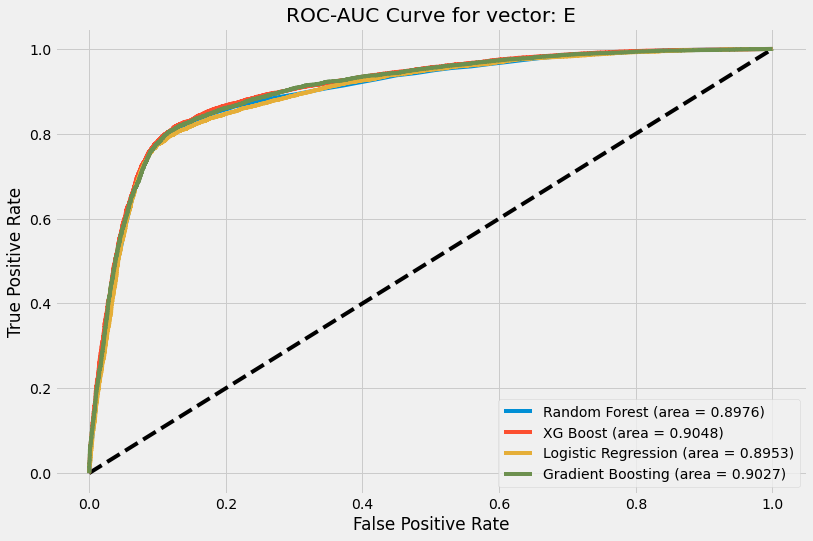

In [189]:
plt.figure(figsize=(12,8))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1, tpr_1, label='Random Forest (area = 0.8976)')
plt.plot(fpr_2, tpr_2, label='XG Boost (area = 0.9048)')
plt.plot(fpr_3, tpr_3, label='Logistic Regression (area = 0.8953)')
plt.plot(fpr_4, tpr_4, label='Gradient Boosting (area = 0.9027)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for vector: '+vector)
plt.legend()
plt.show()

Vector E Logistic Regression Model
Best Accuracy score of 0.8417 occurs for threshold = 0.648
Vector E Random Forest Model
Best Accuracy score of 0.8463 occurs for threshold = 0.491
Vector E XG Boost Model
Best Accuracy score of 0.8477 occurs for threshold = 0.442
Vector E Gradient Boost Model
Best Accuracy score of 0.8469 occurs for threshold = 0.483


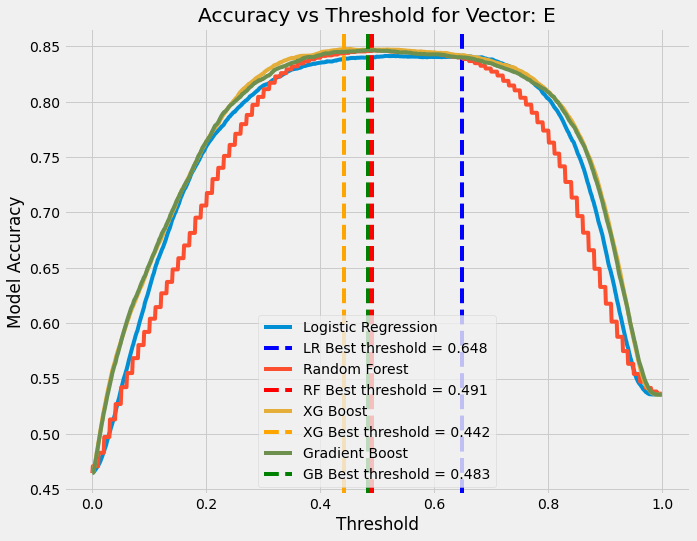

In [193]:
# We are concerned with accuracy of the model i.e. its ability to predict both the 0 and 1 labels correctly
# So we will calculate the accuracy score at different thresholds directly

vector = 'E'
plt.figure(figsize=(10,8))

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

thresholds = np.arange(0, 1, 0.001)

# for LR model
ac_score_lr = [accuracy_score(y_test[vector].astype('int'), to_labels(lr_probs, t)) for t in thresholds]
idx = np.argmax(ac_score_lr)
print(f"Vector {vector} Logistic Regression Model\nBest Accuracy score of {ac_score_lr[idx]:4.4} occurs for threshold = {thresholds[idx]:4.4}")
plt.plot(thresholds, ac_score_lr, label='Logistic Regression')
plt.axvline(thresholds[idx], color='blue', linestyle="--", label = "LR Best threshold = "+str(np.round(thresholds[idx],4)))

# for random forest
thresholds = np.arange(0, 1, 0.001)
ac_score_rf = [accuracy_score(y_test[vector].astype('int'), to_labels(rf_probs, t)) for t in thresholds]
idx = np.argmax(ac_score_rf)
print(f"Vector {vector} Random Forest Model\nBest Accuracy score of {ac_score_rf[idx]:4.4} occurs for threshold = {thresholds[idx]:4.4}")
plt.plot(thresholds, ac_score_rf, label='Random Forest')
plt.axvline(thresholds[idx], color='red', linestyle="--", label = "RF Best threshold = "+str(np.round(thresholds[idx],4)))

# for XG Boost
thresholds = np.arange(0, 1, 0.001)
ac_score_xg = [accuracy_score(y_test[vector].astype('int'), to_labels(xg_probs, t)) for t in thresholds]
idx = np.argmax(ac_score_xg)
print(f"Vector {vector} XG Boost Model\nBest Accuracy score of {ac_score_xg[idx]:4.4} occurs for threshold = {thresholds[idx]:4.4}")
plt.plot(thresholds, ac_score_xg, label='XG Boost')
plt.axvline(thresholds[idx], color='orange', linestyle="--", label = "XG Best threshold = "+str(np.round(thresholds[idx],4)))

# for Gradient Boost
thresholds = np.arange(0, 1, 0.001)
ac_score_gb = [accuracy_score(y_test[vector].astype('int'), to_labels(gb_probs, t)) for t in thresholds]
idx = np.argmax(ac_score_gb)
print(f"Vector {vector} Gradient Boost Model\nBest Accuracy score of {ac_score_gb[idx]:4.4} occurs for threshold = {thresholds[idx]:4.4}")
plt.plot(thresholds, ac_score_gb, label='Gradient Boost')
plt.axvline(thresholds[idx], color='green', linestyle="--", label = "GB Best threshold = "+str(np.round(thresholds[idx],4)))

plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Model Accuracy')
plt.title('Accuracy vs Threshold for Vector: '+vector)

plt.show()

## Test Set: Predict F<a id='Phase2_step2.6'></a>

Random Forest Classifier results for Vector F
Parameters: No. of Estimators = 300,  min_samples_leaf = 1,     min_samples_split = 2
Accuracy=0.8263, f1-score=0.8248
Confusion Matrix - normalized
 [[0.8848 0.031  0.0775 0.0067]
 [0.0371 0.7697 0.1831 0.0101]
 [0.0466 0.076  0.8588 0.0187]
 [0.0624 0.0624 0.3412 0.5339]]
Confusion Matrix
 [[5540  194  485   42]
 [ 177 3670  873   48]
 [ 337  550 6214  135]
 [  71   71  388  607]]

Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      6261
           1       0.82      0.77      0.79      4768
           2       0.78      0.86      0.82      7236
           3       0.73      0.53      0.62      1137

    accuracy                           0.83     19402
   macro avg       0.81      0.76      0.78     19402
weighted avg       0.83      0.83      0.82     19402

10


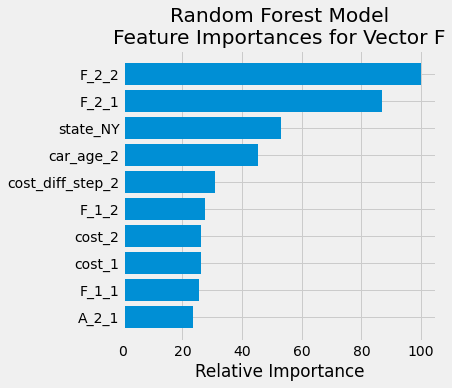

In [102]:
vector = 'F'

rf_ac, rf_f1, rf_probs, rf_preds = rf_predict_plot(vector, plot=True)

In [103]:
vector = 'F'

x = pd.crosstab(y_test_compare[vector], y_test_compare[vector+"_2"], )
same_as_2 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 
acc = np.around(np.sum(same_as_2)/y_test_compare.shape[0], 4)
print(f"Accuracy based on simply predicting vector {vector} = {vector}_2 : {(np.sum(same_as_2)/y_test_compare.shape[0]): 4.4}")
x['total'] = x.sum(axis=1)
x['F0_%'] = np.around(x[0]*100 / x['total'], 2)
x['F1_%'] = np.around(x[1]*100 / x['total'], 2)
x['F2_%'] = np.around(x[2]*100 / x['total'], 2)
x['F3_%'] = np.around(x[3]*100 / x['total'], 2)
x


Accuracy based on simply predicting vector F = F_2 :  0.8104


F_2     0     1     2    3  total   F0_%   F1_%   F2_%   F3_%
F                                                            
0    5521   217   471   52   6261  88.18   3.47   7.52   0.83
1     330  3637   743   58   4768   6.92  76.28  15.58   1.22
2     625   525  5946  140   7236   8.64   7.26  82.17   1.93
3     111    70   337  619   1137   9.76   6.16  29.64  54.44

Gradient Boosting Classifier results for Vector F
Parameters: No. of Estimators = 200,  max_depth = 3,     learning_rate = 0.3, max_features = 10
Accuracy=0.8258, f1-score=0.8243
Confusion Matrix - normalized
 [[0.8892 0.0295 0.0749 0.0064]
 [0.0384 0.768  0.1837 0.0099]
 [0.0481 0.0768 0.8553 0.0198]
 [0.058  0.0651 0.3448 0.5321]]
Confusion Matrix
 [[5567  185  469   40]
 [ 183 3662  876   47]
 [ 348  556 6189  143]
 [  66   74  392  605]]

Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      6261
           1       0.82      0.77      0.79      4768
           2       0.78      0.86      0.82      7236
           3       0.72      0.53      0.61      1137

    accuracy                           0.83     19402
   macro avg       0.81      0.76      0.78     19402
weighted avg       0.83      0.83      0.82     19402

10


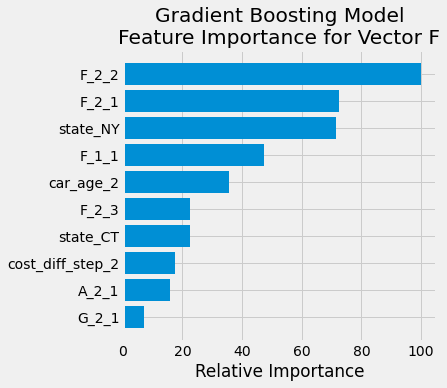

In [104]:
# Model F with best GB classifier

vector = 'F'

gb_ac, gb_f1, gb_probs, gb_preds = gb_predict_plot(vector, n_estimators = 200, max_features = 10, max_depth = 3, \
                                                   learning_rate = 0.3, plot = True)

XGBoost Classifier results for Vector F
Parameters: No. of Estimators = 200,  max_depth = 4,     learning_rate = 0.25, colsample_bytree = 0.25
Accuracy=0.8262, f1-score=0.8246
Confusion Matrix - normalized
 [[0.8908 0.0281 0.0749 0.0062]
 [0.0373 0.7678 0.1852 0.0096]
 [0.0486 0.0771 0.8552 0.0191]
 [0.0536 0.0633 0.3527 0.5303]]
Confusion Matrix
 [[5577  176  469   39]
 [ 178 3661  883   46]
 [ 352  558 6188  138]
 [  61   72  401  603]]

Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      6261
           1       0.82      0.77      0.79      4768
           2       0.78      0.86      0.82      7236
           3       0.73      0.53      0.61      1137

    accuracy                           0.83     19402
   macro avg       0.81      0.76      0.78     19402
weighted avg       0.83      0.83      0.82     19402

10


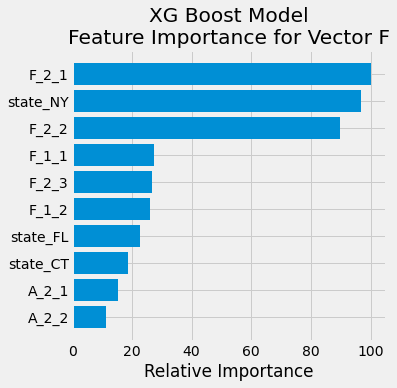

In [105]:
# Final slection is iteration 60: n_estimators = 200, max_depth = 4, learning_rate = 0.25, colsample_bytree = 0.25

vector = 'F'

xg_ac, xg_f1, xg_probs, xg_preds = xg_predict_plot(vector,n_estimators = 200, max_depth = 4, learning_rate = 0.25, \
                                         colsample_bytree = 0.25, plot=True) 

In [107]:
vector = 'F'
models = ['rf', 'xg', 'gb']

model_preds = {'rf' : rf_preds, 'xg' : xg_preds, 'gb' : gb_preds}
model_acc = {'rf' : rf_ac, 'xg' : xg_ac, 'gb' : gb_ac}

for model in models:
    score_cust_type = model_score_matrix(vector, 2, model_preds[model])
    score_shp_pt = model_score_by_shopping_pt(vector, 2, model_preds[model])

    perf_record_testdata.update(vector, 'no_model', 'overall', acc*100)
    perf_record_testdata.update(vector, model, 'overall', round(model_acc[model]*100,2))
    perf_record_testdata.update(vector, model, 'customer_type', score_cust_type)
    perf_record_testdata.update(vector, model, 'shopping_pt', score_shp_pt)
    perf_record_testdata.compare(vector, model)

perf_record_testdata.record[vector]

C:\Users\amite\AppData\Local\Temp/ipykernel_19964/441207066.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_19964/441207066.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_19964/441207066.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

no_model     rf rf_vs_no_model     xg  \
accuracy_overall                   81.04  82.63           1.59  82.62   
accuracy_cust_changed_vector           0  11.36          11.36  13.62   
accuracy_cust_maintained_vector      100  99.30           -0.7  98.76   
accuracy_shopping_pt_3             86.43  86.43            0.0  86.16   
accuracy_shopping_pt_4             85.44  86.12           0.68  86.38   
accuracy_shopping_pt_5             83.54  84.43           0.89  84.47   
accuracy_shopping_pt_6             81.98  83.17           1.19  83.20   
accuracy_shopping_pt_7             80.61  82.30           1.69  82.03   
accuracy_shopping_pt_8             80.75  82.55            1.8  82.46   
accuracy_shopping_pt_9              77.3  80.14           2.84  80.35   
accuracy_shopping_pt_10            76.11  78.83           2.72  78.75   
accuracy_shopping_pt_11            73.94  76.53           2.59  77.46   
accuracy_shopping_pt_12            73.68  76.84           3.16  76.84   
accuracy_shopping_pt_13             40.0  40.00            0.0  40.00   

                                xg_vs_no_model     gb gb_vs_no_model  
accuracy_overall                          1.58  82.58           1.54  
accuracy_cust_changed_vector             13.62  13.78          13.78  
accuracy_cust_maintained_vector          -1.24  98.68          -1.32  
accuracy_shopping_pt_3                   -0.27  86.52           0.09  
accuracy_shopping_pt_4                    0.94  86.06           0.62  
accuracy_shopping_pt_5                    0.93  84.34            0.8  
accuracy_shopping_pt_6                    1.22  83.36           1.38  
accuracy_shopping_pt_7                    1.42  81.98           1.37  
accuracy_shopping_pt_8                    1.71  82.70           1.95  
accuracy_shopping_pt_9                    3.05  80.02           2.72  
accuracy_shopping_pt_10                   2.64  78.42           2.31  
accuracy_shopping_pt_11                   3.52  77.00           3.06  
accuracy_shopping_pt_12                   3.16  77.89           4.21  
accuracy_shopping_pt_13                    0.0  40.00            0.0

C:\Users\amite\AppData\Local\Temp/ipykernel_13712/441207066.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels)
C:\Users\amite\AppData\Local\Temp/ipykernel_13712/441207066.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels)


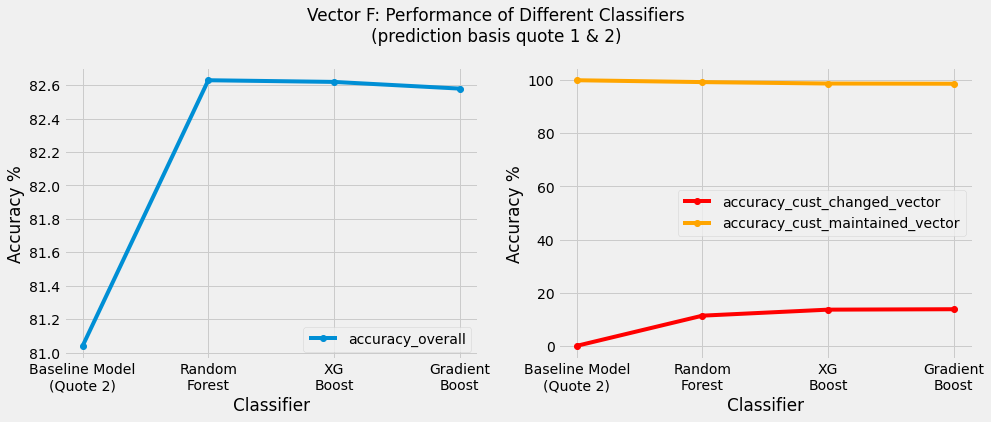

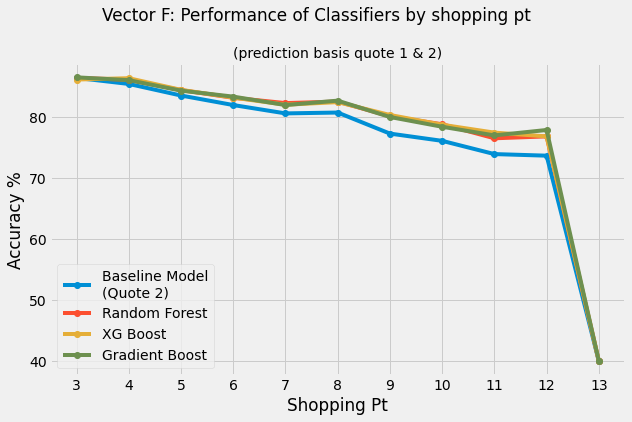

In [124]:
vector = 'F'
#models = ['no_model', 'rf', 'gb', 'xg', 'lr']
models = ['no_model', 'rf', 'xg', 'gb']
quotes = [1,2]
model_performance_plot(vector, models, quotes, perf_record_testdata.record, "overall")
model_performance_plot(vector, models, quotes, perf_record_testdata.record, "shopping_pt")


## Test Set: Predict G<a id='Phase2_step2.7'></a>

Random Forest Classifier results for Vector G
Parameters: No. of Estimators = 550,  min_samples_leaf = 1,     min_samples_split = 5
Accuracy=0.7598, f1-score=0.7581
Confusion Matrix - normalized
 [[0.7198 0.238  0.0304 0.0118]
 [0.1076 0.8281 0.0422 0.0222]
 [0.0515 0.1316 0.7734 0.0435]
 [0.0544 0.1911 0.2491 0.5053]]
Confusion Matrix
 [[2988  988  126   49]
 [ 809 6227  317  167]
 [ 311  795 4672  263]
 [  92  323  421  854]]

Classification Report 
               precision    recall  f1-score   support

           0       0.71      0.72      0.72      4151
           1       0.75      0.83      0.79      7520
           2       0.84      0.77      0.81      6041
           3       0.64      0.51      0.57      1690

    accuracy                           0.76     19402
   macro avg       0.74      0.71      0.72     19402
weighted avg       0.76      0.76      0.76     19402

10


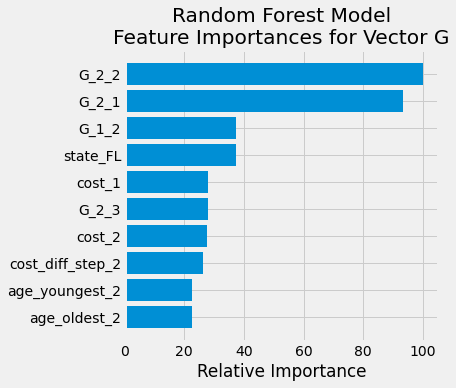

In [108]:
# Run the model with 3rd Best Parameters (iteration 8): n_estimators=550, min_samples_leaf = 1, min_samples_split = 5

vector = 'G'

rf_ac, rf_f1, rf_probs, rf_preds = rf_predict_plot(vector, n_estimators=550, min_samples_leaf = 1, min_samples_split = 5, plot=True)

In [109]:
vector = 'G'

x = pd.crosstab(y_test_compare[vector], y_test_compare[vector+"_2"], )
same_as_2 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 
acc = np.around(np.sum(same_as_2)/y_test_compare.shape[0], 4)
print(f"Accuracy based on simply predicting vector {vector} = {vector}_2 : {(np.sum(same_as_2)/y_test_compare.shape[0]): 4.4}")
x['total'] = x.sum(axis=1)
x['G0_%'] = np.around(x[0]*100 / x['total'], 2)
x['G1_%'] = np.around(x[1]*100 / x['total'], 2)
x['G2_%'] = np.around(x[2]*100 / x['total'], 2)
x['G3_%'] = np.around(x[3]*100 / x['total'], 2)
x

Accuracy based on simply predicting vector G = G_2 :  0.7431


G_2     0     1     2    3  total   G0_%   G1_%   G2_%   G3_%
G                                                            
0    2928   979   119  125   4151  70.54  23.58   2.87   3.01
1     814  6080   281  345   7520  10.82  80.85   3.74   4.59
2     305   935  4417  384   6041   5.05  15.48  73.12   6.36
3      86   278   333  993   1690   5.09  16.45  19.70  58.76

Gradient Boosting Classifier results for Vector G
Parameters: No. of Estimators = 200,  max_depth = 3,     learning_rate = 0.25, max_features = 8
Accuracy=0.7576, f1-score=0.7555
Confusion Matrix - normalized
 [[0.7174 0.239  0.0318 0.0118]
 [0.1092 0.8255 0.0455 0.0198]
 [0.0515 0.1299 0.7755 0.043 ]
 [0.0562 0.1929 0.2615 0.4893]]
Confusion Matrix
 [[2978  992  132   49]
 [ 821 6208  342  149]
 [ 311  785 4685  260]
 [  95  326  442  827]]

Classification Report 
               precision    recall  f1-score   support

           0       0.71      0.72      0.71      4151
           1       0.75      0.83      0.78      7520
           2       0.84      0.78      0.80      6041
           3       0.64      0.49      0.56      1690

    accuracy                           0.76     19402
   macro avg       0.73      0.70      0.71     19402
weighted avg       0.76      0.76      0.76     19402

10


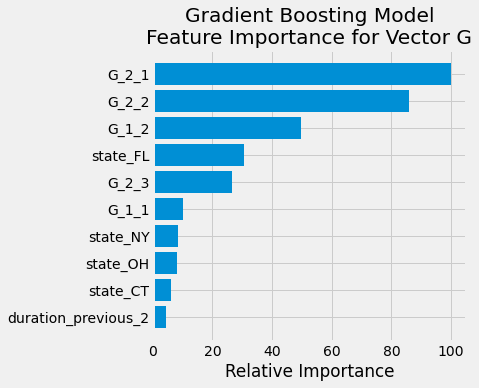

In [110]:
# model G with GradientBoosting classifier and best hyperparameters


vector = 'G'

gb_ac, gb_f1, gb_probs, gb_preds = gb_predict_plot(vector, n_estimators = 200, learning_rate = 0.25, max_depth = 3, \
                                                   max_features = 8, plot=True)

XGBoost Classifier results for Vector G
Parameters: No. of Estimators = 200,  max_depth = 5,     learning_rate = 0.25, colsample_bytree = 0.25
Accuracy=0.7581, f1-score=0.7559
Confusion Matrix - normalized
 [[0.7208 0.2349 0.0342 0.0101]
 [0.1114 0.8243 0.0459 0.0184]
 [0.0503 0.1316 0.7782 0.0399]
 [0.0586 0.1994 0.2586 0.4834]]
Confusion Matrix
 [[2992  975  142   42]
 [ 838 6199  345  138]
 [ 304  795 4701  241]
 [  99  337  437  817]]

Classification Report 
               precision    recall  f1-score   support

           0       0.71      0.72      0.71      4151
           1       0.75      0.82      0.78      7520
           2       0.84      0.78      0.81      6041
           3       0.66      0.48      0.56      1690

    accuracy                           0.76     19402
   macro avg       0.74      0.70      0.72     19402
weighted avg       0.76      0.76      0.76     19402

10


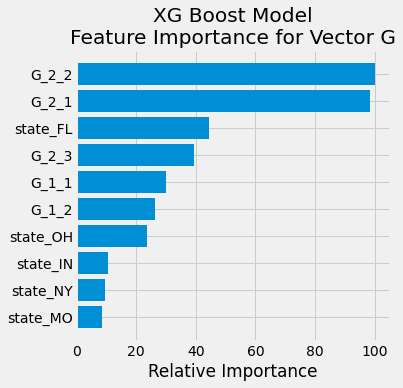

In [111]:
# model G with XGBoost classifier Best Parameters: (Overall 1st rank model)
#  No. of Estimators = 200,  max_depth = 5, learning_rate = 0.25, colsample_bytree = 0.25 : 0.7601, 0.7592

vector = 'G'

xg_ac, xg_f1, xg_probs, xg_preds = xg_predict_plot(vector, n_estimators = 200, learning_rate = 0.25, max_depth = 5, colsample_bytree = 0.25, plot=True)


In [113]:
vector = 'G'
models = ['rf', 'gb','xg']
model_preds = {'rf' : rf_preds, 'xg' : xg_preds, 'gb' : gb_preds}
model_acc = {'rf' : rf_ac, 'xg' : xg_ac, 'gb' : gb_ac}

for model in models:
    score_cust_type = model_score_matrix(vector, 2, model_preds[model])
    score_shp_pt = model_score_by_shopping_pt(vector, 2, model_preds[model])

    perf_record_testdata.update(vector, 'no_model', 'overall', acc*100)
    perf_record_testdata.update(vector, model, 'overall', round(model_acc[model]*100,2))
    perf_record_testdata.update(vector, model, 'customer_type', score_cust_type)
    perf_record_testdata.update(vector, model, 'shopping_pt', score_shp_pt)
    perf_record_testdata.compare(vector, model)

perf_record_testdata.record[vector]

C:\Users\amite\AppData\Local\Temp/ipykernel_19964/441207066.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare[vector+'_Pred'] = predictions
C:\Users\amite\AppData\Local\Temp/ipykernel_19964/441207066.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vect_compare['Pred_Correct'] = np.where(vect_compare[vector+'_Pred'] == vect_compare[vector],1,0)
C:\Users\amite\AppData\Local\Temp/ipykernel_19964/441207066.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

no_model     rf rf_vs_no_model     gb  \
accuracy_overall                   74.31  75.98           1.67  75.76   
accuracy_cust_changed_vector           0  11.46          11.46  12.26   
accuracy_cust_maintained_vector      100  98.28          -1.72  97.70   
accuracy_shopping_pt_3             77.72  78.71           0.99  78.17   
accuracy_shopping_pt_4             79.25  80.62           1.37  80.31   
accuracy_shopping_pt_5             76.97  78.08           1.11  77.77   
accuracy_shopping_pt_6             74.75  76.29           1.54  76.22   
accuracy_shopping_pt_7             72.78  74.48            1.7  74.15   
accuracy_shopping_pt_8              73.1  74.96           1.86  75.01   
accuracy_shopping_pt_9             72.38  74.43           2.05  74.59   
accuracy_shopping_pt_10            71.09  73.48           2.39  72.49   
accuracy_shopping_pt_11            72.54  75.82           3.28  74.88   
accuracy_shopping_pt_12            74.74  72.63          -2.11  71.58   
accuracy_shopping_pt_13             80.0  80.00            0.0  80.00   

                                gb_vs_no_model     xg xg_vs_no_model  
accuracy_overall                          1.45  75.81            1.5  
accuracy_cust_changed_vector             12.26  13.74          13.74  
accuracy_cust_maintained_vector           -2.3  97.27          -2.73  
accuracy_shopping_pt_3                    0.45  78.71           0.99  
accuracy_shopping_pt_4                    1.06  80.25            1.0  
accuracy_shopping_pt_5                     0.8  78.08           1.11  
accuracy_shopping_pt_6                    1.47  76.00           1.25  
accuracy_shopping_pt_7                    1.37  74.56           1.78  
accuracy_shopping_pt_8                    1.91  75.36           2.26  
accuracy_shopping_pt_9                    2.21  74.09           1.71  
accuracy_shopping_pt_10                    1.4  72.24           1.15  
accuracy_shopping_pt_11                   2.34  73.00           0.46  
accuracy_shopping_pt_12                  -3.16  73.68          -1.06  
accuracy_shopping_pt_13                    0.0  80.00            0.0

C:\Users\amite\AppData\Local\Temp/ipykernel_13712/441207066.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels)
C:\Users\amite\AppData\Local\Temp/ipykernel_13712/441207066.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels)


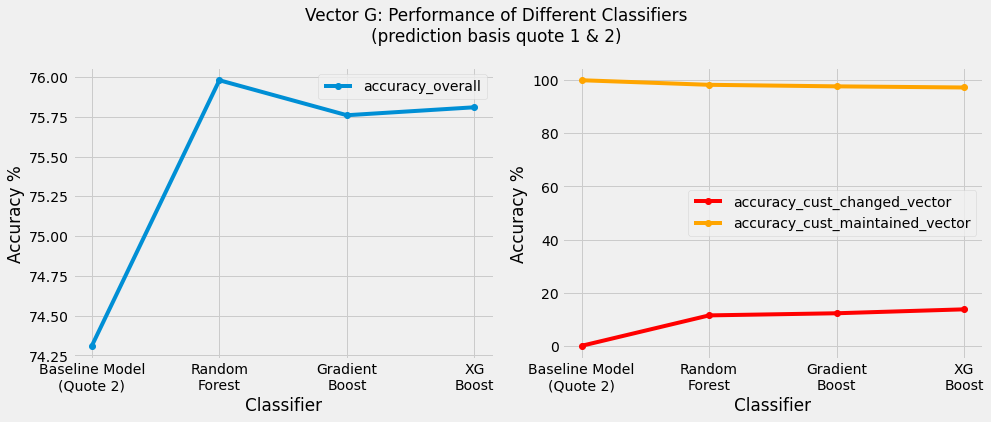

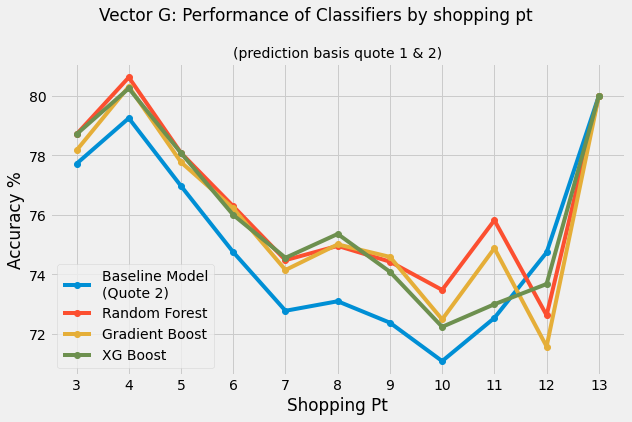

In [101]:
vector = 'G'
#models = ['no_model', 'rf', 'gb', 'xg', 'lr']
models = ['no_model', 'rf', 'gb','xg']
quotes = [1,2]
model_performance_plot(vector, models, quotes, perf_record_testdata.record, "overall")
model_performance_plot(vector, models, quotes, perf_record_testdata.record, "shopping_pt")


In [114]:
import pickle

#with open('Modelling_data/perf_record_test_set.pkl', 'wb') as f:
 #   pickle.dump(perf_record_testdata.record, f)

In [118]:
vector_best_model_map = {'A': 'xg', 'B': 'lr', 'C': 'xg', 'D': 'rf', 'E': 'xg', 'F': 'rf', 'G': 'rf'}

modeling_summary = pd.DataFrame(columns = ['vector', 'recall_baseline_model', 'best_model', 'recall_best_model', \
                            'improvement_over_baseline', 'recall_cust_changed_vector', 'recall_cust_maintained_vector'])

modeling_summary['vector'] = product_vectors
modeling_summary = modeling_summary.set_index('vector')

for vector in vector_best_model_map.keys():
    modeling_summary.loc[vector, 'recall_baseline_model'] = perf_record_testdata.record[vector].loc['accuracy_overall', 'no_model']
    modeling_summary.loc[vector, 'best_model'] = vector_best_model_map[vector]
    modeling_summary.loc[vector, 'recall_best_model'] = perf_record_testdata.record[vector].loc['accuracy_overall', vector_best_model_map[vector]]
    modeling_summary.loc[vector, 'recall_cust_changed_vector'] = perf_record_testdata.record[vector].loc['accuracy_cust_changed_vector', vector_best_model_map[vector]]
    modeling_summary.loc[vector, 'recall_cust_maintained_vector'] = perf_record_testdata.record[vector].loc['accuracy_cust_maintained_vector', vector_best_model_map[vector]]

modeling_summary['improvement_over_baseline'] = modeling_summary['recall_best_model'] - modeling_summary['recall_baseline_model'] 
for column in modeling_summary.columns:
    if column != 'best_model':
        modeling_summary[column] = modeling_summary[column].astype('float')



# Step 3: Summary - Making Predictions<a id='Phase2_step3'></a>


## Model building approach
The key steps followed to build a model for each vector were:
* Training a basic model based on 3 different classifiers - Random Forest, Gradient Boost and XG Boost. For binary vectors (B and E), a Logistic Regression classifier was also evaluated.

* Applying 60 iterations of Randomized Search CV to determine performance of different hyperparameter combinations on the training dataset

* Applying each of the 60 sets of hyperparameters on the validation set and measuring micro accuracy/recall

* Choose the best set of hyperparameters as the one that performs most consistently across the training and validation set 

* Compare the performance of different classifiers on the test set to then choose the best classifier.




## Results

The results of the modeling for each vector are summarised in the tables below:

In [119]:
modeling_summary

recall_baseline_model best_model  recall_best_model  \
vector                                                        
A                       81.91         xg              84.23   
B                       83.96         lr              84.14   
C                       80.18         xg              82.98   
D                       85.09         rf              86.71   
E                       83.80         xg              84.72   
F                       81.04         rf              82.63   
G                       74.31         rf              75.98   

        improvement_over_baseline  recall_cust_changed_vector  \
vector                                                          
A                            2.32                       21.11   
B                            0.18                        0.48   
C                            2.80                       27.02   
D                            1.62                       16.29   
E                            0.92                       13.07   
F                            1.59                       11.36   
G                            1.67                       11.46   

        recall_cust_maintained_vector  
vector                                 
A                               98.17  
B                               99.96  
C                               96.81  
D                               99.04  
E                               98.58  
F                               99.30  
G                               98.28

In [120]:
modeling_summary.describe()

recall_baseline_model  recall_best_model  improvement_over_baseline  \
count               7.000000           7.000000                   7.000000   
mean               81.470000          83.055714                   1.585714   
std                 3.606513           3.389468                   0.860346   
min                74.310000          75.980000                   0.180000   
25%                80.610000          82.805000                   1.255000   
50%                81.910000          84.140000                   1.620000   
75%                83.880000          84.475000                   1.995000   
max                85.090000          86.710000                   2.800000   

       recall_cust_changed_vector  recall_cust_maintained_vector  
count                    7.000000                       7.000000  
mean                    14.398571                      98.591429  
std                      8.379350                       1.002038  
min                      0.480000                      96.810000  
25%                     11.410000                      98.225000  
50%                     13.070000                      98.580000  
75%                     18.700000                      99.170000  
max                     27.020000                      99.960000

### Key Highlights

1) Random Forest and XG Boost came up as the best classifers. EAch of these classifiers gave the best performance for 3 of the 7 vectors. 

2) The models gave a performance improvement ranging from **0.11% to 2.8%** over the baseline model (final vector = quote2).

   * The average improvement was **1.58%**.
   * The best performance was for vector C at **2.8%**.
   * **Vector B** was the hardest to predict with only 0.18% improvement. 
       
3) Another way to analyze the model performance is by looking at predictive prowess of various models for customers who changed their vectors (from quote 2 to the final purchase) and those who maintained their vector choices (classes).

   * All models did a very good job in predicting customers who didn't change their vector choice. The recall of the models ranged from **96.81%** for vector C to **99.61%** for vector B. On average, the models predicted **98.54%** of such customers correctly.
        
   * For customers that changed vector choice, the task of prediction was harder. The models had to predict which customers would change vector choice and what the new choice would be. Here the model performance ranged from 0.48% improvement for vector B over baseline model to 27.02% for vector C. On average, the models predicted **14.72%%** of such customers correctly.
        
        
        